In [1]:
import os, sys
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *

from load_llff import load_llff_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False            

In [3]:
# takeaway function and not decompose it
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        #print(chunk) #65536
        #print(inputs.shape[0]) #4194304
        #print(range(0, inputs.shape[0], chunk)) #range(0, 4194304, 65536)  4194304/65536 = 64
        
        #65536
        #2097152
        #range(0, 2097152, 65536) 2097152/65536 = 32
        
        #fn(inputs[i:i+chunk]).shape = torch.Size([65536, 4])
        #print(fn)
        #NeRF(
        #  (pts_linears): ModuleList(
        #    (0): Linear(in_features=63, out_features=256, bias=True)
        #    (1): Linear(in_features=256, out_features=256, bias=True)
        #    (2): Linear(in_features=256, out_features=256, bias=True)
        #    (3): Linear(in_features=256, out_features=256, bias=True)
        #    (4): Linear(in_features=256, out_features=256, bias=True)
        #    (5): Linear(in_features=319, out_features=256, bias=True)
        #    (6): Linear(in_features=256, out_features=256, bias=True)
        #    (7): Linear(in_features=256, out_features=256, bias=True)
        #  )
        #  (views_linears): ModuleList(
        #    (0): Linear(in_features=283, out_features=128, bias=True)
        #  )
        #  (feature_linear): Linear(in_features=256, out_features=256, bias=True)
        #  (alpha_linear): Linear(in_features=256, out_features=1, bias=True)
        #  (rgb_linear): Linear(in_features=128, out_features=3, bias=True)
        #)
        
        #print([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)])
        
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

def run_network(inputs, view_direction, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'.
    """
    
    # [DONE] fn = model
    # [NOT] pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    
    #3
    #[-1, 3]
    # print(inputs.shape[-1]) # 3
    # print([-1, inputs.shape[-1]]) # [-1, 3]
    # print(inputs.shape) #     torch.Size([32768, 64, 3])
    # print(inputs_flat.shape) #torch.Size([2097152, 3])    


    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # -1 is the last one

    # [NOT]  embad the position
    
    # print(embed_fn) #[torch.sin, torch.cos]
    embedded = embed_fn(inputs_flat)
    # print(embedded.shape) #torch.Size([2097152, 63]) torch.Size([4194304, 63])
    #
    
    
    if view_direction is not None:
        # print(view_direction.shape)         # torch.Size([32768, 3])
        # print(view_direction[:,None].shape) # torch.Size([32768, 1, 3])
        # print(inputs.shape)                 # torch.Size([32768, 64, 3])
        input_dirs = view_direction[:,None].expand(inputs.shape)
        #print(input_dirs.shape)              # torch.Size([32768, 64, 3])
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        #print(input_dirs_flat.shape)         # torch.Size([2097152, 3])  32768 * 64 = 2097152
        # print(embeddirs_fn)                 # [torch.sin, torch.cos]
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        # print(embedded.shape)               # torch.Size([2097152, 63])
        # print(embedded_dirs.shape)          # torch.Size([65536, 27])
        embedded = torch.cat([embedded, embedded_dirs], -1)
        # print(embedded.shape)               # torch.Size([65536, 90])
        

        
        
    outputs_flat = batchify(fn, netchunk)(embedded)
    # print(outputs_flat.shape)               # torch.Size([2097152, 4]) 4 is rgb + alpha
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    # print(list(inputs.shape))                                    # [32768, 64, 3]
    # print(list(inputs.shape[:-1]))                               # [32768, 64]
    # print([outputs_flat.shape[-1]])                              # [4]
    # print(list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])    # [32768, 64, 4]
    # print(outputs.shape)                                         # torch.Size([32768, 64, 4])

    return outputs


def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    
    all_ret = {}
    # range(0, 190512, 32768)
    # print(range(0, rays_flat.shape[0], chunk))
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        # print(ret)
        # {
        # 'rgb_map': tensor([[0.1997, 0.2570, 0.1611],
        # [0.0614, 0.0617, 0.0618],
        # [0.2061, 0.2731, 0.1685],
        # ...,
        # [0.7932, 0.7912, 0.7810],
        # [0.6166, 0.6201, 0.5730],
        # [0.3050, 0.3551, 0.2093]], device='cuda:0', grad_fn=<SumBackward1>), 
        # 
        # 'disp_map': tensor([1.7129, 1.7855, 1.6072,  ..., 1.8940, 1.6734, 1.6624], device='cuda:0', grad_fn=<MulBackward0>), 
        # 
        # 'acc_map': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<SumBackward1>), 
        # 
        # 'raw': tensor([[[-1.9319e-01, -4.2380e-02, -8.0331e-01, -1.4389e+01],
        # [ 9.3089e-02,  8.9779e-02, -9.1683e-01, -2.2910e+01],
        # [ 4.2853e-01,  3.8774e-01, -8.5693e-01, -2.6790e+01],
        # ...,
        # [-6.9547e-02, -1.2431e-01, -9.7465e-01,  5.1020e+01],
        # [-4.1269e-01, -3.2929e-01, -1.0338e+00,  9.0478e+01],
        # [-2.8733e-01, -8.4059e-02, -8.7000e-01,  2.4445e+02]],

        # [[ 7.6820e-01,  1.2545e+00,  2.8074e-01, -1.4041e+01],
        # [ 1.0468e+00,  1.6502e+00, -2.7239e-03, -1.8463e+01],
        # [ 2.0594e+00,  2.3907e+00,  3.1019e-01, -2.8290e+01],
        # ...,
        # [-5.4305e-01, -5.7906e-01, -8.0245e-01,  3.2258e+01],
        # [-1.0495e+00, -1.0278e+00, -1.0844e+00,  2.2359e+01],
        # [-1.0510e+00, -9.6312e-01, -1.0124e+00,  4.2875e+01]],

        # [[-6.1452e-01, -3.0069e-01, -1.3510e+00, -1.6736e+01],
        # [-5.0800e-01, -2.1953e-01, -1.4639e+00, -1.6490e+01],
        # [-5.9743e-01, -3.3871e-01, -1.5218e+00, -1.6432e+01],
        # ...,
        # [-1.5179e+00, -1.2576e+00, -1.7958e+00,  1.1900e+02],
        # [-1.4549e+00, -1.3467e+00, -1.7947e+00,  2.3185e+01],
        # [-1.4572e+00, -1.3552e+00, -1.8064e+00,  2.3385e+01]],

        # ...,

        # [[ 6.5511e-01,  4.8005e-01, -6.8248e-01, -2.8155e+01],
        # [ 6.5423e-01,  5.9683e-01, -5.8341e-01, -2.5869e+01],
        # [ 8.5920e-01,  7.2798e-01, -5.1905e-01, -2.8843e+01],
        # ...,
        # [-1.4973e+00, -1.5925e+00, -1.6391e+00,  4.7125e+02],
        # [-2.4364e+00, -2.4179e+00, -2.4181e+00,  1.1233e+02],
        # [-2.2584e+00, -2.2210e+00, -2.2316e+00,  1.7644e+02]],

        # [[ 4.9670e-01,  7.7980e-01, -8.1408e-01, -2.0221e+01],
        # [ 4.6471e-01,  4.5477e-01, -8.6296e-01, -2.0946e+01],
        # [ 5.8376e-01,  7.6404e-01, -6.3700e-01, -2.5659e+01],
        # ...,
        # [ 3.0117e+00,  4.8709e+00,  4.3206e+00, -3.5615e+00],
        # [ 3.3435e+00,  5.6523e+00,  5.2936e+00, -2.9616e+00],
        # [ 2.6037e+00,  5.9075e+00,  6.9644e+00,  3.0141e+00]],

        # [[-4.6111e-01, -5.3944e-01, -1.6045e+00, -1.5485e+01],
        # [-6.8579e-01, -7.7304e-01, -1.8440e+00, -1.4753e+01],
        # [-5.5825e-01, -6.8661e-01, -1.7472e+00, -1.9158e+01],
        # ...,
        # [-1.0059e+00, -1.3362e+00, -1.9315e+00,  4.7464e+00],
        # [-1.0327e+00, -1.2731e+00, -1.8308e+00,  1.7083e+00],
        # [-9.5244e-01, -1.1675e+00, -1.5974e+00,  1.9663e+00]]],
        # device='cuda:0', grad_fn=<ReshapeAliasBackward0>), 
        # 
        # 'rgb0': tensor([[0.1879, 0.2435, 0.1474],
        # [0.0499, 0.0502, 0.0511],
        # [0.2260, 0.2895, 0.1910],
        # ...,
        # [0.7747, 0.7790, 0.7720],
        # [0.6317, 0.6374, 0.5979],
        # [0.3091, 0.3362, 0.1943]], device='cuda:0', grad_fn=<SumBackward1>), 
        # 
        # 'disp0': tensor([1.7112, 1.8140, 1.6950,  ..., 1.8942, 1.6637, 1.6136], device='cuda:0', grad_fn=<MulBackward0>), 
        #
        # 'acc0': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<SumBackward1>), 
        #
        # 'z_std': tensor([0.0225, 0.0156, 0.0120,  ..., 0.0108, 0.0400, 0.1336], device='cuda:0')}
        
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])
        # print(all_ret)
        # {
        # 'rgb_map': [tensor([[0.3596, 0.3708, 0.2484],
        # [0.4484, 0.4415, 0.3111],
        # [0.3928, 0.3898, 0.2720],
        # ...,
        # [0.5030, 0.4285, 0.3517],
        # [0.4962, 0.4172, 0.3334],
        # [0.4887, 0.4095, 0.3234]], device='cuda:0'), tensor([[0.4374, 0.3868, 0.3077],
        # [0.3152, 0.2962, 0.2380],
        # [0.3303, 0.3047, 0.2461],
        # ...,
        # [0.3095, 0.2413, 0.1847],
        # [0.3425, 0.2649, 0.2020],
        # [0.3390, 0.2649, 0.2017]], device='cuda:0'), tensor([[0.3280, 0.2559, 0.1973],
        # [0.3296, 0.2548, 0.1944],
        # [0.3282, 0.2526, 0.1935],
        # ...,
        # [0.6551, 0.6464, 0.5171],
        # [0.6250, 0.6028, 0.4798],
        # [0.5882, 0.5469, 0.4264]], device='cuda:0')], 'disp_map': [tensor([1.6642, 1.6570, 1.6521,  ..., 1.5733, 1.5742, 1.5784], device='cuda:0'), tensor([1.6753, 1.7885, 1.7782,  ..., 1.2587, 1.2471, 1.2447], device='cuda:0'), tensor([1.2399, 1.2391, 1.2425,  ..., 1.8311, 1.6835, 1.5569], device='cuda:0')], 'acc_map': [tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')], 'rgb0': [tensor([[0.4536, 0.4364, 0.3346],
        # [0.5424, 0.5290, 0.4109],
        # [0.4064, 0.4065, 0.3093],
        # ...,
        # [0.5558, 0.4727, 0.3682],
        # [0.5424, 0.4564, 0.3573],
        # [0.5501, 0.4731, 0.3673]], device='cuda:0'), tensor([[0.4619, 0.4234, 0.3358],
        # [0.3041, 0.3021, 0.2474],
        # [0.3874, 0.3397, 0.2682],
        # ...,
        # [0.3025, 0.2407, 0.1764],
        # [0.3031, 0.2447, 0.1801],
        # [0.2946, 0.2330, 0.1723]], device='cuda:0'), tensor([[0.3052, 0.2408, 0.1792],
        # [0.3163, 0.2515, 0.1894],
        # [0.3279, 0.2622, 0.1952],
        # ...,
        # [0.5881, 0.6169, 0.4851],
        # [0.5934, 0.6035, 0.4814],
        # [0.5528, 0.5513, 0.4327]], device='cuda:0')], 
        # 'disp0': [tensor([1.6387, 1.6301, 1.6558,  ..., 1.5708, 1.5701, 1.5913], device='cuda:0'), tensor([1.7420, 1.7823, 1.6791,  ..., 1.2635, 1.2633, 1.2224], device='cuda:0'), tensor([1.2286, 1.2143, 1.2203,  ..., 1.9050, 1.8043, 1.7108], device='cuda:0')], 
        # 'acc0': [tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')], 
        # 'z_std': [tensor([0.0900, 0.0902, 0.0901,  ..., 0.0915, 0.0911, 0.0938], device='cuda:0'), tensor([0.0941, 0.0896, 0.0965,  ..., 0.1283, 0.1263, 0.1056], device='cuda:0'), tensor([0.1051, 0.1050, 0.1063,  ..., 0.1518, 0.1549, 0.1401], device='cuda:0')]}
    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    # print(all_ret)
    # {
    # 'rgb_map': tensor([[0.3581, 0.3689, 0.2477],
    #    [0.4479, 0.4408, 0.3112],
    #    [0.3914, 0.3884, 0.2717],
    #    ...,
    #    [0.8166, 0.7137, 0.5876],
    #    [0.8147, 0.7113, 0.5886],
    #    [0.8124, 0.7104, 0.5837]], device='cuda:0'), 
    #
    # 'disp_map': tensor([1.6642, 1.6571, 1.6522,  ..., 1.9530, 1.9497, 1.9521], device='cuda:0'), 
    # 'acc_map': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), 
    # 'rgb0': tensor([[0.4541, 0.4368, 0.3353],
    #    [0.5436, 0.5301, 0.4126],
    #    [0.4064, 0.4066, 0.3099],
    #    ...,
    #    [0.8254, 0.7126, 0.6027],
    #    [0.8204, 0.7077, 0.5972],
    #    [0.8221, 0.7101, 0.5964]], device='cuda:0'), 
    # 'disp0': tensor([1.6389, 1.6301, 1.6560,  ..., 1.7748, 1.7937, 1.8374], device='cuda:0'), 
    # 'acc0': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'), 
    # 'z_std': tensor([0.0900, 0.0902, 0.0901,  ..., 0.1195, 0.1143, 0.1107], device='cuda:0')}
    
    # torch.Size([378, 504, 3]) torch.Size([378, 504])
    return all_ret




def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, K, c2w)
        #print(H)  # 378
        #print(W)  # 504
        
        #print(K)
        
        #[[407.5657959   0.        252.       ]
        # [  0.        407.5657959 189.       ]
        # [  0.          0.          1.       ]]
        
        # print(c2w)

        # tensor([[ 9.9583e-01, -3.7973e-05,  9.1231e-02,  3.9451e-01],
        #        [ 3.8132e-05,  1.0000e+00, -1.8653e-09, -9.6858e-09],
        #        [-9.1231e-02,  3.4807e-06,  9.9583e-01,  0.0000e+00]], device='cuda:0')

        # print(rays_o.shape) # torch.Size([378, 504, 3])
        # print(rays_d.shape) # torch.Size([378, 504, 3])
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()
        # print(viewdirs)
        
        # tensor([[ 0.3432,  0.1160, -0.9321],
        #        [-0.1477,  0.2889, -0.9459],
        #        [ 0.3782, -0.3090, -0.8726],
        #        ...,
        #        [-0.5139, -0.2868, -0.8085],
        #        [ 0.5251,  0.2238, -0.8211],
        #        [-0.2700, -0.2209, -0.9372]], device='cuda:0')
        
        # print(viewdirs.shape)
        # torch.Size([1024, 3])
        

    sh = rays_d.shape # [..., 3] 
    # print(sh) # torch.Size([378, 504, 3])
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

        

    # Create ray batch
    # print(rays_o.shape) # torch.Size([378, 504, 3])
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    # print(rays_o.shape) # torch.Size([190512, 3])
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    # print(torch.ones_like(rays_d[...,:1]))
    
    # tensor([[1.],
    #    [1.],
    #    [1.],
    #    ...,
    #    [1.],
    #    [1.],
    #    [1.]], device='cuda:0')
    
    # print(torch.ones_like(rays_d[...,:1]).shape)
    # torch.Size([190512, 1])
    
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    
    # print(near)
    
    # tensor([[0.],
    #    [0.],
    #    [0.],
    #    ...,
    #    [0.],
    #    [0.],
    #    [0.]], device='cuda:0')
    
    # print(far)
    
    # tensor([[1.],
    #    [1.],
    #    [1.],
    #    ...,
    #    [1.],
    #    [1.],
    #    [1.]], device='cuda:0')
    
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    
    #print(rays)
    
    #tensor([[ 0.3704,  0.0923, -1.0000,  ...,  2.0000,  0.0000,  1.0000],
    #    [-0.9372,  0.0905, -1.0000,  ...,  2.0000,  0.0000,  1.0000],
    #    [ 0.8355, -0.1676, -1.0000,  ...,  2.0000,  0.0000,  1.0000],
    #    ...,
    #    [-0.3754, -0.1484, -1.0000,  ...,  2.0000,  0.0000,  1.0000],
    #    [ 0.0914,  1.0717, -1.0000,  ...,  2.0000,  0.0000,  1.0000],
    #    [ 1.0489,  0.5523, -1.0000,  ...,  2.0000,  0.0000,  1.0000]],
    #   device='cuda:0')
    
    # print(rays.shape) # torch.Size([1024, 8])
    

    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    #print(rays)
    
    # tensor([[-0.7948, -0.9399, -1.0000,  ..., -0.2841, -0.3516, -0.8920],
    #    [-0.2115, -0.0843, -1.0000,  ..., -0.2699, -0.0656, -0.9607],
    #    [-0.5973,  0.3672, -1.0000,  ..., -0.1928,  0.1862, -0.9634],
    #    ...,
    #    [-0.7046,  0.4731, -1.0000,  ..., -0.2490,  0.2268, -0.9416],
    #    [ 0.0953,  0.9137, -1.0000,  ...,  0.3694,  0.3839, -0.8462],
    #    [-0.3576,  0.9673, -1.0000,  ..., -0.4698,  0.3516, -0.8097]],
    #   device='cuda:0')
    
    # print(rays.shape) # torch.Size([1024, 11])
    
    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        # print(k)
        # print(list(sh[:-1]))
        # print(list(all_ret[k].shape[1:]))
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        # print(k_sh)
        all_ret[k] = torch.reshape(all_ret[k], k_sh)
        
        #rgb_map
        #[378, 504]
        #[3]
        #[378, 504, 3]
        #disp_map
        #[378, 504]
        #[]
        #[378, 504]
        #acc_map
        #[378, 504]
        #[]
        #[378, 504]
        #rgb0
        #[378, 504]
        #[3]
        #[378, 504, 3]
        #disp0
        #[378, 504]
        #[]
        #[378, 504]
        #acc0
        #[378, 504]
        #[]
        #[378, 504]
        #z_std
        #[378, 504]
        #[]
        #[378, 504]

        
        

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]




def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                return_raw=False,
                linear_depend_inverse_depth=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_background=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      return_raw: bool. If True, include model's raw, unprocessed predictions.
      linear_depend_inverse: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_background: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disparity_map: [num_rays]. Disparity map. 1 / depth.
      accumulated_opacity_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disparity_map. Output for coarse model.
      acc0: See accumulated_opacity_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """
    N_rays = ray_batch.shape[0]
    # print(ray_batch.shape)      # torch.Size([1024, 11])
    
    rays_origin, rays_direction = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    # print(rays_origin.shape)    # torch.Size([1024, 3])
    # print(rays_direction.shape) # torch.Size([1024, 3])
    
    view_direction = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None
    
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
    # print(bounds.shape)         # torch.Size([1024, 1, 2])
    
    near, far = bounds[...,0], bounds[...,1] # [-1,1]

    t_vals = torch.linspace(0., 1., steps=N_samples).to(device)
    
    if not linear_depend_inverse_depth:
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    # print(z_vals.shape)         # torch.Size([1024, 64])
    z_vals = z_vals.expand([N_rays, N_samples]).to(device)
    # print(z_vals.shape)         # torch.Size([1024, 64])
    
    

    
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        upper = torch.cat([mids, z_vals[...,-1:]], -1)
        lower = torch.cat([z_vals[...,:1], mids], -1)
        
        # print(mids.shape)       # torch.Size([1024, 63])
        # print(upper.shape)      # torch.Size([1024, 64])
        # print(lower.shape)      # torch.Size([1024, 64])

        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape).to(device)
        
        # print(t_rand.shape)     # torch.Size([1024, 64])

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand).to(device)

        z_vals = lower + (upper - lower) * t_rand

    # form the origin to the end of the ray, in the ray direction to form pts
    pts = rays_origin[...,None,:] + rays_direction[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    


#   raw = run_network(pts)

    # print(network_query_fn) # <function train.<locals>.<lambda> at 0x7f2a0243b700>
    # print(network_fn)       # NERF()
    raw = network_query_fn(pts, view_direction, network_fn)
    # print(raw.shape)        # torch.Size([1024, 64, 4])
    
    rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map = raw2outputs_kernel_function(raw, z_vals, rays_direction, raw_noise_std, white_background, pytest=pytest)

    # print(rgb_map.shape)                  # torch.Size([1024, 3])
    # print(disparity_map.shape)            # torch.Size([1024])
    # print(accumulated_opacity_map.shape)  # torch.Size([1024])
    # print(weights.shape)                  # torch.Size([1024, 64])
    # print(depth_map.shape)                # torch.Size([1024])
    
    if N_importance > 0:

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disparity_map, accumulated_opacity_map

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        z_samples = z_samples.detach()

        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
        pts = rays_origin[...,None,:] + rays_direction[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        raw = network_query_fn(pts, view_direction, run_fn)

        rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map = raw2outputs_kernel_function(raw, z_vals, rays_direction, raw_noise_std, white_background, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disparity_map, 'acc_map' : accumulated_opacity_map}
    if return_raw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret



def raw2outputs_kernel_function(raw, z_vals, rays_direction, raw_noise_std=0, white_background=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_direction: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disparity_map: [num_rays]. Disparity map. Inverse of depth map.
        accumulated_opacity_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    raw2alpha = lambda raw, distances, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*distances)
    



    
    distances = z_vals[...,1:] - z_vals[...,:-1]
    # print(distances.shape) # torch.Size([1024, 63])
    distances = torch.cat([distances, torch.Tensor([1e10]).to(device).expand(distances[...,:1].shape)], -1)  # [N_rays, N_samples]
    # print(distances.shape) # torch.Size([1024, 64])
    # print(distances)
    # tensor([[1.4942e-02, 1.5233e-02, 1.4264e-02,  ..., 1.0590e-02, 8.3287e-03,
    #  1.0000e+10],
    # [4.7994e-03, 2.6690e-02, 5.5363e-03,  ..., 1.2192e-02, 1.2408e-02,
    #  1.0000e+10],
    # [1.0520e-02, 7.1725e-03, 1.8006e-02,  ..., 1.3228e-02, 7.9815e-03,
    #  1.0000e+10],
    # ...,
    # [1.3458e-02, 1.5161e-02, 1.3487e-02,  ..., 1.1210e-02, 1.1830e-02,
    #  1.0000e+10],
    # [1.3381e-02, 1.7829e-02, 2.5521e-03,  ..., 6.9237e-03, 1.6017e-02,
    #  1.0000e+10],
    # [1.2072e-02, 1.7107e-02, 1.1094e-02,  ..., 2.1299e-02, 6.8605e-03,
    # 1.0000e+10]], device='cuda:0')
    distances = distances * torch.norm(rays_direction[...,None,:], dim=-1)
    
    # print(torch.norm(rays_direction[...,None,:], dim=-1))
    # tensor([[2.0986],
    #     [2.0023],
    #     [2.0339],
    #     ...,
    #     [2.0334],
    #     [2.0881],
    #     [2.0427]], device='cuda:0')
    
    
    # print(distances.shape) # torch.Size([1024, 64])
    # print(distances)
    # tensor([[3.0871e-02, 3.1471e-02, 2.9470e-02,  ..., 2.1879e-02, 1.7207e-02,
    #          2.0660e+10],
    #         [9.6703e-03, 5.3778e-02, 1.1155e-02,  ..., 2.4566e-02, 2.5000e-02,
    #          2.0149e+10],
    #         [2.1828e-02, 1.4883e-02, 3.7363e-02,  ..., 2.7448e-02, 1.6562e-02,
    #          2.0750e+10],
    #         ...,
    #         [2.7521e-02, 3.1004e-02, 2.7580e-02,  ..., 2.2924e-02, 2.4192e-02,
    #          2.0450e+10],
    #         [2.7263e-02, 3.6327e-02, 5.1998e-03,  ..., 1.4107e-02, 3.2634e-02,
    #          2.0375e+10],
    #         [2.4599e-02, 3.4857e-02, 2.2606e-02,  ..., 4.3398e-02, 1.3979e-02,
    #          2.0376e+10]], device='cuda:0')
    rgb = torch.sigmoid(raw[...,:3])  # [N_rays, N_samples, 3]
    # print(raw[...,:3])
    # tensor([[[ 0.0404, -0.1108, -0.0680],
    #      [ 0.0393, -0.1103, -0.0705],
    #      [ 0.0395, -0.1105, -0.0707],
    #      ...,
    #      [ 0.0379, -0.1106, -0.0705],
    #      [ 0.0364, -0.1127, -0.0677],
    #      [ 0.0359, -0.1121, -0.0677]],

    #     [[-0.0153, -0.1384, -0.0835],
    #      [-0.0165, -0.1386, -0.0814],
    #      [-0.0185, -0.1409, -0.0810],
    #      ...,
    #      [-0.0207, -0.1419, -0.0842],
    #      [-0.0196, -0.1402, -0.0828],
    #      [-0.0196, -0.1417, -0.0822]],

    #     [[ 0.0229, -0.1222, -0.0631],
    #      [ 0.0215, -0.1270, -0.0625],
    #      [ 0.0215, -0.1254, -0.0623],
    #      ...,
    #      [ 0.0254, -0.1230, -0.0614],
    #      [ 0.0237, -0.1229, -0.0615],
    #      [ 0.0230, -0.1261, -0.0606]],

    #     ...,

    #     [[-0.0094, -0.1177, -0.0549],
    #      [-0.0085, -0.1184, -0.0538],
    #      [-0.0069, -0.1176, -0.0548],
    #      ...,
    #      [-0.0080, -0.1179, -0.0549],
    #      [-0.0099, -0.1207, -0.0525],
    #      [-0.0092, -0.1203, -0.0524]],

    #     [[ 0.0120, -0.1012, -0.1174],
    #      [ 0.0140, -0.1005, -0.1179],
    #      [ 0.0138, -0.1007, -0.1172],
    #      ...,
    #      [ 0.0111, -0.0992, -0.1177],
    #      [ 0.0105, -0.1011, -0.1163],
    #      [ 0.0118, -0.1011, -0.1173]],

    #     [[-0.0286, -0.1325, -0.0700],
    #      [-0.0293, -0.1317, -0.0702],
    #      [-0.0264, -0.1328, -0.0693],
    #      ...,
    #      [-0.0265, -0.1357, -0.0692],
    #      [-0.0273, -0.1366, -0.0681],
    #      [-0.0285, -0.1353, -0.0693]]], device='cuda:0',
    #    grad_fn=<SliceBackward0>)
    # print(rgb)
    # tensor([[[0.5101, 0.4723, 0.4830],
    #      [0.5098, 0.4724, 0.4824],
    #      [0.5099, 0.4724, 0.4823],
    #      ...,
    #      [0.5095, 0.4724, 0.4824],
    #      [0.5091, 0.4719, 0.4831],
    #      [0.5090, 0.4720, 0.4831]],

    #     [[0.4962, 0.4655, 0.4791],
    #      [0.4959, 0.4654, 0.4797],
    #      [0.4954, 0.4648, 0.4798],
    #      ...,
    #      [0.4948, 0.4646, 0.4790],
    #      [0.4951, 0.4650, 0.4793],
    #      [0.4951, 0.4646, 0.4795]],

    #     [[0.5057, 0.4695, 0.4842],
    #      [0.5054, 0.4683, 0.4844],
    #      [0.5054, 0.4687, 0.4844],
    #      ...,
    #      [0.5063, 0.4693, 0.4846],
    #      [0.5059, 0.4693, 0.4846],
    #      [0.5057, 0.4685, 0.4849]],

    #     ...,

    #     [[0.4976, 0.4706, 0.4863],
    #      [0.4979, 0.4704, 0.4865],
    #      [0.4983, 0.4706, 0.4863],
    #      ...,
    #      [0.4980, 0.4706, 0.4863],
    #      [0.4975, 0.4698, 0.4869],
    #      [0.4977, 0.4700, 0.4869]],

    #     [[0.5030, 0.4747, 0.4707],
    #      [0.5035, 0.4749, 0.4706],
    #      [0.5035, 0.4749, 0.4707],
    #      ...,
    #      [0.5028, 0.4752, 0.4706],
    #      [0.5026, 0.4748, 0.4709],
    #      [0.5029, 0.4747, 0.4707]],

    #     [[0.4929, 0.4669, 0.4825],
    #      [0.4927, 0.4671, 0.4825],
    #      [0.4934, 0.4669, 0.4827],
    #      ...,
    #      [0.4934, 0.4661, 0.4827],
    #      [0.4932, 0.4659, 0.4830],
    #      [0.4929, 0.4662, 0.4827]]], device='cuda:0',
    #    grad_fn=<SigmoidBackward0>)
    #    sigmond( -0.0285 ) = 0.4929
    
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape).to(device) * raw_noise_std

        # Overwrite randomly sampled data if pytest
        if pytest:
            np.random.seed(0)
            noise = np.random.rand(*list(raw[...,3].shape)) * raw_noise_std
            noise = torch.Tensor(noise).to(device)

    alpha = raw2alpha(raw[...,3] + noise, distances)  # [N_rays, N_samples]
    
    # print(raw[...,3].shape) # torch.Size([1024, 64])
    # print(distances.shape)  # torch.Size([1024, 64])
    # print(alpha.shape)      # torch.Size([1024, 64])
    
    # print( torch.cat([torch.ones((alpha.shape[0], 1)).to(device), 1.-alpha + 1e-10], -1) )
    # print( torch.cat([torch.ones((alpha.shape[0], 1)).to(device), 1.-alpha + 1e-10], -1).shape )
    
    # tensor([[1.0000e+00, 1.0000e+00, 9.8664e-01,  ..., 9.3879e-01, 9.7269e-01,
    #      1.0000e+00],
    #     [1.0000e+00, 9.8739e-01, 1.0000e+00,  ..., 9.9525e-01, 9.7405e-01,
    #      1.0000e+00],
    #     [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 9.8951e-01, 9.9980e-01,
    #      1.0000e+00],
    #     ...,
    #     [1.0000e+00, 9.6991e-01, 9.7920e-01,  ..., 9.5538e-01, 1.0000e+00,
    #      1.0000e-10],
    #     [1.0000e+00, 1.0000e+00, 9.7404e-01,  ..., 9.8908e-01, 1.0000e+00,
    #      1.0000e+00],
    #     [1.0000e+00, 9.7760e-01, 1.0000e+00,  ..., 9.7234e-01, 9.6326e-01,
    #      1.0000e-10]], device='cuda:0', grad_fn=<CatBackward0>)    

    # print( [torch.ones((alpha.shape[0], 1)).to(device), 1.-alpha + 1e-10] )
    
    # print( torch.ones((alpha.shape[0], 1)).shape )

    # [tensor([[1.],
    #     [1.],
    #     [1.],
    #     ...,
    #     [1.],
    #     [1.],
    #     [1.]], device='cuda:0'), tensor([[1.0000e+00, 9.8664e-01, 1.0000e+00,  ..., 9.3879e-01, 9.7269e-01,
    #      1.0000e+00],
    #     [9.8739e-01, 1.0000e+00, 1.0000e+00,  ..., 9.9525e-01, 9.7405e-01,
    #      1.0000e+00],
    #     [1.0000e+00, 1.0000e+00, 9.7597e-01,  ..., 9.8951e-01, 9.9980e-01,
    #      1.0000e+00],
    #     ...,
    #     [9.6991e-01, 9.7920e-01, 9.5232e-01,  ..., 9.5538e-01, 1.0000e+00,
    #      1.0000e-10],
    #     [1.0000e+00, 9.7404e-01, 1.0000e+00,  ..., 9.8908e-01, 1.0000e+00,
    #      1.0000e+00],
    #     [9.7760e-01, 1.0000e+00, 9.8615e-01,  ..., 9.7234e-01, 9.6326e-01,
    #      1.0000e-10]], device='cuda:0', grad_fn=<AddBackward0>)]
    
    # print( torch.ones((alpha.shape[0], 1)).to(device) )
    # print( torch.ones((alpha.shape[0], 1)).shape )
    # tensor([[1.],
    #     [1.],
    #     [1.],
    #     ...,
    #     [1.],
    #     [1.],
    #     [1.]], device='cuda:0')
    
    # print( 1.-alpha + 1e-10 )
    
    # tensor([[1.0000e+00, 9.8664e-01, 1.0000e+00,  ..., 9.3879e-01, 9.7269e-01,
    #      1.0000e+00],
    #     [9.8739e-01, 1.0000e+00, 1.0000e+00,  ..., 9.9525e-01, 9.7405e-01,
    #      1.0000e+00],
    #     [1.0000e+00, 1.0000e+00, 9.7597e-01,  ..., 9.8951e-01, 9.9980e-01,
    #      1.0000e+00],
    #     ...,
    #     [9.6991e-01, 9.7920e-01, 9.5232e-01,  ..., 9.5538e-01, 1.0000e+00,
    #      1.0000e-10],
    #     [1.0000e+00, 9.7404e-01, 1.0000e+00,  ..., 9.8908e-01, 1.0000e+00,
    #      1.0000e+00],
    #     [9.7760e-01, 1.0000e+00, 9.8615e-01,  ..., 9.7234e-01, 9.6326e-01,
    #      1.0000e-10]], device='cuda:0', grad_fn=<AddBackward0>)
    
    
    # print( alpha.shape ) # torch.Size([1024, 64])   
    # print( alpha ) # 1.-torch.exp(-act_fn(raw)*distances)
    




     
    # weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    # tensor = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float)
    # cumprod_tensor = torch.cumprod(tensor, dim=0)
    # tensor([1., 2., 6., 24., 120.])
    # torch.cumprod() is Ti of all the point
    
    # alpha = 1.-torch.exp(-act_fn(raw)*distances)
    # Ti = torch.cumprod()
    # weights = Ti * ( 1 - exp( NREF()*delta ) ) 
    
    Ti = torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)).to(device), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    weights = Ti * alpha 
    rgb_map = torch.sum(weights[...,None] * rgb, -2)  # [N_rays, 3]

    depth_map = torch.sum(weights * z_vals, -1)
    disparity_map = 1./torch.max(1e-10 * torch.ones_like(depth_map).to(device), depth_map / torch.sum(weights, -1))
    accumulated_opacity_map = torch.sum(weights, -1)

    if white_background:
        rgb_map = rgb_map + (1.-accumulated_opacity_map[...,None])

    return rgb_map, disparity_map, accumulated_opacity_map, weights, depth_map


def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps





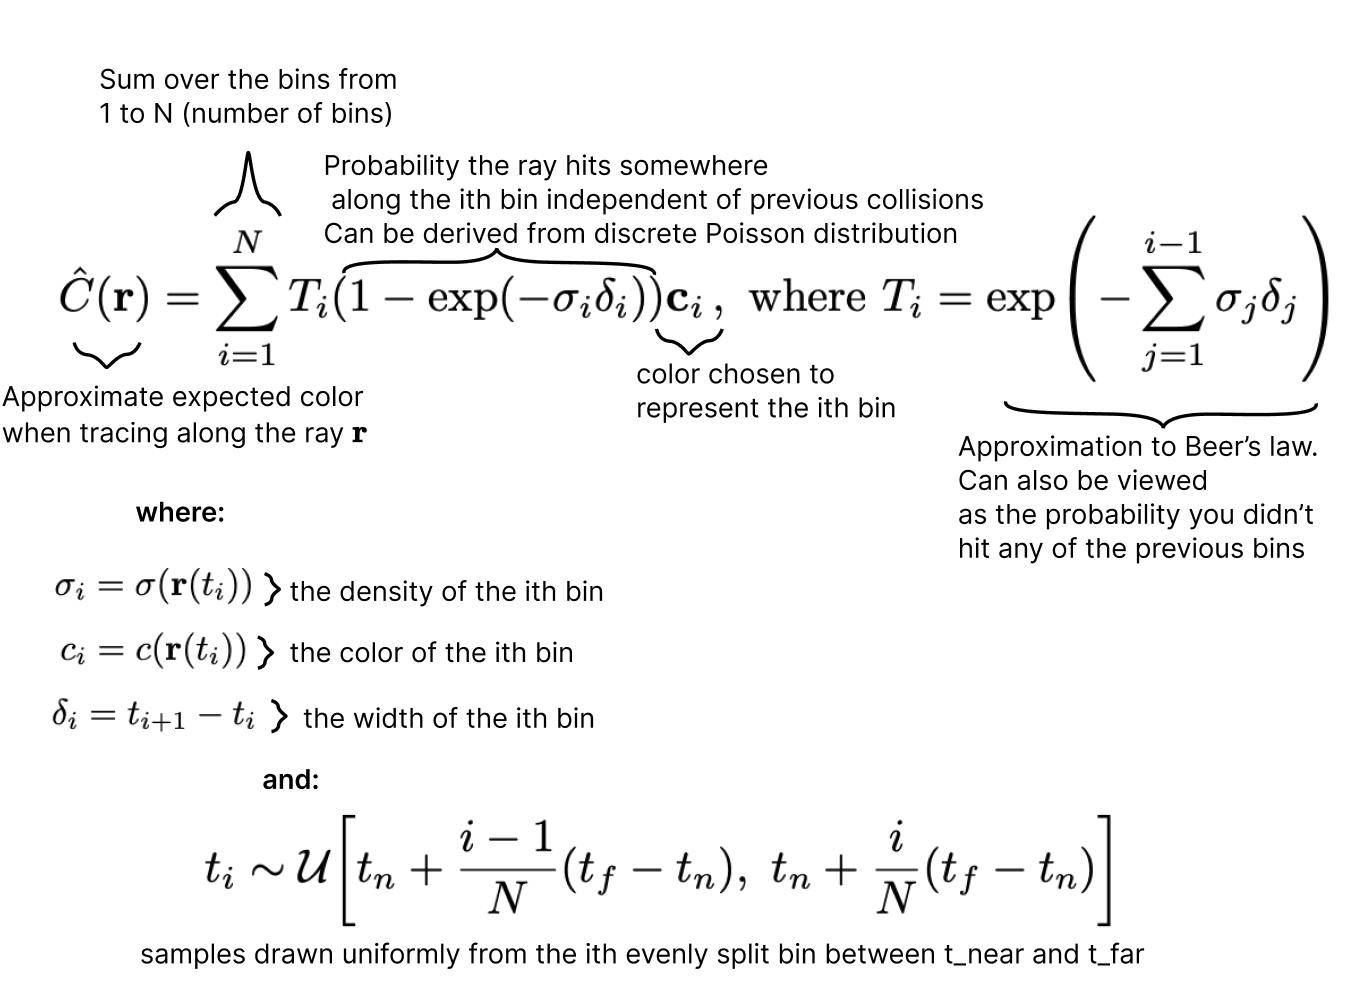

In [8]:
def train():

    
    #########################################################################
    # python run_nerf.py --config configs/fern.txt
    N_importance = 64
    N_rand = 1024
    N_samples = 64
    basedir = './logs'
    chunk = 32768
    config = 'configs/fern.txt'
    datadir = './data/nerf_llff_data/fern'
    dataset_type = 'llff'
    expname = 'fern_test'
    factor = 8
    ft_path = None
    half_res = False
    i_embed = 0
    i_img = 500
    i_print = 100
    i_testset = 5000
    i_video = 5000
    i_weights = 10000
    lindisp = False
    llffhold = 8
    lrate = 0.0005
    lrate_decay = 250
    multires = 10
    multires_views = 4
    netchunk = 65536
    netdepth = 8
    netdepth_fine = 8
    netwidth = 256
    netwidth_fine = 256
    no_batching = False
    no_ndc = False
    no_reload = False
    perturb = 1.0
    precrop_frac = 0.5
    precrop_iters = 0
    raw_noise_std = 1.0
    render_factor = 0
    render_only = False
    render_test = False
    shape = 'greek'
    spherify = False
    testskip = 8
    use_viewdirs = True
    white_background = False
    ################################################################################

    images, poses, bds, render_poses, i_test = load_llff_data(datadir, factor, recenter=True, bd_factor=.75, spherify=spherify)
    print("================[0][load_data]=================")
    #print(images.shape)   (20, 378, 504, 3)
    #print(poses.shape)    (20, 3, 5)
    #print(bds.shape)      (20, 2)
    #print(render_poses.shape)  (120, 3, 5)   # Generate poses for spiral path
    #print(i_test) 12           print('HOLDOUT view is', i_test)
    #print(i_test.shape)

    #print(bds) [0.5500126  2.4253333 ]
    # print(bds.shape)  (20, 2)
    # []


    # what is the (20, 3, 5), 3 is for what, 5 is for what
    hwf = poses[0,:3,-1]
    poses = poses[:,:3,:4]
    #print(poses.shape) (20, 3, 4)
    print(poses[0])
    # (20, 378, 504, 3) (120, 3, 5) [378.     504.     407.5658] ./data/nerf_llff_data/fern
    print('Loaded llff', images.shape, render_poses.shape, hwf, datadir)

    if not isinstance(i_test, list):
        i_test = [i_test]

    #print(i_test) [12]


    if llffhold > 0:
        print('Auto LLFF holdout,', llffhold)
        i_test = np.arange(images.shape[0])[::llffhold]
    #print(i_test) [ 0  8 16]

    i_val = i_test
    i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                    (i not in i_test and i not in i_val)])
    #print(i_train) [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19]


    print('DEFINING BOUNDS')
    if no_ndc:
        near = np.ndarray.min(bds) * .9
        far = np.ndarray.max(bds) * 1.

    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far) # 0.4737630307674408 2.4794018268585205


    # 1 Cast intrinsics to right types
    H, W, focal = hwf
    #print(hwf)  [378.     504.     407.5658]
    H, W = int(H), int(W)
    hwf = [H, W, focal]
    
    #print(hwf) [378, 504, 407.5658]

    # Load data

    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

    print(K)    
    
    basedir = basedir
    expname = expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)    
    
    
        
    
    # create_nerf()
    
    print("================[1][create_nerf()]=================")
    # Positional encoding
    
    embed_fn, input_ch = get_embedder(multires, i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(multires_views, i_embed)
    output_ch = 5 if N_importance > 0 else 4
    skips = [4]
    
    
    model = NeRF(D=netdepth, W=netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    
    model_fine = None
    if N_importance > 0:
        model_fine = NeRF(D=netdepth_fine, W=netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=netchunk)

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=lrate, betas=(0.9, 0.999))

    start = 0
    basedir = basedir
    expname = expname

    ##########################

    # Load checkpoints
    if ft_path is not None and ft_path!='None':
        ckpts = [ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : perturb,
        'N_importance' : N_importance,
        'network_fine' : model_fine,
        'N_samples' : N_samples,
        'network_fn' : model,
        'use_viewdirs' : use_viewdirs,
        'white_background' : white_background,
        'raw_noise_std' : raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if dataset_type != 'llff' or no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.
    
    
    print("================[2][get training data, validation data]=================")

    global_step = start

    bds_dict = {
        'near' : near,
        'far' : far,
    }

    # near, far to dictionary
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    
    
    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)
    #print(render_poses)
    #print(render_poses.shape) torch.Size([3, 3, 4])    
    
    # Prepare raybatch tensor if batching random rays
    N_rand = N_rand # 1024
    use_batching = not no_batching # no_batching = True
    
    
    
    if use_batching:
        # For random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0

    # Move training data to GPU
    if use_batching:
        images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    
    #print(poses)
    #print(poses.shape) #torch.Size([20, 3, 4])
    
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)    

    N_iters = 100000 + 1
    print('Begin')
    print('TRAIN views are', i_train)
    print('TEST views are', i_test)
    print('VAL views are', i_val)

    start = start + 1   
    for i in trange(start, N_iters):
        time0 = time.time()
        
        # Sample random ray batch
        if use_batching:
            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0
                
                
        #####  Core optimization loop  #####
        rgb, disp, acc, extras = render(H, W, K, chunk=chunk, rays=batch_rays, verbose=i < 10, return_raw=True, **render_kwargs_train)   
        
        #print("================[3][loss]=================")
        
        #print(rgb.shape)
        
        optimizer.zero_grad()
        # get the loss of model prediction and the target image
        img_loss = img2mse(rgb, target_s)
        trans = extras['raw'][...,-1]
        loss = img_loss
        psnr = mse2psnr(img_loss)

        #input("Press Enter to continue...")
        
        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)

        loss.backward()
        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_rate = 0.1
        decay_steps = lrate_decay * 1000
        new_lrate = lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################

        dt = time.time()-time0

        # Rest is logging
        if i%i_weights==0:
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)

        if i%i_video==0 and i > 0:
            # Turn on testing mode
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, chunk, render_kwargs_test)
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

        if i%i_testset==0 and i > 0:
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', poses[i_test].shape)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            print('Saved test set')


    
        if i%i_print==0:
            tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}")

        global_step += 1

In [9]:
train()

================[0][load_data]=================
[[ 0.99569476 -0.02079598 -0.09033062 -0.3081002 ]
 [ 0.02503342  0.9986262   0.04603354  0.1346772 ]
 [ 0.0892492  -0.04809664  0.99484736  0.03989876]]
Loaded llff (20, 378, 504, 3) (120, 3, 5) [378.     504.     407.5658] ./data/nerf_llff_data/fern
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0
[[407.5657959   0.        252.       ]
 [  0.        407.5657959 189.       ]
 [  0.          0.          1.       ]]
================[1][create_nerf()]=================
Found ckpts []
================[2][get training data, validation data]=================
get rays
done, concats
shuffle rays
done
Begin
TRAIN views are [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19]
TEST views are [ 0  8 16]
VAL views are [ 0  8 16]


  0%|                     | 101/100000 [00:16<4:44:16,  5.86it/s]

[TRAIN] Iter: 100 Loss: 0.05549269914627075  PSNR: 15.54719352722168


  0%|                     | 201/100000 [00:34<4:57:33,  5.59it/s]

[TRAIN] Iter: 200 Loss: 0.04154621809720993  PSNR: 16.802959442138672


  0%|                     | 301/100000 [00:51<4:43:16,  5.87it/s]

[TRAIN] Iter: 300 Loss: 0.0314912386238575  PSNR: 18.063600540161133


  0%|                     | 401/100000 [01:09<4:40:52,  5.91it/s]

[TRAIN] Iter: 400 Loss: 0.027493983507156372  PSNR: 18.612987518310547


  1%|                     | 501/100000 [01:26<4:42:58,  5.86it/s]

[TRAIN] Iter: 500 Loss: 0.027951009571552277  PSNR: 18.523399353027344


  1%|▏                    | 601/100000 [01:43<4:46:27,  5.78it/s]

[TRAIN] Iter: 600 Loss: 0.027456900104880333  PSNR: 18.458518981933594


  1%|▏                    | 701/100000 [02:01<4:38:48,  5.94it/s]

[TRAIN] Iter: 700 Loss: 0.022474229335784912  PSNR: 19.46763038635254


  1%|▏                    | 801/100000 [02:18<4:36:32,  5.98it/s]

[TRAIN] Iter: 800 Loss: 0.023172596469521523  PSNR: 19.339759826660156


  1%|▏                    | 901/100000 [02:35<4:47:23,  5.75it/s]

[TRAIN] Iter: 900 Loss: 0.02102801203727722  PSNR: 19.764524459838867


  1%|▏                   | 1001/100000 [02:53<4:53:39,  5.62it/s]

[TRAIN] Iter: 1000 Loss: 0.017748374491930008  PSNR: 20.3372745513916


  1%|▏                   | 1101/100000 [03:10<4:43:28,  5.81it/s]

[TRAIN] Iter: 1100 Loss: 0.020992938429117203  PSNR: 19.824352264404297


  1%|▏                   | 1201/100000 [03:28<4:39:16,  5.90it/s]

[TRAIN] Iter: 1200 Loss: 0.018972326070070267  PSNR: 20.290292739868164


  1%|▎                   | 1301/100000 [03:45<5:00:25,  5.48it/s]

[TRAIN] Iter: 1300 Loss: 0.018268046900629997  PSNR: 20.434814453125


  1%|▎                   | 1401/100000 [04:03<4:50:10,  5.66it/s]

[TRAIN] Iter: 1400 Loss: 0.016998212784528732  PSNR: 20.686023712158203


  2%|▎                   | 1501/100000 [04:20<4:46:35,  5.73it/s]

[TRAIN] Iter: 1500 Loss: 0.015294748358428478  PSNR: 21.117950439453125


  2%|▎                   | 1601/100000 [04:38<4:48:47,  5.68it/s]

[TRAIN] Iter: 1600 Loss: 0.019066451117396355  PSNR: 19.994131088256836


  2%|▎                   | 1701/100000 [04:55<4:49:19,  5.66it/s]

[TRAIN] Iter: 1700 Loss: 0.014855988323688507  PSNR: 21.41280746459961


  2%|▎                   | 1801/100000 [05:12<4:35:59,  5.93it/s]

[TRAIN] Iter: 1800 Loss: 0.017265044152736664  PSNR: 20.60007667541504


  2%|▍                   | 1901/100000 [05:29<4:38:32,  5.87it/s]

[TRAIN] Iter: 1900 Loss: 0.015220371074974537  PSNR: 21.144214630126953


  2%|▍                   | 2001/100000 [05:46<4:31:27,  6.02it/s]

[TRAIN] Iter: 2000 Loss: 0.014050118625164032  PSNR: 21.4552001953125


  2%|▍                   | 2101/100000 [06:04<4:53:53,  5.55it/s]

[TRAIN] Iter: 2100 Loss: 0.01332569308578968  PSNR: 21.608034133911133


  2%|▍                   | 2201/100000 [06:21<4:35:35,  5.91it/s]

[TRAIN] Iter: 2200 Loss: 0.012602996081113815  PSNR: 21.90555191040039


  2%|▍                   | 2301/100000 [06:38<4:41:20,  5.79it/s]

[TRAIN] Iter: 2300 Loss: 0.016092674806714058  PSNR: 20.994457244873047


  2%|▍                   | 2401/100000 [06:55<4:32:01,  5.98it/s]

[TRAIN] Iter: 2400 Loss: 0.016077784821391106  PSNR: 21.118507385253906


  3%|▌                   | 2501/100000 [07:12<4:49:16,  5.62it/s]

[TRAIN] Iter: 2500 Loss: 0.015398561954498291  PSNR: 21.229373931884766


  3%|▌                   | 2601/100000 [07:29<4:48:26,  5.63it/s]

[TRAIN] Iter: 2600 Loss: 0.012922653928399086  PSNR: 21.90806007385254


  3%|▌                   | 2701/100000 [07:46<4:26:54,  6.08it/s]

[TRAIN] Iter: 2700 Loss: 0.012803224846720695  PSNR: 21.928058624267578


  3%|▌                   | 2801/100000 [08:03<4:29:00,  6.02it/s]

[TRAIN] Iter: 2800 Loss: 0.012167169712483883  PSNR: 22.077346801757812


  3%|▌                   | 2901/100000 [08:20<4:30:25,  5.98it/s]

[TRAIN] Iter: 2900 Loss: 0.012587258592247963  PSNR: 22.063627243041992


  3%|▌                   | 3001/100000 [08:37<4:49:47,  5.58it/s]

[TRAIN] Iter: 3000 Loss: 0.01217908225953579  PSNR: 22.20225715637207


  3%|▌                   | 3101/100000 [08:54<4:22:41,  6.15it/s]

[TRAIN] Iter: 3100 Loss: 0.012074727565050125  PSNR: 22.66219139099121


  3%|▋                   | 3163/100000 [09:04<4:26:59,  6.04it/s]

Shuffle data after an epoch!


  3%|▋                   | 3201/100000 [09:11<4:38:00,  5.80it/s]

[TRAIN] Iter: 3200 Loss: 0.014565661549568176  PSNR: 21.520103454589844


  3%|▋                   | 3301/100000 [09:28<4:28:04,  6.01it/s]

[TRAIN] Iter: 3300 Loss: 0.014771299436688423  PSNR: 21.41752052307129


  3%|▋                   | 3401/100000 [09:45<4:23:00,  6.12it/s]

[TRAIN] Iter: 3400 Loss: 0.013326277025043964  PSNR: 22.0020694732666


  4%|▋                   | 3501/100000 [10:02<4:44:33,  5.65it/s]

[TRAIN] Iter: 3500 Loss: 0.01288467925041914  PSNR: 21.828805923461914


  4%|▋                   | 3601/100000 [10:19<4:42:26,  5.69it/s]

[TRAIN] Iter: 3600 Loss: 0.011097291484475136  PSNR: 22.691850662231445


  4%|▋                   | 3701/100000 [10:36<4:31:58,  5.90it/s]

[TRAIN] Iter: 3700 Loss: 0.01297217607498169  PSNR: 21.94096565246582


  4%|▊                   | 3801/100000 [10:53<4:43:49,  5.65it/s]

[TRAIN] Iter: 3800 Loss: 0.011904912069439888  PSNR: 22.273862838745117


  4%|▊                   | 3901/100000 [11:10<4:47:43,  5.57it/s]

[TRAIN] Iter: 3900 Loss: 0.011401979252696037  PSNR: 22.584651947021484


  4%|▊                   | 4001/100000 [11:27<4:20:10,  6.15it/s]

[TRAIN] Iter: 4000 Loss: 0.013045546598732471  PSNR: 22.20549774169922


  4%|▊                   | 4101/100000 [11:44<4:45:02,  5.61it/s]

[TRAIN] Iter: 4100 Loss: 0.012419294565916061  PSNR: 22.083993911743164


  4%|▊                   | 4201/100000 [12:01<4:26:05,  6.00it/s]

[TRAIN] Iter: 4200 Loss: 0.011294524185359478  PSNR: 22.70508575439453


  4%|▊                   | 4301/100000 [12:19<4:26:55,  5.98it/s]

[TRAIN] Iter: 4300 Loss: 0.011044682934880257  PSNR: 22.791030883789062


  4%|▉                   | 4401/100000 [12:35<4:27:48,  5.95it/s]

[TRAIN] Iter: 4400 Loss: 0.011777271516621113  PSNR: 22.39855194091797


  5%|▉                   | 4501/100000 [12:53<4:25:22,  6.00it/s]

[TRAIN] Iter: 4500 Loss: 0.010735809803009033  PSNR: 22.953357696533203


  5%|▉                   | 4601/100000 [13:09<4:24:40,  6.01it/s]

[TRAIN] Iter: 4600 Loss: 0.010149865411221981  PSNR: 23.131206512451172


  5%|▉                   | 4701/100000 [13:27<4:45:13,  5.57it/s]

[TRAIN] Iter: 4700 Loss: 0.010549983009696007  PSNR: 22.89068031311035


  5%|▉                   | 4801/100000 [13:44<4:41:58,  5.63it/s]

[TRAIN] Iter: 4800 Loss: 0.013533629477024078  PSNR: 21.918596267700195


  5%|▉                   | 4901/100000 [14:02<4:45:16,  5.56it/s]

[TRAIN] Iter: 4900 Loss: 0.010580187663435936  PSNR: 22.915189743041992


  0%|                                    | 0/120 [00:00<?, ?it/s]/home/deep/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 0.003058195114135742



  1%|▏                           | 1/120 [00:13<27:00, 13.61s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 13.615720272064209



  2%|▍                           | 2/120 [00:26<26:08, 13.29s/it]

2 13.063663244247437



  2%|▋                           | 3/120 [00:39<25:08, 12.90s/it]

3 12.426867246627808



  3%|▉                           | 4/120 [00:51<24:49, 12.84s/it]

4 12.765105485916138



  4%|█▏                          | 5/120 [01:03<24:02, 12.54s/it]

5 12.000428676605225



  5%|█▍                          | 6/120 [01:17<24:14, 12.76s/it]

6 13.18622875213623



  6%|█▋                          | 7/120 [01:30<24:16, 12.89s/it]

7 13.145704984664917



  7%|█▊                          | 8/120 [01:42<23:42, 12.70s/it]

8 12.313230991363525



  8%|██                          | 9/120 [01:55<23:24, 12.65s/it]

9 12.53382158279419



  8%|██▎                        | 10/120 [02:07<22:55, 12.51s/it]

10 12.189078092575073



  9%|██▍                        | 11/120 [02:19<22:26, 12.35s/it]

11 11.999953746795654



 10%|██▋                        | 12/120 [02:31<22:21, 12.42s/it]

12 12.569042682647705



 11%|██▉                        | 13/120 [02:43<21:57, 12.31s/it]

13 12.06020212173462



 12%|███▏                       | 14/120 [02:56<21:56, 12.42s/it]

14 12.671385526657104



 12%|███▍                       | 15/120 [03:08<21:32, 12.31s/it]

15 12.041146755218506



 13%|███▌                       | 16/120 [03:20<21:21, 12.32s/it]

16 12.360677480697632



 14%|███▊                       | 17/120 [03:33<21:06, 12.30s/it]

17 12.247174978256226



 15%|████                       | 18/120 [03:45<20:48, 12.24s/it]

18 12.094375371932983



 16%|████▎                      | 19/120 [03:57<20:30, 12.18s/it]

19 12.058433771133423



 17%|████▌                      | 20/120 [04:09<20:22, 12.23s/it]

20 12.328603744506836



 18%|████▋                      | 21/120 [04:22<20:24, 12.37s/it]

21 12.695708751678467



 18%|████▉                      | 22/120 [04:34<20:00, 12.25s/it]

22 11.970284700393677



 19%|█████▏                     | 23/120 [04:46<19:51, 12.29s/it]

23 12.38097071647644



 20%|█████▍                     | 24/120 [04:58<19:34, 12.24s/it]

24 12.117516040802002



 21%|█████▋                     | 25/120 [05:11<19:29, 12.31s/it]

25 12.470613718032837



 22%|█████▊                     | 26/120 [05:23<19:07, 12.21s/it]

26 11.975496053695679



 22%|██████                     | 27/120 [05:35<18:50, 12.15s/it]

27 12.028499364852905



 23%|██████▎                    | 28/120 [05:47<18:33, 12.10s/it]

28 11.988911867141724



 24%|██████▌                    | 29/120 [05:59<18:34, 12.24s/it]

29 12.571540117263794



 25%|██████▊                    | 30/120 [06:11<18:18, 12.21s/it]

30 12.125470399856567



 26%|██████▉                    | 31/120 [06:24<18:08, 12.23s/it]

31 12.290045976638794



 27%|███████▏                   | 32/120 [06:36<17:50, 12.16s/it]

32 11.992413997650146



 28%|███████▍                   | 33/120 [06:48<17:36, 12.14s/it]

33 12.087722539901733



 28%|███████▋                   | 34/120 [07:00<17:23, 12.14s/it]

34 12.13437294960022



 29%|███████▉                   | 35/120 [07:12<17:19, 12.22s/it]

35 12.425433874130249



 30%|████████                   | 36/120 [07:25<17:06, 12.22s/it]

36 12.19777250289917



 31%|████████▎                  | 37/120 [07:37<16:48, 12.14s/it]

37 11.977761507034302



 32%|████████▌                  | 38/120 [07:49<16:34, 12.13s/it]

38 12.097053289413452



 32%|████████▊                  | 39/120 [08:01<16:22, 12.13s/it]

39 12.121313095092773



 33%|█████████                  | 40/120 [08:14<16:28, 12.35s/it]

40 12.874126195907593



 34%|█████████▏                 | 41/120 [08:26<16:20, 12.41s/it]

41 12.553857803344727



 35%|█████████▍                 | 42/120 [08:39<16:08, 12.42s/it]

42 12.447450876235962



 36%|█████████▋                 | 43/120 [08:51<15:58, 12.45s/it]

43 12.512235164642334



 37%|█████████▉                 | 44/120 [09:04<15:51, 12.53s/it]

44 12.703096866607666



 38%|██████████▏                | 45/120 [09:16<15:33, 12.44s/it]

45 12.246594905853271



 38%|██████████▎                | 46/120 [09:28<15:10, 12.30s/it]

46 11.96846604347229



 39%|██████████▌                | 47/120 [09:40<14:50, 12.20s/it]

47 11.974588632583618



 40%|██████████▊                | 48/120 [09:52<14:36, 12.17s/it]

48 12.096926927566528



 41%|███████████                | 49/120 [10:05<14:29, 12.24s/it]

49 12.40344762802124



 42%|███████████▎               | 50/120 [10:17<14:11, 12.17s/it]

50 12.008777618408203



 42%|███████████▍               | 51/120 [10:30<14:15, 12.40s/it]

51 12.943928241729736



 43%|███████████▋               | 52/120 [10:42<14:11, 12.52s/it]

52 12.794307231903076



 44%|███████████▉               | 53/120 [10:54<13:49, 12.37s/it]

53 12.035334825515747



 45%|████████████▏              | 54/120 [11:07<13:39, 12.42s/it]

54 12.525277853012085



 46%|████████████▍              | 55/120 [11:19<13:30, 12.47s/it]

55 12.573122262954712



 47%|████████████▌              | 56/120 [11:32<13:28, 12.63s/it]

56 12.998619079589844



 48%|████████████▊              | 57/120 [11:46<13:32, 12.89s/it]

57 13.514890909194946



 48%|█████████████              | 58/120 [12:00<13:31, 13.08s/it]

58 13.532897472381592



 49%|█████████████▎             | 59/120 [12:13<13:25, 13.21s/it]

59 13.49927830696106



 50%|█████████████▌             | 60/120 [12:26<13:12, 13.21s/it]

60 13.205313682556152



 51%|█████████████▋             | 61/120 [12:39<12:46, 12.99s/it]

61 12.4838228225708



 52%|█████████████▉             | 62/120 [12:52<12:44, 13.18s/it]

62 13.619545459747314



 52%|██████████████▏            | 63/120 [13:05<12:17, 12.93s/it]

63 12.359852313995361



 53%|██████████████▍            | 64/120 [13:17<11:48, 12.65s/it]

64 11.989008903503418



 54%|██████████████▌            | 65/120 [13:29<11:28, 12.51s/it]

65 12.195235967636108



 55%|██████████████▊            | 66/120 [13:41<11:16, 12.53s/it]

66 12.578730344772339



 56%|███████████████            | 67/120 [13:55<11:13, 12.70s/it]

67 13.095906734466553



 57%|███████████████▎           | 68/120 [14:07<11:00, 12.70s/it]

68 12.689783811569214



 57%|███████████████▌           | 69/120 [14:20<10:51, 12.78s/it]

69 12.955823421478271



 58%|███████████████▊           | 70/120 [14:33<10:32, 12.65s/it]

70 12.365607023239136



 59%|███████████████▉           | 71/120 [14:45<10:12, 12.51s/it]

71 12.162900447845459



 60%|████████████████▏          | 72/120 [14:58<10:05, 12.62s/it]

72 12.873927354812622



 61%|████████████████▍          | 73/120 [15:11<09:57, 12.71s/it]

73 12.940649271011353



 62%|████████████████▋          | 74/120 [15:23<09:44, 12.71s/it]

74 12.708258390426636



 62%|████████████████▉          | 75/120 [15:36<09:28, 12.63s/it]

75 12.446386337280273



 63%|█████████████████          | 76/120 [15:48<09:12, 12.56s/it]

76 12.3883535861969



 64%|█████████████████▎         | 77/120 [16:01<09:03, 12.63s/it]

77 12.794745445251465



 65%|█████████████████▌         | 78/120 [16:13<08:43, 12.45s/it]

78 12.046568393707275



 66%|█████████████████▊         | 79/120 [16:25<08:26, 12.35s/it]

79 12.11870551109314



 67%|██████████████████         | 80/120 [16:37<08:11, 12.28s/it]

80 12.099026918411255



 68%|██████████████████▏        | 81/120 [16:50<08:01, 12.33s/it]

81 12.467152118682861



 68%|██████████████████▍        | 82/120 [17:02<07:47, 12.31s/it]

82 12.251324653625488



 69%|██████████████████▋        | 83/120 [17:14<07:31, 12.20s/it]

83 11.946001052856445



 70%|██████████████████▉        | 84/120 [17:26<07:24, 12.35s/it]

84 12.687310695648193



 71%|███████████████████▏       | 85/120 [17:39<07:15, 12.44s/it]

85 12.671203136444092



 72%|███████████████████▎       | 86/120 [17:52<07:04, 12.48s/it]

86 12.57543659210205



 72%|███████████████████▌       | 87/120 [18:04<06:50, 12.45s/it]

87 12.380737066268921



 73%|███████████████████▊       | 88/120 [18:16<06:36, 12.41s/it]

88 12.295216083526611



 74%|████████████████████       | 89/120 [18:29<06:21, 12.31s/it]

89 12.100882053375244



 75%|████████████████████▎      | 90/120 [18:41<06:13, 12.45s/it]

90 12.758547067642212



 76%|████████████████████▍      | 91/120 [18:53<05:58, 12.37s/it]

91 12.204685926437378



 77%|████████████████████▋      | 92/120 [19:06<05:44, 12.29s/it]

92 12.082115411758423



 78%|████████████████████▉      | 93/120 [19:18<05:32, 12.32s/it]

93 12.387593984603882



 78%|█████████████████████▏     | 94/120 [19:30<05:21, 12.36s/it]

94 12.47672414779663



 79%|█████████████████████▍     | 95/120 [19:43<05:08, 12.36s/it]

95 12.346989870071411



 80%|█████████████████████▌     | 96/120 [19:55<04:57, 12.38s/it]

96 12.415877103805542



 81%|█████████████████████▊     | 97/120 [20:08<04:46, 12.47s/it]

97 12.677509307861328



 82%|██████████████████████     | 98/120 [20:21<04:35, 12.53s/it]

98 12.66545295715332



 82%|██████████████████████▎    | 99/120 [20:33<04:20, 12.39s/it]

99 12.069611310958862



 83%|█████████████████████▋    | 100/120 [20:45<04:06, 12.32s/it]

100 12.151614665985107



 84%|█████████████████████▉    | 101/120 [20:57<03:52, 12.23s/it]

101 12.024381399154663



 85%|██████████████████████    | 102/120 [21:10<03:43, 12.41s/it]

102 12.833913326263428



 86%|██████████████████████▎   | 103/120 [21:22<03:33, 12.54s/it]

103 12.8411865234375



 87%|██████████████████████▌   | 104/120 [21:35<03:22, 12.65s/it]

104 12.898713827133179



 88%|██████████████████████▊   | 105/120 [21:49<03:12, 12.82s/it]

105 13.217252016067505



 88%|██████████████████████▉   | 106/120 [22:02<03:00, 12.86s/it]

106 12.9693124294281



 89%|███████████████████████▏  | 107/120 [22:15<02:48, 12.97s/it]

107 13.203136920928955



 90%|███████████████████████▍  | 108/120 [22:27<02:33, 12.79s/it]

108 12.379537105560303



 91%|███████████████████████▌  | 109/120 [22:39<02:18, 12.58s/it]

109 12.098957538604736



 92%|███████████████████████▊  | 110/120 [22:52<02:05, 12.54s/it]

110 12.447279453277588



 92%|████████████████████████  | 111/120 [23:04<01:52, 12.46s/it]

111 12.266743421554565



 93%|████████████████████████▎ | 112/120 [23:16<01:39, 12.42s/it]

112 12.315935373306274



 94%|████████████████████████▍ | 113/120 [23:28<01:26, 12.32s/it]

113 12.111412048339844



 95%|████████████████████████▋ | 114/120 [23:41<01:14, 12.41s/it]

114 12.622730016708374



 96%|████████████████████████▉ | 115/120 [23:53<01:01, 12.35s/it]

115 12.198484897613525



 97%|█████████████████████████▏| 116/120 [24:05<00:48, 12.25s/it]

116 12.006189346313477



 98%|█████████████████████████▎| 117/120 [24:17<00:36, 12.20s/it]

117 12.087440967559814



 98%|█████████████████████████▌| 118/120 [24:30<00:24, 12.30s/it]

118 12.53047490119934



 99%|█████████████████████████▊| 119/120 [24:42<00:12, 12.19s/it]

119 11.939258098602295



100%|██████████████████████████| 120/120 [24:54<00:00, 12.45s/it]


Done, saving (120, 378, 504, 3) (120, 378, 504)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ee3800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5543200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                    | 0/3 [00:00<?, ?it/s]

0 0.004956483840942383
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|█████████▎                  | 1/3 [00:12<00:24, 12.32s/it]

1 12.324672222137451



 67%|██████████████████▋         | 2/3 [00:25<00:12, 12.69s/it]

2 12.93980884552002



  5%|▊               | 5001/100000 [39:53<8502:54:44, 322.22s/it]

Saved test set
[TRAIN] Iter: 5000 Loss: 0.00914713740348816  PSNR: 23.58164405822754


  5%|█                   | 5101/100000 [40:11<4:46:40,  5.52it/s]

[TRAIN] Iter: 5100 Loss: 0.010651635937392712  PSNR: 23.040645599365234


  5%|█                   | 5201/100000 [40:29<4:33:52,  5.77it/s]

[TRAIN] Iter: 5200 Loss: 0.011183924973011017  PSNR: 22.517127990722656


  5%|█                   | 5301/100000 [40:46<4:29:42,  5.85it/s]

[TRAIN] Iter: 5300 Loss: 0.009849388152360916  PSNR: 23.33381462097168


  5%|█                   | 5401/100000 [41:04<4:57:58,  5.29it/s]

[TRAIN] Iter: 5400 Loss: 0.009909111075103283  PSNR: 23.167171478271484


  6%|█                   | 5501/100000 [41:23<5:08:15,  5.11it/s]

[TRAIN] Iter: 5500 Loss: 0.012275734916329384  PSNR: 21.696434020996094


  6%|█                   | 5601/100000 [41:41<4:31:36,  5.79it/s]

[TRAIN] Iter: 5600 Loss: 0.01166435144841671  PSNR: 22.507272720336914


  6%|█▏                  | 5701/100000 [41:59<5:05:11,  5.15it/s]

[TRAIN] Iter: 5700 Loss: 0.01028277724981308  PSNR: 22.897201538085938


  6%|█▏                  | 5801/100000 [42:17<4:23:55,  5.95it/s]

[TRAIN] Iter: 5800 Loss: 0.011854961514472961  PSNR: 22.505699157714844


  6%|█▏                  | 5901/100000 [42:34<4:34:24,  5.72it/s]

[TRAIN] Iter: 5900 Loss: 0.009638704359531403  PSNR: 23.30709457397461


  6%|█▏                  | 6001/100000 [42:51<4:40:34,  5.58it/s]

[TRAIN] Iter: 6000 Loss: 0.009748026728630066  PSNR: 23.171634674072266


  6%|█▏                  | 6101/100000 [43:08<4:18:11,  6.06it/s]

[TRAIN] Iter: 6100 Loss: 0.01044359803199768  PSNR: 23.060516357421875


  6%|█▏                  | 6201/100000 [43:26<4:42:21,  5.54it/s]

[TRAIN] Iter: 6200 Loss: 0.009938804432749748  PSNR: 23.183916091918945


  6%|█▎                  | 6301/100000 [43:43<4:18:31,  6.04it/s]

[TRAIN] Iter: 6300 Loss: 0.009366409853100777  PSNR: 23.404178619384766


  6%|█▎                  | 6326/100000 [43:47<4:19:19,  6.02it/s]

Shuffle data after an epoch!


  6%|█▎                  | 6401/100000 [44:00<4:40:16,  5.57it/s]

[TRAIN] Iter: 6400 Loss: 0.010898949578404427  PSNR: 22.849782943725586


  7%|█▎                  | 6501/100000 [44:17<4:34:21,  5.68it/s]

[TRAIN] Iter: 6500 Loss: 0.01117363665252924  PSNR: 22.66080093383789


  7%|█▎                  | 6601/100000 [44:34<4:20:05,  5.99it/s]

[TRAIN] Iter: 6600 Loss: 0.010054579004645348  PSNR: 23.1396541595459


  7%|█▎                  | 6701/100000 [44:51<4:24:15,  5.88it/s]

[TRAIN] Iter: 6700 Loss: 0.01175685040652752  PSNR: 22.671932220458984


  7%|█▎                  | 6801/100000 [45:08<4:39:41,  5.55it/s]

[TRAIN] Iter: 6800 Loss: 0.012298794463276863  PSNR: 22.267641067504883


  7%|█▍                  | 6901/100000 [45:26<4:29:08,  5.77it/s]

[TRAIN] Iter: 6900 Loss: 0.011614689603447914  PSNR: 22.385311126708984


  7%|█▍                  | 7001/100000 [45:43<4:21:50,  5.92it/s]

[TRAIN] Iter: 7000 Loss: 0.01033729687333107  PSNR: 23.129188537597656


  7%|█▍                  | 7101/100000 [46:00<4:38:41,  5.56it/s]

[TRAIN] Iter: 7100 Loss: 0.00685009965673089  PSNR: 24.775400161743164


  7%|█▍                  | 7201/100000 [46:17<4:18:48,  5.98it/s]

[TRAIN] Iter: 7200 Loss: 0.009895401075482368  PSNR: 23.228586196899414


  7%|█▍                  | 7301/100000 [46:34<4:34:20,  5.63it/s]

[TRAIN] Iter: 7300 Loss: 0.010012567974627018  PSNR: 23.21350860595703


  7%|█▍                  | 7401/100000 [46:51<4:13:52,  6.08it/s]

[TRAIN] Iter: 7400 Loss: 0.00988066103309393  PSNR: 23.2708740234375


  8%|█▌                  | 7501/100000 [47:08<4:21:58,  5.88it/s]

[TRAIN] Iter: 7500 Loss: 0.010169096291065216  PSNR: 23.21234893798828


  8%|█▌                  | 7601/100000 [47:26<4:19:12,  5.94it/s]

[TRAIN] Iter: 7600 Loss: 0.010647229850292206  PSNR: 22.975547790527344


  8%|█▌                  | 7701/100000 [47:43<4:23:10,  5.85it/s]

[TRAIN] Iter: 7700 Loss: 0.00971662811934948  PSNR: 23.25206756591797


  8%|█▌                  | 7801/100000 [48:00<4:36:38,  5.55it/s]

[TRAIN] Iter: 7800 Loss: 0.009099735878407955  PSNR: 23.673397064208984


  8%|█▌                  | 7901/100000 [48:18<4:20:44,  5.89it/s]

[TRAIN] Iter: 7900 Loss: 0.009360803291201591  PSNR: 23.23093032836914


  8%|█▌                  | 8001/100000 [48:34<4:17:59,  5.94it/s]

[TRAIN] Iter: 8000 Loss: 0.00981138925999403  PSNR: 23.474382400512695


  8%|█▌                  | 8101/100000 [48:52<4:28:10,  5.71it/s]

[TRAIN] Iter: 8100 Loss: 0.011258242651820183  PSNR: 22.728214263916016


  8%|█▋                  | 8201/100000 [49:09<4:17:04,  5.95it/s]

[TRAIN] Iter: 8200 Loss: 0.009683793410658836  PSNR: 23.30475425720215


  8%|█▋                  | 8301/100000 [49:26<4:17:32,  5.93it/s]

[TRAIN] Iter: 8300 Loss: 0.011020255275070667  PSNR: 22.50189781188965


  8%|█▋                  | 8401/100000 [49:43<4:16:31,  5.95it/s]

[TRAIN] Iter: 8400 Loss: 0.008126054890453815  PSNR: 23.8426513671875


  9%|█▋                  | 8501/100000 [50:01<4:32:11,  5.60it/s]

[TRAIN] Iter: 8500 Loss: 0.009216077625751495  PSNR: 23.497880935668945


  9%|█▋                  | 8601/100000 [50:18<4:15:07,  5.97it/s]

[TRAIN] Iter: 8600 Loss: 0.008684259839355946  PSNR: 23.75897979736328


  9%|█▋                  | 8701/100000 [50:35<4:26:38,  5.71it/s]

[TRAIN] Iter: 8700 Loss: 0.009447472169995308  PSNR: 23.54765510559082


  9%|█▊                  | 8801/100000 [50:52<4:25:16,  5.73it/s]

[TRAIN] Iter: 8800 Loss: 0.009378778748214245  PSNR: 23.35603141784668


  9%|█▊                  | 8901/100000 [51:09<4:33:49,  5.54it/s]

[TRAIN] Iter: 8900 Loss: 0.010250422172248363  PSNR: 22.87652015686035


  9%|█▊                  | 9001/100000 [51:26<4:13:31,  5.98it/s]

[TRAIN] Iter: 9000 Loss: 0.009409519843757153  PSNR: 23.349390029907227


  9%|█▊                  | 9101/100000 [51:43<4:26:02,  5.69it/s]

[TRAIN] Iter: 9100 Loss: 0.01002750638872385  PSNR: 23.201318740844727


  9%|█▊                  | 9201/100000 [52:01<4:20:27,  5.81it/s]

[TRAIN] Iter: 9200 Loss: 0.010435235686600208  PSNR: 23.242225646972656


  9%|█▊                  | 9301/100000 [52:18<4:30:32,  5.59it/s]

[TRAIN] Iter: 9300 Loss: 0.009476983919739723  PSNR: 23.504756927490234


  9%|█▉                  | 9401/100000 [52:35<4:30:53,  5.57it/s]

[TRAIN] Iter: 9400 Loss: 0.007887333631515503  PSNR: 24.413604736328125


  9%|█▉                  | 9489/100000 [52:51<4:22:58,  5.74it/s]

Shuffle data after an epoch!


 10%|█▉                  | 9501/100000 [52:54<4:26:16,  5.66it/s]

[TRAIN] Iter: 9500 Loss: 0.00959056243300438  PSNR: 23.498706817626953


 10%|█▉                  | 9601/100000 [53:12<4:37:29,  5.43it/s]

[TRAIN] Iter: 9600 Loss: 0.008791496977210045  PSNR: 23.77070426940918


 10%|█▉                  | 9701/100000 [53:30<4:20:21,  5.78it/s]

[TRAIN] Iter: 9700 Loss: 0.009677525609731674  PSNR: 23.279478073120117


 10%|█▉                  | 9801/100000 [53:48<4:37:41,  5.41it/s]

[TRAIN] Iter: 9800 Loss: 0.010140877217054367  PSNR: 23.03782844543457


 10%|█▉                  | 9901/100000 [54:06<4:15:59,  5.87it/s]

[TRAIN] Iter: 9900 Loss: 0.009038465097546577  PSNR: 23.614229202270508


 10%|█▉                  | 9999/100000 [54:23<4:24:25,  5.67it/s]

Saved checkpoints at ./logs/fern_test/010000.tar



  0%|                                  | 0/120 [00:00<?, ?it/s]

0 0.002710580825805664



  1%|▏                         | 1/120 [00:12<25:12, 12.71s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.708163738250732



  2%|▍                         | 2/120 [00:25<25:09, 12.79s/it]

2 12.850071907043457



  2%|▋                         | 3/120 [00:38<24:38, 12.64s/it]

3 12.459934949874878



  3%|▊                         | 4/120 [00:50<24:28, 12.66s/it]

4 12.696021318435669



  4%|█                         | 5/120 [01:02<23:52, 12.46s/it]

5 12.10429048538208



  5%|█▎                        | 6/120 [01:15<23:35, 12.42s/it]

6 12.327926397323608



  6%|█▌                        | 7/120 [01:27<23:26, 12.45s/it]

7 12.510004997253418



  7%|█▋                        | 8/120 [01:40<23:21, 12.51s/it]

8 12.650001287460327



  8%|█▉                        | 9/120 [01:52<23:06, 12.49s/it]

9 12.447243213653564



  8%|██                       | 10/120 [02:05<22:56, 12.51s/it]

10 12.564150094985962



  9%|██▎                      | 11/120 [02:17<22:29, 12.38s/it]

11 12.076198816299438



 10%|██▌                      | 12/120 [02:30<22:31, 12.51s/it]

12 12.810086727142334



 11%|██▋                      | 13/120 [02:42<22:12, 12.46s/it]

13 12.328518629074097



 12%|██▉                      | 14/120 [02:55<22:03, 12.48s/it]

14 12.551008224487305



 12%|███▏                     | 15/120 [03:07<21:37, 12.36s/it]

15 12.067777872085571



 13%|███▎                     | 16/120 [03:19<21:29, 12.40s/it]

16 12.491087675094604



 14%|███▌                     | 17/120 [03:32<21:17, 12.40s/it]

17 12.4050772190094



 15%|███▊                     | 18/120 [03:44<21:03, 12.39s/it]

18 12.353663444519043



 16%|███▉                     | 19/120 [03:57<21:00, 12.48s/it]

19 12.691563129425049



 17%|████▏                    | 20/120 [04:09<20:49, 12.50s/it]

20 12.546935081481934



 18%|████▍                    | 21/120 [04:22<20:36, 12.49s/it]

21 12.464529275894165



 18%|████▌                    | 22/120 [04:34<20:16, 12.42s/it]

22 12.252516031265259



 19%|████▊                    | 23/120 [04:46<20:02, 12.39s/it]

23 12.334092140197754



 20%|█████                    | 24/120 [04:59<20:00, 12.50s/it]

24 12.755831718444824



 21%|█████▏                   | 25/120 [05:11<19:33, 12.35s/it]

25 11.994143724441528



 22%|█████▍                   | 26/120 [05:24<19:27, 12.42s/it]

26 12.596996784210205



 22%|█████▋                   | 27/120 [05:36<19:26, 12.55s/it]

27 12.835846900939941



 23%|█████▊                   | 28/120 [05:49<19:28, 12.70s/it]

28 13.062182426452637



 24%|██████                   | 29/120 [06:02<19:22, 12.77s/it]

29 12.93379259109497



 25%|██████▎                  | 30/120 [06:16<19:26, 12.96s/it]

30 13.394142150878906



 26%|██████▍                  | 31/120 [06:29<19:17, 13.01s/it]

31 13.11816692352295



 27%|██████▋                  | 32/120 [06:42<19:07, 13.04s/it]

32 13.133552551269531



 28%|██████▉                  | 33/120 [06:55<19:04, 13.16s/it]

33 13.41866946220398



 28%|███████                  | 34/120 [07:09<18:50, 13.14s/it]

34 13.107548236846924



 29%|███████▎                 | 35/120 [07:22<18:35, 13.13s/it]

35 13.096669673919678



 30%|███████▌                 | 36/120 [07:35<18:35, 13.28s/it]

36 13.63058853149414



 31%|███████▋                 | 37/120 [07:48<18:04, 13.07s/it]

37 12.58564019203186



 32%|███████▉                 | 38/120 [08:01<17:44, 12.98s/it]

38 12.763150215148926



 32%|████████▏                | 39/120 [08:14<17:34, 13.02s/it]

39 13.12519907951355



 33%|████████▎                | 40/120 [08:27<17:18, 12.98s/it]

40 12.895150899887085



 34%|████████▌                | 41/120 [08:40<17:12, 13.07s/it]

41 13.258487701416016



 35%|████████▊                | 42/120 [08:53<16:49, 12.95s/it]

42 12.671552419662476



 36%|████████▉                | 43/120 [09:05<16:25, 12.80s/it]

43 12.458824396133423



 37%|█████████▏               | 44/120 [09:18<16:08, 12.74s/it]

44 12.600520133972168



 38%|█████████▍               | 45/120 [09:30<15:41, 12.55s/it]

45 12.094721555709839



 38%|█████████▌               | 46/120 [09:42<15:15, 12.37s/it]

46 11.964134216308594



 39%|█████████▊               | 47/120 [09:54<15:08, 12.45s/it]

47 12.621896028518677



 40%|██████████               | 48/120 [10:07<15:06, 12.59s/it]

48 12.920835018157959



 41%|██████████▏              | 49/120 [10:20<14:52, 12.57s/it]

49 12.53941822052002



 42%|██████████▍              | 50/120 [10:32<14:32, 12.47s/it]

50 12.225633382797241



 42%|██████████▋              | 51/120 [10:44<14:15, 12.40s/it]

51 12.227661609649658



 43%|██████████▊              | 52/120 [10:57<14:08, 12.48s/it]

52 12.687035083770752



 44%|███████████              | 53/120 [11:09<13:56, 12.49s/it]

53 12.510753154754639



 45%|███████████▎             | 54/120 [11:22<13:46, 12.53s/it]

54 12.60425090789795



 46%|███████████▍             | 55/120 [11:35<13:45, 12.71s/it]

55 13.124536991119385



 47%|███████████▋             | 56/120 [11:48<13:43, 12.87s/it]

56 13.248188734054565



 48%|███████████▉             | 57/120 [12:01<13:18, 12.67s/it]

57 12.203621625900269



 48%|████████████             | 58/120 [12:13<12:59, 12.58s/it]

58 12.369010210037231



 49%|████████████▎            | 59/120 [12:26<13:04, 12.86s/it]

59 13.524866104125977



 50%|████████████▌            | 60/120 [12:40<13:03, 13.06s/it]

60 13.507049322128296



 51%|████████████▋            | 61/120 [12:53<12:54, 13.13s/it]

61 13.302294731140137



 52%|████████████▉            | 62/120 [13:07<12:48, 13.25s/it]

62 13.531099081039429



 52%|█████████████▏           | 63/120 [13:20<12:35, 13.25s/it]

63 13.237311601638794



 53%|█████████████▎           | 64/120 [13:34<12:37, 13.53s/it]

64 14.207175254821777



 54%|█████████████▌           | 65/120 [13:48<12:23, 13.52s/it]

65 13.49894666671753



 55%|█████████████▊           | 66/120 [14:02<12:15, 13.62s/it]

66 13.828186988830566



 56%|█████████████▉           | 67/120 [14:15<12:01, 13.62s/it]

67 13.622098922729492



 57%|██████████████▏          | 68/120 [14:29<11:54, 13.75s/it]

68 14.050631046295166



 57%|██████████████▎          | 69/120 [14:43<11:38, 13.69s/it]

69 13.546296834945679



 58%|██████████████▌          | 70/120 [14:56<11:21, 13.64s/it]

70 13.516755819320679



 59%|██████████████▊          | 71/120 [15:09<11:00, 13.48s/it]

71 13.109638214111328



 60%|███████████████          | 72/120 [15:23<10:41, 13.37s/it]

72 13.10767412185669



 61%|███████████████▏         | 73/120 [15:36<10:26, 13.33s/it]

73 13.232524633407593



 62%|███████████████▍         | 74/120 [15:48<10:01, 13.08s/it]

74 12.498570442199707



 62%|███████████████▋         | 75/120 [16:00<09:33, 12.75s/it]

75 11.996779918670654



 63%|███████████████▊         | 76/120 [16:13<09:14, 12.60s/it]

76 12.238502264022827



 64%|████████████████         | 77/120 [16:25<08:57, 12.50s/it]

77 12.270641565322876



 65%|████████████████▎        | 78/120 [16:38<08:47, 12.56s/it]

78 12.705879211425781



 66%|████████████████▍        | 79/120 [16:51<08:41, 12.71s/it]

79 13.054476499557495



 67%|████████████████▋        | 80/120 [17:04<08:31, 12.79s/it]

80 12.99220871925354



 68%|████████████████▉        | 81/120 [17:16<08:12, 12.63s/it]

81 12.2300124168396



 68%|█████████████████        | 82/120 [17:28<07:55, 12.52s/it]

82 12.272769451141357



 69%|█████████████████▎       | 83/120 [17:41<07:45, 12.59s/it]

83 12.746232509613037



 70%|█████████████████▌       | 84/120 [17:53<07:33, 12.60s/it]

84 12.613075017929077



 71%|█████████████████▋       | 85/120 [18:06<07:19, 12.57s/it]

85 12.506913423538208



 72%|█████████████████▉       | 86/120 [18:19<07:08, 12.61s/it]

86 12.69950819015503



 72%|██████████████████▏      | 87/120 [18:31<06:56, 12.63s/it]

87 12.683815479278564



 73%|██████████████████▎      | 88/120 [18:44<06:43, 12.60s/it]

88 12.532770872116089



 74%|██████████████████▌      | 89/120 [18:56<06:27, 12.50s/it]

89 12.27496862411499



 75%|██████████████████▊      | 90/120 [19:09<06:19, 12.64s/it]

90 12.947532176971436



 76%|██████████████████▉      | 91/120 [19:22<06:06, 12.63s/it]

91 12.631213665008545



 77%|███████████████████▏     | 92/120 [19:34<05:54, 12.66s/it]

92 12.725023984909058



 78%|███████████████████▍     | 93/120 [19:47<05:44, 12.77s/it]

93 13.01346755027771



 78%|███████████████████▌     | 94/120 [20:01<05:38, 13.02s/it]

94 13.612499475479126



 79%|███████████████████▊     | 95/120 [20:14<05:28, 13.14s/it]

95 13.431763648986816



 80%|████████████████████     | 96/120 [20:28<05:16, 13.20s/it]

96 13.324652194976807



 81%|████████████████████▏    | 97/120 [20:41<05:04, 13.23s/it]

97 13.29626202583313



 82%|████████████████████▍    | 98/120 [20:54<04:46, 13.04s/it]

98 12.604701519012451



 82%|████████████████████▋    | 99/120 [21:06<04:31, 12.93s/it]

99 12.672314643859863



 83%|████████████████████    | 100/120 [21:19<04:18, 12.94s/it]

100 12.955965042114258



 84%|████████████████████▏   | 101/120 [21:32<04:05, 12.90s/it]

101 12.808565616607666



 85%|████████████████████▍   | 102/120 [21:44<03:47, 12.66s/it]

102 12.112414836883545



 86%|████████████████████▌   | 103/120 [21:56<03:32, 12.49s/it]

103 12.097289562225342



 87%|████████████████████▊   | 104/120 [22:09<03:19, 12.50s/it]

104 12.501856088638306



 88%|█████████████████████   | 105/120 [22:21<03:05, 12.34s/it]

105 11.974468231201172



 88%|█████████████████████▏  | 106/120 [22:33<02:52, 12.31s/it]

106 12.246052503585815



 89%|█████████████████████▍  | 107/120 [22:45<02:39, 12.30s/it]

107 12.27173638343811



 90%|█████████████████████▌  | 108/120 [22:57<02:26, 12.22s/it]

108 12.028101444244385



 91%|█████████████████████▊  | 109/120 [23:09<02:13, 12.16s/it]

109 12.038730382919312



 92%|██████████████████████  | 110/120 [23:22<02:02, 12.30s/it]

110 12.602630615234375



 92%|██████████████████████▏ | 111/120 [23:34<01:50, 12.28s/it]

111 12.243774890899658



 93%|██████████████████████▍ | 112/120 [23:46<01:37, 12.18s/it]

112 11.942654132843018



 94%|██████████████████████▌ | 113/120 [23:59<01:25, 12.26s/it]

113 12.451173782348633



 95%|██████████████████████▊ | 114/120 [24:11<01:13, 12.27s/it]

114 12.285870790481567



 96%|███████████████████████ | 115/120 [24:23<01:01, 12.21s/it]

115 12.065155982971191



 97%|███████████████████████▏| 116/120 [24:35<00:48, 12.18s/it]

116 12.116634845733643



 98%|███████████████████████▍| 117/120 [24:47<00:36, 12.18s/it]

117 12.183337926864624



 98%|███████████████████████▌| 118/120 [25:00<00:24, 12.29s/it]

118 12.542804956436157



 99%|███████████████████████▊| 119/120 [25:12<00:12, 12.25s/it]

119 12.147066116333008



100%|████████████████████████| 120/120 [25:24<00:00, 12.70s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x5671800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6568200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                    | 0/3 [00:00<?, ?it/s]

0 0.0054051876068115234
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|█████████▎                  | 1/3 [00:12<00:24, 12.39s/it]

1 12.392865419387817



 67%|██████████████████▋         | 2/3 [00:24<00:12, 12.43s/it]

2 12.45583176612854



 10%|█▎           | 10001/100000 [1:20:28<8214:02:19, 328.57s/it]

Saved test set
[TRAIN] Iter: 10000 Loss: 0.01023553404957056  PSNR: 23.163496017456055


 10%|█▋               | 10101/100000 [1:20:45<4:18:53,  5.79it/s]

[TRAIN] Iter: 10100 Loss: 0.008343861438333988  PSNR: 23.886756896972656


 10%|█▋               | 10201/100000 [1:21:02<4:06:37,  6.07it/s]

[TRAIN] Iter: 10200 Loss: 0.008397309109568596  PSNR: 24.03799819946289


 10%|█▊               | 10301/100000 [1:21:19<4:13:54,  5.89it/s]

[TRAIN] Iter: 10300 Loss: 0.009399832226336002  PSNR: 23.675413131713867


 10%|█▊               | 10401/100000 [1:21:36<4:17:23,  5.80it/s]

[TRAIN] Iter: 10400 Loss: 0.00956557784229517  PSNR: 23.188383102416992


 11%|█▊               | 10501/100000 [1:21:53<4:16:55,  5.81it/s]

[TRAIN] Iter: 10500 Loss: 0.0093409214168787  PSNR: 23.581562042236328


 11%|█▊               | 10601/100000 [1:22:10<4:28:00,  5.56it/s]

[TRAIN] Iter: 10600 Loss: 0.007835028693079948  PSNR: 24.24053382873535


 11%|█▊               | 10701/100000 [1:22:27<4:06:05,  6.05it/s]

[TRAIN] Iter: 10700 Loss: 0.008011342957615852  PSNR: 24.07610321044922


 11%|█▊               | 10801/100000 [1:22:45<4:27:26,  5.56it/s]

[TRAIN] Iter: 10800 Loss: 0.009040320292115211  PSNR: 23.38998031616211


 11%|█▊               | 10901/100000 [1:23:02<4:25:31,  5.59it/s]

[TRAIN] Iter: 10900 Loss: 0.007471289951354265  PSNR: 24.696107864379883


 11%|█▊               | 11001/100000 [1:23:19<4:05:55,  6.03it/s]

[TRAIN] Iter: 11000 Loss: 0.008885618299245834  PSNR: 23.72556495666504


 11%|█▉               | 11101/100000 [1:23:36<4:18:20,  5.74it/s]

[TRAIN] Iter: 11100 Loss: 0.008133071474730968  PSNR: 23.97291374206543


 11%|█▉               | 11201/100000 [1:23:53<4:05:00,  6.04it/s]

[TRAIN] Iter: 11200 Loss: 0.00863491278141737  PSNR: 23.638839721679688


 11%|█▉               | 11301/100000 [1:24:11<4:19:49,  5.69it/s]

[TRAIN] Iter: 11300 Loss: 0.008573941886425018  PSNR: 23.827959060668945


 11%|█▉               | 11401/100000 [1:24:28<3:59:18,  6.17it/s]

[TRAIN] Iter: 11400 Loss: 0.008985251188278198  PSNR: 23.667604446411133


 12%|█▉               | 11501/100000 [1:24:45<4:28:55,  5.48it/s]

[TRAIN] Iter: 11500 Loss: 0.010164405219256878  PSNR: 23.041784286499023


 12%|█▉               | 11601/100000 [1:25:03<4:17:04,  5.73it/s]

[TRAIN] Iter: 11600 Loss: 0.009031703695654869  PSNR: 23.482526779174805


 12%|█▉               | 11701/100000 [1:25:19<4:03:20,  6.05it/s]

[TRAIN] Iter: 11700 Loss: 0.009265588596463203  PSNR: 23.675546646118164


 12%|██               | 11801/100000 [1:25:37<4:21:35,  5.62it/s]

[TRAIN] Iter: 11800 Loss: 0.008669979870319366  PSNR: 23.748167037963867


 12%|██               | 11901/100000 [1:25:54<4:13:32,  5.79it/s]

[TRAIN] Iter: 11900 Loss: 0.007242681924253702  PSNR: 24.510292053222656


 12%|██               | 12001/100000 [1:26:11<4:13:32,  5.78it/s]

[TRAIN] Iter: 12000 Loss: 0.008525598794221878  PSNR: 23.887264251708984


 12%|██               | 12101/100000 [1:26:28<4:08:08,  5.90it/s]

[TRAIN] Iter: 12100 Loss: 0.008507260121405125  PSNR: 23.7919979095459


 12%|██               | 12201/100000 [1:26:46<4:09:06,  5.87it/s]

[TRAIN] Iter: 12200 Loss: 0.011185487732291222  PSNR: 22.735183715820312


 12%|██               | 12301/100000 [1:27:03<4:24:03,  5.54it/s]

[TRAIN] Iter: 12300 Loss: 0.009504692628979683  PSNR: 23.70886993408203


 12%|██               | 12401/100000 [1:27:20<4:22:43,  5.56it/s]

[TRAIN] Iter: 12400 Loss: 0.00926996674388647  PSNR: 23.26224708557129


 13%|██▏              | 12501/100000 [1:27:37<4:19:27,  5.62it/s]

[TRAIN] Iter: 12500 Loss: 0.008537635207176208  PSNR: 23.874286651611328


 13%|██▏              | 12601/100000 [1:27:55<4:01:42,  6.03it/s]

[TRAIN] Iter: 12600 Loss: 0.008791573345661163  PSNR: 23.780672073364258


 13%|██▏              | 12652/100000 [1:28:03<4:07:01,  5.89it/s]

Shuffle data after an epoch!


 13%|██▏              | 12701/100000 [1:28:12<4:04:10,  5.96it/s]

[TRAIN] Iter: 12700 Loss: 0.007729882374405861  PSNR: 24.219707489013672


 13%|██▏              | 12801/100000 [1:28:29<4:19:12,  5.61it/s]

[TRAIN] Iter: 12800 Loss: 0.00799132976680994  PSNR: 24.41282081604004


 13%|██▏              | 12901/100000 [1:28:47<4:17:00,  5.65it/s]

[TRAIN] Iter: 12900 Loss: 0.00866268016397953  PSNR: 23.876205444335938


 13%|██▏              | 13001/100000 [1:29:04<4:11:28,  5.77it/s]

[TRAIN] Iter: 13000 Loss: 0.008396929129958153  PSNR: 23.909116744995117


 13%|██▏              | 13101/100000 [1:29:21<4:15:46,  5.66it/s]

[TRAIN] Iter: 13100 Loss: 0.008663092739880085  PSNR: 23.684494018554688


 13%|██▏              | 13201/100000 [1:29:38<4:06:02,  5.88it/s]

[TRAIN] Iter: 13200 Loss: 0.009302705526351929  PSNR: 23.523958206176758


 13%|██▎              | 13301/100000 [1:29:55<4:10:41,  5.76it/s]

[TRAIN] Iter: 13300 Loss: 0.008780225180089474  PSNR: 23.80262565612793


 13%|██▎              | 13401/100000 [1:30:13<4:03:00,  5.94it/s]

[TRAIN] Iter: 13400 Loss: 0.007808331400156021  PSNR: 24.16586685180664


 14%|██▎              | 13501/100000 [1:30:29<4:21:35,  5.51it/s]

[TRAIN] Iter: 13500 Loss: 0.008737023919820786  PSNR: 23.627098083496094


 14%|██▎              | 13601/100000 [1:30:47<3:52:16,  6.20it/s]

[TRAIN] Iter: 13600 Loss: 0.008150747045874596  PSNR: 24.12221908569336


 14%|██▎              | 13701/100000 [1:31:04<4:18:01,  5.57it/s]

[TRAIN] Iter: 13700 Loss: 0.00793952401727438  PSNR: 24.08797264099121


 14%|██▎              | 13801/100000 [1:31:21<4:10:22,  5.74it/s]

[TRAIN] Iter: 13800 Loss: 0.008151990361511707  PSNR: 24.390522003173828


 14%|██▎              | 13901/100000 [1:31:39<4:05:35,  5.84it/s]

[TRAIN] Iter: 13900 Loss: 0.008729998022317886  PSNR: 23.790578842163086


 14%|██▍              | 14001/100000 [1:31:56<3:58:16,  6.02it/s]

[TRAIN] Iter: 14000 Loss: 0.0085865817964077  PSNR: 24.020084381103516


 14%|██▍              | 14101/100000 [1:32:13<4:15:27,  5.60it/s]

[TRAIN] Iter: 14100 Loss: 0.007972104474902153  PSNR: 24.281261444091797


 14%|██▍              | 14201/100000 [1:32:30<4:06:32,  5.80it/s]

[TRAIN] Iter: 14200 Loss: 0.008250614628195763  PSNR: 23.971981048583984


 14%|██▍              | 14301/100000 [1:32:47<4:11:00,  5.69it/s]

[TRAIN] Iter: 14300 Loss: 0.00850338488817215  PSNR: 23.886316299438477


 14%|██▍              | 14401/100000 [1:33:04<3:56:03,  6.04it/s]

[TRAIN] Iter: 14400 Loss: 0.008566372096538544  PSNR: 23.84891700744629


 15%|██▍              | 14501/100000 [1:33:22<4:05:05,  5.81it/s]

[TRAIN] Iter: 14500 Loss: 0.007626737467944622  PSNR: 24.537349700927734


 15%|██▍              | 14601/100000 [1:33:39<4:06:29,  5.77it/s]

[TRAIN] Iter: 14600 Loss: 0.007960536517202854  PSNR: 24.258241653442383


 15%|██▍              | 14701/100000 [1:33:56<4:11:04,  5.66it/s]

[TRAIN] Iter: 14700 Loss: 0.00873582437634468  PSNR: 23.79014778137207


 15%|██▌              | 14801/100000 [1:34:13<3:59:47,  5.92it/s]

[TRAIN] Iter: 14800 Loss: 0.008404206484556198  PSNR: 23.879777908325195


 15%|██▌              | 14901/100000 [1:34:30<4:11:24,  5.64it/s]

[TRAIN] Iter: 14900 Loss: 0.007315970025956631  PSNR: 24.313581466674805


  0%|                                  | 0/120 [00:00<?, ?it/s]

0 0.0025513172149658203



  1%|▏                         | 1/120 [00:12<24:01, 12.11s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.112196207046509



  2%|▍                         | 2/120 [00:24<24:18, 12.36s/it]

2 12.538158893585205



  2%|▋                         | 3/120 [00:36<24:00, 12.31s/it]

3 12.250404119491577



  3%|▊                         | 4/120 [00:49<23:39, 12.23s/it]

4 12.1139554977417



  4%|█                         | 5/120 [01:01<23:27, 12.24s/it]

5 12.257872819900513



  5%|█▎                        | 6/120 [01:13<23:09, 12.19s/it]

6 12.089553833007812



  6%|█▌                        | 7/120 [01:25<23:10, 12.31s/it]

7 12.541593074798584



  7%|█▋                        | 8/120 [01:38<22:54, 12.28s/it]

8 12.212170362472534



  8%|█▉                        | 9/120 [01:50<22:42, 12.27s/it]

9 12.265337944030762



  8%|██                       | 10/120 [02:02<22:26, 12.24s/it]

10 12.177609920501709



  9%|██▎                      | 11/120 [02:14<22:05, 12.16s/it]

11 11.964593887329102



 10%|██▌                      | 12/120 [02:26<21:59, 12.22s/it]

12 12.35140347480774



 11%|██▋                      | 13/120 [02:39<21:44, 12.19s/it]

13 12.135292530059814



 12%|██▉                      | 14/120 [02:50<21:23, 12.11s/it]

14 11.906851291656494



 12%|███▏                     | 15/120 [03:02<21:07, 12.07s/it]

15 11.991656303405762



 13%|███▎                     | 16/120 [03:15<21:08, 12.19s/it]

16 12.480165958404541



 14%|███▌                     | 17/120 [03:27<20:55, 12.19s/it]

17 12.178191900253296



 15%|███▊                     | 18/120 [03:39<20:45, 12.21s/it]

18 12.253969669342041



 16%|███▉                     | 19/120 [03:52<20:36, 12.24s/it]

19 12.310153007507324



 17%|████▏                    | 20/120 [04:04<20:20, 12.21s/it]

20 12.126030206680298



 18%|████▍                    | 21/120 [04:16<20:09, 12.21s/it]

21 12.23401403427124



 18%|████▌                    | 22/120 [04:28<19:57, 12.22s/it]

22 12.238646030426025



 19%|████▊                    | 23/120 [04:40<19:41, 12.19s/it]

23 12.100825309753418



 20%|█████                    | 24/120 [04:52<19:26, 12.15s/it]

24 12.08371114730835



 21%|█████▏                   | 25/120 [05:05<19:15, 12.17s/it]

25 12.195671319961548



 22%|█████▍                   | 26/120 [05:17<18:57, 12.10s/it]

26 11.956128120422363



 22%|█████▋                   | 27/120 [05:29<18:51, 12.17s/it]

27 12.324386835098267



 23%|█████▊                   | 28/120 [05:41<18:47, 12.25s/it]

28 12.452149868011475



 24%|██████                   | 29/120 [05:54<18:37, 12.28s/it]

29 12.335938215255737



 25%|██████▎                  | 30/120 [06:06<18:23, 12.26s/it]

30 12.221431970596313



 26%|██████▍                  | 31/120 [06:18<18:10, 12.25s/it]

31 12.222718477249146



 27%|██████▋                  | 32/120 [06:30<17:51, 12.18s/it]

32 12.015653848648071



 28%|██████▉                  | 33/120 [06:43<17:45, 12.24s/it]

33 12.391657829284668



 28%|███████                  | 34/120 [06:55<17:27, 12.19s/it]

34 12.051178932189941



 29%|███████▎                 | 35/120 [07:07<17:14, 12.18s/it]

35 12.152681589126587



 30%|███████▌                 | 36/120 [07:19<17:11, 12.28s/it]

36 12.512699127197266



 31%|███████▋                 | 37/120 [07:32<16:59, 12.28s/it]

37 12.295085430145264



 32%|███████▉                 | 38/120 [07:44<16:43, 12.24s/it]

38 12.137261390686035



 32%|████████▏                | 39/120 [07:56<16:23, 12.14s/it]

39 11.906263589859009



 33%|████████▎                | 40/120 [08:08<16:13, 12.17s/it]

40 12.23422122001648



 34%|████████▌                | 41/120 [08:20<15:56, 12.11s/it]

41 11.977781772613525



 35%|████████▊                | 42/120 [08:32<15:45, 12.13s/it]

42 12.163672924041748



 36%|████████▉                | 43/120 [08:44<15:42, 12.24s/it]

43 12.5044264793396



 37%|█████████▏               | 44/120 [08:57<15:30, 12.24s/it]

44 12.242461919784546



 38%|█████████▍               | 45/120 [09:09<15:20, 12.27s/it]

45 12.347375392913818



 38%|█████████▌               | 46/120 [09:21<15:04, 12.22s/it]

46 12.093502283096313



 39%|█████████▊               | 47/120 [09:33<14:50, 12.20s/it]

47 12.147857904434204



 40%|██████████               | 48/120 [09:45<14:31, 12.11s/it]

48 11.888739109039307



 41%|██████████▏              | 49/120 [09:57<14:21, 12.13s/it]

49 12.197491645812988



 42%|██████████▍              | 50/120 [10:10<14:15, 12.22s/it]

50 12.423966884613037



 42%|██████████▋              | 51/120 [10:22<14:05, 12.25s/it]

51 12.322019100189209



 43%|██████████▊              | 52/120 [10:34<13:51, 12.23s/it]

52 12.174335479736328



 44%|███████████              | 53/120 [10:46<13:34, 12.16s/it]

53 12.01366114616394



 45%|███████████▎             | 54/120 [10:58<13:20, 12.12s/it]

54 12.034134864807129



 46%|███████████▍             | 55/120 [11:11<13:21, 12.33s/it]

55 12.800699710845947



 47%|███████████▋             | 56/120 [11:23<13:02, 12.23s/it]

56 11.987510919570923



 48%|███████████▉             | 57/120 [11:35<12:51, 12.25s/it]

57 12.31799030303955



 48%|████████████             | 58/120 [11:48<12:40, 12.26s/it]

58 12.284494161605835



 49%|████████████▎            | 59/120 [12:00<12:30, 12.30s/it]

59 12.37728476524353



 50%|████████████▌            | 60/120 [12:12<12:10, 12.17s/it]

60 11.884268045425415



 51%|████████████▋            | 61/120 [12:24<11:58, 12.18s/it]

61 12.20370888710022



 52%|████████████▉            | 62/120 [12:36<11:44, 12.15s/it]

62 12.08292031288147



 52%|█████████████▏           | 63/120 [12:49<11:36, 12.22s/it]

63 12.366786003112793



 53%|█████████████▎           | 64/120 [13:01<11:28, 12.30s/it]

64 12.491297006607056



 54%|█████████████▌           | 65/120 [13:13<11:14, 12.27s/it]

65 12.204702138900757



 55%|█████████████▊           | 66/120 [13:26<11:01, 12.25s/it]

66 12.210076808929443



 56%|█████████████▉           | 67/120 [13:38<10:45, 12.18s/it]

67 12.011099576950073



 57%|██████████████▏          | 68/120 [13:50<10:34, 12.20s/it]

68 12.230451345443726



 57%|██████████████▎          | 69/120 [14:02<10:21, 12.18s/it]

69 12.146638870239258



 58%|██████████████▌          | 70/120 [14:14<10:10, 12.21s/it]

70 12.278350114822388



 59%|██████████████▊          | 71/120 [14:27<10:02, 12.30s/it]

71 12.498374938964844



 60%|███████████████          | 72/120 [14:39<09:50, 12.30s/it]

72 12.311613321304321



 61%|███████████████▏         | 73/120 [14:51<09:34, 12.22s/it]

73 12.046034097671509



 62%|███████████████▍         | 74/120 [15:04<09:26, 12.31s/it]

74 12.505375862121582



 62%|███████████████▋         | 75/120 [15:16<09:08, 12.20s/it]

75 11.931261777877808



 63%|███████████████▊         | 76/120 [15:27<08:52, 12.09s/it]

76 11.856033086776733



 64%|████████████████         | 77/120 [15:40<08:42, 12.14s/it]

77 12.2501802444458



 65%|████████████████▎        | 78/120 [15:52<08:32, 12.19s/it]

78 12.307479619979858



 66%|████████████████▍        | 79/120 [16:04<08:19, 12.19s/it]

79 12.203087091445923



 67%|████████████████▋        | 80/120 [16:17<08:09, 12.25s/it]

80 12.372622966766357



 68%|████████████████▉        | 81/120 [16:28<07:53, 12.14s/it]

81 11.894538879394531



 68%|█████████████████        | 82/120 [16:40<07:40, 12.11s/it]

82 12.04365873336792



 69%|█████████████████▎       | 83/120 [16:53<07:31, 12.20s/it]

83 12.418899059295654



 70%|█████████████████▌       | 84/120 [17:05<07:19, 12.20s/it]

84 12.176608085632324



 71%|█████████████████▋       | 85/120 [17:17<07:05, 12.16s/it]

85 12.088355541229248



 72%|█████████████████▉       | 86/120 [17:29<06:52, 12.13s/it]

86 12.045116662979126



 72%|██████████████████▏      | 87/120 [17:42<06:42, 12.20s/it]

87 12.355846405029297



 73%|██████████████████▎      | 88/120 [17:53<06:28, 12.13s/it]

88 11.963240385055542



 74%|██████████████████▌      | 89/120 [18:06<06:18, 12.20s/it]

89 12.361724853515625



 75%|██████████████████▊      | 90/120 [18:18<06:04, 12.15s/it]

90 12.042898893356323



 76%|██████████████████▉      | 91/120 [18:30<05:52, 12.17s/it]

91 12.211216926574707



 77%|███████████████████▏     | 92/120 [18:42<05:40, 12.17s/it]

92 12.180490493774414



 78%|███████████████████▍     | 93/120 [18:55<05:30, 12.25s/it]

93 12.42653489112854



 78%|███████████████████▌     | 94/120 [19:07<05:18, 12.23s/it]

94 12.20329737663269



 79%|███████████████████▊     | 95/120 [19:19<05:06, 12.25s/it]

95 12.272760152816772



 80%|████████████████████     | 96/120 [19:31<04:52, 12.18s/it]

96 12.010526418685913



 81%|████████████████████▏    | 97/120 [19:43<04:40, 12.21s/it]

97 12.276104211807251



 82%|████████████████████▍    | 98/120 [19:56<04:28, 12.19s/it]

98 12.1585214138031



 82%|████████████████████▋    | 99/120 [20:08<04:14, 12.13s/it]

99 11.992196321487427



 83%|████████████████████    | 100/120 [20:20<04:05, 12.26s/it]

100 12.57515263557434



 84%|████████████████████▏   | 101/120 [20:32<03:52, 12.21s/it]

101 12.098003387451172



 85%|████████████████████▍   | 102/120 [20:45<03:39, 12.22s/it]

102 12.234516620635986



 86%|████████████████████▌   | 103/120 [20:57<03:26, 12.17s/it]

103 12.066602230072021



 87%|████████████████████▊   | 104/120 [21:09<03:16, 12.29s/it]

104 12.559523820877075



 88%|█████████████████████   | 105/120 [21:21<03:02, 12.20s/it]

105 11.977245330810547



 88%|█████████████████████▏  | 106/120 [21:34<02:52, 12.32s/it]

106 12.597603797912598



 89%|█████████████████████▍  | 107/120 [21:46<02:38, 12.23s/it]

107 12.02780818939209



 90%|█████████████████████▌  | 108/120 [21:58<02:27, 12.31s/it]

108 12.509426593780518



 91%|█████████████████████▊  | 109/120 [22:10<02:14, 12.25s/it]

109 12.090105056762695



 92%|██████████████████████  | 110/120 [22:22<02:01, 12.19s/it]

110 12.06311297416687



 92%|██████████████████████▏ | 111/120 [22:35<01:49, 12.16s/it]

111 12.082218647003174



 93%|██████████████████████▍ | 112/120 [22:46<01:36, 12.10s/it]

112 11.94944953918457



 94%|██████████████████████▌ | 113/120 [22:59<01:25, 12.21s/it]

113 12.472481966018677



 95%|██████████████████████▊ | 114/120 [23:11<01:13, 12.27s/it]

114 12.414612770080566



 96%|███████████████████████ | 115/120 [23:24<01:01, 12.30s/it]

115 12.354327201843262



 97%|███████████████████████▏| 116/120 [23:36<00:49, 12.29s/it]

116 12.278597831726074



 98%|███████████████████████▍| 117/120 [23:48<00:36, 12.26s/it]

117 12.195727348327637



 98%|███████████████████████▌| 118/120 [24:00<00:24, 12.18s/it]

118 11.994765281677246



 99%|███████████████████████▊| 119/120 [24:13<00:12, 12.28s/it]

119 12.512234926223755



100%|████████████████████████| 120/120 [24:25<00:00, 12.21s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x5d13800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6333200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                    | 0/3 [00:00<?, ?it/s]

0 0.00525355339050293
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|█████████▎                  | 1/3 [00:12<00:25, 12.61s/it]

1 12.60861349105835



 67%|██████████████████▋         | 2/3 [00:25<00:12, 12.65s/it]

2 12.683229446411133



 15%|█▉           | 15001/100000 [1:59:54<7469:57:01, 316.38s/it]

Saved test set
[TRAIN] Iter: 15000 Loss: 0.007912260480225086  PSNR: 24.320152282714844


 15%|██▌              | 15101/100000 [2:00:12<4:34:48,  5.15it/s]

[TRAIN] Iter: 15100 Loss: 0.00835094042122364  PSNR: 23.968942642211914


 15%|██▌              | 15201/100000 [2:00:30<4:13:28,  5.58it/s]

[TRAIN] Iter: 15200 Loss: 0.007088555954396725  PSNR: 24.946184158325195


 15%|██▌              | 15301/100000 [2:00:49<4:24:33,  5.34it/s]

[TRAIN] Iter: 15300 Loss: 0.0075936829671263695  PSNR: 24.549297332763672


 15%|██▌              | 15401/100000 [2:01:07<4:12:16,  5.59it/s]

[TRAIN] Iter: 15400 Loss: 0.007647087797522545  PSNR: 24.223468780517578


 16%|██▋              | 15501/100000 [2:01:24<4:10:39,  5.62it/s]

[TRAIN] Iter: 15500 Loss: 0.008495178073644638  PSNR: 23.848337173461914


 16%|██▋              | 15601/100000 [2:01:42<3:56:40,  5.94it/s]

[TRAIN] Iter: 15600 Loss: 0.007658291608095169  PSNR: 24.35748863220215


 16%|██▋              | 15701/100000 [2:02:00<4:02:56,  5.78it/s]

[TRAIN] Iter: 15700 Loss: 0.008733934722840786  PSNR: 23.800874710083008


 16%|██▋              | 15801/100000 [2:02:19<4:21:46,  5.36it/s]

[TRAIN] Iter: 15800 Loss: 0.008287683129310608  PSNR: 23.695131301879883


 16%|██▋              | 15815/100000 [2:02:21<4:16:13,  5.48it/s]

Shuffle data after an epoch!


 16%|██▋              | 15901/100000 [2:02:37<4:22:49,  5.33it/s]

[TRAIN] Iter: 15900 Loss: 0.00769772008061409  PSNR: 24.48598861694336


 16%|██▋              | 16001/100000 [2:02:55<4:08:57,  5.62it/s]

[TRAIN] Iter: 16000 Loss: 0.007753240410238504  PSNR: 24.227815628051758


 16%|██▋              | 16101/100000 [2:03:13<4:18:47,  5.40it/s]

[TRAIN] Iter: 16100 Loss: 0.007650827988982201  PSNR: 24.313295364379883


 16%|██▊              | 16201/100000 [2:03:31<4:13:45,  5.50it/s]

[TRAIN] Iter: 16200 Loss: 0.008161799982190132  PSNR: 24.124797821044922


 16%|██▊              | 16301/100000 [2:03:50<4:28:35,  5.19it/s]

[TRAIN] Iter: 16300 Loss: 0.007150918710976839  PSNR: 25.01648712158203


 16%|██▊              | 16401/100000 [2:04:08<4:06:05,  5.66it/s]

[TRAIN] Iter: 16400 Loss: 0.007679389789700508  PSNR: 24.68767738342285


 17%|██▊              | 16501/100000 [2:04:25<3:45:05,  6.18it/s]

[TRAIN] Iter: 16500 Loss: 0.007681393995881081  PSNR: 24.12932777404785


 17%|██▊              | 16601/100000 [2:04:43<4:10:23,  5.55it/s]

[TRAIN] Iter: 16600 Loss: 0.00853642262518406  PSNR: 23.649505615234375


 17%|██▊              | 16701/100000 [2:05:00<3:56:50,  5.86it/s]

[TRAIN] Iter: 16700 Loss: 0.0082936342805624  PSNR: 23.935182571411133


 17%|██▊              | 16801/100000 [2:05:17<4:08:43,  5.58it/s]

[TRAIN] Iter: 16800 Loss: 0.006913812831044197  PSNR: 24.843286514282227


 17%|██▊              | 16901/100000 [2:05:35<4:26:24,  5.20it/s]

[TRAIN] Iter: 16900 Loss: 0.007910320535302162  PSNR: 24.41305923461914


 17%|██▉              | 17001/100000 [2:05:54<4:26:05,  5.20it/s]

[TRAIN] Iter: 17000 Loss: 0.00782737135887146  PSNR: 24.605192184448242


 17%|██▉              | 17101/100000 [2:06:13<4:03:03,  5.68it/s]

[TRAIN] Iter: 17100 Loss: 0.009152382612228394  PSNR: 23.57693099975586


 17%|██▉              | 17201/100000 [2:06:30<4:04:23,  5.65it/s]

[TRAIN] Iter: 17200 Loss: 0.00826371181756258  PSNR: 23.954511642456055


 17%|██▉              | 17301/100000 [2:06:48<4:05:23,  5.62it/s]

[TRAIN] Iter: 17300 Loss: 0.00857075210660696  PSNR: 23.948123931884766


 17%|██▉              | 17401/100000 [2:07:05<3:55:59,  5.83it/s]

[TRAIN] Iter: 17400 Loss: 0.00842110812664032  PSNR: 24.08836555480957


 18%|██▉              | 17501/100000 [2:07:22<4:02:44,  5.66it/s]

[TRAIN] Iter: 17500 Loss: 0.0077662295661866665  PSNR: 24.337478637695312


 18%|██▉              | 17601/100000 [2:07:40<4:01:07,  5.70it/s]

[TRAIN] Iter: 17600 Loss: 0.007832994684576988  PSNR: 24.148591995239258


 18%|███              | 17701/100000 [2:07:57<3:48:25,  6.00it/s]

[TRAIN] Iter: 17700 Loss: 0.007151965517550707  PSNR: 24.585142135620117


 18%|███              | 17801/100000 [2:08:15<4:04:17,  5.61it/s]

[TRAIN] Iter: 17800 Loss: 0.0088618453592062  PSNR: 23.76190948486328


 18%|███              | 17901/100000 [2:08:32<3:59:44,  5.71it/s]

[TRAIN] Iter: 17900 Loss: 0.008170605637133121  PSNR: 24.070926666259766


 18%|███              | 18001/100000 [2:08:49<4:00:44,  5.68it/s]

[TRAIN] Iter: 18000 Loss: 0.007774300407618284  PSNR: 24.192855834960938


 18%|███              | 18101/100000 [2:09:07<4:09:10,  5.48it/s]

[TRAIN] Iter: 18100 Loss: 0.008387106470763683  PSNR: 24.157169342041016


 18%|███              | 18201/100000 [2:09:24<3:48:11,  5.97it/s]

[TRAIN] Iter: 18200 Loss: 0.007795289158821106  PSNR: 24.45302963256836


 18%|███              | 18301/100000 [2:09:41<3:50:45,  5.90it/s]

[TRAIN] Iter: 18300 Loss: 0.008233839645981789  PSNR: 24.168495178222656


 18%|███▏             | 18401/100000 [2:09:58<4:07:02,  5.51it/s]

[TRAIN] Iter: 18400 Loss: 0.00706274900585413  PSNR: 24.954004287719727


 19%|███▏             | 18501/100000 [2:10:16<3:46:13,  6.00it/s]

[TRAIN] Iter: 18500 Loss: 0.008082352578639984  PSNR: 24.041961669921875


 19%|███▏             | 18601/100000 [2:10:33<4:00:04,  5.65it/s]

[TRAIN] Iter: 18600 Loss: 0.008366875350475311  PSNR: 23.863420486450195


 19%|███▏             | 18701/100000 [2:10:51<3:55:28,  5.75it/s]

[TRAIN] Iter: 18700 Loss: 0.006636017933487892  PSNR: 25.032543182373047


 19%|███▏             | 18801/100000 [2:11:08<3:46:09,  5.98it/s]

[TRAIN] Iter: 18800 Loss: 0.0092996284365654  PSNR: 23.48849868774414


 19%|███▏             | 18901/100000 [2:11:25<3:57:00,  5.70it/s]

[TRAIN] Iter: 18900 Loss: 0.007593920454382896  PSNR: 24.664926528930664


 19%|███▏             | 18978/100000 [2:11:39<3:52:55,  5.80it/s]

Shuffle data after an epoch!


 19%|███▏             | 19001/100000 [2:11:43<3:55:27,  5.73it/s]

[TRAIN] Iter: 19000 Loss: 0.0070157162845134735  PSNR: 24.853178024291992


 19%|███▏             | 19101/100000 [2:12:00<4:04:02,  5.52it/s]

[TRAIN] Iter: 19100 Loss: 0.008275099098682404  PSNR: 24.054317474365234


 19%|███▎             | 19201/100000 [2:12:18<3:52:15,  5.80it/s]

[TRAIN] Iter: 19200 Loss: 0.007234530057758093  PSNR: 24.774736404418945


 19%|███▎             | 19301/100000 [2:12:35<3:45:11,  5.97it/s]

[TRAIN] Iter: 19300 Loss: 0.008496589958667755  PSNR: 23.988056182861328


 19%|███▎             | 19401/100000 [2:12:53<3:50:52,  5.82it/s]

[TRAIN] Iter: 19400 Loss: 0.008253011852502823  PSNR: 24.142087936401367


 20%|███▎             | 19501/100000 [2:13:10<3:58:45,  5.62it/s]

[TRAIN] Iter: 19500 Loss: 0.007777026388794184  PSNR: 24.427995681762695


 20%|███▎             | 19601/100000 [2:13:27<3:57:03,  5.65it/s]

[TRAIN] Iter: 19600 Loss: 0.007741441018879414  PSNR: 24.72321891784668


 20%|███▎             | 19701/100000 [2:13:44<3:49:40,  5.83it/s]

[TRAIN] Iter: 19700 Loss: 0.007521728985011578  PSNR: 24.617023468017578


 20%|███▎             | 19801/100000 [2:14:02<3:56:48,  5.64it/s]

[TRAIN] Iter: 19800 Loss: 0.007231850177049637  PSNR: 24.829442977905273


 20%|███▍             | 19901/100000 [2:14:19<3:47:29,  5.87it/s]

[TRAIN] Iter: 19900 Loss: 0.007032602094113827  PSNR: 25.139434814453125


 20%|███▍             | 19999/100000 [2:14:36<3:59:48,  5.56it/s]

Saved checkpoints at ./logs/fern_test/020000.tar



  0%|                                  | 0/120 [00:00<?, ?it/s]

0 0.002373218536376953



  1%|▏                         | 1/120 [00:12<24:17, 12.25s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.248502016067505



  2%|▍                         | 2/120 [00:24<24:08, 12.27s/it]

2 12.293987512588501



  2%|▋                         | 3/120 [00:36<23:41, 12.15s/it]

3 11.997154474258423



  3%|▊                         | 4/120 [00:49<23:44, 12.28s/it]

4 12.489070653915405



  4%|█                         | 5/120 [01:01<23:25, 12.22s/it]

5 12.11486029624939



  5%|█▎                        | 6/120 [01:13<23:26, 12.34s/it]

6 12.557092905044556



  6%|█▌                        | 7/120 [01:25<23:03, 12.24s/it]

7 12.0563645362854



  7%|█▋                        | 8/120 [01:38<22:51, 12.25s/it]

8 12.252339124679565



  8%|█▉                        | 9/120 [01:50<22:35, 12.21s/it]

9 12.128360271453857



  8%|██                       | 10/120 [02:02<22:23, 12.22s/it]

10 12.228460311889648



  9%|██▎                      | 11/120 [02:14<22:21, 12.30s/it]

11 12.500206708908081



 10%|██▌                      | 12/120 [02:27<22:03, 12.26s/it]

12 12.159552097320557



 11%|██▋                      | 13/120 [02:39<21:50, 12.25s/it]

13 12.23235034942627



 12%|██▉                      | 14/120 [02:51<21:32, 12.20s/it]

14 12.070339918136597



 12%|███▏                     | 15/120 [03:03<21:22, 12.21s/it]

15 12.253431797027588



 13%|███▎                     | 16/120 [03:15<21:04, 12.16s/it]

16 12.046431541442871



 14%|███▌                     | 17/120 [03:28<21:05, 12.28s/it]

17 12.560527324676514



 15%|███▊                     | 18/120 [03:40<20:43, 12.19s/it]

18 11.976386785507202



 16%|███▉                     | 19/120 [03:52<20:24, 12.13s/it]

19 11.97923493385315



 17%|████▏                    | 20/120 [04:04<20:12, 12.12s/it]

20 12.115406513214111



 18%|████▍                    | 21/120 [04:16<19:58, 12.11s/it]

21 12.0777268409729



 18%|████▌                    | 22/120 [04:28<19:52, 12.17s/it]

22 12.306713342666626



 19%|████▊                    | 23/120 [04:40<19:43, 12.20s/it]

23 12.288499116897583



 20%|█████                    | 24/120 [04:53<19:46, 12.36s/it]

24 12.712121963500977



 21%|█████▏                   | 25/120 [05:05<19:29, 12.31s/it]

25 12.199222564697266



 22%|█████▍                   | 26/120 [05:18<19:19, 12.33s/it]

26 12.386666536331177



 22%|█████▋                   | 27/120 [05:31<19:26, 12.54s/it]

27 13.027592897415161



 23%|█████▊                   | 28/120 [05:44<19:35, 12.78s/it]

28 13.337778568267822



 24%|██████                   | 29/120 [05:57<19:28, 12.84s/it]

29 12.964393854141235



 25%|██████▎                  | 30/120 [06:10<19:29, 12.99s/it]

30 13.360695600509644



 26%|██████▍                  | 31/120 [06:23<19:17, 13.00s/it]

31 13.024587631225586



 27%|██████▋                  | 32/120 [06:36<18:44, 12.77s/it]

32 12.236945390701294



 28%|██████▉                  | 33/120 [06:49<18:42, 12.91s/it]

33 13.215580224990845



 28%|███████                  | 34/120 [07:02<18:28, 12.89s/it]

34 12.845980405807495



 29%|███████▎                 | 35/120 [07:14<18:06, 12.79s/it]

35 12.550278186798096



 30%|███████▌                 | 36/120 [07:27<18:03, 12.90s/it]

36 13.159239292144775



 31%|███████▋                 | 37/120 [07:40<17:44, 12.82s/it]

37 12.652570247650146



 32%|███████▉                 | 38/120 [07:53<17:32, 12.83s/it]

38 12.845606088638306



 32%|████████▏                | 39/120 [08:06<17:35, 13.03s/it]

39 13.510970115661621



 33%|████████▎                | 40/120 [08:19<17:21, 13.02s/it]

40 12.972830057144165



 34%|████████▌                | 41/120 [08:32<16:47, 12.75s/it]

41 12.133322477340698



 35%|████████▊                | 42/120 [08:44<16:22, 12.60s/it]

42 12.243849754333496



 36%|████████▉                | 43/120 [08:57<16:15, 12.67s/it]

43 12.831729412078857



 37%|█████████▏               | 44/120 [09:10<16:14, 12.82s/it]

44 13.17628526687622



 38%|█████████▍               | 45/120 [09:23<16:07, 12.90s/it]

45 13.099547386169434



 38%|█████████▌               | 46/120 [09:36<16:07, 13.08s/it]

46 13.478325128555298



 39%|█████████▊               | 47/120 [09:50<15:55, 13.09s/it]

47 13.125637531280518



 40%|██████████               | 48/120 [10:02<15:39, 13.05s/it]

48 12.944592714309692



 41%|██████████▏              | 49/120 [10:15<15:18, 12.94s/it]

49 12.678327560424805



 42%|██████████▍              | 50/120 [10:28<15:05, 12.93s/it]

50 12.910600185394287



 42%|██████████▋              | 51/120 [10:40<14:36, 12.71s/it]

51 12.197122812271118



 43%|██████████▊              | 52/120 [10:53<14:19, 12.63s/it]

52 12.45910930633545



 44%|███████████              | 53/120 [11:05<14:01, 12.55s/it]

53 12.36599063873291



 45%|███████████▎             | 54/120 [11:17<13:35, 12.36s/it]

54 11.916438579559326



 46%|███████████▍             | 55/120 [11:29<13:25, 12.39s/it]

55 12.46523380279541



 47%|███████████▋             | 56/120 [11:42<13:09, 12.34s/it]

56 12.221537351608276



 48%|███████████▉             | 57/120 [11:55<13:14, 12.61s/it]

57 13.231496334075928



 48%|████████████             | 58/120 [12:07<12:53, 12.48s/it]

58 12.181673526763916



 49%|████████████▎            | 59/120 [12:19<12:34, 12.37s/it]

59 12.097346067428589



 50%|████████████▌            | 60/120 [12:31<12:14, 12.25s/it]

60 11.978647470474243



 51%|████████████▋            | 61/120 [12:43<12:03, 12.26s/it]

61 12.294522285461426



 52%|████████████▉            | 62/120 [12:56<11:47, 12.19s/it]

62 12.033416271209717



 52%|█████████████▏           | 63/120 [13:08<11:39, 12.27s/it]

63 12.447304248809814



 53%|█████████████▎           | 64/120 [13:20<11:27, 12.28s/it]

64 12.294316053390503



 54%|█████████████▌           | 65/120 [13:33<11:15, 12.28s/it]

65 12.27257776260376



 55%|█████████████▊           | 66/120 [13:45<11:03, 12.28s/it]

66 12.300451040267944



 56%|█████████████▉           | 67/120 [13:57<10:45, 12.19s/it]

67 11.965089082717896



 57%|██████████████▏          | 68/120 [14:09<10:38, 12.28s/it]

68 12.500912189483643



 57%|██████████████▎          | 69/120 [14:22<10:28, 12.32s/it]

69 12.403048992156982



 58%|██████████████▌          | 70/120 [14:35<10:34, 12.69s/it]

70 13.544063806533813



 59%|██████████████▊          | 71/120 [14:48<10:27, 12.81s/it]

71 13.103996276855469



 60%|███████████████          | 72/120 [15:02<10:20, 12.92s/it]

72 13.187871932983398



 61%|███████████████▏         | 73/120 [15:15<10:12, 13.04s/it]

73 13.307019710540771



 62%|███████████████▍         | 74/120 [15:28<10:03, 13.11s/it]

74 13.291630268096924



 62%|███████████████▋         | 75/120 [15:41<09:49, 13.09s/it]

75 13.045151472091675



 63%|███████████████▊         | 76/120 [15:55<09:42, 13.24s/it]

76 13.565451622009277



 64%|████████████████         | 77/120 [16:08<09:29, 13.25s/it]

77 13.29190993309021



 65%|████████████████▎        | 78/120 [16:21<09:08, 13.06s/it]

78 12.594400405883789



 66%|████████████████▍        | 79/120 [16:33<08:51, 12.96s/it]

79 12.74226450920105



 67%|████████████████▋        | 80/120 [16:46<08:34, 12.85s/it]

80 12.597831964492798



 68%|████████████████▉        | 81/120 [16:58<08:12, 12.64s/it]

81 12.14139986038208



 68%|█████████████████        | 82/120 [17:11<08:02, 12.69s/it]

82 12.807750225067139



 69%|█████████████████▎       | 83/120 [17:24<07:56, 12.87s/it]

83 13.281689405441284



 70%|█████████████████▌       | 84/120 [17:37<07:47, 12.99s/it]

84 13.26979923248291



 71%|█████████████████▋       | 85/120 [17:51<07:37, 13.06s/it]

85 13.242486953735352



 72%|█████████████████▉       | 86/120 [18:04<07:26, 13.12s/it]

86 13.255352258682251



 72%|██████████████████▏      | 87/120 [18:17<07:15, 13.19s/it]

87 13.340512037277222



 73%|██████████████████▎      | 88/120 [18:30<07:00, 13.15s/it]

88 13.048468828201294



 74%|██████████████████▌      | 89/120 [18:44<06:49, 13.22s/it]

89 13.379814386367798



 75%|██████████████████▊      | 90/120 [18:57<06:37, 13.25s/it]

90 13.316913604736328



 76%|██████████████████▉      | 91/120 [19:10<06:23, 13.22s/it]

91 13.150516986846924



 77%|███████████████████▏     | 92/120 [19:23<06:10, 13.23s/it]

92 13.24856972694397



 78%|███████████████████▍     | 93/120 [19:37<05:57, 13.22s/it]

93 13.213159322738647



 78%|███████████████████▌     | 94/120 [19:50<05:46, 13.34s/it]

94 13.61576533317566



 79%|███████████████████▊     | 95/120 [20:03<05:31, 13.26s/it]

95 13.058511734008789



 80%|████████████████████     | 96/120 [20:17<05:19, 13.33s/it]

96 13.510734796524048



 81%|████████████████████▏    | 97/120 [20:30<05:04, 13.26s/it]

97 13.092166900634766



 82%|████████████████████▍    | 98/120 [20:43<04:52, 13.29s/it]

98 13.362104177474976



 82%|████████████████████▋    | 99/120 [20:56<04:37, 13.20s/it]

99 12.971695184707642



 83%|████████████████████    | 100/120 [21:09<04:19, 13.00s/it]

100 12.531012058258057



 84%|████████████████████▏   | 101/120 [21:22<04:06, 12.97s/it]

101 12.907669305801392



 85%|████████████████████▍   | 102/120 [21:35<03:55, 13.11s/it]

102 13.431107997894287



 86%|████████████████████▌   | 103/120 [21:48<03:41, 13.06s/it]

103 12.944261074066162



 87%|████████████████████▊   | 104/120 [22:00<03:25, 12.85s/it]

104 12.37002444267273



 88%|█████████████████████   | 105/120 [22:13<03:11, 12.74s/it]

105 12.482945203781128



 88%|█████████████████████▏  | 106/120 [22:25<02:57, 12.67s/it]

106 12.50063681602478



 89%|█████████████████████▍  | 107/120 [22:38<02:43, 12.56s/it]

107 12.303027391433716



 90%|█████████████████████▌  | 108/120 [22:50<02:28, 12.41s/it]

108 12.07815957069397



 91%|█████████████████████▊  | 109/120 [23:02<02:17, 12.49s/it]

109 12.666186809539795



 92%|██████████████████████  | 110/120 [23:15<02:03, 12.36s/it]

110 12.056509256362915



 92%|██████████████████████▏ | 111/120 [23:26<01:50, 12.24s/it]

111 11.948832511901855



 93%|██████████████████████▍ | 112/120 [23:39<01:37, 12.24s/it]

112 12.25572681427002



 94%|██████████████████████▌ | 113/120 [23:51<01:26, 12.34s/it]

113 12.571203708648682



 95%|██████████████████████▊ | 114/120 [24:04<01:13, 12.30s/it]

114 12.204243659973145



 96%|███████████████████████ | 115/120 [24:16<01:01, 12.23s/it]

115 12.081068992614746



 97%|███████████████████████▏| 116/120 [24:28<00:48, 12.21s/it]

116 12.154792070388794



 98%|███████████████████████▍| 117/120 [24:40<00:36, 12.14s/it]

117 11.972386837005615



 98%|███████████████████████▌| 118/120 [24:52<00:24, 12.26s/it]

118 12.553198337554932



 99%|███████████████████████▊| 119/120 [25:05<00:12, 12.29s/it]

119 12.357813119888306



100%|████████████████████████| 120/120 [25:17<00:00, 12.64s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6d7b800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e25200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                    | 0/3 [00:00<?, ?it/s]

0 0.008084535598754883
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|█████████▎                  | 1/3 [00:12<00:24, 12.42s/it]

1 12.421238899230957



 67%|██████████████████▋         | 2/3 [00:24<00:12, 12.32s/it]

2 12.24771785736084



 20%|██▌          | 20001/100000 [2:40:32<7264:15:08, 326.90s/it]

Saved test set
[TRAIN] Iter: 20000 Loss: 0.006612592376768589  PSNR: 25.113462448120117


 20%|███▍             | 20101/100000 [2:40:49<3:41:22,  6.02it/s]

[TRAIN] Iter: 20100 Loss: 0.007141341920942068  PSNR: 24.585084915161133


 20%|███▍             | 20201/100000 [2:41:06<3:46:07,  5.88it/s]

[TRAIN] Iter: 20200 Loss: 0.008390730246901512  PSNR: 24.169963836669922


 20%|███▍             | 20301/100000 [2:41:24<3:42:46,  5.96it/s]

[TRAIN] Iter: 20300 Loss: 0.006829787977039814  PSNR: 25.110755920410156


 20%|███▍             | 20401/100000 [2:41:40<3:46:37,  5.85it/s]

[TRAIN] Iter: 20400 Loss: 0.007249787449836731  PSNR: 24.748144149780273


 21%|███▍             | 20501/100000 [2:41:58<3:52:07,  5.71it/s]

[TRAIN] Iter: 20500 Loss: 0.008529613725841045  PSNR: 24.21169090270996


 21%|███▌             | 20601/100000 [2:42:15<3:49:51,  5.76it/s]

[TRAIN] Iter: 20600 Loss: 0.007697852794080973  PSNR: 24.06945037841797


 21%|███▌             | 20701/100000 [2:42:32<3:41:49,  5.96it/s]

[TRAIN] Iter: 20700 Loss: 0.007995468564331532  PSNR: 24.24184226989746


 21%|███▌             | 20801/100000 [2:42:49<3:35:48,  6.12it/s]

[TRAIN] Iter: 20800 Loss: 0.007113911677151918  PSNR: 24.805994033813477


 21%|███▌             | 20901/100000 [2:43:07<3:50:01,  5.73it/s]

[TRAIN] Iter: 20900 Loss: 0.008006683550775051  PSNR: 24.436981201171875


 21%|███▌             | 21001/100000 [2:43:24<3:57:41,  5.54it/s]

[TRAIN] Iter: 21000 Loss: 0.006456163711845875  PSNR: 25.312355041503906


 21%|███▌             | 21101/100000 [2:43:42<3:46:46,  5.80it/s]

[TRAIN] Iter: 21100 Loss: 0.0073250834830105305  PSNR: 24.897659301757812


 21%|███▌             | 21201/100000 [2:43:59<3:51:01,  5.68it/s]

[TRAIN] Iter: 21200 Loss: 0.007157666143029928  PSNR: 24.771230697631836


 21%|███▌             | 21301/100000 [2:44:17<3:55:38,  5.57it/s]

[TRAIN] Iter: 21300 Loss: 0.007832863368093967  PSNR: 24.414514541625977


 21%|███▋             | 21401/100000 [2:44:34<4:00:23,  5.45it/s]

[TRAIN] Iter: 21400 Loss: 0.006761071737855673  PSNR: 25.280426025390625


 22%|███▋             | 21501/100000 [2:44:52<3:48:01,  5.74it/s]

[TRAIN] Iter: 21500 Loss: 0.007071359548717737  PSNR: 24.797500610351562


 22%|███▋             | 21601/100000 [2:45:10<3:59:12,  5.46it/s]

[TRAIN] Iter: 21600 Loss: 0.007581144571304321  PSNR: 24.2590389251709


 22%|███▋             | 21701/100000 [2:45:27<3:36:09,  6.04it/s]

[TRAIN] Iter: 21700 Loss: 0.008532960899174213  PSNR: 24.081296920776367


 22%|███▋             | 21801/100000 [2:45:44<4:01:46,  5.39it/s]

[TRAIN] Iter: 21800 Loss: 0.007328367326408625  PSNR: 24.76691436767578


 22%|███▋             | 21901/100000 [2:46:02<3:40:45,  5.90it/s]

[TRAIN] Iter: 21900 Loss: 0.007175982929766178  PSNR: 24.67526626586914


 22%|███▋             | 22001/100000 [2:46:20<3:49:32,  5.66it/s]

[TRAIN] Iter: 22000 Loss: 0.007098939269781113  PSNR: 25.021020889282227


 22%|███▊             | 22101/100000 [2:46:37<3:40:09,  5.90it/s]

[TRAIN] Iter: 22100 Loss: 0.007754316553473473  PSNR: 24.35025405883789


 22%|███▊             | 22141/100000 [2:46:44<3:34:46,  6.04it/s]

Shuffle data after an epoch!


 22%|███▊             | 22201/100000 [2:46:55<3:56:12,  5.49it/s]

[TRAIN] Iter: 22200 Loss: 0.007234195247292519  PSNR: 24.917648315429688


 22%|███▊             | 22301/100000 [2:47:12<3:49:37,  5.64it/s]

[TRAIN] Iter: 22300 Loss: 0.007413474842905998  PSNR: 24.600427627563477


 22%|███▊             | 22401/100000 [2:47:30<3:54:39,  5.51it/s]

[TRAIN] Iter: 22400 Loss: 0.006699579302221537  PSNR: 24.847614288330078


 23%|███▊             | 22501/100000 [2:47:48<3:45:52,  5.72it/s]

[TRAIN] Iter: 22500 Loss: 0.007663986179977655  PSNR: 24.397653579711914


 23%|███▊             | 22601/100000 [2:48:04<3:30:09,  6.14it/s]

[TRAIN] Iter: 22600 Loss: 0.006244137417525053  PSNR: 25.469745635986328


 23%|███▊             | 22701/100000 [2:48:22<3:51:32,  5.56it/s]

[TRAIN] Iter: 22700 Loss: 0.0070112538523972034  PSNR: 25.049455642700195


 23%|███▉             | 22801/100000 [2:48:39<3:29:47,  6.13it/s]

[TRAIN] Iter: 22800 Loss: 0.007595835253596306  PSNR: 24.420671463012695


 23%|███▉             | 22901/100000 [2:48:56<3:48:30,  5.62it/s]

[TRAIN] Iter: 22900 Loss: 0.006283477880060673  PSNR: 25.19777488708496


 23%|███▉             | 23001/100000 [2:49:13<3:30:09,  6.11it/s]

[TRAIN] Iter: 23000 Loss: 0.007848912850022316  PSNR: 24.709606170654297


 23%|███▉             | 23101/100000 [2:49:31<3:43:47,  5.73it/s]

[TRAIN] Iter: 23100 Loss: 0.00814133882522583  PSNR: 24.21339225769043


 23%|███▉             | 23201/100000 [2:49:48<3:33:23,  6.00it/s]

[TRAIN] Iter: 23200 Loss: 0.006508347578346729  PSNR: 25.259105682373047


 23%|███▉             | 23301/100000 [2:50:05<3:50:13,  5.55it/s]

[TRAIN] Iter: 23300 Loss: 0.007347286678850651  PSNR: 24.364185333251953


 23%|███▉             | 23401/100000 [2:50:22<3:31:18,  6.04it/s]

[TRAIN] Iter: 23400 Loss: 0.006394062656909227  PSNR: 25.254684448242188


 24%|███▉             | 23501/100000 [2:50:40<3:32:05,  6.01it/s]

[TRAIN] Iter: 23500 Loss: 0.007336868904531002  PSNR: 24.51360511779785


 24%|████             | 23601/100000 [2:50:57<3:38:00,  5.84it/s]

[TRAIN] Iter: 23600 Loss: 0.00626705028116703  PSNR: 25.257505416870117


 24%|████             | 23701/100000 [2:51:14<3:33:33,  5.95it/s]

[TRAIN] Iter: 23700 Loss: 0.00727083720266819  PSNR: 24.930543899536133


 24%|████             | 23801/100000 [2:51:31<3:31:14,  6.01it/s]

[TRAIN] Iter: 23800 Loss: 0.006128100678324699  PSNR: 25.443016052246094


 24%|████             | 23901/100000 [2:51:48<3:34:19,  5.92it/s]

[TRAIN] Iter: 23900 Loss: 0.007018567994236946  PSNR: 25.051864624023438


 24%|████             | 24001/100000 [2:52:06<3:45:06,  5.63it/s]

[TRAIN] Iter: 24000 Loss: 0.007834414020180702  PSNR: 24.582216262817383


 24%|████             | 24101/100000 [2:52:23<3:28:10,  6.08it/s]

[TRAIN] Iter: 24100 Loss: 0.007418994791805744  PSNR: 24.759572982788086


 24%|████             | 24201/100000 [2:52:40<3:32:22,  5.95it/s]

[TRAIN] Iter: 24200 Loss: 0.007266505155712366  PSNR: 25.045181274414062


 24%|████▏            | 24301/100000 [2:52:57<3:46:16,  5.58it/s]

[TRAIN] Iter: 24300 Loss: 0.008983307518064976  PSNR: 23.972911834716797


 24%|████▏            | 24401/100000 [2:53:15<3:22:41,  6.22it/s]

[TRAIN] Iter: 24400 Loss: 0.006869163364171982  PSNR: 25.348228454589844


 25%|████▏            | 24501/100000 [2:53:32<3:50:54,  5.45it/s]

[TRAIN] Iter: 24500 Loss: 0.006975218188017607  PSNR: 24.743804931640625


 25%|████▏            | 24601/100000 [2:53:50<3:41:53,  5.66it/s]

[TRAIN] Iter: 24600 Loss: 0.0058641377836465836  PSNR: 25.41062355041504


 25%|████▏            | 24701/100000 [2:54:07<3:37:38,  5.77it/s]

[TRAIN] Iter: 24700 Loss: 0.007328392472118139  PSNR: 24.675485610961914


 25%|████▏            | 24801/100000 [2:54:25<3:33:29,  5.87it/s]

[TRAIN] Iter: 24800 Loss: 0.007371010258793831  PSNR: 24.824277877807617


 25%|████▏            | 24901/100000 [2:54:43<3:37:35,  5.75it/s]

[TRAIN] Iter: 24900 Loss: 0.00682410690933466  PSNR: 25.1395263671875


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.003185749053955078



  1%|▏                     | 1/120 [00:12<25:21, 12.79s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.787067890167236



  2%|▎                     | 2/120 [00:25<25:27, 12.94s/it]

2 13.055861949920654



  2%|▌                     | 3/120 [00:38<25:00, 12.82s/it]

3 12.67366647720337



  3%|▋                     | 4/120 [00:50<24:12, 12.52s/it]

4 12.059624433517456



  4%|▉                     | 5/120 [01:02<23:47, 12.41s/it]

5 12.214610576629639



  5%|█                     | 6/120 [01:15<23:59, 12.62s/it]

6 13.036986827850342



  6%|█▎                    | 7/120 [01:28<23:51, 12.67s/it]

7 12.768813610076904



  7%|█▍                    | 8/120 [01:41<23:32, 12.61s/it]

8 12.476250648498535



  8%|█▋                    | 9/120 [01:53<23:30, 12.71s/it]

9 12.92064094543457



  8%|█▊                   | 10/120 [02:06<23:15, 12.69s/it]

10 12.65031361579895



  9%|█▉                   | 11/120 [02:19<22:58, 12.65s/it]

11 12.55389952659607



 10%|██                   | 12/120 [02:31<22:37, 12.57s/it]

12 12.378469705581665



 11%|██▎                  | 13/120 [02:43<22:05, 12.39s/it]

13 11.978803157806396



 12%|██▍                  | 14/120 [02:55<21:39, 12.26s/it]

14 11.958394527435303



 12%|██▋                  | 15/120 [03:08<21:43, 12.42s/it]

15 12.788541316986084



 13%|██▊                  | 16/120 [03:20<21:25, 12.36s/it]

16 12.226271629333496



 14%|██▉                  | 17/120 [03:32<21:16, 12.39s/it]

17 12.455820322036743



 15%|███▏                 | 18/120 [03:45<20:59, 12.35s/it]

18 12.248303174972534



 16%|███▎                 | 19/120 [03:57<20:55, 12.43s/it]

19 12.636031150817871



 17%|███▌                 | 20/120 [04:10<20:44, 12.44s/it]

20 12.467368602752686



 18%|███▋                 | 21/120 [04:22<20:34, 12.47s/it]

21 12.537395477294922



 18%|███▊                 | 22/120 [04:35<20:16, 12.41s/it]

22 12.267255783081055



 19%|████                 | 23/120 [04:48<20:24, 12.62s/it]

23 13.115216732025146



 20%|████▏                | 24/120 [05:00<20:12, 12.64s/it]

24 12.665951251983643



 21%|████▍                | 25/120 [05:12<19:44, 12.46s/it]

25 12.064916610717773



 22%|████▌                | 26/120 [05:25<19:38, 12.54s/it]

26 12.710965394973755



 22%|████▋                | 27/120 [05:37<19:11, 12.38s/it]

27 12.002437353134155



 23%|████▉                | 28/120 [05:50<18:57, 12.36s/it]

28 12.323855638504028



 24%|█████                | 29/120 [06:02<18:38, 12.29s/it]

29 12.137791156768799



 25%|█████▎               | 30/120 [06:14<18:26, 12.29s/it]

30 12.291685581207275



 26%|█████▍               | 31/120 [06:26<18:10, 12.26s/it]

31 12.169766664505005



 27%|█████▌               | 32/120 [06:39<18:05, 12.34s/it]

32 12.537426948547363



 28%|█████▊               | 33/120 [06:51<17:59, 12.41s/it]

33 12.565068483352661



 28%|█████▉               | 34/120 [07:03<17:42, 12.36s/it]

34 12.245431900024414



 29%|██████▏              | 35/120 [07:16<17:23, 12.28s/it]

35 12.084385633468628



 30%|██████▎              | 36/120 [07:28<17:07, 12.23s/it]

36 12.132991075515747



 31%|██████▍              | 37/120 [07:41<17:16, 12.49s/it]

37 13.0878164768219



 32%|██████▋              | 38/120 [07:54<17:17, 12.66s/it]

38 13.050346374511719



 32%|██████▊              | 39/120 [08:07<17:12, 12.74s/it]

39 12.940532922744751



 33%|███████              | 40/120 [08:19<16:48, 12.61s/it]

40 12.283553838729858



 34%|███████▏             | 41/120 [08:31<16:26, 12.49s/it]

41 12.21918535232544



 35%|███████▎             | 42/120 [08:44<16:12, 12.47s/it]

42 12.418301105499268



 36%|███████▌             | 43/120 [08:57<16:18, 12.70s/it]

43 13.248766422271729



 37%|███████▋             | 44/120 [09:10<16:22, 12.92s/it]

44 13.436999320983887



 38%|███████▉             | 45/120 [09:24<16:14, 12.99s/it]

45 13.15503215789795



 38%|████████             | 46/120 [09:37<16:11, 13.13s/it]

46 13.454041242599487



 39%|████████▏            | 47/120 [09:51<16:11, 13.30s/it]

47 13.706231117248535



 40%|████████▍            | 48/120 [10:04<15:54, 13.26s/it]

48 13.164169311523438



 41%|████████▌            | 49/120 [10:17<15:45, 13.32s/it]

49 13.461348295211792



 42%|████████▊            | 50/120 [10:31<15:36, 13.38s/it]

50 13.519393682479858



 42%|████████▉            | 51/120 [10:44<15:21, 13.35s/it]

51 13.286431550979614



 43%|█████████            | 52/120 [10:57<15:08, 13.36s/it]

52 13.37427544593811



 44%|█████████▎           | 53/120 [11:11<14:50, 13.30s/it]

53 13.155051469802856



 45%|█████████▍           | 54/120 [11:24<14:31, 13.20s/it]

54 12.982884168624878



 46%|█████████▋           | 55/120 [11:37<14:15, 13.17s/it]

55 13.080834865570068



 47%|█████████▊           | 56/120 [11:50<13:56, 13.08s/it]

56 12.86576509475708



 48%|█████████▉           | 57/120 [12:03<13:46, 13.12s/it]

57 13.225080251693726



 48%|██████████▏          | 58/120 [12:16<13:31, 13.09s/it]

58 13.006327629089355



 49%|██████████▎          | 59/120 [12:29<13:21, 13.14s/it]

59 13.270761728286743



 50%|██████████▌          | 60/120 [12:42<13:06, 13.10s/it]

60 13.00349235534668



 51%|██████████▋          | 61/120 [12:55<12:43, 12.95s/it]

61 12.583897829055786



 52%|██████████▊          | 62/120 [13:07<12:24, 12.83s/it]

62 12.569966554641724



 52%|███████████          | 63/120 [13:20<12:03, 12.69s/it]

63 12.341381549835205



 53%|███████████▏         | 64/120 [13:33<12:00, 12.86s/it]

64 13.270790815353394



 54%|███████████▍         | 65/120 [13:45<11:41, 12.76s/it]

65 12.51748514175415



 55%|███████████▌         | 66/120 [13:58<11:31, 12.81s/it]

66 12.943945169448853



 56%|███████████▋         | 67/120 [14:11<11:11, 12.66s/it]

67 12.316112518310547



 57%|███████████▉         | 68/120 [14:24<11:07, 12.83s/it]

68 13.229082107543945



 57%|████████████         | 69/120 [14:37<10:51, 12.78s/it]

69 12.656264781951904



 58%|████████████▎        | 70/120 [14:49<10:33, 12.67s/it]

70 12.42575192451477



 59%|████████████▍        | 71/120 [15:02<10:25, 12.77s/it]

71 12.981991052627563



 60%|████████████▌        | 72/120 [15:15<10:12, 12.75s/it]

72 12.725383520126343



 61%|████████████▊        | 73/120 [15:27<09:52, 12.60s/it]

73 12.244181156158447



 62%|████████████▉        | 74/120 [15:40<09:40, 12.61s/it]

74 12.635645866394043



 62%|█████████████▏       | 75/120 [15:52<09:26, 12.58s/it]

75 12.506550312042236



 63%|█████████████▎       | 76/120 [16:05<09:16, 12.64s/it]

76 12.769219636917114



 64%|█████████████▍       | 77/120 [16:17<09:03, 12.63s/it]

77 12.620949983596802



 65%|█████████████▋       | 78/120 [16:30<08:51, 12.67s/it]

78 12.743260145187378



 66%|█████████████▊       | 79/120 [16:42<08:31, 12.48s/it]

79 12.048020124435425



 67%|██████████████       | 80/120 [16:55<08:21, 12.54s/it]

80 12.694534301757812



 68%|██████████████▏      | 81/120 [17:08<08:12, 12.62s/it]

81 12.792032480239868



 68%|██████████████▎      | 82/120 [17:20<07:53, 12.45s/it]

82 12.048307180404663



 69%|██████████████▌      | 83/120 [17:32<07:41, 12.48s/it]

83 12.542315483093262



 70%|██████████████▋      | 84/120 [17:44<07:23, 12.33s/it]

84 11.986160278320312



 71%|██████████████▉      | 85/120 [17:56<07:09, 12.26s/it]

85 12.0997953414917



 72%|███████████████      | 86/120 [18:09<06:56, 12.25s/it]

86 12.210233449935913



 72%|███████████████▏     | 87/120 [18:21<06:44, 12.27s/it]

87 12.318432092666626



 73%|███████████████▍     | 88/120 [18:33<06:31, 12.23s/it]

88 12.142963171005249



 74%|███████████████▌     | 89/120 [18:46<06:21, 12.31s/it]

89 12.498814344406128



 75%|███████████████▊     | 90/120 [18:58<06:09, 12.31s/it]

90 12.305555820465088



 76%|███████████████▉     | 91/120 [19:10<05:53, 12.19s/it]

91 11.898777723312378



 77%|████████████████     | 92/120 [19:22<05:39, 12.12s/it]

92 11.98209285736084



 78%|████████████████▎    | 93/120 [19:34<05:29, 12.19s/it]

93 12.341527223587036



 78%|████████████████▍    | 94/120 [19:46<05:18, 12.24s/it]

94 12.36143970489502



 79%|████████████████▋    | 95/120 [19:58<05:03, 12.16s/it]

95 11.961833715438843



 80%|████████████████▊    | 96/120 [20:11<04:51, 12.14s/it]

96 12.113104581832886



 81%|████████████████▉    | 97/120 [20:23<04:38, 12.10s/it]

97 12.011469841003418



 82%|█████████████████▏   | 98/120 [20:35<04:26, 12.13s/it]

98 12.20099949836731



 82%|█████████████████▎   | 99/120 [20:47<04:15, 12.17s/it]

99 12.262441873550415



 83%|████████████████▋   | 100/120 [20:59<04:05, 12.26s/it]

100 12.477019309997559



 84%|████████████████▊   | 101/120 [21:12<03:52, 12.21s/it]

101 12.092177629470825



 85%|█████████████████   | 102/120 [21:24<03:40, 12.24s/it]

102 12.315991401672363



 86%|█████████████████▏  | 103/120 [21:36<03:27, 12.18s/it]

103 12.024744510650635



 87%|█████████████████▎  | 104/120 [21:48<03:15, 12.21s/it]

104 12.297256231307983



 88%|█████████████████▌  | 105/120 [22:00<03:02, 12.15s/it]

105 12.013500928878784



 88%|█████████████████▋  | 106/120 [22:12<02:49, 12.10s/it]

106 11.96712875366211



 89%|█████████████████▊  | 107/120 [22:25<02:38, 12.23s/it]

107 12.528337240219116



 90%|██████████████████  | 108/120 [22:37<02:26, 12.21s/it]

108 12.173197984695435



 91%|██████████████████▏ | 109/120 [22:49<02:15, 12.30s/it]

109 12.50058102607727



 92%|██████████████████▎ | 110/120 [23:02<02:03, 12.37s/it]

110 12.53828477859497



 92%|██████████████████▌ | 111/120 [23:14<01:50, 12.29s/it]

111 12.118851900100708



 93%|██████████████████▋ | 112/120 [23:26<01:38, 12.32s/it]

112 12.392472982406616



 94%|██████████████████▊ | 113/120 [23:39<01:26, 12.35s/it]

113 12.398243188858032



 95%|███████████████████ | 114/120 [23:51<01:13, 12.21s/it]

114 11.893479347229004



 96%|███████████████████▏| 115/120 [24:03<01:01, 12.23s/it]

115 12.259375810623169



 97%|███████████████████▎| 116/120 [24:16<00:49, 12.32s/it]

116 12.549343347549438



 98%|███████████████████▌| 117/120 [24:28<00:36, 12.24s/it]

117 12.041908264160156



 98%|███████████████████▋| 118/120 [24:40<00:24, 12.29s/it]

118 12.415261507034302



 99%|███████████████████▊| 119/120 [24:52<00:12, 12.21s/it]

119 12.032269716262817



100%|████████████████████| 120/120 [25:04<00:00, 12.54s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6398800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x729e200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.005796909332275391
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|████████                | 1/3 [00:12<00:24, 12.49s/it]

1 12.493254661560059



 67%|████████████████        | 2/3 [00:24<00:12, 12.48s/it]

2 12.47080683708191



 25%|███▎         | 25001/100000 [3:20:44<6756:10:54, 324.30s/it]

Saved test set
[TRAIN] Iter: 25000 Loss: 0.006229317747056484  PSNR: 25.36443519592285


 25%|████▎            | 25101/100000 [3:21:01<3:29:11,  5.97it/s]

[TRAIN] Iter: 25100 Loss: 0.007052359636873007  PSNR: 24.734172821044922


 25%|████▎            | 25201/100000 [3:21:18<3:38:50,  5.70it/s]

[TRAIN] Iter: 25200 Loss: 0.007018132135272026  PSNR: 24.861238479614258


 25%|████▎            | 25301/100000 [3:21:35<3:38:23,  5.70it/s]

[TRAIN] Iter: 25300 Loss: 0.006483238190412521  PSNR: 25.333097457885742


 25%|████▎            | 25304/100000 [3:21:36<3:34:37,  5.80it/s]

Shuffle data after an epoch!


 25%|████▎            | 25401/100000 [3:21:52<3:25:50,  6.04it/s]

[TRAIN] Iter: 25400 Loss: 0.005865791812539101  PSNR: 25.705724716186523


 26%|████▎            | 25501/100000 [3:22:09<3:32:07,  5.85it/s]

[TRAIN] Iter: 25500 Loss: 0.0068017421290278435  PSNR: 24.781766891479492


 26%|████▎            | 25601/100000 [3:22:26<3:32:20,  5.84it/s]

[TRAIN] Iter: 25600 Loss: 0.006970359943807125  PSNR: 24.936071395874023


 26%|████▎            | 25701/100000 [3:22:43<3:25:18,  6.03it/s]

[TRAIN] Iter: 25700 Loss: 0.007945526391267776  PSNR: 24.35761260986328


 26%|████▍            | 25801/100000 [3:23:01<3:37:02,  5.70it/s]

[TRAIN] Iter: 25800 Loss: 0.0070748161524534225  PSNR: 24.951316833496094


 26%|████▍            | 25901/100000 [3:23:18<3:31:45,  5.83it/s]

[TRAIN] Iter: 25900 Loss: 0.006724406033754349  PSNR: 24.9948787689209


 26%|████▍            | 26001/100000 [3:23:34<3:26:29,  5.97it/s]

[TRAIN] Iter: 26000 Loss: 0.007638433948159218  PSNR: 24.747398376464844


 26%|████▍            | 26101/100000 [3:23:52<3:36:27,  5.69it/s]

[TRAIN] Iter: 26100 Loss: 0.006382092833518982  PSNR: 25.091835021972656


 26%|████▍            | 26201/100000 [3:24:09<3:27:10,  5.94it/s]

[TRAIN] Iter: 26200 Loss: 0.006449065171182156  PSNR: 25.313743591308594


 26%|████▍            | 26301/100000 [3:24:26<3:18:24,  6.19it/s]

[TRAIN] Iter: 26300 Loss: 0.006921189371496439  PSNR: 24.895870208740234


 26%|████▍            | 26401/100000 [3:24:43<3:26:17,  5.95it/s]

[TRAIN] Iter: 26400 Loss: 0.0069837006740272045  PSNR: 24.869182586669922


 27%|████▌            | 26501/100000 [3:25:00<3:23:47,  6.01it/s]

[TRAIN] Iter: 26500 Loss: 0.007182049099355936  PSNR: 24.739952087402344


 27%|████▌            | 26601/100000 [3:25:17<3:36:39,  5.65it/s]

[TRAIN] Iter: 26600 Loss: 0.006427403539419174  PSNR: 25.327009201049805


 27%|████▌            | 26701/100000 [3:25:35<3:23:06,  6.01it/s]

[TRAIN] Iter: 26700 Loss: 0.006590847857296467  PSNR: 25.10256576538086


 27%|████▌            | 26801/100000 [3:25:52<3:22:46,  6.02it/s]

[TRAIN] Iter: 26800 Loss: 0.006747765000909567  PSNR: 25.20446014404297


 27%|████▌            | 26901/100000 [3:26:09<3:31:40,  5.76it/s]

[TRAIN] Iter: 26900 Loss: 0.006976764183491468  PSNR: 24.85357666015625


 27%|████▌            | 27001/100000 [3:26:26<3:22:32,  6.01it/s]

[TRAIN] Iter: 27000 Loss: 0.006420151796191931  PSNR: 25.610929489135742


 27%|████▌            | 27101/100000 [3:26:43<3:22:09,  6.01it/s]

[TRAIN] Iter: 27100 Loss: 0.006360621191561222  PSNR: 25.19781494140625


 27%|████▌            | 27201/100000 [3:27:01<3:26:33,  5.87it/s]

[TRAIN] Iter: 27200 Loss: 0.006443376187235117  PSNR: 25.125455856323242


 27%|████▋            | 27301/100000 [3:27:18<3:22:08,  5.99it/s]

[TRAIN] Iter: 27300 Loss: 0.007694786414504051  PSNR: 24.47565460205078


 27%|████▋            | 27401/100000 [3:27:35<3:35:37,  5.61it/s]

[TRAIN] Iter: 27400 Loss: 0.006429355591535568  PSNR: 25.202077865600586


 28%|████▋            | 27501/100000 [3:27:52<3:19:58,  6.04it/s]

[TRAIN] Iter: 27500 Loss: 0.006486368831247091  PSNR: 25.541847229003906


 28%|████▋            | 27601/100000 [3:28:09<3:27:29,  5.82it/s]

[TRAIN] Iter: 27600 Loss: 0.006887821946293116  PSNR: 24.900379180908203


 28%|████▋            | 27701/100000 [3:28:26<3:28:10,  5.79it/s]

[TRAIN] Iter: 27700 Loss: 0.007779695093631744  PSNR: 24.379419326782227


 28%|████▋            | 27801/100000 [3:28:44<3:20:32,  6.00it/s]

[TRAIN] Iter: 27800 Loss: 0.006378816440701485  PSNR: 25.669357299804688


 28%|████▋            | 27901/100000 [3:29:01<3:36:28,  5.55it/s]

[TRAIN] Iter: 27900 Loss: 0.00633035646751523  PSNR: 25.269426345825195


 28%|████▊            | 28001/100000 [3:29:18<3:33:15,  5.63it/s]

[TRAIN] Iter: 28000 Loss: 0.007089609745889902  PSNR: 24.841167449951172


 28%|████▊            | 28101/100000 [3:29:35<3:18:52,  6.03it/s]

[TRAIN] Iter: 28100 Loss: 0.007650663144886494  PSNR: 24.360410690307617


 28%|████▊            | 28201/100000 [3:29:52<3:27:48,  5.76it/s]

[TRAIN] Iter: 28200 Loss: 0.005562580190598965  PSNR: 26.204479217529297


 28%|████▊            | 28301/100000 [3:30:10<3:17:55,  6.04it/s]

[TRAIN] Iter: 28300 Loss: 0.007741774432361126  PSNR: 24.590063095092773


 28%|████▊            | 28401/100000 [3:30:27<3:21:36,  5.92it/s]

[TRAIN] Iter: 28400 Loss: 0.005302584730088711  PSNR: 26.174053192138672


 28%|████▊            | 28467/100000 [3:30:38<3:26:31,  5.77it/s]

Shuffle data after an epoch!


 29%|████▊            | 28501/100000 [3:30:44<3:22:37,  5.88it/s]

[TRAIN] Iter: 28500 Loss: 0.0072654481045901775  PSNR: 24.479717254638672


 29%|████▊            | 28601/100000 [3:31:01<3:32:22,  5.60it/s]

[TRAIN] Iter: 28600 Loss: 0.0061275772750377655  PSNR: 25.847854614257812


 29%|████▉            | 28701/100000 [3:31:19<3:24:39,  5.81it/s]

[TRAIN] Iter: 28700 Loss: 0.006602455396205187  PSNR: 25.37033462524414


 29%|████▉            | 28801/100000 [3:31:36<3:18:36,  5.97it/s]

[TRAIN] Iter: 28800 Loss: 0.006272392347455025  PSNR: 25.496673583984375


 29%|████▉            | 28901/100000 [3:31:53<3:30:38,  5.63it/s]

[TRAIN] Iter: 28900 Loss: 0.005989410448819399  PSNR: 25.346134185791016


 29%|████▉            | 29001/100000 [3:32:10<3:21:36,  5.87it/s]

[TRAIN] Iter: 29000 Loss: 0.006636864505708218  PSNR: 25.268512725830078


 29%|████▉            | 29101/100000 [3:32:28<3:26:03,  5.73it/s]

[TRAIN] Iter: 29100 Loss: 0.006167729385197163  PSNR: 25.640167236328125


 29%|████▉            | 29201/100000 [3:32:45<3:15:59,  6.02it/s]

[TRAIN] Iter: 29200 Loss: 0.007400374859571457  PSNR: 24.766632080078125


 29%|████▉            | 29301/100000 [3:33:02<3:32:02,  5.56it/s]

[TRAIN] Iter: 29300 Loss: 0.007221374660730362  PSNR: 24.785968780517578


 29%|████▉            | 29401/100000 [3:33:19<3:21:47,  5.83it/s]

[TRAIN] Iter: 29400 Loss: 0.006824502255767584  PSNR: 25.18418312072754


 30%|█████            | 29501/100000 [3:33:36<3:27:49,  5.65it/s]

[TRAIN] Iter: 29500 Loss: 0.007381949573755264  PSNR: 24.81136703491211


 30%|█████            | 29601/100000 [3:33:54<3:26:47,  5.67it/s]

[TRAIN] Iter: 29600 Loss: 0.0071878754533827305  PSNR: 24.671863555908203


 30%|█████            | 29701/100000 [3:34:11<3:20:33,  5.84it/s]

[TRAIN] Iter: 29700 Loss: 0.005620163399726152  PSNR: 25.7970027923584


 30%|█████            | 29801/100000 [3:34:29<3:10:50,  6.13it/s]

[TRAIN] Iter: 29800 Loss: 0.006450057961046696  PSNR: 25.633037567138672


 30%|█████            | 29901/100000 [3:34:46<3:16:58,  5.93it/s]

[TRAIN] Iter: 29900 Loss: 0.005953871179372072  PSNR: 25.567325592041016


 30%|█████            | 29999/100000 [3:35:03<3:24:13,  5.71it/s]

Saved checkpoints at ./logs/fern_test/030000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.0028100013732910156



  1%|▏                     | 1/120 [00:12<23:53, 12.05s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.046719789505005



  2%|▎                     | 2/120 [00:24<23:59, 12.20s/it]

2 12.310970067977905



  2%|▌                     | 3/120 [00:36<23:53, 12.26s/it]

3 12.319050073623657



  3%|▋                     | 4/120 [00:49<23:56, 12.38s/it]

4 12.576691389083862



  4%|▉                     | 5/120 [01:01<23:26, 12.23s/it]

5 11.96590781211853



  5%|█                     | 6/120 [01:13<23:17, 12.26s/it]

6 12.310235261917114



  6%|█▎                    | 7/120 [01:26<23:23, 12.42s/it]

7 12.745687007904053



  7%|█▍                    | 8/120 [01:38<22:51, 12.25s/it]

8 11.879738330841064



  8%|█▋                    | 9/120 [01:50<22:31, 12.18s/it]

9 12.02473497390747



  8%|█▊                   | 10/120 [02:02<22:30, 12.28s/it]

10 12.515766620635986



  9%|█▉                   | 11/120 [02:14<22:11, 12.21s/it]

11 12.05092453956604



 10%|██                   | 12/120 [02:26<21:56, 12.19s/it]

12 12.14106035232544



 11%|██▎                  | 13/120 [02:39<21:53, 12.27s/it]

13 12.47024393081665



 12%|██▍                  | 14/120 [02:51<21:39, 12.26s/it]

14 12.237538814544678



 12%|██▋                  | 15/120 [03:03<21:21, 12.21s/it]

15 12.07364559173584



 13%|██▊                  | 16/120 [03:15<21:07, 12.19s/it]

16 12.142544746398926



 14%|██▉                  | 17/120 [03:28<20:57, 12.21s/it]

17 12.274136543273926



 15%|███▏                 | 18/120 [03:40<20:53, 12.28s/it]

18 12.451639175415039



 16%|███▎                 | 19/120 [03:52<20:44, 12.32s/it]

19 12.41496205329895



 17%|███▌                 | 20/120 [04:04<20:18, 12.19s/it]

20 11.870882272720337



 18%|███▋                 | 21/120 [04:16<20:00, 12.12s/it]

21 11.976463317871094



 18%|███▊                 | 22/120 [04:29<19:53, 12.18s/it]

22 12.309489011764526



 19%|████                 | 23/120 [04:41<19:51, 12.28s/it]

23 12.512713193893433



 20%|████▏                | 24/120 [04:53<19:32, 12.21s/it]

24 12.04590892791748



 21%|████▍                | 25/120 [05:05<19:22, 12.24s/it]

25 12.299750804901123



 22%|████▌                | 26/120 [05:17<19:01, 12.14s/it]

26 11.912941455841064



 22%|████▋                | 27/120 [05:29<18:47, 12.12s/it]

27 12.080674886703491



 23%|████▉                | 28/120 [05:42<18:34, 12.11s/it]

28 12.085671663284302



 24%|█████                | 29/120 [05:54<18:38, 12.29s/it]

29 12.693928241729736



 25%|█████▎               | 30/120 [06:06<18:19, 12.22s/it]

30 12.063340425491333



 26%|█████▍               | 31/120 [06:19<18:09, 12.24s/it]

31 12.29490041732788



 27%|█████▌               | 32/120 [06:31<17:53, 12.20s/it]

32 12.109083890914917



 28%|█████▊               | 33/120 [06:43<17:33, 12.10s/it]

33 11.875272989273071



 28%|█████▉               | 34/120 [06:55<17:27, 12.18s/it]

34 12.37159252166748



 29%|██████▏              | 35/120 [07:07<17:15, 12.19s/it]

35 12.191949605941772



 30%|██████▎              | 36/120 [07:19<17:05, 12.21s/it]

36 12.24805498123169



 31%|██████▍              | 37/120 [07:31<16:47, 12.14s/it]

37 11.987197399139404



 32%|██████▋              | 38/120 [07:43<16:31, 12.10s/it]

38 11.997541189193726



 32%|██████▊              | 39/120 [07:56<16:31, 12.24s/it]

39 12.578541994094849



 33%|███████              | 40/120 [08:08<16:17, 12.22s/it]

40 12.156644344329834



 34%|███████▏             | 41/120 [08:21<16:11, 12.30s/it]

41 12.493447065353394



 35%|███████▎             | 42/120 [08:33<15:55, 12.25s/it]

42 12.148600816726685



 36%|███████▌             | 43/120 [08:45<15:36, 12.16s/it]

43 11.934699058532715



 37%|███████▋             | 44/120 [08:57<15:19, 12.09s/it]

44 11.942578554153442



 38%|███████▉             | 45/120 [09:09<15:07, 12.10s/it]

45 12.105761289596558



 38%|████████             | 46/120 [09:21<14:54, 12.09s/it]

46 12.074435472488403



 39%|████████▏            | 47/120 [09:33<14:52, 12.23s/it]

47 12.544856548309326



 40%|████████▍            | 48/120 [09:46<14:38, 12.21s/it]

48 12.160053014755249



 41%|████████▌            | 49/120 [09:58<14:22, 12.15s/it]

49 12.00314998626709



 42%|████████▊            | 50/120 [10:10<14:09, 12.14s/it]

50 12.136189699172974



 42%|████████▉            | 51/120 [10:22<13:54, 12.10s/it]

51 11.983952045440674



 43%|█████████            | 52/120 [10:34<13:42, 12.10s/it]

52 12.095706462860107



 44%|█████████▎           | 53/120 [10:46<13:32, 12.13s/it]

53 12.19517970085144



 45%|█████████▍           | 54/120 [10:58<13:21, 12.14s/it]

54 12.16874623298645



 46%|█████████▋           | 55/120 [11:10<13:08, 12.14s/it]

55 12.129926919937134



 47%|█████████▊           | 56/120 [11:23<12:59, 12.19s/it]

56 12.300721883773804



 48%|█████████▉           | 57/120 [11:35<12:49, 12.21s/it]

57 12.266749620437622



 48%|██████████▏          | 58/120 [11:47<12:37, 12.22s/it]

58 12.250565528869629



 49%|██████████▎          | 59/120 [11:59<12:26, 12.24s/it]

59 12.283658504486084



 50%|██████████▌          | 60/120 [12:12<12:15, 12.25s/it]

60 12.28173542022705



 51%|██████████▋          | 61/120 [12:24<12:01, 12.22s/it]

61 12.155694246292114



 52%|██████████▊          | 62/120 [12:36<11:49, 12.23s/it]

62 12.259162902832031



 52%|███████████          | 63/120 [12:48<11:40, 12.28s/it]

63 12.402755498886108



 53%|███████████▏         | 64/120 [13:01<11:26, 12.26s/it]

64 12.209327220916748



 54%|███████████▍         | 65/120 [13:13<11:14, 12.26s/it]

65 12.261216402053833



 55%|███████████▌         | 66/120 [13:25<11:02, 12.26s/it]

66 12.256752490997314



 56%|███████████▋         | 67/120 [13:38<10:53, 12.33s/it]

67 12.49919319152832



 57%|███████████▉         | 68/120 [13:50<10:38, 12.27s/it]

68 12.131111145019531



 57%|████████████         | 69/120 [14:02<10:31, 12.38s/it]

69 12.637098789215088



 58%|████████████▎        | 70/120 [14:15<10:15, 12.31s/it]

70 12.14690899848938



 59%|████████████▍        | 71/120 [14:27<09:58, 12.21s/it]

71 11.984771728515625



 60%|████████████▌        | 72/120 [14:39<09:50, 12.31s/it]

72 12.541597366333008



 61%|████████████▊        | 73/120 [14:51<09:36, 12.26s/it]

73 12.132439136505127



 62%|████████████▉        | 74/120 [15:04<09:29, 12.38s/it]

74 12.65248441696167



 62%|█████████████▏       | 75/120 [15:16<09:15, 12.36s/it]

75 12.306130647659302



 63%|█████████████▎       | 76/120 [15:29<09:05, 12.39s/it]

76 12.47943902015686



 64%|█████████████▍       | 77/120 [15:41<08:48, 12.29s/it]

77 12.039693117141724



 65%|█████████████▋       | 78/120 [15:53<08:39, 12.36s/it]

78 12.53925108909607



 66%|█████████████▊       | 79/120 [16:06<08:28, 12.40s/it]

79 12.4864501953125



 67%|██████████████       | 80/120 [16:18<08:11, 12.28s/it]

80 11.997376918792725



 68%|██████████████▏      | 81/120 [16:30<08:00, 12.31s/it]

81 12.388506174087524



 68%|██████████████▎      | 82/120 [16:42<07:47, 12.32s/it]

82 12.324109554290771



 69%|██████████████▌      | 83/120 [16:55<07:38, 12.40s/it]

83 12.583255529403687



 70%|██████████████▋      | 84/120 [17:07<07:25, 12.36s/it]

84 12.292237281799316



 71%|██████████████▉      | 85/120 [17:20<07:12, 12.36s/it]

85 12.336338996887207



 72%|███████████████      | 86/120 [17:32<06:57, 12.29s/it]

86 12.129883766174316



 72%|███████████████▏     | 87/120 [17:44<06:45, 12.28s/it]

87 12.26184606552124



 73%|███████████████▍     | 88/120 [17:57<06:34, 12.33s/it]

88 12.45609974861145



 74%|███████████████▌     | 89/120 [18:08<06:18, 12.22s/it]

89 11.961329221725464



 75%|███████████████▊     | 90/120 [18:21<06:07, 12.24s/it]

90 12.270374298095703



 76%|███████████████▉     | 91/120 [18:33<05:55, 12.25s/it]

91 12.279921531677246



 77%|████████████████     | 92/120 [18:46<05:44, 12.32s/it]

92 12.487451553344727



 78%|████████████████▎    | 93/120 [18:58<05:30, 12.24s/it]

93 12.046505212783813



 78%|████████████████▍    | 94/120 [19:10<05:17, 12.21s/it]

94 12.156801700592041



 79%|████████████████▋    | 95/120 [19:22<05:03, 12.14s/it]

95 11.976982116699219



 80%|████████████████▊    | 96/120 [19:34<04:55, 12.29s/it]

96 12.648833513259888



 81%|████████████████▉    | 97/120 [19:46<04:40, 12.18s/it]

97 11.899919509887695



 82%|█████████████████▏   | 98/120 [19:59<04:30, 12.29s/it]

98 12.551342248916626



 82%|█████████████████▎   | 99/120 [20:11<04:16, 12.22s/it]

99 12.06836986541748



 83%|████████████████▋   | 100/120 [20:23<04:06, 12.31s/it]

100 12.50364899635315



 84%|████████████████▊   | 101/120 [20:35<03:52, 12.24s/it]

101 12.083434104919434



 85%|█████████████████   | 102/120 [20:48<03:41, 12.33s/it]

102 12.524927854537964



 86%|█████████████████▏  | 103/120 [21:00<03:29, 12.32s/it]

103 12.293933391571045



 87%|█████████████████▎  | 104/120 [21:12<03:15, 12.20s/it]

104 11.932803630828857



 88%|█████████████████▌  | 105/120 [21:24<03:03, 12.22s/it]

105 12.274636507034302



 88%|█████████████████▋  | 106/120 [21:37<02:51, 12.23s/it]

106 12.243156433105469



 89%|█████████████████▊  | 107/120 [21:49<02:38, 12.18s/it]

107 12.061953783035278



 90%|██████████████████  | 108/120 [22:01<02:27, 12.28s/it]

108 12.516299962997437



 91%|██████████████████▏ | 109/120 [22:14<02:15, 12.34s/it]

109 12.47075343132019



 92%|██████████████████▎ | 110/120 [22:26<02:03, 12.37s/it]

110 12.455471754074097



 92%|██████████████████▌ | 111/120 [22:39<01:51, 12.37s/it]

111 12.361289262771606



 93%|██████████████████▋ | 112/120 [22:51<01:37, 12.25s/it]

112 11.961012601852417



 94%|██████████████████▊ | 113/120 [23:04<01:27, 12.49s/it]

113 13.051482200622559



 95%|███████████████████ | 114/120 [23:16<01:14, 12.34s/it]

114 11.97963833808899



 96%|███████████████████▏| 115/120 [23:28<01:02, 12.40s/it]

115 12.550381422042847



 97%|███████████████████▎| 116/120 [23:40<00:49, 12.38s/it]

116 12.32512903213501



 98%|███████████████████▌| 117/120 [23:53<00:37, 12.56s/it]

117 12.983360528945923



 98%|███████████████████▋| 118/120 [24:06<00:25, 12.51s/it]

118 12.410647630691528



 99%|███████████████████▊| 119/120 [24:18<00:12, 12.39s/it]

119 12.110947370529175



100%|████████████████████| 120/120 [24:30<00:00, 12.26s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x73e6800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6ea6200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.006165266036987305
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|████████                | 1/3 [00:12<00:25, 12.79s/it]

1 12.793463230133057



 67%|████████████████        | 2/3 [00:25<00:12, 12.54s/it]

2 12.362923622131348



 30%|███▉         | 30001/100000 [4:00:14<6171:35:13, 317.40s/it]

Saved test set
[TRAIN] Iter: 30000 Loss: 0.006030503194779158  PSNR: 25.433937072753906


 30%|█████            | 30101/100000 [4:00:31<3:24:51,  5.69it/s]

[TRAIN] Iter: 30100 Loss: 0.0065419659949839115  PSNR: 25.3872013092041


 30%|█████▏           | 30201/100000 [4:00:48<3:18:54,  5.85it/s]

[TRAIN] Iter: 30200 Loss: 0.006818508729338646  PSNR: 25.186716079711914


 30%|█████▏           | 30301/100000 [4:01:06<3:25:49,  5.64it/s]

[TRAIN] Iter: 30300 Loss: 0.007378770504146814  PSNR: 24.50457763671875


 30%|█████▏           | 30401/100000 [4:01:23<3:16:10,  5.91it/s]

[TRAIN] Iter: 30400 Loss: 0.007403919007629156  PSNR: 24.664180755615234


 31%|█████▏           | 30501/100000 [4:01:40<3:32:37,  5.45it/s]

[TRAIN] Iter: 30500 Loss: 0.006340605206787586  PSNR: 25.35833740234375


 31%|█████▏           | 30601/100000 [4:01:58<3:23:31,  5.68it/s]

[TRAIN] Iter: 30600 Loss: 0.006967379245907068  PSNR: 24.984516143798828


 31%|█████▏           | 30701/100000 [4:02:15<3:08:47,  6.12it/s]

[TRAIN] Iter: 30700 Loss: 0.007629580795764923  PSNR: 24.625953674316406


 31%|█████▏           | 30801/100000 [4:02:32<3:10:27,  6.06it/s]

[TRAIN] Iter: 30800 Loss: 0.006546401418745518  PSNR: 25.286100387573242


 31%|█████▎           | 30901/100000 [4:02:50<3:16:17,  5.87it/s]

[TRAIN] Iter: 30900 Loss: 0.0064683775417506695  PSNR: 25.416147232055664


 31%|█████▎           | 31001/100000 [4:03:06<3:16:23,  5.86it/s]

[TRAIN] Iter: 31000 Loss: 0.006430263631045818  PSNR: 25.223094940185547


 31%|█████▎           | 31101/100000 [4:03:24<3:26:40,  5.56it/s]

[TRAIN] Iter: 31100 Loss: 0.006383812520653009  PSNR: 25.3652400970459


 31%|█████▎           | 31201/100000 [4:03:41<3:13:35,  5.92it/s]

[TRAIN] Iter: 31200 Loss: 0.007047767750918865  PSNR: 24.885334014892578


 31%|█████▎           | 31301/100000 [4:03:58<3:15:32,  5.86it/s]

[TRAIN] Iter: 31300 Loss: 0.007230797782540321  PSNR: 24.609941482543945


 31%|█████▎           | 31401/100000 [4:04:16<3:23:59,  5.60it/s]

[TRAIN] Iter: 31400 Loss: 0.007921693846583366  PSNR: 24.375999450683594


 32%|█████▎           | 31501/100000 [4:04:33<3:18:25,  5.75it/s]

[TRAIN] Iter: 31500 Loss: 0.00614000903442502  PSNR: 25.525468826293945


 32%|█████▎           | 31601/100000 [4:04:50<3:24:01,  5.59it/s]

[TRAIN] Iter: 31600 Loss: 0.00733577087521553  PSNR: 24.711772918701172


 32%|█████▍           | 31630/100000 [4:04:55<3:20:32,  5.68it/s]

Shuffle data after an epoch!


 32%|█████▍           | 31701/100000 [4:05:07<3:16:58,  5.78it/s]

[TRAIN] Iter: 31700 Loss: 0.006407156120985746  PSNR: 25.064952850341797


 32%|█████▍           | 31801/100000 [4:05:24<3:20:30,  5.67it/s]

[TRAIN] Iter: 31800 Loss: 0.005430752411484718  PSNR: 26.087337493896484


 32%|█████▍           | 31901/100000 [4:05:42<3:08:56,  6.01it/s]

[TRAIN] Iter: 31900 Loss: 0.005774418357759714  PSNR: 25.593679428100586


 32%|█████▍           | 32001/100000 [4:05:59<3:24:13,  5.55it/s]

[TRAIN] Iter: 32000 Loss: 0.006869480945169926  PSNR: 25.176408767700195


 32%|█████▍           | 32101/100000 [4:06:16<3:08:14,  6.01it/s]

[TRAIN] Iter: 32100 Loss: 0.006958820391446352  PSNR: 25.168556213378906


 32%|█████▍           | 32201/100000 [4:06:34<3:18:06,  5.70it/s]

[TRAIN] Iter: 32200 Loss: 0.0065221902914345264  PSNR: 25.288084030151367


 32%|█████▍           | 32301/100000 [4:06:51<3:19:37,  5.65it/s]

[TRAIN] Iter: 32300 Loss: 0.005271729547530413  PSNR: 26.376575469970703


 32%|█████▌           | 32401/100000 [4:07:08<3:11:08,  5.89it/s]

[TRAIN] Iter: 32400 Loss: 0.006353413686156273  PSNR: 25.180538177490234


 33%|█████▌           | 32501/100000 [4:07:25<3:10:39,  5.90it/s]

[TRAIN] Iter: 32500 Loss: 0.006507286801934242  PSNR: 25.096548080444336


 33%|█████▌           | 32601/100000 [4:07:42<3:09:45,  5.92it/s]

[TRAIN] Iter: 32600 Loss: 0.0066747101955115795  PSNR: 25.225482940673828


 33%|█████▌           | 32701/100000 [4:08:00<3:12:57,  5.81it/s]

[TRAIN] Iter: 32700 Loss: 0.0067510902881622314  PSNR: 24.89410972595215


 33%|█████▌           | 32801/100000 [4:08:17<3:22:02,  5.54it/s]

[TRAIN] Iter: 32800 Loss: 0.006323561072349548  PSNR: 25.354299545288086


 33%|█████▌           | 32901/100000 [4:08:34<3:05:49,  6.02it/s]

[TRAIN] Iter: 32900 Loss: 0.0061644939705729485  PSNR: 25.77217674255371


 33%|█████▌           | 33001/100000 [4:08:52<3:10:03,  5.88it/s]

[TRAIN] Iter: 33000 Loss: 0.006145866122096777  PSNR: 25.41713523864746


 33%|█████▋           | 33101/100000 [4:09:09<3:12:37,  5.79it/s]

[TRAIN] Iter: 33100 Loss: 0.005049445666372776  PSNR: 26.3778133392334


 33%|█████▋           | 33201/100000 [4:09:26<3:11:53,  5.80it/s]

[TRAIN] Iter: 33200 Loss: 0.007109819445759058  PSNR: 24.881610870361328


 33%|█████▋           | 33301/100000 [4:09:44<3:09:24,  5.87it/s]

[TRAIN] Iter: 33300 Loss: 0.005923737771809101  PSNR: 25.79191780090332


 33%|█████▋           | 33401/100000 [4:10:01<3:05:48,  5.97it/s]

[TRAIN] Iter: 33400 Loss: 0.006194531451910734  PSNR: 25.441158294677734


 34%|█████▋           | 33501/100000 [4:10:18<3:06:19,  5.95it/s]

[TRAIN] Iter: 33500 Loss: 0.006518183276057243  PSNR: 25.380290985107422


 34%|█████▋           | 33601/100000 [4:10:36<3:22:33,  5.46it/s]

[TRAIN] Iter: 33600 Loss: 0.006512505002319813  PSNR: 25.432476043701172


 34%|█████▋           | 33701/100000 [4:10:54<3:27:20,  5.33it/s]

[TRAIN] Iter: 33700 Loss: 0.006549851968884468  PSNR: 25.06633186340332


 34%|█████▋           | 33801/100000 [4:11:12<3:19:24,  5.53it/s]

[TRAIN] Iter: 33800 Loss: 0.005940143950283527  PSNR: 25.791950225830078


 34%|█████▊           | 33901/100000 [4:11:31<3:17:14,  5.59it/s]

[TRAIN] Iter: 33900 Loss: 0.005520302336663008  PSNR: 25.822917938232422


 34%|█████▊           | 34001/100000 [4:11:48<3:08:09,  5.85it/s]

[TRAIN] Iter: 34000 Loss: 0.0065277437679469585  PSNR: 25.093223571777344


 34%|█████▊           | 34101/100000 [4:12:06<3:09:42,  5.79it/s]

[TRAIN] Iter: 34100 Loss: 0.006685995496809483  PSNR: 25.020265579223633


 34%|█████▊           | 34201/100000 [4:12:24<3:05:12,  5.92it/s]

[TRAIN] Iter: 34200 Loss: 0.006560443434864283  PSNR: 25.011619567871094


 34%|█████▊           | 34301/100000 [4:12:41<3:04:33,  5.93it/s]

[TRAIN] Iter: 34300 Loss: 0.006523774936795235  PSNR: 25.151926040649414


 34%|█████▊           | 34401/100000 [4:12:58<3:07:22,  5.83it/s]

[TRAIN] Iter: 34400 Loss: 0.00820554606616497  PSNR: 24.41996955871582


 35%|█████▊           | 34501/100000 [4:13:16<3:04:58,  5.90it/s]

[TRAIN] Iter: 34500 Loss: 0.005354221910238266  PSNR: 26.2587890625


 35%|█████▉           | 34601/100000 [4:13:34<3:15:51,  5.57it/s]

[TRAIN] Iter: 34600 Loss: 0.007171435281634331  PSNR: 24.87849235534668


 35%|█████▉           | 34701/100000 [4:13:51<3:06:21,  5.84it/s]

[TRAIN] Iter: 34700 Loss: 0.005867366679012775  PSNR: 25.904117584228516


 35%|█████▉           | 34793/100000 [4:14:07<3:17:20,  5.51it/s]

Shuffle data after an epoch!


 35%|█████▉           | 34801/100000 [4:14:08<3:13:53,  5.60it/s]

[TRAIN] Iter: 34800 Loss: 0.007128030061721802  PSNR: 25.208433151245117


 35%|█████▉           | 34901/100000 [4:14:26<3:02:28,  5.95it/s]

[TRAIN] Iter: 34900 Loss: 0.005874902941286564  PSNR: 25.555099487304688


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.0024023056030273438



  1%|▏                     | 1/120 [00:12<24:44, 12.48s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.476519584655762



  2%|▎                     | 2/120 [00:25<24:36, 12.51s/it]

2 12.534469366073608



  2%|▌                     | 3/120 [00:37<24:09, 12.39s/it]

3 12.23633098602295



  3%|▋                     | 4/120 [00:49<23:51, 12.34s/it]

4 12.280347347259521



  4%|▉                     | 5/120 [01:01<23:31, 12.27s/it]

5 12.150187015533447



  5%|█                     | 6/120 [01:14<23:35, 12.42s/it]

6 12.689835786819458



  6%|█▎                    | 7/120 [01:26<23:24, 12.43s/it]

7 12.458205461502075



  7%|█▍                    | 8/120 [01:39<23:18, 12.49s/it]

8 12.621128559112549



  8%|█▋                    | 9/120 [01:51<22:51, 12.35s/it]

9 12.047452926635742



  8%|█▊                   | 10/120 [02:03<22:33, 12.31s/it]

10 12.210519313812256



  9%|█▉                   | 11/120 [02:16<22:26, 12.35s/it]

11 12.440830945968628



 10%|██                   | 12/120 [02:28<22:10, 12.32s/it]

12 12.244390964508057



 11%|██▎                  | 13/120 [02:40<22:05, 12.39s/it]

13 12.563506364822388



 12%|██▍                  | 14/120 [02:53<21:44, 12.31s/it]

14 12.109657049179077



 12%|██▋                  | 15/120 [03:05<21:44, 12.43s/it]

15 12.703535795211792



 13%|██▊                  | 16/120 [03:17<21:21, 12.33s/it]

16 12.093865156173706



 14%|██▉                  | 17/120 [03:30<21:14, 12.38s/it]

17 12.497178554534912



 15%|███▏                 | 18/120 [03:42<20:59, 12.35s/it]

18 12.281372785568237



 16%|███▎                 | 19/120 [03:54<20:45, 12.33s/it]

19 12.296364068984985



 17%|███▌                 | 20/120 [04:07<20:34, 12.34s/it]

20 12.3628511428833



 18%|███▋                 | 21/120 [04:19<20:17, 12.30s/it]

21 12.192603588104248



 18%|███▊                 | 22/120 [04:32<20:18, 12.43s/it]

22 12.737638235092163



 19%|████                 | 23/120 [04:44<19:58, 12.35s/it]

23 12.17265772819519



 20%|████▏                | 24/120 [04:56<19:50, 12.40s/it]

24 12.526775360107422



 21%|████▍                | 25/120 [05:09<19:30, 12.32s/it]

25 12.121212244033813



 22%|████▌                | 26/120 [05:21<19:24, 12.38s/it]

26 12.531293392181396



 22%|████▋                | 27/120 [05:34<19:13, 12.41s/it]

27 12.457149028778076



 23%|████▉                | 28/120 [05:46<19:02, 12.41s/it]

28 12.431280612945557



 24%|█████                | 29/120 [05:58<18:42, 12.34s/it]

29 12.160319805145264



 25%|█████▎               | 30/120 [06:10<18:30, 12.34s/it]

30 12.348857641220093



 26%|█████▍               | 31/120 [06:23<18:14, 12.30s/it]

31 12.196981430053711



 27%|█████▌               | 32/120 [06:35<17:55, 12.22s/it]

32 12.03499960899353



 28%|█████▊               | 33/120 [06:47<17:51, 12.32s/it]

33 12.559983253479004



 28%|█████▉               | 34/120 [07:00<17:42, 12.35s/it]

34 12.415711641311646



 29%|██████▏              | 35/120 [07:12<17:23, 12.28s/it]

35 12.124529838562012



 30%|██████▎              | 36/120 [07:24<17:19, 12.37s/it]

36 12.572099208831787



 31%|██████▍              | 37/120 [07:37<17:03, 12.33s/it]

37 12.23120403289795



 32%|██████▋              | 38/120 [07:49<16:44, 12.25s/it]

38 12.06369423866272



 32%|██████▊              | 39/120 [08:01<16:27, 12.19s/it]

39 12.062889337539673



 33%|███████              | 40/120 [08:13<16:20, 12.25s/it]

40 12.396644115447998



 34%|███████▏             | 41/120 [08:25<16:01, 12.17s/it]

41 11.988018035888672



 35%|███████▎             | 42/120 [08:37<15:46, 12.13s/it]

42 12.030399799346924



 36%|███████▌             | 43/120 [08:50<15:43, 12.26s/it]

43 12.549279689788818



 37%|███████▋             | 44/120 [09:02<15:32, 12.27s/it]

44 12.316101789474487



 38%|███████▉             | 45/120 [09:14<15:20, 12.28s/it]

45 12.289332151412964



 38%|████████             | 46/120 [09:26<15:03, 12.21s/it]

46 12.047941207885742



 39%|████████▏            | 47/120 [09:39<14:56, 12.28s/it]

47 12.436003684997559



 40%|████████▍            | 48/120 [09:51<14:46, 12.31s/it]

48 12.392085552215576



 41%|████████▌            | 49/120 [10:03<14:32, 12.29s/it]

49 12.223975896835327



 42%|████████▊            | 50/120 [10:16<14:19, 12.28s/it]

50 12.279462814331055



 42%|████████▉            | 51/120 [10:28<14:13, 12.37s/it]

51 12.556421041488647



 43%|█████████            | 52/120 [10:40<13:56, 12.29s/it]

52 12.128482580184937



 44%|█████████▎           | 53/120 [10:52<13:38, 12.22s/it]

53 12.058398485183716



 45%|█████████▍           | 54/120 [11:04<13:23, 12.17s/it]

54 12.039004802703857



 46%|█████████▋           | 55/120 [11:17<13:09, 12.14s/it]

55 12.07024073600769



 47%|█████████▊           | 56/120 [11:29<13:00, 12.20s/it]

56 12.3304762840271



 48%|█████████▉           | 57/120 [11:41<12:45, 12.15s/it]

57 12.031140804290771



 48%|██████████▏          | 58/120 [11:53<12:39, 12.25s/it]

58 12.498689651489258



 49%|██████████▎          | 59/120 [12:06<12:29, 12.28s/it]

59 12.349660873413086



 50%|██████████▌          | 60/120 [12:18<12:17, 12.28s/it]

60 12.287759065628052



 51%|██████████▋          | 61/120 [12:30<12:03, 12.27s/it]

61 12.224630117416382



 52%|██████████▊          | 62/120 [12:43<11:51, 12.27s/it]

62 12.27827262878418



 52%|███████████          | 63/120 [12:55<11:42, 12.33s/it]

63 12.470040082931519



 53%|███████████▏         | 64/120 [13:07<11:27, 12.27s/it]

64 12.138429164886475



 54%|███████████▍         | 65/120 [13:20<11:19, 12.35s/it]

65 12.53154969215393



 55%|███████████▌         | 66/120 [13:32<11:02, 12.26s/it]

66 12.055361986160278



 56%|███████████▋         | 67/120 [13:44<10:47, 12.22s/it]

67 12.126660823822021



 57%|███████████▉         | 68/120 [13:56<10:33, 12.19s/it]

68 12.106687307357788



 57%|████████████         | 69/120 [14:08<10:25, 12.27s/it]

69 12.478237390518188



 58%|████████████▎        | 70/120 [14:21<10:10, 12.21s/it]

70 12.070011854171753



 59%|████████████▍        | 71/120 [14:33<10:04, 12.34s/it]

71 12.652116060256958



 60%|████████████▌        | 72/120 [14:45<09:50, 12.30s/it]

72 12.190416097640991



 61%|████████████▊        | 73/120 [14:57<09:32, 12.19s/it]

73 11.93958330154419



 62%|████████████▉        | 74/120 [15:10<09:26, 12.30s/it]

74 12.570614576339722



 62%|█████████████▏       | 75/120 [15:22<09:14, 12.33s/it]

75 12.396512269973755



 63%|█████████████▎       | 76/120 [15:35<09:02, 12.34s/it]

76 12.360755443572998



 64%|█████████████▍       | 77/120 [15:47<08:45, 12.22s/it]

77 11.953967094421387



 65%|█████████████▋       | 78/120 [15:59<08:33, 12.22s/it]

78 12.194470167160034



 66%|█████████████▊       | 79/120 [16:11<08:19, 12.19s/it]

79 12.136807441711426



 67%|██████████████       | 80/120 [16:23<08:09, 12.23s/it]

80 12.331924200057983



 68%|██████████████▏      | 81/120 [16:35<07:56, 12.21s/it]

81 12.142144918441772



 68%|██████████████▎      | 82/120 [16:48<07:50, 12.37s/it]

82 12.756700992584229



 69%|██████████████▌      | 83/120 [17:00<07:35, 12.30s/it]

83 12.130178689956665



 70%|██████████████▋      | 84/120 [17:13<07:24, 12.35s/it]

84 12.45914077758789



 71%|██████████████▉      | 85/120 [17:25<07:09, 12.26s/it]

85 12.061036348342896



 72%|███████████████      | 86/120 [17:37<06:58, 12.31s/it]

86 12.439751625061035



 72%|███████████████▏     | 87/120 [17:50<06:47, 12.33s/it]

87 12.380697011947632



 73%|███████████████▍     | 88/120 [18:02<06:35, 12.37s/it]

88 12.468368291854858



 74%|███████████████▌     | 89/120 [18:14<06:22, 12.35s/it]

89 12.303788900375366



 75%|███████████████▊     | 90/120 [18:27<06:09, 12.32s/it]

90 12.237908363342285



 76%|███████████████▉     | 91/120 [18:39<05:58, 12.36s/it]

91 12.466083288192749



 77%|████████████████     | 92/120 [18:51<05:46, 12.37s/it]

92 12.375147581100464



 78%|████████████████▎    | 93/120 [19:03<05:30, 12.25s/it]

93 11.98317813873291



 78%|████████████████▍    | 94/120 [19:16<05:19, 12.28s/it]

94 12.354200601577759



 79%|████████████████▋    | 95/120 [19:28<05:05, 12.21s/it]

95 12.034866333007812



 80%|████████████████▊    | 96/120 [19:40<04:55, 12.30s/it]

96 12.499423265457153



 81%|████████████████▉    | 97/120 [19:53<04:44, 12.35s/it]

97 12.480777263641357



 82%|█████████████████▏   | 98/120 [20:05<04:33, 12.42s/it]

98 12.56589388847351



 82%|█████████████████▎   | 99/120 [20:18<04:19, 12.38s/it]

99 12.291459083557129



 83%|████████████████▋   | 100/120 [20:30<04:06, 12.34s/it]

100 12.26368498802185



 84%|████████████████▊   | 101/120 [20:42<03:55, 12.39s/it]

101 12.500660419464111



 85%|█████████████████   | 102/120 [20:55<03:41, 12.31s/it]

102 12.11906385421753



 86%|█████████████████▏  | 103/120 [21:07<03:29, 12.34s/it]

103 12.42406439781189



 87%|█████████████████▎  | 104/120 [21:19<03:16, 12.26s/it]

104 12.048506259918213



 88%|█████████████████▌  | 105/120 [21:31<03:03, 12.22s/it]

105 12.149795055389404



 88%|█████████████████▋  | 106/120 [21:44<02:52, 12.30s/it]

106 12.493542432785034



 89%|█████████████████▊  | 107/120 [21:56<02:40, 12.38s/it]

107 12.551600217819214



 90%|██████████████████  | 108/120 [22:08<02:27, 12.26s/it]

108 11.998067378997803



 91%|██████████████████▏ | 109/120 [22:21<02:15, 12.32s/it]

109 12.446751117706299



 92%|██████████████████▎ | 110/120 [22:33<02:03, 12.31s/it]

110 12.28325080871582



 92%|██████████████████▌ | 111/120 [22:45<01:50, 12.32s/it]

111 12.33897852897644



 93%|██████████████████▋ | 112/120 [22:58<01:38, 12.31s/it]

112 12.299763441085815



 94%|██████████████████▊ | 113/120 [23:10<01:26, 12.36s/it]

113 12.476705312728882



 95%|███████████████████ | 114/120 [23:22<01:13, 12.30s/it]

114 12.1526358127594



 96%|███████████████████▏| 115/120 [23:34<01:00, 12.18s/it]

115 11.917914628982544



 97%|███████████████████▎| 116/120 [23:47<00:49, 12.27s/it]

116 12.453133344650269



 98%|███████████████████▌| 117/120 [23:59<00:36, 12.31s/it]

117 12.40715479850769



 98%|███████████████████▋| 118/120 [24:11<00:24, 12.25s/it]

118 12.10682463645935



 99%|███████████████████▊| 119/120 [24:24<00:12, 12.34s/it]

119 12.56996488571167



100%|████████████████████| 120/120 [24:36<00:00, 12.30s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x69d5800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a64200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.005610942840576172



 33%|████████                | 1/3 [00:12<00:24, 12.05s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.052939891815186



 67%|████████████████        | 2/3 [00:24<00:12, 12.28s/it]

2 12.43927788734436



 35%|████▌        | 35001/100000 [4:39:58<5747:16:20, 318.32s/it]

Saved test set
[TRAIN] Iter: 35000 Loss: 0.006293745711445808  PSNR: 25.740617752075195


 35%|█████▉           | 35101/100000 [4:40:15<3:08:27,  5.74it/s]

[TRAIN] Iter: 35100 Loss: 0.006266460288316011  PSNR: 25.50685691833496


 35%|█████▉           | 35201/100000 [4:40:33<3:06:56,  5.78it/s]

[TRAIN] Iter: 35200 Loss: 0.006494342349469662  PSNR: 25.580163955688477


 35%|██████           | 35301/100000 [4:40:50<3:05:36,  5.81it/s]

[TRAIN] Iter: 35300 Loss: 0.006567418575286865  PSNR: 25.10565185546875


 35%|██████           | 35401/100000 [4:41:07<3:12:14,  5.60it/s]

[TRAIN] Iter: 35400 Loss: 0.005700848065316677  PSNR: 25.795724868774414


 36%|██████           | 35501/100000 [4:41:24<3:05:20,  5.80it/s]

[TRAIN] Iter: 35500 Loss: 0.006689438596367836  PSNR: 25.410310745239258


 36%|██████           | 35601/100000 [4:41:42<2:58:31,  6.01it/s]

[TRAIN] Iter: 35600 Loss: 0.006696381140500307  PSNR: 25.22884750366211


 36%|██████           | 35701/100000 [4:41:59<3:05:49,  5.77it/s]

[TRAIN] Iter: 35700 Loss: 0.00589029723778367  PSNR: 25.641021728515625


 36%|██████           | 35801/100000 [4:42:16<3:02:53,  5.85it/s]

[TRAIN] Iter: 35800 Loss: 0.0052586449310183525  PSNR: 26.108652114868164


 36%|██████           | 35901/100000 [4:42:33<3:09:07,  5.65it/s]

[TRAIN] Iter: 35900 Loss: 0.0067083705216646194  PSNR: 25.187829971313477


 36%|██████           | 36001/100000 [4:42:51<3:07:11,  5.70it/s]

[TRAIN] Iter: 36000 Loss: 0.007228412665426731  PSNR: 24.939552307128906


 36%|██████▏          | 36101/100000 [4:43:08<3:04:24,  5.78it/s]

[TRAIN] Iter: 36100 Loss: 0.0056809792295098305  PSNR: 25.814208984375


 36%|██████▏          | 36201/100000 [4:43:25<3:07:33,  5.67it/s]

[TRAIN] Iter: 36200 Loss: 0.005739298649132252  PSNR: 26.01808738708496


 36%|██████▏          | 36301/100000 [4:43:42<3:02:49,  5.81it/s]

[TRAIN] Iter: 36300 Loss: 0.006101754494011402  PSNR: 25.602529525756836


 36%|██████▏          | 36401/100000 [4:44:00<3:04:10,  5.76it/s]

[TRAIN] Iter: 36400 Loss: 0.007178717292845249  PSNR: 25.180313110351562


 37%|██████▏          | 36501/100000 [4:44:17<2:56:50,  5.98it/s]

[TRAIN] Iter: 36500 Loss: 0.005776810459792614  PSNR: 25.812692642211914


 37%|██████▏          | 36601/100000 [4:44:34<3:07:04,  5.65it/s]

[TRAIN] Iter: 36600 Loss: 0.006478883326053619  PSNR: 25.348264694213867


 37%|██████▏          | 36701/100000 [4:44:51<3:11:23,  5.51it/s]

[TRAIN] Iter: 36700 Loss: 0.00656882394105196  PSNR: 25.364152908325195


 37%|██████▎          | 36801/100000 [4:45:09<3:01:26,  5.81it/s]

[TRAIN] Iter: 36800 Loss: 0.00650055892765522  PSNR: 25.097341537475586


 37%|██████▎          | 36901/100000 [4:45:26<2:57:25,  5.93it/s]

[TRAIN] Iter: 36900 Loss: 0.006455590482801199  PSNR: 25.437530517578125


 37%|██████▎          | 37001/100000 [4:45:43<2:53:20,  6.06it/s]

[TRAIN] Iter: 37000 Loss: 0.006369385402649641  PSNR: 25.445552825927734


 37%|██████▎          | 37101/100000 [4:46:01<3:05:46,  5.64it/s]

[TRAIN] Iter: 37100 Loss: 0.0066901324316859245  PSNR: 25.100444793701172


 37%|██████▎          | 37201/100000 [4:46:18<2:56:42,  5.92it/s]

[TRAIN] Iter: 37200 Loss: 0.006949349772185087  PSNR: 24.84868812561035


 37%|██████▎          | 37301/100000 [4:46:35<3:09:25,  5.52it/s]

[TRAIN] Iter: 37300 Loss: 0.00624928530305624  PSNR: 25.6170711517334


 37%|██████▎          | 37401/100000 [4:46:53<2:54:39,  5.97it/s]

[TRAIN] Iter: 37400 Loss: 0.005750111769884825  PSNR: 25.862485885620117


 38%|██████▍          | 37501/100000 [4:47:10<2:56:17,  5.91it/s]

[TRAIN] Iter: 37500 Loss: 0.007259363308548927  PSNR: 24.6687068939209


 38%|██████▍          | 37601/100000 [4:47:27<3:02:36,  5.70it/s]

[TRAIN] Iter: 37600 Loss: 0.0073402319103479385  PSNR: 24.737611770629883


 38%|██████▍          | 37701/100000 [4:47:44<3:02:59,  5.67it/s]

[TRAIN] Iter: 37700 Loss: 0.007070332765579224  PSNR: 24.997310638427734


 38%|██████▍          | 37801/100000 [4:48:02<3:01:49,  5.70it/s]

[TRAIN] Iter: 37800 Loss: 0.00706237880513072  PSNR: 24.94073486328125


 38%|██████▍          | 37901/100000 [4:48:19<2:55:46,  5.89it/s]

[TRAIN] Iter: 37900 Loss: 0.0057314010336995125  PSNR: 25.922548294067383


 38%|██████▍          | 37956/100000 [4:48:28<3:05:33,  5.57it/s]

Shuffle data after an epoch!


 38%|██████▍          | 38001/100000 [4:48:36<2:50:39,  6.05it/s]

[TRAIN] Iter: 38000 Loss: 0.006259749177843332  PSNR: 25.440202713012695


 38%|██████▍          | 38101/100000 [4:48:53<3:00:50,  5.70it/s]

[TRAIN] Iter: 38100 Loss: 0.006225944496691227  PSNR: 25.593454360961914


 38%|██████▍          | 38201/100000 [4:49:11<2:52:43,  5.96it/s]

[TRAIN] Iter: 38200 Loss: 0.005568918772041798  PSNR: 26.048168182373047


 38%|██████▌          | 38301/100000 [4:49:28<3:03:16,  5.61it/s]

[TRAIN] Iter: 38300 Loss: 0.006568355485796928  PSNR: 25.158540725708008


 38%|██████▌          | 38401/100000 [4:49:46<3:01:21,  5.66it/s]

[TRAIN] Iter: 38400 Loss: 0.006322710774838924  PSNR: 25.52204704284668


 39%|██████▌          | 38501/100000 [4:50:03<2:57:41,  5.77it/s]

[TRAIN] Iter: 38500 Loss: 0.005886740516871214  PSNR: 25.643939971923828


 39%|██████▌          | 38601/100000 [4:50:20<2:55:00,  5.85it/s]

[TRAIN] Iter: 38600 Loss: 0.006363337393850088  PSNR: 25.28113555908203


 39%|██████▌          | 38701/100000 [4:50:38<2:52:20,  5.93it/s]

[TRAIN] Iter: 38700 Loss: 0.006308027543127537  PSNR: 25.277570724487305


 39%|██████▌          | 38801/100000 [4:50:55<2:59:17,  5.69it/s]

[TRAIN] Iter: 38800 Loss: 0.005311405286192894  PSNR: 26.197444915771484


 39%|██████▌          | 38901/100000 [4:51:13<2:59:17,  5.68it/s]

[TRAIN] Iter: 38900 Loss: 0.006371993571519852  PSNR: 25.457080841064453


 39%|██████▋          | 39001/100000 [4:51:30<3:04:42,  5.50it/s]

[TRAIN] Iter: 39000 Loss: 0.006801856681704521  PSNR: 25.160829544067383


 39%|██████▋          | 39101/100000 [4:51:47<2:49:04,  6.00it/s]

[TRAIN] Iter: 39100 Loss: 0.006555294618010521  PSNR: 25.081491470336914


 39%|██████▋          | 39201/100000 [4:52:04<3:04:27,  5.49it/s]

[TRAIN] Iter: 39200 Loss: 0.006861546076834202  PSNR: 25.163129806518555


 39%|██████▋          | 39301/100000 [4:52:22<2:54:54,  5.78it/s]

[TRAIN] Iter: 39300 Loss: 0.006616334896534681  PSNR: 25.176259994506836


 39%|██████▋          | 39401/100000 [4:52:39<3:01:34,  5.56it/s]

[TRAIN] Iter: 39400 Loss: 0.006567397620528936  PSNR: 25.00323486328125


 40%|██████▋          | 39501/100000 [4:52:57<2:57:17,  5.69it/s]

[TRAIN] Iter: 39500 Loss: 0.006228860467672348  PSNR: 25.431007385253906


 40%|██████▋          | 39601/100000 [4:53:14<2:49:37,  5.93it/s]

[TRAIN] Iter: 39600 Loss: 0.0065133897587656975  PSNR: 25.195728302001953


 40%|██████▋          | 39701/100000 [4:53:31<2:56:05,  5.71it/s]

[TRAIN] Iter: 39700 Loss: 0.00612088805064559  PSNR: 25.621726989746094


 40%|██████▊          | 39801/100000 [4:53:48<3:02:52,  5.49it/s]

[TRAIN] Iter: 39800 Loss: 0.005945161450654268  PSNR: 25.801488876342773


 40%|██████▊          | 39901/100000 [4:54:05<2:54:33,  5.74it/s]

[TRAIN] Iter: 39900 Loss: 0.006432918831706047  PSNR: 25.169635772705078


 40%|██████▊          | 39999/100000 [4:54:22<2:59:16,  5.58it/s]

Saved checkpoints at ./logs/fern_test/040000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.0058383941650390625



  1%|▏                     | 1/120 [00:12<24:08, 12.17s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.17162823677063



  2%|▎                     | 2/120 [00:24<23:58, 12.19s/it]

2 12.198685884475708



  2%|▌                     | 3/120 [00:36<23:45, 12.18s/it]

3 12.172037601470947



  3%|▋                     | 4/120 [00:48<23:43, 12.28s/it]

4 12.421702861785889



  4%|▉                     | 5/120 [01:01<23:43, 12.38s/it]

5 12.56868314743042



  5%|█                     | 6/120 [01:13<23:26, 12.34s/it]

6 12.250335454940796



  6%|█▎                    | 7/120 [01:25<23:06, 12.27s/it]

7 12.14139461517334



  7%|█▍                    | 8/120 [01:38<23:00, 12.33s/it]

8 12.438917398452759



  8%|█▋                    | 9/120 [01:50<22:46, 12.31s/it]

9 12.284302234649658



  8%|█▊                   | 10/120 [02:02<22:26, 12.24s/it]

10 12.066420555114746



  9%|█▉                   | 11/120 [02:15<22:23, 12.32s/it]

11 12.524556159973145



 10%|██                   | 12/120 [02:27<22:04, 12.26s/it]

12 12.126293659210205



 11%|██▎                  | 13/120 [02:40<22:05, 12.39s/it]

13 12.671599626541138



 12%|██▍                  | 14/120 [02:52<21:46, 12.32s/it]

14 12.170814037322998



 12%|██▋                  | 15/120 [03:04<21:35, 12.33s/it]

15 12.360444068908691



 13%|██▊                  | 16/120 [03:16<21:22, 12.33s/it]

16 12.334755182266235



 14%|██▉                  | 17/120 [03:29<21:17, 12.40s/it]

17 12.555556058883667



 15%|███▏                 | 18/120 [03:41<20:57, 12.33s/it]

18 12.17505931854248



 16%|███▎                 | 19/120 [03:53<20:39, 12.28s/it]

19 12.14260458946228



 17%|███▌                 | 20/120 [04:06<20:35, 12.36s/it]

20 12.543009996414185



 18%|███▋                 | 21/120 [04:18<20:19, 12.32s/it]

21 12.24119257926941



 18%|███▊                 | 22/120 [04:31<20:15, 12.40s/it]

22 12.576853036880493



 19%|████                 | 23/120 [04:43<19:51, 12.28s/it]

23 12.000158309936523



 20%|████▏                | 24/120 [04:55<19:51, 12.41s/it]

24 12.729849576950073



 21%|████▍                | 25/120 [05:08<19:35, 12.37s/it]

25 12.266330480575562



 22%|████▌                | 26/120 [05:20<19:26, 12.41s/it]

26 12.498172760009766



 22%|████▋                | 27/120 [05:33<19:16, 12.43s/it]

27 12.486149549484253



 23%|████▉                | 28/120 [05:45<18:53, 12.33s/it]

28 12.079026460647583



 24%|█████                | 29/120 [05:57<18:52, 12.44s/it]

29 12.712588787078857



 25%|█████▎               | 30/120 [06:09<18:28, 12.32s/it]

30 12.02447772026062



 26%|█████▍               | 31/120 [06:22<18:22, 12.39s/it]

31 12.552940130233765



 27%|█████▌               | 32/120 [06:34<17:58, 12.25s/it]

32 11.931449890136719



 28%|█████▊               | 33/120 [06:47<17:54, 12.35s/it]

33 12.594299793243408



 28%|█████▉               | 34/120 [06:59<17:47, 12.41s/it]

34 12.53481149673462



 29%|██████▏              | 35/120 [07:11<17:27, 12.32s/it]

35 12.11013650894165



 30%|██████▎              | 36/120 [07:24<17:18, 12.37s/it]

36 12.481152772903442



 31%|██████▍              | 37/120 [07:36<16:58, 12.27s/it]

37 12.039773225784302



 32%|██████▋              | 38/120 [07:48<16:47, 12.29s/it]

38 12.32300090789795



 32%|██████▊              | 39/120 [08:01<16:43, 12.39s/it]

39 12.64381718635559



 33%|███████              | 40/120 [08:13<16:23, 12.30s/it]

40 12.06846833229065



 34%|███████▏             | 41/120 [08:25<16:22, 12.43s/it]

41 12.760125637054443



 35%|███████▎             | 42/120 [08:38<16:10, 12.44s/it]

42 12.439675092697144



 36%|███████▌             | 43/120 [08:50<15:49, 12.33s/it]

43 12.084067344665527



 37%|███████▋             | 44/120 [09:02<15:33, 12.28s/it]

44 12.15196967124939



 38%|███████▉             | 45/120 [09:14<15:20, 12.27s/it]

45 12.258504867553711



 38%|████████             | 46/120 [09:27<15:10, 12.30s/it]

46 12.367276191711426



 39%|████████▏            | 47/120 [09:39<14:49, 12.18s/it]

47 11.899957656860352



 40%|████████▍            | 48/120 [09:51<14:41, 12.25s/it]

48 12.403999328613281



 41%|████████▌            | 49/120 [10:04<14:33, 12.31s/it]

49 12.442637205123901



 42%|████████▊            | 50/120 [10:16<14:14, 12.21s/it]

50 11.985074520111084



 42%|████████▉            | 51/120 [10:27<13:55, 12.11s/it]

51 11.888959646224976



 43%|█████████            | 52/120 [10:40<13:54, 12.27s/it]

52 12.64550232887268



 44%|█████████▎           | 53/120 [10:52<13:38, 12.21s/it]

53 12.070163011550903



 45%|█████████▍           | 54/120 [11:04<13:26, 12.22s/it]

54 12.234171390533447



 46%|█████████▋           | 55/120 [11:16<13:11, 12.18s/it]

55 12.088124752044678



 47%|█████████▊           | 56/120 [11:29<13:04, 12.26s/it]

56 12.437750101089478



 48%|█████████▉           | 57/120 [11:41<12:49, 12.22s/it]

57 12.127224206924438



 48%|██████████▏          | 58/120 [11:53<12:39, 12.25s/it]

58 12.315201997756958



 49%|██████████▎          | 59/120 [12:06<12:31, 12.33s/it]

59 12.508873701095581



 50%|██████████▌          | 60/120 [12:18<12:13, 12.22s/it]

60 11.964836597442627



 51%|██████████▋          | 61/120 [12:30<12:01, 12.22s/it]

61 12.241052389144897



 52%|██████████▊          | 62/120 [12:42<11:46, 12.18s/it]

62 12.062055110931396



 52%|███████████          | 63/120 [12:55<11:41, 12.31s/it]

63 12.639667749404907



 53%|███████████▏         | 64/120 [13:07<11:27, 12.29s/it]

64 12.215327501296997



 54%|███████████▍         | 65/120 [13:19<11:14, 12.26s/it]

65 12.20003366470337



 55%|███████████▌         | 66/120 [13:31<11:01, 12.25s/it]

66 12.242842674255371



 56%|███████████▋         | 67/120 [13:44<10:50, 12.28s/it]

67 12.34798812866211



 57%|███████████▉         | 68/120 [13:56<10:35, 12.22s/it]

68 12.070821523666382



 57%|████████████         | 69/120 [14:08<10:27, 12.30s/it]

69 12.47620701789856



 58%|████████████▎        | 70/120 [14:20<10:12, 12.26s/it]

70 12.172662734985352



 59%|████████████▍        | 71/120 [14:32<09:56, 12.17s/it]

71 11.978163003921509



 60%|████████████▌        | 72/120 [14:45<09:52, 12.33s/it]

72 12.708046913146973



 61%|████████████▊        | 73/120 [14:57<09:34, 12.23s/it]

73 11.973668098449707



 62%|████████████▉        | 74/120 [15:09<09:18, 12.13s/it]

74 11.914258480072021



 62%|█████████████▏       | 75/120 [15:21<09:08, 12.20s/it]

75 12.349847316741943



 63%|█████████████▎       | 76/120 [15:33<08:55, 12.16s/it]

76 12.073695659637451



 64%|█████████████▍       | 77/120 [15:46<08:42, 12.14s/it]

77 12.104505062103271



 65%|█████████████▋       | 78/120 [15:58<08:31, 12.19s/it]

78 12.286016464233398



 66%|█████████████▊       | 79/120 [16:10<08:16, 12.11s/it]

79 11.918445587158203



 67%|██████████████       | 80/120 [16:22<08:02, 12.06s/it]

80 11.937056064605713



 68%|██████████████▏      | 81/120 [16:34<07:52, 12.11s/it]

81 12.242987632751465



 68%|██████████████▎      | 82/120 [16:47<07:45, 12.26s/it]

82 12.590504884719849



 69%|██████████████▌      | 83/120 [16:59<07:33, 12.26s/it]

83 12.271241426467896



 70%|██████████████▋      | 84/120 [17:11<07:20, 12.23s/it]

84 12.163999795913696



 71%|██████████████▉      | 85/120 [17:23<07:07, 12.22s/it]

85 12.184439659118652



 72%|███████████████      | 86/120 [17:35<06:53, 12.16s/it]

86 12.031797885894775



 72%|███████████████▏     | 87/120 [17:48<06:44, 12.25s/it]

87 12.442919254302979



 73%|███████████████▍     | 88/120 [18:00<06:30, 12.20s/it]

88 12.106315851211548



 74%|███████████████▌     | 89/120 [18:12<06:16, 12.15s/it]

89 12.030731439590454



 75%|███████████████▊     | 90/120 [18:24<06:06, 12.21s/it]

90 12.351655960083008



 76%|███████████████▉     | 91/120 [18:36<05:52, 12.15s/it]

91 12.014732360839844



 77%|████████████████     | 92/120 [18:48<05:41, 12.21s/it]

92 12.352906465530396



 78%|████████████████▎    | 93/120 [19:00<05:27, 12.14s/it]

93 11.95937466621399



 78%|████████████████▍    | 94/120 [19:13<05:16, 12.16s/it]

94 12.20711088180542



 79%|████████████████▋    | 95/120 [19:25<05:06, 12.26s/it]

95 12.504172325134277



 80%|████████████████▊    | 96/120 [19:37<04:53, 12.25s/it]

96 12.216365814208984



 81%|████████████████▉    | 97/120 [19:49<04:40, 12.20s/it]

97 12.087351560592651



 82%|█████████████████▏   | 98/120 [20:02<04:28, 12.18s/it]

98 12.14235544204712



 82%|█████████████████▎   | 99/120 [20:14<04:14, 12.14s/it]

99 12.042747735977173



 83%|████████████████▋   | 100/120 [20:26<04:03, 12.19s/it]

100 12.310319185256958



 84%|████████████████▊   | 101/120 [20:38<03:53, 12.29s/it]

101 12.535778760910034



 85%|█████████████████   | 102/120 [20:50<03:39, 12.21s/it]

102 12.004263877868652



 86%|█████████████████▏  | 103/120 [21:03<03:27, 12.18s/it]

103 12.114467859268188



 87%|█████████████████▎  | 104/120 [21:15<03:16, 12.28s/it]

104 12.510624885559082



 88%|█████████████████▌  | 105/120 [21:27<03:02, 12.16s/it]

105 11.884700298309326



 88%|█████████████████▋  | 106/120 [21:39<02:49, 12.10s/it]

106 11.96987247467041



 89%|█████████████████▊  | 107/120 [21:52<02:40, 12.31s/it]

107 12.806622743606567



 90%|██████████████████  | 108/120 [22:04<02:26, 12.20s/it]

108 11.948497295379639



 91%|██████████████████▏ | 109/120 [22:16<02:13, 12.13s/it]

109 11.958553552627563



 92%|██████████████████▎ | 110/120 [22:28<02:02, 12.25s/it]

110 12.531670093536377



 92%|██████████████████▌ | 111/120 [22:40<01:50, 12.23s/it]

111 12.183459997177124



 93%|██████████████████▋ | 112/120 [22:53<01:37, 12.22s/it]

112 12.209316492080688



 94%|██████████████████▊ | 113/120 [23:05<01:25, 12.18s/it]

113 12.079363822937012



 95%|███████████████████ | 114/120 [23:17<01:12, 12.13s/it]

114 12.016747951507568



 96%|███████████████████▏| 115/120 [23:29<01:00, 12.11s/it]

115 12.047560453414917



 97%|███████████████████▎| 116/120 [23:41<00:49, 12.25s/it]

116 12.586782455444336



 98%|███████████████████▌| 117/120 [23:54<00:36, 12.25s/it]

117 12.260462999343872



 98%|███████████████████▋| 118/120 [24:06<00:24, 12.20s/it]

118 12.061166524887085



 99%|███████████████████▊| 119/120 [24:18<00:12, 12.18s/it]

119 12.152306318283081



100%|████████████████████| 120/120 [24:30<00:00, 12.25s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x616d800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e40200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.004786252975463867
torch.Size([378, 504, 3]) torch.Size([378, 504])



 33%|████████                | 1/3 [00:12<00:24, 12.46s/it]

1 12.461200475692749



 67%|████████████████        | 2/3 [00:24<00:12, 12.39s/it]

2 12.348254680633545



 40%|█████▏       | 40001/100000 [5:19:32<5284:06:35, 317.05s/it]

Saved test set
[TRAIN] Iter: 40000 Loss: 0.005680246744304895  PSNR: 25.925113677978516


 40%|██████▊          | 40101/100000 [5:19:49<2:49:15,  5.90it/s]

[TRAIN] Iter: 40100 Loss: 0.0055698007345199585  PSNR: 26.1090087890625


 40%|██████▊          | 40201/100000 [5:20:06<2:52:33,  5.78it/s]

[TRAIN] Iter: 40200 Loss: 0.006155956536531448  PSNR: 25.75005531311035


 40%|██████▊          | 40301/100000 [5:20:23<2:57:21,  5.61it/s]

[TRAIN] Iter: 40300 Loss: 0.006178274750709534  PSNR: 25.798686981201172


 40%|██████▊          | 40401/100000 [5:20:41<2:51:01,  5.81it/s]

[TRAIN] Iter: 40400 Loss: 0.006140477955341339  PSNR: 25.582101821899414


 41%|██████▉          | 40501/100000 [5:20:58<2:48:21,  5.89it/s]

[TRAIN] Iter: 40500 Loss: 0.006800335831940174  PSNR: 24.844097137451172


 41%|██████▉          | 40601/100000 [5:21:15<2:55:28,  5.64it/s]

[TRAIN] Iter: 40600 Loss: 0.005967234261333942  PSNR: 25.894439697265625


 41%|██████▉          | 40701/100000 [5:21:32<2:44:05,  6.02it/s]

[TRAIN] Iter: 40700 Loss: 0.005402820184826851  PSNR: 26.105430603027344


 41%|██████▉          | 40801/100000 [5:21:50<2:59:37,  5.49it/s]

[TRAIN] Iter: 40800 Loss: 0.00695852842181921  PSNR: 24.80210304260254


 41%|██████▉          | 40901/100000 [5:22:07<2:54:13,  5.65it/s]

[TRAIN] Iter: 40900 Loss: 0.005938665475696325  PSNR: 25.750743865966797


 41%|██████▉          | 41001/100000 [5:22:24<2:47:14,  5.88it/s]

[TRAIN] Iter: 41000 Loss: 0.0066343932412564754  PSNR: 25.01685333251953


 41%|██████▉          | 41101/100000 [5:22:41<2:44:30,  5.97it/s]

[TRAIN] Iter: 41100 Loss: 0.005544377025216818  PSNR: 25.86628532409668


 41%|██████▉          | 41119/100000 [5:22:44<2:46:26,  5.90it/s]

Shuffle data after an epoch!


 41%|███████          | 41201/100000 [5:22:58<2:55:02,  5.60it/s]

[TRAIN] Iter: 41200 Loss: 0.005268649198114872  PSNR: 26.226179122924805


 41%|███████          | 41301/100000 [5:23:16<2:45:57,  5.89it/s]

[TRAIN] Iter: 41300 Loss: 0.005980333313345909  PSNR: 25.335004806518555


 41%|███████          | 41401/100000 [5:23:33<3:00:06,  5.42it/s]

[TRAIN] Iter: 41400 Loss: 0.0054624611511826515  PSNR: 25.890342712402344


 42%|███████          | 41501/100000 [5:23:50<2:44:56,  5.91it/s]

[TRAIN] Iter: 41500 Loss: 0.006033613346517086  PSNR: 25.662826538085938


 42%|███████          | 41601/100000 [5:24:08<2:55:27,  5.55it/s]

[TRAIN] Iter: 41600 Loss: 0.005970236845314503  PSNR: 25.66168212890625


 42%|███████          | 41701/100000 [5:24:25<2:46:41,  5.83it/s]

[TRAIN] Iter: 41700 Loss: 0.006377331912517548  PSNR: 25.29873275756836


 42%|███████          | 41801/100000 [5:24:42<2:41:21,  6.01it/s]

[TRAIN] Iter: 41800 Loss: 0.00629791896790266  PSNR: 25.82567024230957


 42%|███████          | 41901/100000 [5:25:00<2:47:52,  5.77it/s]

[TRAIN] Iter: 41900 Loss: 0.0054006921127438545  PSNR: 26.26041603088379


 42%|███████▏         | 42001/100000 [5:25:17<3:03:41,  5.26it/s]

[TRAIN] Iter: 42000 Loss: 0.0061140102334320545  PSNR: 25.623992919921875


 42%|███████▏         | 42101/100000 [5:25:34<2:40:18,  6.02it/s]

[TRAIN] Iter: 42100 Loss: 0.005876706913113594  PSNR: 25.61374282836914


 42%|███████▏         | 42201/100000 [5:25:52<2:41:19,  5.97it/s]

[TRAIN] Iter: 42200 Loss: 0.005659189075231552  PSNR: 26.0743350982666


 42%|███████▏         | 42301/100000 [5:26:09<2:50:07,  5.65it/s]

[TRAIN] Iter: 42300 Loss: 0.00527219008654356  PSNR: 26.130603790283203


 42%|███████▏         | 42401/100000 [5:26:26<2:43:07,  5.88it/s]

[TRAIN] Iter: 42400 Loss: 0.006200606469064951  PSNR: 25.62938690185547


 43%|███████▏         | 42501/100000 [5:26:44<2:51:22,  5.59it/s]

[TRAIN] Iter: 42500 Loss: 0.006983056198805571  PSNR: 24.761106491088867


 43%|███████▏         | 42601/100000 [5:27:01<2:40:52,  5.95it/s]

[TRAIN] Iter: 42600 Loss: 0.005868522450327873  PSNR: 25.894071578979492


 43%|███████▎         | 42701/100000 [5:27:18<2:54:51,  5.46it/s]

[TRAIN] Iter: 42700 Loss: 0.005481027066707611  PSNR: 25.944778442382812


 43%|███████▎         | 42801/100000 [5:27:35<2:39:28,  5.98it/s]

[TRAIN] Iter: 42800 Loss: 0.004986479878425598  PSNR: 26.481151580810547


 43%|███████▎         | 42901/100000 [5:27:53<2:48:28,  5.65it/s]

[TRAIN] Iter: 42900 Loss: 0.006377111654728651  PSNR: 25.399444580078125


 43%|███████▎         | 43001/100000 [5:28:10<2:46:03,  5.72it/s]

[TRAIN] Iter: 43000 Loss: 0.005364046432077885  PSNR: 26.10064125061035


 43%|███████▎         | 43101/100000 [5:28:28<2:45:34,  5.73it/s]

[TRAIN] Iter: 43100 Loss: 0.0057331835851073265  PSNR: 25.82150650024414


 43%|███████▎         | 43201/100000 [5:28:45<2:39:54,  5.92it/s]

[TRAIN] Iter: 43200 Loss: 0.006480532698333263  PSNR: 25.492774963378906


 43%|███████▎         | 43301/100000 [5:29:02<2:40:24,  5.89it/s]

[TRAIN] Iter: 43300 Loss: 0.006137535907328129  PSNR: 25.867273330688477


 43%|███████▍         | 43401/100000 [5:29:19<2:44:28,  5.74it/s]

[TRAIN] Iter: 43400 Loss: 0.006111350376158953  PSNR: 25.38533592224121


 44%|███████▍         | 43501/100000 [5:29:37<2:55:34,  5.36it/s]

[TRAIN] Iter: 43500 Loss: 0.005764145404100418  PSNR: 25.770553588867188


 44%|███████▍         | 43601/100000 [5:29:54<2:42:01,  5.80it/s]

[TRAIN] Iter: 43600 Loss: 0.005634406581521034  PSNR: 25.980772018432617


 44%|███████▍         | 43701/100000 [5:30:11<2:44:55,  5.69it/s]

[TRAIN] Iter: 43700 Loss: 0.005950303748250008  PSNR: 25.61237907409668


 44%|███████▍         | 43801/100000 [5:30:29<2:48:18,  5.56it/s]

[TRAIN] Iter: 43800 Loss: 0.006181078031659126  PSNR: 25.928342819213867


 44%|███████▍         | 43901/100000 [5:30:46<2:48:46,  5.54it/s]

[TRAIN] Iter: 43900 Loss: 0.005587405059486628  PSNR: 26.269670486450195


 44%|███████▍         | 44001/100000 [5:31:04<2:49:03,  5.52it/s]

[TRAIN] Iter: 44000 Loss: 0.006049666553735733  PSNR: 25.747669219970703


 44%|███████▍         | 44101/100000 [5:31:21<2:33:55,  6.05it/s]

[TRAIN] Iter: 44100 Loss: 0.006406781263649464  PSNR: 25.57534408569336


 44%|███████▌         | 44201/100000 [5:31:38<2:51:01,  5.44it/s]

[TRAIN] Iter: 44200 Loss: 0.006048380397260189  PSNR: 25.622615814208984


 44%|███████▌         | 44282/100000 [5:31:53<2:37:21,  5.90it/s]

Shuffle data after an epoch!


 44%|███████▌         | 44301/100000 [5:31:56<2:35:20,  5.98it/s]

[TRAIN] Iter: 44300 Loss: 0.005859761498868465  PSNR: 26.03460121154785


 44%|███████▌         | 44401/100000 [5:32:13<2:38:09,  5.86it/s]

[TRAIN] Iter: 44400 Loss: 0.005509567447006702  PSNR: 26.11812400817871


 45%|███████▌         | 44501/100000 [5:32:30<2:48:16,  5.50it/s]

[TRAIN] Iter: 44500 Loss: 0.0062514059245586395  PSNR: 25.33654022216797


 45%|███████▌         | 44601/100000 [5:32:47<2:34:16,  5.99it/s]

[TRAIN] Iter: 44600 Loss: 0.006665495689958334  PSNR: 25.557416915893555


 45%|███████▌         | 44701/100000 [5:33:04<2:43:18,  5.64it/s]

[TRAIN] Iter: 44700 Loss: 0.005467846058309078  PSNR: 26.194995880126953


 45%|███████▌         | 44801/100000 [5:33:21<2:32:49,  6.02it/s]

[TRAIN] Iter: 44800 Loss: 0.005686285439878702  PSNR: 26.009225845336914


 45%|███████▋         | 44901/100000 [5:33:39<2:37:56,  5.81it/s]

[TRAIN] Iter: 44900 Loss: 0.006256900727748871  PSNR: 25.43158721923828


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.0034105777740478516



  1%|▏                     | 1/120 [00:12<23:53, 12.05s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.049444675445557



  2%|▎                     | 2/120 [00:24<24:02, 12.22s/it]

2 12.340500116348267



  2%|▌                     | 3/120 [00:36<23:37, 12.12s/it]

3 11.994721412658691



  3%|▋                     | 4/120 [00:48<23:39, 12.24s/it]

4 12.429592847824097



  4%|▉                     | 5/120 [01:01<23:29, 12.26s/it]

5 12.287625074386597



  5%|█                     | 6/120 [01:13<23:22, 12.31s/it]

6 12.402382612228394



  6%|█▎                    | 7/120 [01:25<23:03, 12.25s/it]

7 12.123723983764648



  7%|█▍                    | 8/120 [01:37<22:49, 12.23s/it]

8 12.179331541061401



  8%|█▋                    | 9/120 [01:50<22:49, 12.34s/it]

9 12.592324018478394



  8%|█▊                   | 10/120 [02:02<22:35, 12.33s/it]

10 12.293131351470947



  9%|█▉                   | 11/120 [02:15<22:27, 12.36s/it]

11 12.453450679779053



 10%|██                   | 12/120 [02:27<22:07, 12.29s/it]

12 12.110784769058228



 11%|██▎                  | 13/120 [02:39<21:52, 12.27s/it]

13 12.229026079177856



 12%|██▍                  | 14/120 [02:52<21:49, 12.35s/it]

14 12.54199481010437



 12%|██▋                  | 15/120 [03:04<21:38, 12.36s/it]

15 12.387798547744751



 13%|██▊                  | 16/120 [03:16<21:18, 12.29s/it]

16 12.117280006408691



 14%|██▉                  | 17/120 [03:28<21:01, 12.25s/it]

17 12.164891481399536



 15%|███▏                 | 18/120 [03:41<21:02, 12.37s/it]

18 12.660651922225952



 16%|███▎                 | 19/120 [03:53<20:49, 12.37s/it]

19 12.363381624221802



 17%|███▌                 | 20/120 [04:05<20:21, 12.22s/it]

20 11.86632490158081



 18%|███▋                 | 21/120 [04:17<20:10, 12.23s/it]

21 12.241168737411499



 18%|███▊                 | 22/120 [04:29<19:54, 12.19s/it]

22 12.105054378509521



 19%|████                 | 23/120 [04:41<19:36, 12.13s/it]

23 12.002935886383057



 20%|████▏                | 24/120 [04:54<19:31, 12.20s/it]

24 12.3552405834198



 21%|████▍                | 25/120 [05:06<19:21, 12.23s/it]

25 12.300565481185913



 22%|████▌                | 26/120 [05:18<19:10, 12.24s/it]

26 12.262075901031494



 22%|████▋                | 27/120 [05:31<18:57, 12.23s/it]

27 12.219967365264893



 23%|████▉                | 28/120 [05:43<18:42, 12.20s/it]

28 12.130008935928345



 24%|█████                | 29/120 [05:55<18:31, 12.22s/it]

29 12.248106241226196



 25%|█████▎               | 30/120 [06:07<18:21, 12.24s/it]

30 12.291114568710327



 26%|█████▍               | 31/120 [06:19<18:07, 12.22s/it]

31 12.18455457687378



 27%|█████▌               | 32/120 [06:32<17:54, 12.22s/it]

32 12.199925899505615



 28%|█████▊               | 33/120 [06:44<17:41, 12.20s/it]

33 12.17548418045044



 28%|█████▉               | 34/120 [06:56<17:24, 12.15s/it]

34 12.01236081123352



 29%|██████▏              | 35/120 [07:08<17:10, 12.13s/it]

35 12.084876298904419



 30%|██████▎              | 36/120 [07:20<16:57, 12.12s/it]

36 12.096062660217285



 31%|██████▍              | 37/120 [07:32<16:46, 12.12s/it]

37 12.13202452659607



 32%|██████▋              | 38/120 [07:44<16:36, 12.15s/it]

38 12.219342231750488



 32%|██████▊              | 39/120 [07:56<16:22, 12.13s/it]

39 12.074225664138794



 33%|███████              | 40/120 [08:09<16:09, 12.11s/it]

40 12.082154035568237



 34%|███████▏             | 41/120 [08:21<16:05, 12.23s/it]

41 12.487103700637817



 35%|███████▎             | 42/120 [08:33<15:54, 12.24s/it]

42 12.266945362091064



 36%|███████▌             | 43/120 [08:46<15:46, 12.29s/it]

43 12.396660327911377



 37%|███████▋             | 44/120 [08:58<15:27, 12.20s/it]

44 12.006193161010742



 38%|███████▉             | 45/120 [09:10<15:13, 12.18s/it]

45 12.139293432235718



 38%|████████             | 46/120 [09:22<15:02, 12.20s/it]

46 12.228657960891724



 39%|████████▏            | 47/120 [09:34<14:48, 12.18s/it]

47 12.127350330352783



 40%|████████▍            | 48/120 [09:47<14:41, 12.24s/it]

48 12.378169536590576



 41%|████████▌            | 49/120 [09:59<14:32, 12.28s/it]

49 12.387749910354614



 42%|████████▊            | 50/120 [10:11<14:19, 12.28s/it]

50 12.275090217590332



 42%|████████▉            | 51/120 [10:23<14:01, 12.19s/it]

51 11.995657682418823



 43%|█████████            | 52/120 [10:35<13:46, 12.15s/it]

52 12.053911209106445



 44%|█████████▎           | 53/120 [10:47<13:31, 12.11s/it]

53 12.002266883850098



 45%|█████████▍           | 54/120 [11:00<13:22, 12.16s/it]

54 12.297773838043213



 46%|█████████▋           | 55/120 [11:12<13:20, 12.32s/it]

55 12.692437171936035



 47%|█████████▊           | 56/120 [11:24<13:04, 12.26s/it]

56 12.112460136413574



 48%|█████████▉           | 57/120 [11:36<12:48, 12.20s/it]

57 12.056914806365967



 48%|██████████▏          | 58/120 [11:49<12:37, 12.21s/it]

58 12.249888181686401



 49%|██████████▎          | 59/120 [12:01<12:25, 12.22s/it]

59 12.241499423980713



 50%|██████████▌          | 60/120 [12:13<12:11, 12.20s/it]

60 12.13670539855957



 51%|██████████▋          | 61/120 [12:26<12:05, 12.30s/it]

61 12.54678463935852



 52%|██████████▊          | 62/120 [12:38<11:53, 12.29s/it]

62 12.275815963745117



 52%|███████████          | 63/120 [12:50<11:38, 12.26s/it]

63 12.179746866226196



 53%|███████████▏         | 64/120 [13:02<11:29, 12.30s/it]

64 12.410166025161743



 54%|███████████▍         | 65/120 [13:15<11:19, 12.36s/it]

65 12.486389398574829



 55%|███████████▌         | 66/120 [13:27<11:02, 12.26s/it]

66 12.039112567901611



 56%|███████████▋         | 67/120 [13:39<10:44, 12.16s/it]

67 11.934083223342896



 57%|███████████▉         | 68/120 [13:51<10:34, 12.20s/it]

68 12.285931825637817



 57%|████████████         | 69/120 [14:04<10:25, 12.27s/it]

69 12.42146921157837



 58%|████████████▎        | 70/120 [14:16<10:14, 12.29s/it]

70 12.340586423873901



 59%|████████████▍        | 71/120 [14:28<10:04, 12.34s/it]

71 12.474125623703003



 60%|████████████▌        | 72/120 [14:41<09:51, 12.32s/it]

72 12.26874041557312



 61%|████████████▊        | 73/120 [14:53<09:37, 12.29s/it]

73 12.210518598556519



 62%|████████████▉        | 74/120 [15:05<09:20, 12.19s/it]

74 11.965655088424683



 62%|█████████████▏       | 75/120 [15:17<09:12, 12.27s/it]

75 12.466871500015259



 63%|█████████████▎       | 76/120 [15:30<09:03, 12.36s/it]

76 12.55945873260498



 64%|█████████████▍       | 77/120 [15:42<08:47, 12.26s/it]

77 12.034234523773193



 65%|█████████████▋       | 78/120 [15:54<08:33, 12.22s/it]

78 12.110534429550171



 66%|█████████████▊       | 79/120 [16:07<08:24, 12.30s/it]

79 12.499949216842651



 67%|██████████████       | 80/120 [16:19<08:14, 12.37s/it]

80 12.523753881454468



 68%|██████████████▏      | 81/120 [16:31<07:58, 12.27s/it]

81 12.048547267913818



 68%|██████████████▎      | 82/120 [16:43<07:44, 12.22s/it]

82 12.105904817581177



 69%|██████████████▌      | 83/120 [16:55<07:32, 12.23s/it]

83 12.259215831756592



 70%|██████████████▋      | 84/120 [17:08<07:20, 12.25s/it]

84 12.27180552482605



 71%|██████████████▉      | 85/120 [17:20<07:06, 12.19s/it]

85 12.0728600025177



 72%|███████████████      | 86/120 [17:32<06:52, 12.14s/it]

86 12.015084028244019



 72%|███████████████▏     | 87/120 [17:44<06:43, 12.22s/it]

87 12.404986143112183



 73%|███████████████▍     | 88/120 [17:57<06:32, 12.28s/it]

88 12.408169746398926



 74%|███████████████▌     | 89/120 [18:09<06:22, 12.33s/it]

89 12.456793069839478



 75%|███████████████▊     | 90/120 [18:21<06:06, 12.22s/it]

90 11.970065593719482



 76%|███████████████▉     | 91/120 [18:33<05:53, 12.19s/it]

91 12.103785514831543



 77%|████████████████     | 92/120 [18:45<05:40, 12.14s/it]

92 12.043432712554932



 78%|████████████████▎    | 93/120 [18:58<05:31, 12.27s/it]

93 12.551350355148315



 78%|████████████████▍    | 94/120 [19:10<05:17, 12.22s/it]

94 12.106485366821289



 79%|████████████████▋    | 95/120 [19:22<05:04, 12.17s/it]

95 12.066303014755249



 80%|████████████████▊    | 96/120 [19:34<04:54, 12.27s/it]

96 12.49581265449524



 81%|████████████████▉    | 97/120 [19:47<04:42, 12.27s/it]

97 12.255842447280884



 82%|█████████████████▏   | 98/120 [19:59<04:30, 12.29s/it]

98 12.354878425598145



 82%|█████████████████▎   | 99/120 [20:11<04:16, 12.20s/it]

99 11.975433111190796



 83%|████████████████▋   | 100/120 [20:24<04:06, 12.33s/it]

100 12.649536609649658



 84%|████████████████▊   | 101/120 [20:36<03:53, 12.29s/it]

101 12.195797681808472



 85%|█████████████████   | 102/120 [20:48<03:42, 12.34s/it]

102 12.445533275604248



 86%|█████████████████▏  | 103/120 [21:00<03:28, 12.26s/it]

103 12.072295188903809



 87%|█████████████████▎  | 104/120 [21:13<03:17, 12.34s/it]

104 12.534238815307617



 88%|█████████████████▌  | 105/120 [21:25<03:04, 12.28s/it]

105 12.145975589752197



 88%|█████████████████▋  | 106/120 [21:37<02:50, 12.21s/it]

106 12.03536868095398



 89%|█████████████████▊  | 107/120 [21:49<02:38, 12.19s/it]

107 12.158685445785522



 90%|██████████████████  | 108/120 [22:02<02:27, 12.29s/it]

108 12.522429704666138



 91%|██████████████████▏ | 109/120 [22:14<02:15, 12.32s/it]

109 12.388776063919067



 92%|██████████████████▎ | 110/120 [22:27<02:03, 12.35s/it]

110 12.412412166595459



 92%|██████████████████▌ | 111/120 [22:39<01:50, 12.29s/it]

111 12.16446042060852



 93%|██████████████████▋ | 112/120 [22:51<01:38, 12.33s/it]

112 12.420814752578735



 94%|██████████████████▊ | 113/120 [23:04<01:26, 12.33s/it]

113 12.327975273132324



 95%|███████████████████ | 114/120 [23:15<01:13, 12.22s/it]

114 11.978267908096313



 96%|███████████████████▏| 115/120 [23:28<01:00, 12.17s/it]

115 12.045799016952515



 97%|███████████████████▎| 116/120 [23:40<00:48, 12.20s/it]

116 12.267916440963745



 98%|███████████████████▌| 117/120 [23:52<00:36, 12.17s/it]

117 12.110994577407837



 98%|███████████████████▋| 118/120 [24:04<00:24, 12.25s/it]

118 12.4246244430542



 99%|███████████████████▊| 119/120 [24:17<00:12, 12.26s/it]

119 12.28905439376831



100%|████████████████████| 120/120 [24:29<00:00, 12.24s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6ca9800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x560f200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.00292205810546875



 33%|████████                | 1/3 [00:12<00:25, 12.53s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.532042503356934



 67%|████████████████        | 2/3 [00:24<00:12, 12.38s/it]

2 12.279329299926758



 45%|█████▊       | 45001/100000 [5:59:04<4839:48:53, 316.79s/it]

Saved test set
[TRAIN] Iter: 45000 Loss: 0.0061981226317584515  PSNR: 25.827342987060547


 45%|███████▋         | 45101/100000 [5:59:21<2:39:29,  5.74it/s]

[TRAIN] Iter: 45100 Loss: 0.006518112029880285  PSNR: 25.11768913269043


 45%|███████▋         | 45201/100000 [5:59:38<2:37:33,  5.80it/s]

[TRAIN] Iter: 45200 Loss: 0.005511940456926823  PSNR: 25.976381301879883


 45%|███████▋         | 45301/100000 [5:59:55<2:38:11,  5.76it/s]

[TRAIN] Iter: 45300 Loss: 0.005726004485040903  PSNR: 25.68545150756836


 45%|███████▋         | 45401/100000 [6:00:13<2:46:25,  5.47it/s]

[TRAIN] Iter: 45400 Loss: 0.0062704021111130714  PSNR: 25.46269989013672


 46%|███████▋         | 45501/100000 [6:00:30<2:36:24,  5.81it/s]

[TRAIN] Iter: 45500 Loss: 0.0059808772057294846  PSNR: 25.598182678222656


 46%|███████▊         | 45601/100000 [6:00:47<2:39:55,  5.67it/s]

[TRAIN] Iter: 45600 Loss: 0.006296135019510984  PSNR: 25.81603240966797


 46%|███████▊         | 45701/100000 [6:01:04<2:43:00,  5.55it/s]

[TRAIN] Iter: 45700 Loss: 0.0049662282690405846  PSNR: 26.3950252532959


 46%|███████▊         | 45801/100000 [6:01:22<2:41:11,  5.60it/s]

[TRAIN] Iter: 45800 Loss: 0.0065702772699296474  PSNR: 25.235780715942383


 46%|███████▊         | 45901/100000 [6:01:38<2:31:56,  5.93it/s]

[TRAIN] Iter: 45900 Loss: 0.005968112498521805  PSNR: 25.75463104248047


 46%|███████▊         | 46001/100000 [6:01:56<2:44:40,  5.47it/s]

[TRAIN] Iter: 46000 Loss: 0.005917283706367016  PSNR: 25.78333282470703


 46%|███████▊         | 46101/100000 [6:02:13<2:38:27,  5.67it/s]

[TRAIN] Iter: 46100 Loss: 0.005754882004112005  PSNR: 25.987621307373047


 46%|███████▊         | 46201/100000 [6:02:30<2:28:32,  6.04it/s]

[TRAIN] Iter: 46200 Loss: 0.006277612876147032  PSNR: 25.3189697265625


 46%|███████▊         | 46301/100000 [6:02:48<2:43:44,  5.47it/s]

[TRAIN] Iter: 46300 Loss: 0.006275498308241367  PSNR: 25.583450317382812


 46%|███████▉         | 46401/100000 [6:03:05<2:39:12,  5.61it/s]

[TRAIN] Iter: 46400 Loss: 0.006483681499958038  PSNR: 25.3240966796875


 47%|███████▉         | 46501/100000 [6:03:22<2:40:49,  5.54it/s]

[TRAIN] Iter: 46500 Loss: 0.007009298074990511  PSNR: 25.3773250579834


 47%|███████▉         | 46601/100000 [6:03:39<2:27:06,  6.05it/s]

[TRAIN] Iter: 46600 Loss: 0.0059599061496555805  PSNR: 25.866867065429688


 47%|███████▉         | 46701/100000 [6:03:57<2:34:51,  5.74it/s]

[TRAIN] Iter: 46700 Loss: 0.005811462178826332  PSNR: 25.842422485351562


 47%|███████▉         | 46801/100000 [6:04:14<2:30:15,  5.90it/s]

[TRAIN] Iter: 46800 Loss: 0.006198592483997345  PSNR: 25.529571533203125


 47%|███████▉         | 46901/100000 [6:04:31<2:30:03,  5.90it/s]

[TRAIN] Iter: 46900 Loss: 0.0055846041068434715  PSNR: 25.802169799804688


 47%|███████▉         | 47001/100000 [6:04:49<2:40:54,  5.49it/s]

[TRAIN] Iter: 47000 Loss: 0.006382466293871403  PSNR: 25.597124099731445


 47%|████████         | 47101/100000 [6:05:06<2:38:39,  5.56it/s]

[TRAIN] Iter: 47100 Loss: 0.00669290404766798  PSNR: 25.247591018676758


 47%|████████         | 47201/100000 [6:05:23<2:40:01,  5.50it/s]

[TRAIN] Iter: 47200 Loss: 0.005407480522990227  PSNR: 26.40349006652832


 47%|████████         | 47301/100000 [6:05:40<2:29:29,  5.88it/s]

[TRAIN] Iter: 47300 Loss: 0.006064521614462137  PSNR: 25.786977767944336


 47%|████████         | 47401/100000 [6:05:58<2:35:39,  5.63it/s]

[TRAIN] Iter: 47400 Loss: 0.0055121611803770065  PSNR: 25.845441818237305


 47%|████████         | 47445/100000 [6:06:05<2:26:56,  5.96it/s]

Shuffle data after an epoch!


 48%|████████         | 47501/100000 [6:06:15<2:38:52,  5.51it/s]

[TRAIN] Iter: 47500 Loss: 0.006160170771181583  PSNR: 25.734481811523438


 48%|████████         | 47601/100000 [6:06:32<2:34:11,  5.66it/s]

[TRAIN] Iter: 47600 Loss: 0.005458187311887741  PSNR: 26.09471321105957


 48%|████████         | 47701/100000 [6:06:50<2:35:23,  5.61it/s]

[TRAIN] Iter: 47700 Loss: 0.005762710236012936  PSNR: 25.901460647583008


 48%|████████▏        | 47801/100000 [6:07:07<2:32:01,  5.72it/s]

[TRAIN] Iter: 47800 Loss: 0.006433887407183647  PSNR: 25.55372428894043


 48%|████████▏        | 47901/100000 [6:07:24<2:30:59,  5.75it/s]

[TRAIN] Iter: 47900 Loss: 0.005553136114031076  PSNR: 25.929637908935547


 48%|████████▏        | 48001/100000 [6:07:41<2:31:33,  5.72it/s]

[TRAIN] Iter: 48000 Loss: 0.005843771155923605  PSNR: 25.783613204956055


 48%|████████▏        | 48101/100000 [6:07:59<2:24:08,  6.00it/s]

[TRAIN] Iter: 48100 Loss: 0.005905162543058395  PSNR: 25.818408966064453


 48%|████████▏        | 48201/100000 [6:08:16<2:30:17,  5.74it/s]

[TRAIN] Iter: 48200 Loss: 0.00547085702419281  PSNR: 26.228878021240234


 48%|████████▏        | 48301/100000 [6:08:33<2:24:12,  5.97it/s]

[TRAIN] Iter: 48300 Loss: 0.006203161086887121  PSNR: 25.463882446289062


 48%|████████▏        | 48401/100000 [6:08:50<2:34:58,  5.55it/s]

[TRAIN] Iter: 48400 Loss: 0.0062766787596046925  PSNR: 25.59592628479004


 49%|████████▏        | 48501/100000 [6:09:08<2:27:56,  5.80it/s]

[TRAIN] Iter: 48500 Loss: 0.006840372458100319  PSNR: 25.049413681030273


 49%|████████▎        | 48601/100000 [6:09:25<2:34:46,  5.53it/s]

[TRAIN] Iter: 48600 Loss: 0.0055272262543439865  PSNR: 26.02935791015625


 49%|████████▎        | 48701/100000 [6:09:42<2:22:04,  6.02it/s]

[TRAIN] Iter: 48700 Loss: 0.006557540502399206  PSNR: 25.486026763916016


 49%|████████▎        | 48801/100000 [6:09:59<2:23:27,  5.95it/s]

[TRAIN] Iter: 48800 Loss: 0.006435439921915531  PSNR: 25.203889846801758


 49%|████████▎        | 48901/100000 [6:10:17<2:23:43,  5.93it/s]

[TRAIN] Iter: 48900 Loss: 0.005586502607911825  PSNR: 25.937824249267578


 49%|████████▎        | 49001/100000 [6:10:34<2:27:54,  5.75it/s]

[TRAIN] Iter: 49000 Loss: 0.005484884139150381  PSNR: 26.111568450927734


 49%|████████▎        | 49101/100000 [6:10:51<2:27:34,  5.75it/s]

[TRAIN] Iter: 49100 Loss: 0.00575398001819849  PSNR: 26.181777954101562


 49%|████████▎        | 49201/100000 [6:11:08<2:29:03,  5.68it/s]

[TRAIN] Iter: 49200 Loss: 0.004695577546954155  PSNR: 26.799013137817383


 49%|████████▍        | 49301/100000 [6:11:26<2:26:58,  5.75it/s]

[TRAIN] Iter: 49300 Loss: 0.006014744285494089  PSNR: 25.510112762451172


 49%|████████▍        | 49401/100000 [6:11:43<2:24:11,  5.85it/s]

[TRAIN] Iter: 49400 Loss: 0.006076477002352476  PSNR: 25.515344619750977


 50%|████████▍        | 49501/100000 [6:12:00<2:25:25,  5.79it/s]

[TRAIN] Iter: 49500 Loss: 0.0059958817437291145  PSNR: 25.737871170043945


 50%|████████▍        | 49601/100000 [6:12:17<2:32:44,  5.50it/s]

[TRAIN] Iter: 49600 Loss: 0.00566016836091876  PSNR: 25.859088897705078


 50%|████████▍        | 49701/100000 [6:12:34<2:21:37,  5.92it/s]

[TRAIN] Iter: 49700 Loss: 0.0059914253652095795  PSNR: 26.1585750579834


 50%|████████▍        | 49801/100000 [6:12:51<2:26:54,  5.70it/s]

[TRAIN] Iter: 49800 Loss: 0.006030690856277943  PSNR: 25.767478942871094


 50%|████████▍        | 49901/100000 [6:13:09<2:20:25,  5.95it/s]

[TRAIN] Iter: 49900 Loss: 0.0062705036252737045  PSNR: 25.80750274658203


 50%|████████▍        | 49999/100000 [6:13:25<2:29:44,  5.57it/s]

Saved checkpoints at ./logs/fern_test/050000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.0023114681243896484



  1%|▏                     | 1/120 [00:12<24:52, 12.54s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.542476654052734



  2%|▎                     | 2/120 [00:24<24:13, 12.32s/it]

2 12.16817569732666



  2%|▌                     | 3/120 [00:36<23:51, 12.23s/it]

3 12.123639345169067



  3%|▋                     | 4/120 [00:49<23:39, 12.24s/it]

4 12.25007939338684



  4%|▉                     | 5/120 [01:01<23:36, 12.32s/it]

5 12.452947854995728



  5%|█                     | 6/120 [01:14<23:32, 12.39s/it]

6 12.544116735458374



  6%|█▎                    | 7/120 [01:26<23:15, 12.35s/it]

7 12.251475811004639



  7%|█▍                    | 8/120 [01:38<23:09, 12.41s/it]

8 12.532150983810425



  8%|█▋                    | 9/120 [01:50<22:45, 12.30s/it]

9 12.068287134170532



  8%|█▊                   | 10/120 [02:02<22:25, 12.23s/it]

10 12.06656527519226



  9%|█▉                   | 11/120 [02:15<22:16, 12.26s/it]

11 12.325331211090088



 10%|██                   | 12/120 [02:27<21:59, 12.22s/it]

12 12.136120796203613



 11%|██▎                  | 13/120 [02:39<21:46, 12.21s/it]

13 12.193859577178955



 12%|██▍                  | 14/120 [02:52<21:52, 12.38s/it]

14 12.777129888534546



 12%|██▋                  | 15/120 [03:04<21:36, 12.35s/it]

15 12.272956371307373



 13%|██▊                  | 16/120 [03:16<21:14, 12.25s/it]

16 12.025623798370361



 14%|██▉                  | 17/120 [03:29<21:10, 12.33s/it]

17 12.520461082458496



 15%|███▏                 | 18/120 [03:41<20:50, 12.26s/it]

18 12.074846506118774



 16%|███▎                 | 19/120 [03:53<20:42, 12.31s/it]

19 12.422704219818115



 17%|███▌                 | 20/120 [04:06<20:30, 12.31s/it]

20 12.306893587112427



 18%|███▋                 | 21/120 [04:18<20:10, 12.23s/it]

21 12.051342010498047



 18%|███▊                 | 22/120 [04:30<19:58, 12.23s/it]

22 12.244224309921265



 19%|████                 | 23/120 [04:42<19:41, 12.18s/it]

23 12.062807321548462



 20%|████▏                | 24/120 [04:54<19:25, 12.14s/it]

24 12.043596029281616



 21%|████▍                | 25/120 [05:06<19:15, 12.16s/it]

25 12.2193443775177



 22%|████▌                | 26/120 [05:19<19:08, 12.22s/it]

26 12.351930856704712



 22%|████▋                | 27/120 [05:31<19:04, 12.30s/it]

27 12.497491359710693



 23%|████▉                | 28/120 [05:43<18:49, 12.28s/it]

28 12.228311777114868



 24%|█████                | 29/120 [05:55<18:32, 12.23s/it]

29 12.096064805984497



 25%|█████▎               | 30/120 [06:08<18:24, 12.27s/it]

30 12.383182525634766



 26%|█████▍               | 31/120 [06:20<18:11, 12.27s/it]

31 12.24906063079834



 27%|█████▌               | 32/120 [06:32<18:00, 12.28s/it]

32 12.325450897216797



 28%|█████▊               | 33/120 [06:44<17:41, 12.20s/it]

33 12.018108606338501



 28%|█████▉               | 34/120 [06:57<17:36, 12.28s/it]

34 12.472607135772705



 29%|██████▏              | 35/120 [07:09<17:15, 12.18s/it]

35 11.948536157608032



 30%|██████▎              | 36/120 [07:21<17:05, 12.21s/it]

36 12.268970966339111



 31%|██████▍              | 37/120 [07:34<17:02, 12.32s/it]

37 12.586495876312256



 32%|██████▋              | 38/120 [07:46<16:52, 12.35s/it]

38 12.41460657119751



 32%|██████▊              | 39/120 [07:58<16:41, 12.36s/it]

39 12.39223027229309



 33%|███████              | 40/120 [08:10<16:19, 12.25s/it]

40 11.980444431304932



 34%|███████▏             | 41/120 [08:22<16:02, 12.18s/it]

41 12.021865844726562



 35%|███████▎             | 42/120 [08:35<15:50, 12.18s/it]

42 12.192174673080444



 36%|███████▌             | 43/120 [08:47<15:38, 12.18s/it]

43 12.18562388420105



 37%|███████▋             | 44/120 [08:59<15:24, 12.17s/it]

44 12.137957096099854



 38%|███████▉             | 45/120 [09:11<15:13, 12.18s/it]

45 12.21540355682373



 38%|████████             | 46/120 [09:23<14:57, 12.13s/it]

46 11.990683794021606



 39%|████████▏            | 47/120 [09:35<14:46, 12.15s/it]

47 12.19846773147583



 40%|████████▍            | 48/120 [09:47<14:33, 12.14s/it]

48 12.1144437789917



 41%|████████▌            | 49/120 [10:00<14:26, 12.20s/it]

49 12.337729215621948



 42%|████████▊            | 50/120 [10:12<14:06, 12.10s/it]

50 11.856353044509888



 42%|████████▉            | 51/120 [10:24<13:51, 12.05s/it]

51 11.939220190048218



 43%|█████████            | 52/120 [10:36<13:48, 12.18s/it]

52 12.496386289596558



 44%|█████████▎           | 53/120 [10:48<13:31, 12.12s/it]

53 11.963766098022461



 45%|█████████▍           | 54/120 [11:00<13:19, 12.12s/it]

54 12.127799987792969



 46%|█████████▋           | 55/120 [11:12<13:06, 12.10s/it]

55 12.064393043518066



 47%|█████████▊           | 56/120 [11:25<13:02, 12.22s/it]

56 12.503718376159668



 48%|█████████▉           | 57/120 [11:37<12:44, 12.13s/it]

57 11.917843103408813



 48%|██████████▏          | 58/120 [11:49<12:29, 12.09s/it]

58 12.007838010787964



 49%|██████████▎          | 59/120 [12:01<12:26, 12.24s/it]

59 12.58022403717041



 50%|██████████▌          | 60/120 [12:13<12:07, 12.12s/it]

60 11.851953506469727



 51%|██████████▋          | 61/120 [12:26<12:01, 12.23s/it]

61 12.485465049743652



 52%|██████████▊          | 62/120 [12:38<11:49, 12.24s/it]

62 12.25322151184082



 52%|███████████          | 63/120 [12:50<11:41, 12.31s/it]

63 12.488057136535645



 53%|███████████▏         | 64/120 [13:02<11:24, 12.23s/it]

64 12.035037994384766



 54%|███████████▍         | 65/120 [13:14<11:10, 12.19s/it]

65 12.086645126342773



 55%|███████████▌         | 66/120 [13:27<11:04, 12.31s/it]

66 12.605531215667725



 56%|███████████▋         | 67/120 [13:39<10:48, 12.23s/it]

67 12.02560043334961



 57%|███████████▉         | 68/120 [13:51<10:38, 12.27s/it]

68 12.380192279815674



 57%|████████████         | 69/120 [14:04<10:24, 12.25s/it]

69 12.19675064086914



 58%|████████████▎        | 70/120 [14:16<10:15, 12.32s/it]

70 12.477057456970215



 59%|████████████▍        | 71/120 [14:28<10:00, 12.26s/it]

71 12.135411500930786



 60%|████████████▌        | 72/120 [14:41<09:54, 12.39s/it]

72 12.670596361160278



 61%|████████████▊        | 73/120 [14:53<09:36, 12.27s/it]

73 12.01278018951416



 62%|████████████▉        | 74/120 [15:05<09:22, 12.24s/it]

74 12.156965494155884



 62%|█████████████▏       | 75/120 [15:18<09:13, 12.30s/it]

75 12.448032855987549



 63%|█████████████▎       | 76/120 [15:30<09:04, 12.38s/it]

76 12.551695108413696



 64%|█████████████▍       | 77/120 [15:42<08:50, 12.34s/it]

77 12.240720748901367



 65%|█████████████▋       | 78/120 [15:55<08:37, 12.33s/it]

78 12.311849355697632



 66%|█████████████▊       | 79/120 [16:07<08:26, 12.37s/it]

79 12.452239036560059



 67%|██████████████       | 80/120 [16:19<08:12, 12.31s/it]

80 12.19480013847351



 68%|██████████████▏      | 81/120 [16:31<07:56, 12.21s/it]

81 11.959248542785645



 68%|██████████████▎      | 82/120 [16:44<07:45, 12.25s/it]

82 12.35023546218872



 69%|██████████████▌      | 83/120 [16:56<07:32, 12.24s/it]

83 12.211242437362671



 70%|██████████████▋      | 84/120 [17:08<07:23, 12.32s/it]

84 12.524913311004639



 71%|██████████████▉      | 85/120 [17:21<07:10, 12.31s/it]

85 12.270514965057373



 72%|███████████████      | 86/120 [17:33<07:01, 12.39s/it]

86 12.569052696228027



 72%|███████████████▏     | 87/120 [17:45<06:45, 12.30s/it]

87 12.086875677108765



 73%|███████████████▍     | 88/120 [17:57<06:31, 12.22s/it]

88 12.03834080696106



 74%|███████████████▌     | 89/120 [18:10<06:23, 12.38s/it]

89 12.744256973266602



 75%|███████████████▊     | 90/120 [18:22<06:10, 12.33s/it]

90 12.236305713653564



 76%|███████████████▉     | 91/120 [18:35<05:59, 12.39s/it]

91 12.517840385437012



 77%|████████████████     | 92/120 [18:47<05:45, 12.34s/it]

92 12.212515354156494



 78%|████████████████▎    | 93/120 [18:59<05:33, 12.34s/it]

93 12.364566564559937



 78%|████████████████▍    | 94/120 [19:12<05:20, 12.35s/it]

94 12.34607219696045



 79%|████████████████▋    | 95/120 [19:24<05:09, 12.39s/it]

95 12.479997396469116



 80%|████████████████▊    | 96/120 [19:36<04:54, 12.28s/it]

96 12.027361154556274



 81%|████████████████▉    | 97/120 [19:48<04:41, 12.22s/it]

97 12.09073805809021



 82%|█████████████████▏   | 98/120 [20:00<04:26, 12.13s/it]

98 11.931299924850464



 82%|█████████████████▎   | 99/120 [20:13<04:16, 12.22s/it]

99 12.405786037445068



 83%|████████████████▋   | 100/120 [20:25<04:03, 12.18s/it]

100 12.09398078918457



 84%|████████████████▊   | 101/120 [20:37<03:50, 12.15s/it]

101 12.079452991485596



 85%|█████████████████   | 102/120 [20:49<03:38, 12.14s/it]

102 12.130854606628418



 86%|█████████████████▏  | 103/120 [21:01<03:26, 12.15s/it]

103 12.156800985336304



 87%|█████████████████▎  | 104/120 [21:14<03:15, 12.22s/it]

104 12.381908655166626



 88%|█████████████████▌  | 105/120 [21:26<03:02, 12.18s/it]

105 12.091766595840454



 88%|█████████████████▋  | 106/120 [21:38<02:49, 12.10s/it]

106 11.913602828979492



 89%|█████████████████▊  | 107/120 [21:49<02:36, 12.05s/it]

107 11.918930768966675



 90%|██████████████████  | 108/120 [22:01<02:24, 12.04s/it]

108 12.03748893737793



 91%|██████████████████▏ | 109/120 [22:14<02:14, 12.23s/it]

109 12.672959566116333



 92%|██████████████████▎ | 110/120 [22:26<02:01, 12.19s/it]

110 12.099382400512695



 92%|██████████████████▌ | 111/120 [22:38<01:48, 12.10s/it]

111 11.895889282226562



 93%|██████████████████▋ | 112/120 [22:51<01:37, 12.22s/it]

112 12.47607707977295



 94%|██████████████████▊ | 113/120 [23:03<01:25, 12.24s/it]

113 12.29918360710144



 95%|███████████████████ | 114/120 [23:15<01:12, 12.16s/it]

114 11.983596801757812



 96%|███████████████████▏| 115/120 [23:27<01:01, 12.22s/it]

115 12.357892513275146



 97%|███████████████████▎| 116/120 [23:39<00:48, 12.22s/it]

116 12.200740575790405



 98%|███████████████████▌| 117/120 [23:52<00:36, 12.20s/it]

117 12.153707265853882



 98%|███████████████████▋| 118/120 [24:04<00:24, 12.18s/it]

118 12.129875183105469



 99%|███████████████████▊| 119/120 [24:16<00:12, 12.32s/it]

119 12.661939859390259



100%|████████████████████| 120/120 [24:28<00:00, 12.24s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x626d800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x66fd200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.004023075103759766



 33%|████████                | 1/3 [00:12<00:24, 12.32s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.316099643707275



 67%|████████████████        | 2/3 [00:24<00:12, 12.31s/it]

2 12.30860447883606



 50%|██████▌      | 50001/100000 [6:38:33<4399:46:49, 316.79s/it]

Saved test set
[TRAIN] Iter: 50000 Loss: 0.005186612717807293  PSNR: 26.283302307128906


 50%|████████▌        | 50101/100000 [6:38:50<2:27:57,  5.62it/s]

[TRAIN] Iter: 50100 Loss: 0.005842191632837057  PSNR: 25.866992950439453


 50%|████████▌        | 50201/100000 [6:39:07<2:26:43,  5.66it/s]

[TRAIN] Iter: 50200 Loss: 0.005766847636550665  PSNR: 25.682186126708984


 50%|████████▌        | 50301/100000 [6:39:25<2:26:52,  5.64it/s]

[TRAIN] Iter: 50300 Loss: 0.004933533258736134  PSNR: 26.52525520324707


 50%|████████▌        | 50401/100000 [6:39:42<2:24:10,  5.73it/s]

[TRAIN] Iter: 50400 Loss: 0.005908001679927111  PSNR: 25.861942291259766


 51%|████████▌        | 50501/100000 [6:39:59<2:20:02,  5.89it/s]

[TRAIN] Iter: 50500 Loss: 0.006028776988387108  PSNR: 25.795902252197266


 51%|████████▌        | 50601/100000 [6:40:16<2:29:27,  5.51it/s]

[TRAIN] Iter: 50600 Loss: 0.0046763233840465546  PSNR: 27.072275161743164


 51%|████████▌        | 50608/100000 [6:40:18<2:28:01,  5.56it/s]

Shuffle data after an epoch!


 51%|████████▌        | 50701/100000 [6:40:33<2:22:23,  5.77it/s]

[TRAIN] Iter: 50700 Loss: 0.00622359337285161  PSNR: 25.712844848632812


 51%|████████▋        | 50801/100000 [6:40:51<2:17:35,  5.96it/s]

[TRAIN] Iter: 50800 Loss: 0.005427839234471321  PSNR: 26.28084945678711


 51%|████████▋        | 50901/100000 [6:41:08<2:21:05,  5.80it/s]

[TRAIN] Iter: 50900 Loss: 0.006547482684254646  PSNR: 25.285173416137695


 51%|████████▋        | 51001/100000 [6:41:25<2:20:56,  5.79it/s]

[TRAIN] Iter: 51000 Loss: 0.0055259596556425095  PSNR: 26.152446746826172


 51%|████████▋        | 51101/100000 [6:41:42<2:17:42,  5.92it/s]

[TRAIN] Iter: 51100 Loss: 0.005262935534119606  PSNR: 26.570308685302734


 51%|████████▋        | 51201/100000 [6:41:59<2:22:52,  5.69it/s]

[TRAIN] Iter: 51200 Loss: 0.00555271003395319  PSNR: 26.10285758972168


 51%|████████▋        | 51301/100000 [6:42:17<2:20:22,  5.78it/s]

[TRAIN] Iter: 51300 Loss: 0.006460811477154493  PSNR: 25.430862426757812


 51%|████████▋        | 51401/100000 [6:42:34<2:22:05,  5.70it/s]

[TRAIN] Iter: 51400 Loss: 0.005736664868891239  PSNR: 25.922449111938477


 52%|████████▊        | 51501/100000 [6:42:51<2:18:46,  5.82it/s]

[TRAIN] Iter: 51500 Loss: 0.005791070405393839  PSNR: 26.228599548339844


 52%|████████▊        | 51601/100000 [6:43:08<2:15:52,  5.94it/s]

[TRAIN] Iter: 51600 Loss: 0.00608109263703227  PSNR: 25.7021427154541


 52%|████████▊        | 51701/100000 [6:43:25<2:17:19,  5.86it/s]

[TRAIN] Iter: 51700 Loss: 0.004589495714753866  PSNR: 26.999406814575195


 52%|████████▊        | 51801/100000 [6:43:43<2:22:03,  5.65it/s]

[TRAIN] Iter: 51800 Loss: 0.005465877242386341  PSNR: 26.409868240356445


 52%|████████▊        | 51901/100000 [6:44:00<2:17:08,  5.85it/s]

[TRAIN] Iter: 51900 Loss: 0.004659403581172228  PSNR: 26.977611541748047


 52%|████████▊        | 52001/100000 [6:44:17<2:16:41,  5.85it/s]

[TRAIN] Iter: 52000 Loss: 0.0067820074036717415  PSNR: 25.167530059814453


 52%|████████▊        | 52101/100000 [6:44:34<2:22:24,  5.61it/s]

[TRAIN] Iter: 52100 Loss: 0.005289818160235882  PSNR: 26.13175392150879


 52%|████████▊        | 52201/100000 [6:44:52<2:20:27,  5.67it/s]

[TRAIN] Iter: 52200 Loss: 0.005618659313768148  PSNR: 25.962646484375


 52%|████████▉        | 52301/100000 [6:45:09<2:17:59,  5.76it/s]

[TRAIN] Iter: 52300 Loss: 0.005543872714042664  PSNR: 26.074264526367188


 52%|████████▉        | 52401/100000 [6:45:26<2:18:22,  5.73it/s]

[TRAIN] Iter: 52400 Loss: 0.005286279134452343  PSNR: 26.062339782714844


 53%|████████▉        | 52501/100000 [6:45:43<2:14:58,  5.86it/s]

[TRAIN] Iter: 52500 Loss: 0.005600025877356529  PSNR: 25.891477584838867


 53%|████████▉        | 52601/100000 [6:46:01<2:21:20,  5.59it/s]

[TRAIN] Iter: 52600 Loss: 0.005462799221277237  PSNR: 26.164915084838867


 53%|████████▉        | 52701/100000 [6:46:18<2:18:49,  5.68it/s]

[TRAIN] Iter: 52700 Loss: 0.006505039986222982  PSNR: 25.52061653137207


 53%|████████▉        | 52801/100000 [6:46:35<2:18:39,  5.67it/s]

[TRAIN] Iter: 52800 Loss: 0.005162500776350498  PSNR: 26.396547317504883


 53%|████████▉        | 52901/100000 [6:46:52<2:13:20,  5.89it/s]

[TRAIN] Iter: 52900 Loss: 0.004983542487025261  PSNR: 26.598365783691406


 53%|█████████        | 53001/100000 [6:47:10<2:14:32,  5.82it/s]

[TRAIN] Iter: 53000 Loss: 0.0055426983162760735  PSNR: 26.16286277770996


 53%|█████████        | 53101/100000 [6:47:27<2:20:54,  5.55it/s]

[TRAIN] Iter: 53100 Loss: 0.005193228367716074  PSNR: 25.978614807128906


 53%|█████████        | 53201/100000 [6:47:44<2:13:27,  5.84it/s]

[TRAIN] Iter: 53200 Loss: 0.005766601767390966  PSNR: 25.986751556396484


 53%|█████████        | 53301/100000 [6:48:02<2:21:18,  5.51it/s]

[TRAIN] Iter: 53300 Loss: 0.005897023715078831  PSNR: 25.57767105102539


 53%|█████████        | 53401/100000 [6:48:19<2:26:16,  5.31it/s]

[TRAIN] Iter: 53400 Loss: 0.005739971995353699  PSNR: 25.80182647705078


 54%|█████████        | 53501/100000 [6:48:36<2:07:57,  6.06it/s]

[TRAIN] Iter: 53500 Loss: 0.005249433219432831  PSNR: 26.57686424255371


 54%|█████████        | 53601/100000 [6:48:53<2:23:41,  5.38it/s]

[TRAIN] Iter: 53600 Loss: 0.005219904240220785  PSNR: 26.440372467041016


 54%|█████████▏       | 53701/100000 [6:49:11<2:13:17,  5.79it/s]

[TRAIN] Iter: 53700 Loss: 0.005649221129715443  PSNR: 26.30194091796875


 54%|█████████▏       | 53770/100000 [6:49:22<2:12:18,  5.82it/s]

Shuffle data after an epoch!


 54%|█████████▏       | 53801/100000 [6:49:28<2:16:50,  5.63it/s]

[TRAIN] Iter: 53800 Loss: 0.005166391376405954  PSNR: 26.43552017211914


 54%|█████████▏       | 53901/100000 [6:49:45<2:09:28,  5.93it/s]

[TRAIN] Iter: 53900 Loss: 0.0052535273134708405  PSNR: 26.522920608520508


 54%|█████████▏       | 54001/100000 [6:50:03<2:21:00,  5.44it/s]

[TRAIN] Iter: 54000 Loss: 0.005256429314613342  PSNR: 26.28458023071289


 54%|█████████▏       | 54101/100000 [6:50:20<2:18:03,  5.54it/s]

[TRAIN] Iter: 54100 Loss: 0.0065764738246798515  PSNR: 25.65450668334961


 54%|█████████▏       | 54201/100000 [6:50:37<2:10:58,  5.83it/s]

[TRAIN] Iter: 54200 Loss: 0.005481326952576637  PSNR: 25.975862503051758


 54%|█████████▏       | 54301/100000 [6:50:55<2:09:39,  5.87it/s]

[TRAIN] Iter: 54300 Loss: 0.0055222706869244576  PSNR: 26.188068389892578


 54%|█████████▏       | 54401/100000 [6:51:12<2:19:38,  5.44it/s]

[TRAIN] Iter: 54400 Loss: 0.004849559627473354  PSNR: 26.819637298583984


 55%|█████████▎       | 54501/100000 [6:51:29<2:19:13,  5.45it/s]

[TRAIN] Iter: 54500 Loss: 0.00511932373046875  PSNR: 26.497121810913086


 55%|█████████▎       | 54601/100000 [6:51:47<2:05:59,  6.01it/s]

[TRAIN] Iter: 54600 Loss: 0.006060732528567314  PSNR: 25.488359451293945


 55%|█████████▎       | 54701/100000 [6:52:04<2:13:50,  5.64it/s]

[TRAIN] Iter: 54700 Loss: 0.005850076675415039  PSNR: 26.036195755004883


 55%|█████████▎       | 54801/100000 [6:52:22<2:12:55,  5.67it/s]

[TRAIN] Iter: 54800 Loss: 0.0058640348725020885  PSNR: 25.605411529541016


 55%|█████████▎       | 54901/100000 [6:52:39<2:15:58,  5.53it/s]

[TRAIN] Iter: 54900 Loss: 0.005117209628224373  PSNR: 26.681638717651367


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002341032028198242



  1%|▏                     | 1/120 [00:12<24:44, 12.48s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.480090141296387



  2%|▎                     | 2/120 [00:24<24:33, 12.49s/it]

2 12.497379541397095



  2%|▌                     | 3/120 [00:37<24:01, 12.32s/it]

3 12.127005100250244



  3%|▋                     | 4/120 [00:49<23:55, 12.37s/it]

4 12.444295883178711



  4%|▉                     | 5/120 [01:01<23:32, 12.29s/it]

5 12.134495258331299



  5%|█                     | 6/120 [01:14<23:35, 12.42s/it]

6 12.674230098724365



  6%|█▎                    | 7/120 [01:26<23:22, 12.41s/it]

7 12.39603877067566



  7%|█▍                    | 8/120 [01:38<23:01, 12.34s/it]

8 12.178477764129639



  8%|█▋                    | 9/120 [01:51<23:03, 12.46s/it]

9 12.745821952819824



  8%|█▊                   | 10/120 [02:03<22:39, 12.36s/it]

10 12.11422872543335



  9%|█▉                   | 11/120 [02:16<22:22, 12.32s/it]

11 12.228834390640259



 10%|██                   | 12/120 [02:28<22:21, 12.42s/it]

12 12.65826964378357



 11%|██▎                  | 13/120 [02:41<22:05, 12.39s/it]

13 12.325963258743286



 12%|██▍                  | 14/120 [02:53<21:55, 12.41s/it]

14 12.441212892532349



 12%|██▋                  | 15/120 [03:05<21:36, 12.35s/it]

15 12.222443342208862



 13%|██▊                  | 16/120 [03:17<21:20, 12.31s/it]

16 12.23043417930603



 14%|██▉                  | 17/120 [03:30<21:06, 12.30s/it]

17 12.249109268188477



 15%|███▏                 | 18/120 [03:42<20:46, 12.22s/it]

18 12.059054613113403



 16%|███▎                 | 19/120 [03:54<20:27, 12.15s/it]

19 11.978093147277832



 17%|███▌                 | 20/120 [04:06<20:17, 12.17s/it]

20 12.222685098648071



 18%|███▋                 | 21/120 [04:18<20:06, 12.18s/it]

21 12.21478819847107



 18%|███▊                 | 22/120 [04:30<19:58, 12.23s/it]

22 12.33054494857788



 19%|████                 | 23/120 [04:43<19:47, 12.24s/it]

23 12.258791446685791



 20%|████▏                | 24/120 [04:55<19:26, 12.15s/it]

24 11.961674690246582



 21%|████▍                | 25/120 [05:07<19:08, 12.09s/it]

25 11.923755645751953



 22%|████▌                | 26/120 [05:19<19:00, 12.13s/it]

26 12.238044738769531



 22%|████▋                | 27/120 [05:31<18:45, 12.10s/it]

27 12.034945011138916



 23%|████▉                | 28/120 [05:43<18:34, 12.11s/it]

28 12.131746530532837



 24%|█████                | 29/120 [05:55<18:17, 12.06s/it]

29 11.953942060470581



 25%|█████▎               | 30/120 [06:08<18:19, 12.22s/it]

30 12.58026647567749



 26%|█████▍               | 31/120 [06:20<18:05, 12.19s/it]

31 12.12621021270752



 27%|█████▌               | 32/120 [06:32<17:51, 12.18s/it]

32 12.138779401779175



 28%|█████▊               | 33/120 [06:44<17:40, 12.19s/it]

33 12.231012105941772



 28%|█████▉               | 34/120 [06:56<17:25, 12.16s/it]

34 12.080401420593262



 29%|██████▏              | 35/120 [07:08<17:17, 12.21s/it]

35 12.315544605255127



 30%|██████▎              | 36/120 [07:21<17:11, 12.28s/it]

36 12.453459978103638



 31%|██████▍              | 37/120 [07:33<17:00, 12.30s/it]

37 12.343456745147705



 32%|██████▋              | 38/120 [07:45<16:39, 12.19s/it]

38 11.940670251846313



 32%|██████▊              | 39/120 [07:58<16:35, 12.29s/it]

39 12.529546737670898



 33%|███████              | 40/120 [08:10<16:21, 12.27s/it]

40 12.205301523208618



 34%|███████▏             | 41/120 [08:22<16:03, 12.19s/it]

41 12.015136480331421



 35%|███████▎             | 42/120 [08:35<16:01, 12.33s/it]

42 12.6470787525177



 36%|███████▌             | 43/120 [08:47<15:45, 12.28s/it]

43 12.15463662147522



 37%|███████▋             | 44/120 [08:59<15:24, 12.16s/it]

44 11.90456771850586



 38%|███████▉             | 45/120 [09:11<15:13, 12.19s/it]

45 12.233289003372192



 38%|████████             | 46/120 [09:23<15:06, 12.25s/it]

46 12.399916172027588



 39%|████████▏            | 47/120 [09:35<14:50, 12.20s/it]

47 12.077480792999268



 40%|████████▍            | 48/120 [09:47<14:34, 12.14s/it]

48 12.021226406097412



 41%|████████▌            | 49/120 [10:00<14:24, 12.17s/it]

49 12.237336158752441



 42%|████████▊            | 50/120 [10:12<14:14, 12.21s/it]

50 12.301389217376709



 42%|████████▉            | 51/120 [10:24<13:57, 12.14s/it]

51 11.959948778152466



 43%|█████████            | 52/120 [10:36<13:48, 12.18s/it]

52 12.293438911437988



 44%|█████████▎           | 53/120 [10:48<13:36, 12.19s/it]

53 12.21642017364502



 45%|█████████▍           | 54/120 [11:01<13:24, 12.19s/it]

54 12.171635627746582



 46%|█████████▋           | 55/120 [11:13<13:11, 12.17s/it]

55 12.136178731918335



 47%|█████████▊           | 56/120 [11:25<13:00, 12.20s/it]

56 12.267760992050171



 48%|█████████▉           | 57/120 [11:37<12:52, 12.26s/it]

57 12.400195360183716



 48%|██████████▏          | 58/120 [11:50<12:39, 12.25s/it]

58 12.233296394348145



 49%|██████████▎          | 59/120 [12:02<12:26, 12.24s/it]

59 12.216965198516846



 50%|██████████▌          | 60/120 [12:14<12:16, 12.27s/it]

60 12.346439599990845



 51%|██████████▋          | 61/120 [12:26<12:01, 12.24s/it]

61 12.152103662490845



 52%|██████████▊          | 62/120 [12:39<11:50, 12.25s/it]

62 12.28242015838623



 52%|███████████          | 63/120 [12:51<11:38, 12.26s/it]

63 12.277276754379272



 53%|███████████▏         | 64/120 [13:03<11:22, 12.19s/it]

64 12.036558866500854



 54%|███████████▍         | 65/120 [13:16<11:18, 12.34s/it]

65 12.678394556045532



 55%|███████████▌         | 66/120 [13:28<11:05, 12.33s/it]

66 12.307012557983398



 56%|███████████▋         | 67/120 [13:40<10:48, 12.24s/it]

67 12.021745681762695



 57%|███████████▉         | 68/120 [13:52<10:37, 12.27s/it]

68 12.338500499725342



 57%|████████████         | 69/120 [14:05<10:28, 12.33s/it]

69 12.482450485229492



 58%|████████████▎        | 70/120 [14:17<10:19, 12.38s/it]

70 12.498335838317871



 59%|████████████▍        | 71/120 [14:29<10:02, 12.29s/it]

71 12.07137131690979



 60%|████████████▌        | 72/120 [14:41<09:47, 12.23s/it]

72 12.102093935012817



 61%|████████████▊        | 73/120 [14:54<09:39, 12.33s/it]

73 12.551844120025635



 62%|████████████▉        | 74/120 [15:06<09:23, 12.24s/it]

74 12.045378684997559



 62%|█████████████▏       | 75/120 [15:19<09:16, 12.37s/it]

75 12.67941427230835



 63%|█████████████▎       | 76/120 [15:31<09:01, 12.31s/it]

76 12.161182880401611



 64%|█████████████▍       | 77/120 [15:43<08:45, 12.21s/it]

77 11.982436895370483



 65%|█████████████▋       | 78/120 [15:55<08:29, 12.14s/it]

78 11.960640668869019



 66%|█████████████▊       | 79/120 [16:07<08:16, 12.11s/it]

79 12.040993452072144



 67%|██████████████       | 80/120 [16:19<08:08, 12.22s/it]

80 12.480595111846924



 68%|██████████████▏      | 81/120 [16:32<07:57, 12.25s/it]

81 12.311208486557007



 68%|██████████████▎      | 82/120 [16:44<07:43, 12.20s/it]

82 12.093235492706299



 69%|██████████████▌      | 83/120 [16:56<07:30, 12.17s/it]

83 12.107161521911621



 70%|██████████████▋      | 84/120 [17:08<07:16, 12.12s/it]

84 12.003942251205444



 71%|██████████████▉      | 85/120 [17:20<07:06, 12.18s/it]

85 12.312928676605225



 72%|███████████████      | 86/120 [17:32<06:51, 12.10s/it]

86 11.929383277893066



 72%|███████████████▏     | 87/120 [17:44<06:38, 12.08s/it]

87 12.037097930908203



 73%|███████████████▍     | 88/120 [17:57<06:30, 12.21s/it]

88 12.512906789779663



 74%|███████████████▌     | 89/120 [18:09<06:15, 12.12s/it]

89 11.905621767044067



 75%|███████████████▊     | 90/120 [18:21<06:04, 12.16s/it]

90 12.237470626831055



 76%|███████████████▉     | 91/120 [18:33<05:54, 12.22s/it]

91 12.358335018157959



 77%|████████████████     | 92/120 [18:45<05:40, 12.14s/it]

92 11.977808475494385



 78%|████████████████▎    | 93/120 [18:57<05:29, 12.21s/it]

93 12.35353946685791



 78%|████████████████▍    | 94/120 [19:10<05:17, 12.20s/it]

94 12.16741132736206



 79%|████████████████▋    | 95/120 [19:22<05:07, 12.30s/it]

95 12.55580759048462



 80%|████████████████▊    | 96/120 [19:34<04:52, 12.20s/it]

96 11.96682357788086



 81%|████████████████▉    | 97/120 [19:46<04:41, 12.22s/it]

97 12.274059534072876



 82%|█████████████████▏   | 98/120 [19:58<04:27, 12.17s/it]

98 12.055123567581177



 82%|█████████████████▎   | 99/120 [20:11<04:16, 12.20s/it]

99 12.260338306427002



 83%|████████████████▋   | 100/120 [20:23<04:04, 12.21s/it]

100 12.243833541870117



 84%|████████████████▊   | 101/120 [20:35<03:52, 12.26s/it]

101 12.358729124069214



 85%|█████████████████   | 102/120 [20:48<03:40, 12.27s/it]

102 12.300883293151855



 86%|█████████████████▏  | 103/120 [21:00<03:28, 12.24s/it]

103 12.174916505813599



 87%|█████████████████▎  | 104/120 [21:12<03:15, 12.25s/it]

104 12.263782501220703



 88%|█████████████████▌  | 105/120 [21:25<03:05, 12.36s/it]

105 12.608028888702393



 88%|█████████████████▋  | 106/120 [21:37<02:52, 12.34s/it]

106 12.308771133422852



 89%|█████████████████▊  | 107/120 [21:49<02:40, 12.32s/it]

107 12.263375282287598



 90%|██████████████████  | 108/120 [22:02<02:28, 12.38s/it]

108 12.507510900497437



 91%|██████████████████▏ | 109/120 [22:14<02:14, 12.26s/it]

109 11.990912199020386



 92%|██████████████████▎ | 110/120 [22:26<02:03, 12.37s/it]

110 12.615216732025146



 92%|██████████████████▌ | 111/120 [22:38<01:50, 12.28s/it]

111 12.09421968460083



 93%|██████████████████▋ | 112/120 [22:50<01:37, 12.18s/it]

112 11.943603038787842



 94%|██████████████████▊ | 113/120 [23:03<01:25, 12.21s/it]

113 12.282295942306519



 95%|███████████████████ | 114/120 [23:15<01:13, 12.31s/it]

114 12.543296813964844



 96%|███████████████████▏| 115/120 [23:28<01:01, 12.38s/it]

115 12.542064189910889



 97%|███████████████████▎| 116/120 [23:40<00:49, 12.34s/it]

116 12.246897220611572



 98%|███████████████████▌| 117/120 [23:52<00:36, 12.28s/it]

117 12.140582084655762



 98%|███████████████████▋| 118/120 [24:05<00:24, 12.40s/it]

118 12.671085119247437



 99%|███████████████████▊| 119/120 [24:17<00:12, 12.34s/it]

119 12.217572689056396



100%|████████████████████| 120/120 [24:29<00:00, 12.25s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6ac3800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5dcd200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.006586313247680664



 33%|████████                | 1/3 [00:12<00:24, 12.24s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.24042797088623



 67%|████████████████        | 2/3 [00:24<00:12, 12.30s/it]

2 12.335680723190308



 55%|███████▏     | 55001/100000 [7:18:04<3961:32:15, 316.93s/it]

Saved test set
[TRAIN] Iter: 55000 Loss: 0.004585163667798042  PSNR: 27.093366622924805


 55%|█████████▎       | 55101/100000 [7:18:21<2:12:11,  5.66it/s]

[TRAIN] Iter: 55100 Loss: 0.005578028038144112  PSNR: 25.9905948638916


 55%|█████████▍       | 55201/100000 [7:18:39<2:06:15,  5.91it/s]

[TRAIN] Iter: 55200 Loss: 0.005506784655153751  PSNR: 26.07237434387207


 55%|█████████▍       | 55301/100000 [7:18:56<2:12:45,  5.61it/s]

[TRAIN] Iter: 55300 Loss: 0.005675416439771652  PSNR: 25.902402877807617


 55%|█████████▍       | 55401/100000 [7:19:13<2:05:37,  5.92it/s]

[TRAIN] Iter: 55400 Loss: 0.005210414528846741  PSNR: 26.482135772705078


 56%|█████████▍       | 55501/100000 [7:19:30<2:03:49,  5.99it/s]

[TRAIN] Iter: 55500 Loss: 0.005209106951951981  PSNR: 26.432415008544922


 56%|█████████▍       | 55601/100000 [7:19:48<2:10:19,  5.68it/s]

[TRAIN] Iter: 55600 Loss: 0.005697812419384718  PSNR: 25.882612228393555


 56%|█████████▍       | 55701/100000 [7:20:05<2:03:52,  5.96it/s]

[TRAIN] Iter: 55700 Loss: 0.0061357831582427025  PSNR: 25.59265899658203


 56%|█████████▍       | 55801/100000 [7:20:23<2:15:05,  5.45it/s]

[TRAIN] Iter: 55800 Loss: 0.005180767737329006  PSNR: 26.640155792236328


 56%|█████████▌       | 55901/100000 [7:20:40<2:03:32,  5.95it/s]

[TRAIN] Iter: 55900 Loss: 0.006994232535362244  PSNR: 25.022321701049805


 56%|█████████▌       | 56001/100000 [7:20:57<2:04:09,  5.91it/s]

[TRAIN] Iter: 56000 Loss: 0.004600706975907087  PSNR: 26.738737106323242


 56%|█████████▌       | 56101/100000 [7:21:14<2:15:17,  5.41it/s]

[TRAIN] Iter: 56100 Loss: 0.006396487355232239  PSNR: 25.61252212524414


 56%|█████████▌       | 56201/100000 [7:21:31<2:07:16,  5.74it/s]

[TRAIN] Iter: 56200 Loss: 0.005621208809316158  PSNR: 26.16109848022461


 56%|█████████▌       | 56301/100000 [7:21:49<2:06:33,  5.75it/s]

[TRAIN] Iter: 56300 Loss: 0.006327236071228981  PSNR: 25.498552322387695


 56%|█████████▌       | 56401/100000 [7:22:06<2:07:17,  5.71it/s]

[TRAIN] Iter: 56400 Loss: 0.005190804600715637  PSNR: 26.437877655029297


 57%|█████████▌       | 56501/100000 [7:22:23<2:09:16,  5.61it/s]

[TRAIN] Iter: 56500 Loss: 0.004700091667473316  PSNR: 27.170459747314453


 57%|█████████▌       | 56601/100000 [7:22:41<1:59:18,  6.06it/s]

[TRAIN] Iter: 56600 Loss: 0.005906564183533192  PSNR: 25.823776245117188


 57%|█████████▋       | 56701/100000 [7:22:57<2:03:00,  5.87it/s]

[TRAIN] Iter: 56700 Loss: 0.005062802694737911  PSNR: 26.652423858642578


 57%|█████████▋       | 56801/100000 [7:23:15<2:08:57,  5.58it/s]

[TRAIN] Iter: 56800 Loss: 0.005499089136719704  PSNR: 26.323698043823242


 57%|█████████▋       | 56901/100000 [7:23:32<2:00:06,  5.98it/s]

[TRAIN] Iter: 56900 Loss: 0.0053157201036810875  PSNR: 26.59043312072754


 57%|█████████▋       | 56934/100000 [7:23:37<2:05:44,  5.71it/s]

Shuffle data after an epoch!


 57%|█████████▋       | 57001/100000 [7:23:49<2:11:25,  5.45it/s]

[TRAIN] Iter: 57000 Loss: 0.006791246123611927  PSNR: 25.399839401245117


 57%|█████████▋       | 57101/100000 [7:24:07<2:01:02,  5.91it/s]

[TRAIN] Iter: 57100 Loss: 0.005283675156533718  PSNR: 26.532621383666992


 57%|█████████▋       | 57201/100000 [7:24:24<2:07:45,  5.58it/s]

[TRAIN] Iter: 57200 Loss: 0.005569950211793184  PSNR: 26.144229888916016


 57%|█████████▋       | 57301/100000 [7:24:41<2:01:10,  5.87it/s]

[TRAIN] Iter: 57300 Loss: 0.005731728859245777  PSNR: 26.1818904876709


 57%|█████████▊       | 57401/100000 [7:24:58<2:04:26,  5.71it/s]

[TRAIN] Iter: 57400 Loss: 0.006107647903263569  PSNR: 25.7561092376709


 58%|█████████▊       | 57501/100000 [7:25:16<2:05:10,  5.66it/s]

[TRAIN] Iter: 57500 Loss: 0.005614333786070347  PSNR: 26.25464630126953


 58%|█████████▊       | 57601/100000 [7:25:33<1:58:34,  5.96it/s]

[TRAIN] Iter: 57600 Loss: 0.00477092619985342  PSNR: 26.758052825927734


 58%|█████████▊       | 57701/100000 [7:25:50<2:01:57,  5.78it/s]

[TRAIN] Iter: 57700 Loss: 0.005576679483056068  PSNR: 26.264650344848633


 58%|█████████▊       | 57801/100000 [7:26:07<2:02:49,  5.73it/s]

[TRAIN] Iter: 57800 Loss: 0.005160112865269184  PSNR: 26.576190948486328


 58%|█████████▊       | 57901/100000 [7:26:25<2:08:36,  5.46it/s]

[TRAIN] Iter: 57900 Loss: 0.005057123024016619  PSNR: 26.743288040161133


 58%|█████████▊       | 58001/100000 [7:26:42<2:00:03,  5.83it/s]

[TRAIN] Iter: 58000 Loss: 0.005766787566244602  PSNR: 25.714828491210938


 58%|█████████▉       | 58101/100000 [7:26:59<1:56:55,  5.97it/s]

[TRAIN] Iter: 58100 Loss: 0.0058382535353302956  PSNR: 25.9352970123291


 58%|█████████▉       | 58201/100000 [7:27:17<2:08:20,  5.43it/s]

[TRAIN] Iter: 58200 Loss: 0.0053042033687233925  PSNR: 26.25676918029785


 58%|█████████▉       | 58301/100000 [7:27:34<2:03:17,  5.64it/s]

[TRAIN] Iter: 58300 Loss: 0.005453155376017094  PSNR: 26.296648025512695


 58%|█████████▉       | 58401/100000 [7:27:51<2:01:48,  5.69it/s]

[TRAIN] Iter: 58400 Loss: 0.005232358351349831  PSNR: 26.43239402770996


 59%|█████████▉       | 58501/100000 [7:28:08<1:59:58,  5.76it/s]

[TRAIN] Iter: 58500 Loss: 0.004919757135212421  PSNR: 26.777257919311523


 59%|█████████▉       | 58601/100000 [7:28:26<1:59:10,  5.79it/s]

[TRAIN] Iter: 58600 Loss: 0.004882906563580036  PSNR: 26.37438201904297


 59%|█████████▉       | 58701/100000 [7:28:43<1:55:15,  5.97it/s]

[TRAIN] Iter: 58700 Loss: 0.00536480825394392  PSNR: 26.309589385986328


 59%|█████████▉       | 58801/100000 [7:29:01<2:01:16,  5.66it/s]

[TRAIN] Iter: 58800 Loss: 0.004854983184486628  PSNR: 26.762853622436523


 59%|██████████       | 58901/100000 [7:29:18<1:53:59,  6.01it/s]

[TRAIN] Iter: 58900 Loss: 0.004952610936015844  PSNR: 26.375476837158203


 59%|██████████       | 59001/100000 [7:29:35<2:02:07,  5.60it/s]

[TRAIN] Iter: 59000 Loss: 0.005441932938992977  PSNR: 26.682666778564453


 59%|██████████       | 59101/100000 [7:29:52<1:57:41,  5.79it/s]

[TRAIN] Iter: 59100 Loss: 0.0062805404886603355  PSNR: 25.57680320739746


 59%|██████████       | 59201/100000 [7:30:10<1:57:22,  5.79it/s]

[TRAIN] Iter: 59200 Loss: 0.006237462162971497  PSNR: 25.4600772857666


 59%|██████████       | 59301/100000 [7:30:27<1:58:58,  5.70it/s]

[TRAIN] Iter: 59300 Loss: 0.005837635602802038  PSNR: 26.304718017578125


 59%|██████████       | 59401/100000 [7:30:44<1:54:49,  5.89it/s]

[TRAIN] Iter: 59400 Loss: 0.004957071505486965  PSNR: 26.543920516967773


 60%|██████████       | 59501/100000 [7:31:02<2:01:06,  5.57it/s]

[TRAIN] Iter: 59500 Loss: 0.004889113828539848  PSNR: 26.71434783935547


 60%|██████████▏      | 59601/100000 [7:31:19<2:03:14,  5.46it/s]

[TRAIN] Iter: 59600 Loss: 0.004848394077271223  PSNR: 26.831682205200195


 60%|██████████▏      | 59701/100000 [7:31:36<1:54:38,  5.86it/s]

[TRAIN] Iter: 59700 Loss: 0.005681121256202459  PSNR: 25.94310760498047


 60%|██████████▏      | 59801/100000 [7:31:53<2:01:08,  5.53it/s]

[TRAIN] Iter: 59800 Loss: 0.005438191816210747  PSNR: 26.537307739257812


 60%|██████████▏      | 59901/100000 [7:32:11<1:59:56,  5.57it/s]

[TRAIN] Iter: 59900 Loss: 0.004754137247800827  PSNR: 26.92955780029297


 60%|██████████▏      | 59999/100000 [7:32:28<1:50:05,  6.06it/s]

Saved checkpoints at ./logs/fern_test/060000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002355337142944336



  1%|▏                     | 1/120 [00:12<24:09, 12.18s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.181306838989258



  2%|▎                     | 2/120 [00:24<24:34, 12.50s/it]

2 12.718254327774048



  2%|▌                     | 3/120 [00:37<24:01, 12.32s/it]

3 12.11810827255249



  3%|▋                     | 4/120 [00:49<24:06, 12.47s/it]

4 12.6997549533844



  4%|▉                     | 5/120 [01:01<23:35, 12.31s/it]

5 12.009151458740234



  5%|█                     | 6/120 [01:14<23:40, 12.46s/it]

6 12.756768465042114



  6%|█▎                    | 7/120 [01:26<23:13, 12.33s/it]

7 12.077773332595825



  7%|█▍                    | 8/120 [01:38<22:53, 12.27s/it]

8 12.120277643203735



  8%|█▋                    | 9/120 [01:50<22:38, 12.24s/it]

9 12.188030242919922



  8%|█▊                   | 10/120 [02:03<22:38, 12.35s/it]

10 12.588045835494995



  9%|█▉                   | 11/120 [02:15<22:24, 12.33s/it]

11 12.30021357536316



 10%|██                   | 12/120 [02:28<22:10, 12.32s/it]

12 12.284936666488647



 11%|██▎                  | 13/120 [02:40<21:52, 12.26s/it]

13 12.131059169769287



 12%|██▍                  | 14/120 [02:52<21:30, 12.18s/it]

14 11.977196455001831



 12%|██▋                  | 15/120 [03:04<21:17, 12.16s/it]

15 12.138867855072021



 13%|██▊                  | 16/120 [03:16<21:08, 12.19s/it]

16 12.264628648757935



 14%|██▉                  | 17/120 [03:28<20:56, 12.20s/it]

17 12.203747987747192



 15%|███▏                 | 18/120 [03:41<20:48, 12.24s/it]

18 12.349530696868896



 16%|███▎                 | 19/120 [03:53<20:34, 12.23s/it]

19 12.189162254333496



 17%|███▌                 | 20/120 [04:05<20:20, 12.21s/it]

20 12.169445753097534



 18%|███▋                 | 21/120 [04:17<20:01, 12.13s/it]

21 11.956499576568604



 18%|███▊                 | 22/120 [04:29<19:52, 12.17s/it]

22 12.243514776229858



 19%|████                 | 23/120 [04:42<19:48, 12.25s/it]

23 12.451313495635986



 20%|████▏                | 24/120 [04:54<19:44, 12.34s/it]

24 12.53393268585205



 21%|████▍                | 25/120 [05:06<19:29, 12.31s/it]

25 12.249111652374268



 22%|████▌                | 26/120 [05:18<19:11, 12.25s/it]

26 12.09902024269104



 22%|████▋                | 27/120 [05:31<19:05, 12.31s/it]

27 12.46723484992981



 23%|████▉                | 28/120 [05:43<18:46, 12.24s/it]

28 12.072707891464233



 24%|█████                | 29/120 [05:56<18:42, 12.34s/it]

29 12.569181203842163



 25%|█████▎               | 30/120 [06:08<18:27, 12.30s/it]

30 12.213309288024902



 26%|█████▍               | 31/120 [06:21<18:26, 12.43s/it]

31 12.721656322479248



 27%|█████▌               | 32/120 [06:33<18:03, 12.31s/it]

32 12.025759935379028



 28%|█████▊               | 33/120 [06:45<17:51, 12.32s/it]

33 12.352505207061768



 28%|█████▉               | 34/120 [06:57<17:31, 12.23s/it]

34 12.016057252883911



 29%|██████▏              | 35/120 [07:09<17:21, 12.25s/it]

35 12.309682369232178



 30%|██████▎              | 36/120 [07:22<17:11, 12.27s/it]

36 12.324942827224731



 31%|██████▍              | 37/120 [07:34<16:55, 12.24s/it]

37 12.161107778549194



 32%|██████▋              | 38/120 [07:46<16:42, 12.23s/it]

38 12.204235792160034



 32%|██████▊              | 39/120 [07:58<16:35, 12.29s/it]

39 12.442267894744873



 33%|███████              | 40/120 [08:10<16:18, 12.23s/it]

40 12.078800678253174



 34%|███████▏             | 41/120 [08:23<16:13, 12.33s/it]

41 12.558988809585571



 35%|███████▎             | 42/120 [08:35<15:54, 12.24s/it]

42 12.024940729141235



 36%|███████▌             | 43/120 [08:47<15:39, 12.21s/it]

43 12.137312889099121



 37%|███████▋             | 44/120 [08:59<15:25, 12.18s/it]

44 12.106271743774414



 38%|███████▉             | 45/120 [09:12<15:17, 12.24s/it]

45 12.386784553527832



 38%|████████             | 46/120 [09:24<15:08, 12.28s/it]

46 12.375722646713257



 39%|████████▏            | 47/120 [09:36<14:57, 12.29s/it]

47 12.30474042892456



 40%|████████▍            | 48/120 [09:49<14:47, 12.32s/it]

48 12.396705150604248



 41%|████████▌            | 49/120 [10:01<14:27, 12.22s/it]

49 11.976479768753052



 42%|████████▊            | 50/120 [10:13<14:24, 12.35s/it]

50 12.64713978767395



 42%|████████▉            | 51/120 [10:26<14:08, 12.29s/it]

51 12.174901247024536



 43%|█████████            | 52/120 [10:38<13:58, 12.32s/it]

52 12.393739700317383



 44%|█████████▎           | 53/120 [10:50<13:48, 12.37s/it]

53 12.481325387954712



 45%|█████████▍           | 54/120 [11:02<13:30, 12.28s/it]

54 12.069787502288818



 46%|█████████▋           | 55/120 [11:15<13:23, 12.36s/it]

55 12.556495666503906



 47%|█████████▊           | 56/120 [11:27<13:06, 12.28s/it]

56 12.095611095428467



 48%|█████████▉           | 57/120 [11:39<12:54, 12.29s/it]

57 12.316765785217285



 48%|██████████▏          | 58/120 [11:52<12:47, 12.38s/it]

58 12.588920593261719



 49%|██████████▎          | 59/120 [12:05<12:37, 12.42s/it]

59 12.519300699234009



 50%|██████████▌          | 60/120 [12:17<12:18, 12.31s/it]

60 12.038400650024414



 51%|██████████▋          | 61/120 [12:29<12:04, 12.28s/it]

61 12.213064432144165



 52%|██████████▊          | 62/120 [12:42<11:59, 12.41s/it]

62 12.721433877944946



 52%|███████████          | 63/120 [12:54<11:46, 12.39s/it]

63 12.34856128692627



 53%|███████████▏         | 64/120 [13:06<11:29, 12.32s/it]

64 12.150359392166138



 54%|███████████▍         | 65/120 [13:18<11:14, 12.26s/it]

65 12.131593942642212



 55%|███████████▌         | 66/120 [13:31<11:07, 12.36s/it]

66 12.593119144439697



 56%|███████████▋         | 67/120 [13:43<10:52, 12.30s/it]

67 12.16280221939087



 57%|███████████▉         | 68/120 [13:55<10:43, 12.37s/it]

68 12.540325164794922



 57%|████████████         | 69/120 [14:08<10:31, 12.38s/it]

69 12.39961576461792



 58%|████████████▎        | 70/120 [14:20<10:15, 12.31s/it]

70 12.15868353843689



 59%|████████████▍        | 71/120 [14:33<10:08, 12.43s/it]

71 12.685848236083984



 60%|████████████▌        | 72/120 [14:45<09:54, 12.39s/it]

72 12.2975754737854



 61%|████████████▊        | 73/120 [14:57<09:38, 12.31s/it]

73 12.123034715652466



 62%|████████████▉        | 74/120 [15:10<09:28, 12.35s/it]

74 12.462862253189087



 62%|█████████████▏       | 75/120 [15:22<09:13, 12.29s/it]

75 12.152459621429443



 63%|█████████████▎       | 76/120 [15:35<09:08, 12.45s/it]

76 12.830333232879639



 64%|█████████████▍       | 77/120 [15:47<08:50, 12.34s/it]

77 12.075358629226685



 65%|█████████████▋       | 78/120 [15:59<08:38, 12.35s/it]

78 12.358972787857056



 66%|█████████████▊       | 79/120 [16:11<08:24, 12.29s/it]

79 12.16980791091919



 67%|██████████████       | 80/120 [16:23<08:11, 12.30s/it]

80 12.3007493019104



 68%|██████████████▏      | 81/120 [16:36<07:57, 12.23s/it]

81 12.090895891189575



 68%|██████████████▎      | 82/120 [16:48<07:44, 12.22s/it]

82 12.189002752304077



 69%|██████████████▌      | 83/120 [17:00<07:32, 12.23s/it]

83 12.26072645187378



 70%|██████████████▋      | 84/120 [17:12<07:18, 12.17s/it]

84 12.030714750289917



 71%|██████████████▉      | 85/120 [17:25<07:08, 12.26s/it]

85 12.449606657028198



 72%|███████████████      | 86/120 [17:37<06:58, 12.30s/it]

86 12.397456407546997



 72%|███████████████▏     | 87/120 [17:49<06:42, 12.21s/it]

87 11.994629144668579



 73%|███████████████▍     | 88/120 [18:01<06:29, 12.16s/it]

88 12.062015295028687



 74%|███████████████▌     | 89/120 [18:13<06:19, 12.25s/it]

89 12.468270778656006



 75%|███████████████▊     | 90/120 [18:25<06:05, 12.17s/it]

90 11.963288307189941



 76%|███████████████▉     | 91/120 [18:37<05:51, 12.13s/it]

91 12.047424077987671



 77%|████████████████     | 92/120 [18:50<05:43, 12.28s/it]

92 12.64027714729309



 78%|████████████████▎    | 93/120 [19:02<05:30, 12.25s/it]

93 12.177451848983765



 78%|████████████████▍    | 94/120 [19:14<05:17, 12.22s/it]

94 12.129210948944092



 79%|████████████████▋    | 95/120 [19:26<05:03, 12.16s/it]

95 12.023679971694946



 80%|████████████████▊    | 96/120 [19:39<04:52, 12.18s/it]

96 12.244234800338745



 81%|████████████████▉    | 97/120 [19:51<04:40, 12.21s/it]

97 12.255937337875366



 82%|█████████████████▏   | 98/120 [20:03<04:29, 12.24s/it]

98 12.322094917297363



 82%|█████████████████▎   | 99/120 [20:15<04:16, 12.22s/it]

99 12.162171602249146



 83%|████████████████▋   | 100/120 [20:28<04:05, 12.29s/it]

100 12.466852188110352



 84%|████████████████▊   | 101/120 [20:40<03:52, 12.23s/it]

101 12.098780632019043



 85%|█████████████████   | 102/120 [20:52<03:38, 12.17s/it]

102 12.005930662155151



 86%|█████████████████▏  | 103/120 [21:05<03:28, 12.29s/it]

103 12.56527829170227



 87%|█████████████████▎  | 104/120 [21:17<03:17, 12.32s/it]

104 12.40540623664856



 88%|█████████████████▌  | 105/120 [21:29<03:03, 12.26s/it]

105 12.127331495285034



 88%|█████████████████▋  | 106/120 [21:42<02:52, 12.34s/it]

106 12.535062074661255



 89%|█████████████████▊  | 107/120 [21:54<02:39, 12.26s/it]

107 12.074341297149658



 90%|██████████████████  | 108/120 [22:06<02:27, 12.26s/it]

108 12.267558336257935



 91%|██████████████████▏ | 109/120 [22:18<02:15, 12.32s/it]

109 12.463099956512451



 92%|██████████████████▎ | 110/120 [22:31<02:02, 12.28s/it]

110 12.178641557693481



 92%|██████████████████▌ | 111/120 [22:43<01:50, 12.27s/it]

111 12.260247468948364



 93%|██████████████████▋ | 112/120 [22:55<01:38, 12.26s/it]

112 12.232483148574829



 94%|██████████████████▊ | 113/120 [23:08<01:26, 12.33s/it]

113 12.50521469116211



 95%|███████████████████ | 114/120 [23:20<01:13, 12.29s/it]

114 12.193618059158325



 96%|███████████████████▏| 115/120 [23:32<01:01, 12.27s/it]

115 12.220076322555542



 97%|███████████████████▎| 116/120 [23:44<00:49, 12.26s/it]

116 12.24627137184143



 98%|███████████████████▌| 117/120 [23:56<00:36, 12.21s/it]

117 12.087050676345825



 98%|███████████████████▋| 118/120 [24:09<00:24, 12.23s/it]

118 12.274967670440674



 99%|███████████████████▊| 119/120 [24:21<00:12, 12.32s/it]

119 12.51842474937439



100%|████████████████████| 120/120 [24:34<00:00, 12.28s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x71ab800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6c20200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.005044460296630859



 33%|████████                | 1/3 [00:12<00:24, 12.22s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.217540502548218



 67%|████████████████        | 2/3 [00:24<00:12, 12.51s/it]

2 12.70832347869873



 60%|███████▊     | 60001/100000 [7:57:41<3531:49:05, 317.87s/it]

Saved test set
[TRAIN] Iter: 60000 Loss: 0.006162161007523537  PSNR: 25.860401153564453


 60%|██████████▏      | 60097/100000 [7:57:58<1:58:59,  5.59it/s]

Shuffle data after an epoch!


 60%|██████████▏      | 60101/100000 [7:57:58<1:58:56,  5.59it/s]

[TRAIN] Iter: 60100 Loss: 0.004199841991066933  PSNR: 27.38552474975586


 60%|██████████▏      | 60201/100000 [7:58:15<1:51:42,  5.94it/s]

[TRAIN] Iter: 60200 Loss: 0.005626758560538292  PSNR: 26.132551193237305


 60%|██████████▎      | 60301/100000 [7:58:33<1:52:19,  5.89it/s]

[TRAIN] Iter: 60300 Loss: 0.005826074630022049  PSNR: 25.987424850463867


 60%|██████████▎      | 60401/100000 [7:58:50<2:00:13,  5.49it/s]

[TRAIN] Iter: 60400 Loss: 0.00511051993817091  PSNR: 26.989643096923828


 61%|██████████▎      | 60501/100000 [7:59:07<1:51:58,  5.88it/s]

[TRAIN] Iter: 60500 Loss: 0.005496068391948938  PSNR: 26.15192413330078


 61%|██████████▎      | 60601/100000 [7:59:24<1:52:27,  5.84it/s]

[TRAIN] Iter: 60600 Loss: 0.005538607016205788  PSNR: 26.280508041381836


 61%|██████████▎      | 60701/100000 [7:59:42<1:50:00,  5.95it/s]

[TRAIN] Iter: 60700 Loss: 0.005169798620045185  PSNR: 26.35024070739746


 61%|██████████▎      | 60801/100000 [7:59:59<1:49:51,  5.95it/s]

[TRAIN] Iter: 60800 Loss: 0.005604445934295654  PSNR: 26.164888381958008


 61%|██████████▎      | 60901/100000 [8:00:16<1:53:37,  5.74it/s]

[TRAIN] Iter: 60900 Loss: 0.005381875671446323  PSNR: 26.301687240600586


 61%|██████████▎      | 61001/100000 [8:00:33<1:49:57,  5.91it/s]

[TRAIN] Iter: 61000 Loss: 0.005612748675048351  PSNR: 25.957307815551758


 61%|██████████▍      | 61101/100000 [8:00:50<1:53:18,  5.72it/s]

[TRAIN] Iter: 61100 Loss: 0.006877347826957703  PSNR: 25.495033264160156


 61%|██████████▍      | 61201/100000 [8:01:07<1:48:45,  5.95it/s]

[TRAIN] Iter: 61200 Loss: 0.005505256820470095  PSNR: 26.254270553588867


 61%|██████████▍      | 61301/100000 [8:01:24<1:58:23,  5.45it/s]

[TRAIN] Iter: 61300 Loss: 0.0056846654042601585  PSNR: 25.830251693725586


 61%|██████████▍      | 61401/100000 [8:01:41<1:47:06,  6.01it/s]

[TRAIN] Iter: 61400 Loss: 0.0056143272668123245  PSNR: 25.990629196166992


 62%|██████████▍      | 61501/100000 [8:01:59<1:51:10,  5.77it/s]

[TRAIN] Iter: 61500 Loss: 0.005669520236551762  PSNR: 26.174821853637695


 62%|██████████▍      | 61601/100000 [8:02:16<1:45:54,  6.04it/s]

[TRAIN] Iter: 61600 Loss: 0.005814306903630495  PSNR: 26.08017349243164


 62%|██████████▍      | 61701/100000 [8:02:33<1:47:27,  5.94it/s]

[TRAIN] Iter: 61700 Loss: 0.005025055259466171  PSNR: 26.44843864440918


 62%|██████████▌      | 61801/100000 [8:02:50<1:56:40,  5.46it/s]

[TRAIN] Iter: 61800 Loss: 0.005601802840828896  PSNR: 26.045698165893555


 62%|██████████▌      | 61901/100000 [8:03:08<1:51:39,  5.69it/s]

[TRAIN] Iter: 61900 Loss: 0.0059114787727594376  PSNR: 26.019329071044922


 62%|██████████▌      | 62001/100000 [8:03:25<1:46:51,  5.93it/s]

[TRAIN] Iter: 62000 Loss: 0.005059115123003721  PSNR: 26.68446922302246


 62%|██████████▌      | 62101/100000 [8:03:42<1:51:19,  5.67it/s]

[TRAIN] Iter: 62100 Loss: 0.006163158919662237  PSNR: 25.836254119873047


 62%|██████████▌      | 62201/100000 [8:03:59<1:45:42,  5.96it/s]

[TRAIN] Iter: 62200 Loss: 0.00593559630215168  PSNR: 26.295419692993164


 62%|██████████▌      | 62301/100000 [8:04:17<1:46:44,  5.89it/s]

[TRAIN] Iter: 62300 Loss: 0.0050824410282075405  PSNR: 26.664913177490234


 62%|██████████▌      | 62401/100000 [8:04:34<1:55:26,  5.43it/s]

[TRAIN] Iter: 62400 Loss: 0.005256430245935917  PSNR: 26.5606689453125


 63%|██████████▋      | 62501/100000 [8:04:51<1:49:59,  5.68it/s]

[TRAIN] Iter: 62500 Loss: 0.004790623672306538  PSNR: 27.101346969604492


 63%|██████████▋      | 62601/100000 [8:05:08<1:44:33,  5.96it/s]

[TRAIN] Iter: 62600 Loss: 0.005070798564702272  PSNR: 26.528486251831055


 63%|██████████▋      | 62701/100000 [8:05:26<1:51:21,  5.58it/s]

[TRAIN] Iter: 62700 Loss: 0.0051909880712628365  PSNR: 27.063581466674805


 63%|██████████▋      | 62801/100000 [8:05:44<1:53:54,  5.44it/s]

[TRAIN] Iter: 62800 Loss: 0.00658506341278553  PSNR: 25.643596649169922


 63%|██████████▋      | 62901/100000 [8:06:01<1:53:46,  5.43it/s]

[TRAIN] Iter: 62900 Loss: 0.00522902887314558  PSNR: 26.40768051147461


 63%|██████████▋      | 63001/100000 [8:06:18<1:51:00,  5.56it/s]

[TRAIN] Iter: 63000 Loss: 0.0056759752333164215  PSNR: 26.012893676757812


 63%|██████████▋      | 63101/100000 [8:06:36<1:45:43,  5.82it/s]

[TRAIN] Iter: 63100 Loss: 0.005526292137801647  PSNR: 26.28589630126953


 63%|██████████▋      | 63201/100000 [8:06:53<1:46:35,  5.75it/s]

[TRAIN] Iter: 63200 Loss: 0.00542638823390007  PSNR: 26.316320419311523


 63%|██████████▊      | 63260/100000 [8:07:03<1:47:53,  5.68it/s]

Shuffle data after an epoch!


 63%|██████████▊      | 63301/100000 [8:07:11<1:50:01,  5.56it/s]

[TRAIN] Iter: 63300 Loss: 0.005178755149245262  PSNR: 26.420604705810547


 63%|██████████▊      | 63401/100000 [8:07:28<1:47:55,  5.65it/s]

[TRAIN] Iter: 63400 Loss: 0.005715217906981707  PSNR: 25.972421646118164


 64%|██████████▊      | 63501/100000 [8:07:45<1:43:45,  5.86it/s]

[TRAIN] Iter: 63500 Loss: 0.00572215486317873  PSNR: 25.980976104736328


 64%|██████████▊      | 63601/100000 [8:08:02<1:42:00,  5.95it/s]

[TRAIN] Iter: 63600 Loss: 0.004920105449855328  PSNR: 26.813657760620117


 64%|██████████▊      | 63701/100000 [8:08:20<1:47:53,  5.61it/s]

[TRAIN] Iter: 63700 Loss: 0.005256288684904575  PSNR: 26.45848274230957


 64%|██████████▊      | 63801/100000 [8:08:37<1:50:58,  5.44it/s]

[TRAIN] Iter: 63800 Loss: 0.005425687879323959  PSNR: 26.183454513549805


 64%|██████████▊      | 63901/100000 [8:08:55<1:41:32,  5.93it/s]

[TRAIN] Iter: 63900 Loss: 0.005530547816306353  PSNR: 26.186769485473633


 64%|██████████▉      | 64001/100000 [8:09:12<1:48:00,  5.55it/s]

[TRAIN] Iter: 64000 Loss: 0.005349841434508562  PSNR: 26.3872013092041


 64%|██████████▉      | 64101/100000 [8:09:29<1:45:39,  5.66it/s]

[TRAIN] Iter: 64100 Loss: 0.004861402325332165  PSNR: 27.007705688476562


 64%|██████████▉      | 64201/100000 [8:09:47<1:39:42,  5.98it/s]

[TRAIN] Iter: 64200 Loss: 0.005432076286524534  PSNR: 26.252628326416016


 64%|██████████▉      | 64301/100000 [8:10:04<1:40:53,  5.90it/s]

[TRAIN] Iter: 64300 Loss: 0.005622358992695808  PSNR: 26.0930233001709


 64%|██████████▉      | 64401/100000 [8:10:21<1:44:35,  5.67it/s]

[TRAIN] Iter: 64400 Loss: 0.005205207504332066  PSNR: 26.42862892150879


 65%|██████████▉      | 64501/100000 [8:10:39<1:43:28,  5.72it/s]

[TRAIN] Iter: 64500 Loss: 0.005833392031490803  PSNR: 26.103361129760742


 65%|██████████▉      | 64601/100000 [8:10:56<1:39:33,  5.93it/s]

[TRAIN] Iter: 64600 Loss: 0.0061870599165558815  PSNR: 25.856956481933594


 65%|██████████▉      | 64701/100000 [8:11:13<1:40:11,  5.87it/s]

[TRAIN] Iter: 64700 Loss: 0.004784153308719397  PSNR: 26.50844955444336


 65%|███████████      | 64801/100000 [8:11:31<1:44:14,  5.63it/s]

[TRAIN] Iter: 64800 Loss: 0.0050647021271288395  PSNR: 26.556482315063477


 65%|███████████      | 64901/100000 [8:11:49<1:42:25,  5.71it/s]

[TRAIN] Iter: 64900 Loss: 0.005139448214322329  PSNR: 26.373809814453125


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002812623977661133



  1%|▏                     | 1/120 [00:12<24:28, 12.34s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.337805271148682



  2%|▎                     | 2/120 [00:24<24:07, 12.26s/it]

2 12.211856365203857



  2%|▌                     | 3/120 [00:37<24:21, 12.50s/it]

3 12.77200174331665



  3%|▋                     | 4/120 [00:49<24:05, 12.46s/it]

4 12.40794825553894



  4%|▉                     | 5/120 [01:02<23:55, 12.48s/it]

5 12.526114463806152



  5%|█                     | 6/120 [01:14<23:28, 12.35s/it]

6 12.101235628128052



  6%|█▎                    | 7/120 [01:26<23:05, 12.26s/it]

7 12.076476097106934



  7%|█▍                    | 8/120 [01:38<23:01, 12.33s/it]

8 12.476675987243652



  8%|█▋                    | 9/120 [01:51<22:54, 12.38s/it]

9 12.487757682800293



  8%|█▊                   | 10/120 [02:03<22:40, 12.37s/it]

10 12.345442295074463



  9%|█▉                   | 11/120 [02:16<22:32, 12.40s/it]

11 12.483973741531372



 10%|██                   | 12/120 [02:28<22:16, 12.37s/it]

12 12.299876928329468



 11%|██▎                  | 13/120 [02:40<22:00, 12.34s/it]

13 12.257118701934814



 12%|██▍                  | 14/120 [02:53<21:48, 12.35s/it]

14 12.371093511581421



 12%|██▋                  | 15/120 [03:05<21:33, 12.32s/it]

15 12.255314350128174



 13%|██▊                  | 16/120 [03:18<21:32, 12.43s/it]

16 12.684556007385254



 14%|██▉                  | 17/120 [03:30<21:07, 12.31s/it]

17 12.029197454452515



 15%|███▏                 | 18/120 [03:42<21:01, 12.36s/it]

18 12.488154172897339



 16%|███▎                 | 19/120 [03:54<20:39, 12.27s/it]

19 12.055159568786621



 17%|███▌                 | 20/120 [04:07<20:35, 12.36s/it]

20 12.567519426345825



 18%|███▋                 | 21/120 [04:19<20:25, 12.38s/it]

21 12.423303365707397



 18%|███▊                 | 22/120 [04:32<20:17, 12.42s/it]

22 12.529081583023071



 19%|████                 | 23/120 [04:44<20:09, 12.47s/it]

23 12.562907457351685



 20%|████▏                | 24/120 [04:56<19:46, 12.36s/it]

24 12.119870662689209



 21%|████▍                | 25/120 [05:08<19:24, 12.25s/it]

25 12.000641107559204



 22%|████▌                | 26/120 [05:21<19:17, 12.32s/it]

26 12.459346055984497



 22%|████▋                | 27/120 [05:33<19:04, 12.31s/it]

27 12.294618129730225



 23%|████▉                | 28/120 [05:45<18:48, 12.26s/it]

28 12.160944938659668



 24%|█████                | 29/120 [05:58<18:35, 12.26s/it]

29 12.236648797988892



 25%|█████▎               | 30/120 [06:09<18:15, 12.17s/it]

30 11.959707498550415



 26%|█████▍               | 31/120 [06:21<17:54, 12.07s/it]

31 11.842094659805298



 27%|█████▌               | 32/120 [06:34<17:52, 12.19s/it]

32 12.460330963134766



 28%|█████▊               | 33/120 [06:46<17:48, 12.29s/it]

33 12.521236896514893



 28%|█████▉               | 34/120 [06:58<17:30, 12.22s/it]

34 12.051862239837646



 29%|██████▏              | 35/120 [07:10<17:15, 12.18s/it]

35 12.089056968688965



 30%|██████▎              | 36/120 [07:22<16:59, 12.14s/it]

36 12.034748792648315



 31%|██████▍              | 37/120 [07:35<16:47, 12.14s/it]

37 12.156437635421753



 32%|██████▋              | 38/120 [07:47<16:38, 12.18s/it]

38 12.275427341461182



 32%|██████▊              | 39/120 [07:59<16:26, 12.18s/it]

39 12.174293518066406



 33%|███████              | 40/120 [08:11<16:07, 12.10s/it]

40 11.910649538040161



 34%|███████▏             | 41/120 [08:23<16:01, 12.17s/it]

41 12.347613334655762



 35%|███████▎             | 42/120 [08:35<15:44, 12.11s/it]

42 11.94759488105774



 36%|███████▌             | 43/120 [08:48<15:35, 12.15s/it]

43 12.253881692886353



 37%|███████▋             | 44/120 [09:00<15:20, 12.11s/it]

44 12.02873182296753



 38%|███████▉             | 45/120 [09:12<15:08, 12.11s/it]

45 12.095465898513794



 38%|████████             | 46/120 [09:24<15:03, 12.21s/it]

46 12.437800168991089



 39%|████████▏            | 47/120 [09:36<14:53, 12.24s/it]

47 12.322247505187988



 40%|████████▍            | 48/120 [09:49<14:39, 12.21s/it]

48 12.137048482894897



 41%|████████▌            | 49/120 [10:01<14:27, 12.22s/it]

49 12.23139762878418



 42%|████████▊            | 50/120 [10:13<14:17, 12.25s/it]

50 12.311996221542358



 42%|████████▉            | 51/120 [10:26<14:08, 12.29s/it]

51 12.410156488418579



 43%|█████████            | 52/120 [10:38<13:49, 12.20s/it]

52 11.984805583953857



 44%|█████████▎           | 53/120 [10:50<13:43, 12.28s/it]

53 12.479138851165771



 45%|█████████▍           | 54/120 [11:02<13:29, 12.26s/it]

54 12.211529970169067



 46%|█████████▋           | 55/120 [11:15<13:19, 12.30s/it]

55 12.383400917053223



 47%|█████████▊           | 56/120 [11:27<13:09, 12.34s/it]

56 12.420518398284912



 48%|█████████▉           | 57/120 [11:39<12:51, 12.25s/it]

57 12.05070424079895



 48%|██████████▏          | 58/120 [11:51<12:42, 12.29s/it]

58 12.38839340209961



 49%|██████████▎          | 59/120 [12:04<12:31, 12.32s/it]

59 12.402270793914795



 50%|██████████▌          | 60/120 [12:16<12:17, 12.30s/it]

60 12.233758926391602



 51%|██████████▋          | 61/120 [12:28<12:04, 12.27s/it]

61 12.21925973892212



 52%|██████████▊          | 62/120 [12:41<11:59, 12.40s/it]

62 12.696255445480347



 52%|███████████          | 63/120 [12:53<11:41, 12.30s/it]

63 12.067620277404785



 53%|███████████▏         | 64/120 [13:05<11:30, 12.33s/it]

64 12.39690899848938



 54%|███████████▍         | 65/120 [13:17<11:13, 12.24s/it]

65 12.02093505859375



 55%|███████████▌         | 66/120 [13:30<10:58, 12.20s/it]

66 12.099596500396729



 56%|███████████▋         | 67/120 [13:42<10:46, 12.19s/it]

67 12.186206579208374



 57%|███████████▉         | 68/120 [13:54<10:35, 12.22s/it]

68 12.273852825164795



 57%|████████████         | 69/120 [14:06<10:20, 12.17s/it]

69 12.06272578239441



 58%|████████████▎        | 70/120 [14:19<10:13, 12.28s/it]

70 12.533277750015259



 59%|████████████▍        | 71/120 [14:31<10:02, 12.29s/it]

71 12.327564239501953



 60%|████████████▌        | 72/120 [14:43<09:45, 12.20s/it]

72 11.971460103988647



 61%|████████████▊        | 73/120 [14:55<09:33, 12.20s/it]

73 12.211956977844238



 62%|████████████▉        | 74/120 [15:07<09:20, 12.18s/it]

74 12.114732027053833



 62%|█████████████▏       | 75/120 [15:19<09:06, 12.13s/it]

75 12.038054704666138



 63%|█████████████▎       | 76/120 [15:32<08:58, 12.24s/it]

76 12.488191843032837



 64%|█████████████▍       | 77/120 [15:44<08:43, 12.16s/it]

77 11.9815673828125



 65%|█████████████▋       | 78/120 [15:56<08:28, 12.11s/it]

78 11.975017070770264



 66%|█████████████▊       | 79/120 [16:08<08:18, 12.17s/it]

79 12.319117069244385



 67%|██████████████       | 80/120 [16:20<08:07, 12.19s/it]

80 12.240273475646973



 68%|██████████████▏      | 81/120 [16:33<07:57, 12.24s/it]

81 12.359017848968506



 68%|██████████████▎      | 82/120 [16:45<07:42, 12.17s/it]

82 12.010325908660889



 69%|██████████████▌      | 83/120 [16:57<07:30, 12.16s/it]

83 12.145112991333008



 70%|██████████████▋      | 84/120 [17:09<07:19, 12.21s/it]

84 12.312302589416504



 71%|██████████████▉      | 85/120 [17:21<07:06, 12.18s/it]

85 12.112088441848755



 72%|███████████████      | 86/120 [17:34<06:58, 12.32s/it]

86 12.641784191131592



 72%|███████████████▏     | 87/120 [17:46<06:44, 12.25s/it]

87 12.079379796981812



 73%|███████████████▍     | 88/120 [17:58<06:33, 12.30s/it]

88 12.43623661994934



 74%|███████████████▌     | 89/120 [18:11<06:21, 12.31s/it]

89 12.321213960647583



 75%|███████████████▊     | 90/120 [18:23<06:06, 12.21s/it]

90 11.974369287490845



 76%|███████████████▉     | 91/120 [18:35<05:53, 12.20s/it]

91 12.19277310371399



 77%|████████████████     | 92/120 [18:47<05:43, 12.28s/it]

92 12.468491315841675



 78%|████████████████▎    | 93/120 [18:59<05:29, 12.22s/it]

93 12.071242809295654



 78%|████████████████▍    | 94/120 [19:12<05:17, 12.20s/it]

94 12.151625156402588



 79%|████████████████▋    | 95/120 [19:24<05:05, 12.21s/it]

95 12.24654746055603



 80%|████████████████▊    | 96/120 [19:36<04:52, 12.18s/it]

96 12.09393048286438



 81%|████████████████▉    | 97/120 [19:48<04:40, 12.21s/it]

97 12.271348714828491



 82%|█████████████████▏   | 98/120 [20:00<04:27, 12.14s/it]

98 11.990211009979248



 82%|█████████████████▎   | 99/120 [20:13<04:17, 12.28s/it]

99 12.587707042694092



 83%|████████████████▋   | 100/120 [20:25<04:06, 12.32s/it]

100 12.422243356704712



 84%|████████████████▊   | 101/120 [20:37<03:53, 12.28s/it]

101 12.19127607345581



 85%|█████████████████   | 102/120 [20:49<03:38, 12.17s/it]

102 11.895956754684448



 86%|█████████████████▏  | 103/120 [21:01<03:25, 12.11s/it]

103 11.98129415512085



 87%|█████████████████▎  | 104/120 [21:14<03:15, 12.24s/it]

104 12.539416313171387



 88%|█████████████████▌  | 105/120 [21:26<03:03, 12.20s/it]

105 12.119382858276367



 88%|█████████████████▋  | 106/120 [21:38<02:50, 12.16s/it]

106 12.05203628540039



 89%|█████████████████▊  | 107/120 [21:50<02:38, 12.21s/it]

107 12.315770387649536



 90%|██████████████████  | 108/120 [22:02<02:26, 12.18s/it]

108 12.119569063186646



 91%|██████████████████▏ | 109/120 [22:14<02:13, 12.12s/it]

109 11.996343612670898



 92%|██████████████████▎ | 110/120 [22:27<02:03, 12.30s/it]

110 12.716513872146606



 92%|██████████████████▌ | 111/120 [22:39<01:50, 12.29s/it]

111 12.253647565841675



 93%|██████████████████▋ | 112/120 [22:52<01:38, 12.29s/it]

112 12.307395696640015



 94%|██████████████████▊ | 113/120 [23:04<01:25, 12.28s/it]

113 12.233694791793823



 95%|███████████████████ | 114/120 [23:16<01:13, 12.25s/it]

114 12.206310749053955



 96%|███████████████████▏| 115/120 [23:28<01:01, 12.22s/it]

115 12.147176265716553



 97%|███████████████████▎| 116/120 [23:40<00:48, 12.22s/it]

116 12.212532997131348



 98%|███████████████████▌| 117/120 [23:53<00:36, 12.24s/it]

117 12.281071186065674



 98%|███████████████████▋| 118/120 [24:05<00:24, 12.31s/it]

118 12.489421844482422



 99%|███████████████████▊| 119/120 [24:18<00:12, 12.30s/it]

119 12.283416032791138



100%|████████████████████| 120/120 [24:30<00:00, 12.25s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x59c2800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6885200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.0023992061614990234



 33%|████████                | 1/3 [00:12<00:24, 12.35s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.349053382873535



 67%|████████████████        | 2/3 [00:24<00:12, 12.35s/it]

2 12.35573673248291



 65%|████████▍    | 65001/100000 [8:37:15<3082:10:26, 317.03s/it]

Saved test set
[TRAIN] Iter: 65000 Loss: 0.0054534790106117725  PSNR: 26.211383819580078


 65%|███████████      | 65101/100000 [8:37:32<1:38:50,  5.89it/s]

[TRAIN] Iter: 65100 Loss: 0.005828626453876495  PSNR: 26.264789581298828


 65%|███████████      | 65201/100000 [8:37:49<1:46:21,  5.45it/s]

[TRAIN] Iter: 65200 Loss: 0.005044052377343178  PSNR: 26.471866607666016


 65%|███████████      | 65301/100000 [8:38:07<1:38:19,  5.88it/s]

[TRAIN] Iter: 65300 Loss: 0.004352797754108906  PSNR: 27.05498504638672


 65%|███████████      | 65401/100000 [8:38:24<1:37:23,  5.92it/s]

[TRAIN] Iter: 65400 Loss: 0.005377916619181633  PSNR: 26.43614959716797


 66%|███████████▏     | 65501/100000 [8:38:41<1:44:09,  5.52it/s]

[TRAIN] Iter: 65500 Loss: 0.0057004219852387905  PSNR: 26.245180130004883


 66%|███████████▏     | 65601/100000 [8:38:59<1:41:25,  5.65it/s]

[TRAIN] Iter: 65600 Loss: 0.006004441995173693  PSNR: 25.806400299072266


 66%|███████████▏     | 65701/100000 [8:39:16<1:42:08,  5.60it/s]

[TRAIN] Iter: 65700 Loss: 0.005003495141863823  PSNR: 26.775043487548828


 66%|███████████▏     | 65801/100000 [8:39:33<1:35:19,  5.98it/s]

[TRAIN] Iter: 65800 Loss: 0.00570262037217617  PSNR: 25.826274871826172


 66%|███████████▏     | 65901/100000 [8:39:50<1:43:26,  5.49it/s]

[TRAIN] Iter: 65900 Loss: 0.00543360086157918  PSNR: 26.29813003540039


 66%|███████████▏     | 66001/100000 [8:40:08<1:39:34,  5.69it/s]

[TRAIN] Iter: 66000 Loss: 0.005069272592663765  PSNR: 26.44357681274414


 66%|███████████▏     | 66101/100000 [8:40:25<1:34:36,  5.97it/s]

[TRAIN] Iter: 66100 Loss: 0.005014818161725998  PSNR: 26.416065216064453


 66%|███████████▎     | 66201/100000 [8:40:43<1:39:20,  5.67it/s]

[TRAIN] Iter: 66200 Loss: 0.005655129440128803  PSNR: 26.201446533203125


 66%|███████████▎     | 66301/100000 [8:41:00<1:37:01,  5.79it/s]

[TRAIN] Iter: 66300 Loss: 0.00457290792837739  PSNR: 27.07540512084961


 66%|███████████▎     | 66401/100000 [8:41:17<1:38:28,  5.69it/s]

[TRAIN] Iter: 66400 Loss: 0.004739725962281227  PSNR: 26.913368225097656


 66%|███████████▎     | 66423/100000 [8:41:21<1:43:50,  5.39it/s]

Shuffle data after an epoch!


 67%|███████████▎     | 66501/100000 [8:41:35<1:35:09,  5.87it/s]

[TRAIN] Iter: 66500 Loss: 0.004991903901100159  PSNR: 26.594440460205078


 67%|███████████▎     | 66601/100000 [8:41:52<1:41:02,  5.51it/s]

[TRAIN] Iter: 66600 Loss: 0.004329964518547058  PSNR: 27.49854278564453


 67%|███████████▎     | 66701/100000 [8:42:09<1:36:02,  5.78it/s]

[TRAIN] Iter: 66700 Loss: 0.005575008690357208  PSNR: 25.914989471435547


 67%|███████████▎     | 66801/100000 [8:42:27<1:34:58,  5.83it/s]

[TRAIN] Iter: 66800 Loss: 0.0044734887778759  PSNR: 27.157686233520508


 67%|███████████▎     | 66901/100000 [8:42:44<1:40:23,  5.50it/s]

[TRAIN] Iter: 66900 Loss: 0.005855167284607887  PSNR: 25.864627838134766


 67%|███████████▍     | 67001/100000 [8:43:02<1:32:16,  5.96it/s]

[TRAIN] Iter: 67000 Loss: 0.005226839333772659  PSNR: 26.296430587768555


 67%|███████████▍     | 67101/100000 [8:43:19<1:35:07,  5.76it/s]

[TRAIN] Iter: 67100 Loss: 0.005525995045900345  PSNR: 26.154399871826172


 67%|███████████▍     | 67201/100000 [8:43:36<1:30:55,  6.01it/s]

[TRAIN] Iter: 67200 Loss: 0.005223557353019714  PSNR: 26.198204040527344


 67%|███████████▍     | 67301/100000 [8:43:53<1:31:57,  5.93it/s]

[TRAIN] Iter: 67300 Loss: 0.005054885521531105  PSNR: 26.728805541992188


 67%|███████████▍     | 67401/100000 [8:44:11<1:38:40,  5.51it/s]

[TRAIN] Iter: 67400 Loss: 0.004695225972682238  PSNR: 26.854219436645508


 68%|███████████▍     | 67501/100000 [8:44:28<1:36:49,  5.59it/s]

[TRAIN] Iter: 67500 Loss: 0.005806919187307358  PSNR: 25.998897552490234


 68%|███████████▍     | 67601/100000 [8:44:46<1:33:42,  5.76it/s]

[TRAIN] Iter: 67600 Loss: 0.004795636981725693  PSNR: 26.764812469482422


 68%|███████████▌     | 67701/100000 [8:45:02<1:31:13,  5.90it/s]

[TRAIN] Iter: 67700 Loss: 0.004879369866102934  PSNR: 26.538063049316406


 68%|███████████▌     | 67801/100000 [8:45:20<1:36:46,  5.55it/s]

[TRAIN] Iter: 67800 Loss: 0.00577642722055316  PSNR: 25.822174072265625


 68%|███████████▌     | 67901/100000 [8:45:37<1:29:44,  5.96it/s]

[TRAIN] Iter: 67900 Loss: 0.005424251779913902  PSNR: 25.990617752075195


 68%|███████████▌     | 68001/100000 [8:45:55<1:38:39,  5.41it/s]

[TRAIN] Iter: 68000 Loss: 0.0052500320598483086  PSNR: 26.425521850585938


 68%|███████████▌     | 68101/100000 [8:46:12<1:34:06,  5.65it/s]

[TRAIN] Iter: 68100 Loss: 0.00531418900936842  PSNR: 26.13819122314453


 68%|███████████▌     | 68201/100000 [8:46:29<1:32:20,  5.74it/s]

[TRAIN] Iter: 68200 Loss: 0.0052994308061897755  PSNR: 26.854921340942383


 68%|███████████▌     | 68301/100000 [8:46:47<1:32:50,  5.69it/s]

[TRAIN] Iter: 68300 Loss: 0.005243414081633091  PSNR: 26.42441177368164


 68%|███████████▋     | 68401/100000 [8:47:04<1:32:29,  5.69it/s]

[TRAIN] Iter: 68400 Loss: 0.004842331632971764  PSNR: 26.681774139404297


 69%|███████████▋     | 68501/100000 [8:47:21<1:37:28,  5.39it/s]

[TRAIN] Iter: 68500 Loss: 0.005549482069909573  PSNR: 26.492918014526367


 69%|███████████▋     | 68601/100000 [8:47:39<1:29:21,  5.86it/s]

[TRAIN] Iter: 68600 Loss: 0.00515022873878479  PSNR: 26.42276382446289


 69%|███████████▋     | 68701/100000 [8:47:56<1:31:23,  5.71it/s]

[TRAIN] Iter: 68700 Loss: 0.0046905516646802425  PSNR: 26.997020721435547


 69%|███████████▋     | 68801/100000 [8:48:13<1:35:32,  5.44it/s]

[TRAIN] Iter: 68800 Loss: 0.005113609600812197  PSNR: 26.951406478881836


 69%|███████████▋     | 68901/100000 [8:48:31<1:31:09,  5.69it/s]

[TRAIN] Iter: 68900 Loss: 0.005177729297429323  PSNR: 26.581327438354492


 69%|███████████▋     | 69001/100000 [8:48:49<1:32:04,  5.61it/s]

[TRAIN] Iter: 69000 Loss: 0.004491462372243404  PSNR: 26.903215408325195


 69%|███████████▋     | 69101/100000 [8:49:06<1:31:37,  5.62it/s]

[TRAIN] Iter: 69100 Loss: 0.005043248180299997  PSNR: 26.393152236938477


 69%|███████████▊     | 69201/100000 [8:49:23<1:30:41,  5.66it/s]

[TRAIN] Iter: 69200 Loss: 0.005404380615800619  PSNR: 26.396228790283203


 69%|███████████▊     | 69301/100000 [8:49:40<1:34:51,  5.39it/s]

[TRAIN] Iter: 69300 Loss: 0.005472724325954914  PSNR: 26.120506286621094


 69%|███████████▊     | 69401/100000 [8:49:58<1:27:08,  5.85it/s]

[TRAIN] Iter: 69400 Loss: 0.005353405140340328  PSNR: 26.30455780029297


 70%|███████████▊     | 69501/100000 [8:50:16<1:27:32,  5.81it/s]

[TRAIN] Iter: 69500 Loss: 0.005722195375710726  PSNR: 26.02281379699707


 70%|███████████▊     | 69586/100000 [8:50:30<1:25:30,  5.93it/s]

Shuffle data after an epoch!


 70%|███████████▊     | 69601/100000 [8:50:33<1:32:33,  5.47it/s]

[TRAIN] Iter: 69600 Loss: 0.005180102773010731  PSNR: 26.45140266418457


 70%|███████████▊     | 69701/100000 [8:50:50<1:26:25,  5.84it/s]

[TRAIN] Iter: 69700 Loss: 0.004686735570430756  PSNR: 26.89438819885254


 70%|███████████▊     | 69801/100000 [8:51:08<1:33:01,  5.41it/s]

[TRAIN] Iter: 69800 Loss: 0.005346670746803284  PSNR: 26.365009307861328


 70%|███████████▉     | 69901/100000 [8:51:25<1:27:12,  5.75it/s]

[TRAIN] Iter: 69900 Loss: 0.005441723391413689  PSNR: 26.570640563964844


 70%|███████████▉     | 69999/100000 [8:51:42<1:27:26,  5.72it/s]

Saved checkpoints at ./logs/fern_test/070000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002396821975708008



  1%|▏                     | 1/120 [00:12<24:07, 12.16s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.161220788955688



  2%|▎                     | 2/120 [00:24<23:57, 12.18s/it]

2 12.19239854812622



  2%|▌                     | 3/120 [00:36<24:01, 12.32s/it]

3 12.4941565990448



  3%|▋                     | 4/120 [00:49<23:56, 12.39s/it]

4 12.482645511627197



  4%|▉                     | 5/120 [01:01<23:28, 12.25s/it]

5 12.002486228942871



  5%|█                     | 6/120 [01:13<23:29, 12.37s/it]

6 12.59572458267212



  6%|█▎                    | 7/120 [01:26<23:08, 12.29s/it]

7 12.123343706130981



  7%|█▍                    | 8/120 [01:38<22:46, 12.20s/it]

8 12.028310060501099



  8%|█▋                    | 9/120 [01:50<22:53, 12.37s/it]

9 12.732882976531982



  8%|█▊                   | 10/120 [02:03<22:37, 12.34s/it]

10 12.271824598312378



  9%|█▉                   | 11/120 [02:15<22:28, 12.37s/it]

11 12.45519208908081



 10%|██                   | 12/120 [02:27<22:07, 12.30s/it]

12 12.115122556686401



 11%|██▎                  | 13/120 [02:39<21:54, 12.28s/it]

13 12.248543500900269



 12%|██▍                  | 14/120 [02:52<21:42, 12.29s/it]

14 12.302603244781494



 12%|██▋                  | 15/120 [03:04<21:35, 12.34s/it]

15 12.454264879226685



 13%|██▊                  | 16/120 [03:17<21:30, 12.41s/it]

16 12.560570001602173



 14%|██▉                  | 17/120 [03:29<21:02, 12.26s/it]

17 11.90821647644043



 15%|███▏                 | 18/120 [03:41<20:57, 12.32s/it]

18 12.484667539596558



 16%|███▎                 | 19/120 [03:53<20:42, 12.30s/it]

19 12.25147819519043



 17%|███▌                 | 20/120 [04:06<20:43, 12.44s/it]

20 12.757444143295288



 18%|███▋                 | 21/120 [04:18<20:14, 12.26s/it]

21 11.855629920959473



 18%|███▊                 | 22/120 [04:30<20:02, 12.27s/it]

22 12.29627799987793



 19%|████                 | 23/120 [04:42<19:42, 12.19s/it]

23 12.010041236877441



 20%|████▏                | 24/120 [04:55<19:38, 12.28s/it]

24 12.46509337425232



 21%|████▍                | 25/120 [05:07<19:22, 12.24s/it]

25 12.140383005142212



 22%|████▌                | 26/120 [05:19<19:06, 12.20s/it]

26 12.120832204818726



 22%|████▋                | 27/120 [05:32<19:08, 12.35s/it]

27 12.688754558563232



 23%|████▉                | 28/120 [05:44<18:51, 12.30s/it]

28 12.177255392074585



 24%|█████                | 29/120 [05:56<18:38, 12.29s/it]

29 12.26986837387085



 25%|█████▎               | 30/120 [06:08<18:23, 12.26s/it]

30 12.20966911315918



 26%|█████▍               | 31/120 [06:21<18:16, 12.32s/it]

31 12.444846630096436



 27%|█████▌               | 32/120 [06:33<18:09, 12.38s/it]

32 12.524132013320923



 28%|█████▊               | 33/120 [06:46<17:55, 12.36s/it]

33 12.314955472946167



 28%|█████▉               | 34/120 [06:58<17:30, 12.21s/it]

34 11.871417045593262



 29%|██████▏              | 35/120 [07:10<17:14, 12.17s/it]

35 12.077489376068115



 30%|██████▎              | 36/120 [07:22<17:12, 12.29s/it]

36 12.562413215637207



 31%|██████▍              | 37/120 [07:34<16:50, 12.18s/it]

37 11.914440631866455



 32%|██████▋              | 38/120 [07:46<16:42, 12.22s/it]

38 12.32642936706543



 32%|██████▊              | 39/120 [07:59<16:32, 12.25s/it]

39 12.310442209243774



 33%|███████              | 40/120 [08:11<16:17, 12.22s/it]

40 12.146103382110596



 34%|███████▏             | 41/120 [08:23<15:57, 12.12s/it]

41 11.885172843933105



 35%|███████▎             | 42/120 [08:35<15:52, 12.22s/it]

42 12.444936990737915



 36%|███████▌             | 43/120 [08:48<15:47, 12.30s/it]

43 12.507023096084595



 37%|███████▋             | 44/120 [09:00<15:28, 12.21s/it]

44 12.0028817653656



 38%|███████▉             | 45/120 [09:12<15:19, 12.26s/it]

45 12.384363651275635



 38%|████████             | 46/120 [09:24<15:07, 12.26s/it]

46 12.26399040222168



 39%|████████▏            | 47/120 [09:36<14:50, 12.20s/it]

47 12.065417766571045



 40%|████████▍            | 48/120 [09:48<14:35, 12.16s/it]

48 12.063931226730347



 41%|████████▌            | 49/120 [10:01<14:34, 12.32s/it]

49 12.69785451889038



 42%|████████▊            | 50/120 [10:13<14:18, 12.27s/it]

50 12.138559103012085



 42%|████████▉            | 51/120 [10:26<14:05, 12.26s/it]

51 12.241361856460571



 43%|█████████            | 52/120 [10:38<13:51, 12.22s/it]

52 12.138054132461548



 44%|█████████▎           | 53/120 [10:50<13:39, 12.22s/it]

53 12.226478576660156



 45%|█████████▍           | 54/120 [11:02<13:28, 12.25s/it]

54 12.312972068786621



 46%|█████████▋           | 55/120 [11:14<13:12, 12.20s/it]

55 12.071342706680298



 47%|█████████▊           | 56/120 [11:26<12:58, 12.16s/it]

56 12.071632146835327



 48%|█████████▉           | 57/120 [11:39<12:53, 12.28s/it]

57 12.546684741973877



 48%|██████████▏          | 58/120 [11:52<12:47, 12.38s/it]

58 12.61034631729126



 49%|██████████▎          | 59/120 [12:04<12:33, 12.35s/it]

59 12.281326532363892



 50%|██████████▌          | 60/120 [12:16<12:17, 12.29s/it]

60 12.154401540756226



 51%|██████████▋          | 61/120 [12:28<12:08, 12.35s/it]

61 12.479236602783203



 52%|██████████▊          | 62/120 [12:41<11:51, 12.27s/it]

62 12.102998733520508



 52%|███████████          | 63/120 [12:53<11:45, 12.37s/it]

63 12.60684847831726



 53%|███████████▏         | 64/120 [13:05<11:30, 12.33s/it]

64 12.235425472259521



 54%|███████████▍         | 65/120 [13:17<11:12, 12.22s/it]

65 11.970073699951172



 55%|███████████▌         | 66/120 [13:30<11:00, 12.23s/it]

66 12.253410339355469



 56%|███████████▋         | 67/120 [13:42<10:53, 12.33s/it]

67 12.566192626953125



 57%|███████████▉         | 68/120 [13:54<10:35, 12.23s/it]

68 11.980134963989258



 57%|████████████         | 69/120 [14:06<10:24, 12.24s/it]

69 12.263712167739868



 58%|████████████▎        | 70/120 [14:18<10:08, 12.17s/it]

70 12.002614259719849



 59%|████████████▍        | 71/120 [14:31<09:58, 12.21s/it]

71 12.324013948440552



 60%|████████████▌        | 72/120 [14:43<09:46, 12.23s/it]

72 12.260618925094604



 61%|████████████▊        | 73/120 [14:55<09:33, 12.20s/it]

73 12.120763778686523



 62%|████████████▉        | 74/120 [15:08<09:24, 12.27s/it]

74 12.427633047103882



 62%|█████████████▏       | 75/120 [15:20<09:11, 12.27s/it]

75 12.265007257461548



 63%|█████████████▎       | 76/120 [15:32<08:58, 12.24s/it]

76 12.167228937149048



 64%|█████████████▍       | 77/120 [15:45<08:49, 12.32s/it]

77 12.532737970352173



 65%|█████████████▋       | 78/120 [15:57<08:35, 12.27s/it]

78 12.153400897979736



 66%|█████████████▊       | 79/120 [16:09<08:24, 12.30s/it]

79 12.371588468551636



 67%|██████████████       | 80/120 [16:21<08:09, 12.24s/it]

80 12.105212211608887



 68%|██████████████▏      | 81/120 [16:33<07:57, 12.24s/it]

81 12.240463018417358



 68%|██████████████▎      | 82/120 [16:46<07:45, 12.26s/it]

82 12.286662578582764



 69%|██████████████▌      | 83/120 [16:58<07:32, 12.22s/it]

83 12.141000509262085



 70%|██████████████▋      | 84/120 [17:10<07:17, 12.16s/it]

84 12.016561031341553



 71%|██████████████▉      | 85/120 [17:22<07:06, 12.20s/it]

85 12.281595230102539



 72%|███████████████      | 86/120 [17:35<06:58, 12.30s/it]

86 12.548667430877686



 72%|███████████████▏     | 87/120 [17:47<06:47, 12.34s/it]

87 12.427750587463379



 73%|███████████████▍     | 88/120 [17:59<06:31, 12.24s/it]

88 12.021843671798706



 74%|███████████████▌     | 89/120 [18:11<06:20, 12.26s/it]

89 12.312093734741211



 75%|███████████████▊     | 90/120 [18:24<06:08, 12.29s/it]

90 12.346022844314575



 76%|███████████████▉     | 91/120 [18:36<05:53, 12.21s/it]

91 12.012036085128784



 77%|████████████████     | 92/120 [18:48<05:42, 12.22s/it]

92 12.240760803222656



 78%|████████████████▎    | 93/120 [19:00<05:29, 12.22s/it]

93 12.214068412780762



 78%|████████████████▍    | 94/120 [19:12<05:15, 12.15s/it]

94 12.009188890457153



 79%|████████████████▋    | 95/120 [19:25<05:05, 12.21s/it]

95 12.357084035873413



 80%|████████████████▊    | 96/120 [19:37<04:52, 12.17s/it]

96 12.066933631896973



 81%|████████████████▉    | 97/120 [19:49<04:39, 12.15s/it]

97 12.100281953811646



 82%|█████████████████▏   | 98/120 [20:01<04:27, 12.15s/it]

98 12.135350227355957



 82%|█████████████████▎   | 99/120 [20:13<04:15, 12.18s/it]

99 12.26899242401123



 83%|████████████████▋   | 100/120 [20:26<04:06, 12.34s/it]

100 12.69402551651001



 84%|████████████████▊   | 101/120 [20:38<03:54, 12.32s/it]

101 12.2816162109375



 85%|█████████████████   | 102/120 [20:50<03:40, 12.26s/it]

102 12.109647274017334



 86%|█████████████████▏  | 103/120 [21:02<03:27, 12.21s/it]

103 12.1084623336792



 87%|█████████████████▎  | 104/120 [21:15<03:16, 12.29s/it]

104 12.485194444656372



 88%|█████████████████▌  | 105/120 [21:27<03:03, 12.22s/it]

105 12.04009485244751



 88%|█████████████████▋  | 106/120 [21:39<02:52, 12.31s/it]

106 12.528427362442017



 89%|█████████████████▊  | 107/120 [21:51<02:38, 12.19s/it]

107 11.900627136230469



 90%|██████████████████  | 108/120 [22:03<02:25, 12.13s/it]

108 11.98003625869751



 91%|██████████████████▏ | 109/120 [22:15<02:13, 12.11s/it]

109 12.087307691574097



 92%|██████████████████▎ | 110/120 [22:27<02:01, 12.11s/it]

110 12.098848342895508



 92%|██████████████████▌ | 111/120 [22:40<01:50, 12.30s/it]

111 12.73359751701355



 93%|██████████████████▋ | 112/120 [22:52<01:38, 12.29s/it]

112 12.25927448272705



 94%|██████████████████▊ | 113/120 [23:04<01:25, 12.20s/it]

113 12.009877681732178



 95%|███████████████████ | 114/120 [23:17<01:13, 12.26s/it]

114 12.388903141021729



 96%|███████████████████▏| 115/120 [23:29<01:01, 12.21s/it]

115 12.08044719696045



 97%|███████████████████▎| 116/120 [23:41<00:48, 12.19s/it]

116 12.151784181594849



 98%|███████████████████▌| 117/120 [23:53<00:36, 12.13s/it]

117 11.989508152008057



 98%|███████████████████▋| 118/120 [24:06<00:24, 12.24s/it]

118 12.508321046829224



 99%|███████████████████▊| 119/120 [24:18<00:12, 12.31s/it]

119 12.466200590133667



100%|████████████████████| 120/120 [24:30<00:00, 12.26s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6fa0800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x66c0200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.0046482086181640625



 33%|████████                | 1/3 [00:12<00:24, 12.18s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.177234649658203



 67%|████████████████        | 2/3 [00:24<00:12, 12.52s/it]

2 12.756598472595215



 70%|█████████    | 70001/100000 [9:16:52<2642:54:09, 317.16s/it]

Saved test set
[TRAIN] Iter: 70000 Loss: 0.005445192102342844  PSNR: 26.15803337097168


 70%|███████████▉     | 70101/100000 [9:17:09<1:23:55,  5.94it/s]

[TRAIN] Iter: 70100 Loss: 0.005499700084328651  PSNR: 26.184612274169922


 70%|███████████▉     | 70201/100000 [9:17:27<1:23:31,  5.95it/s]

[TRAIN] Iter: 70200 Loss: 0.005200673826038837  PSNR: 26.095060348510742


 70%|███████████▉     | 70301/100000 [9:17:44<1:30:10,  5.49it/s]

[TRAIN] Iter: 70300 Loss: 0.004781350959092379  PSNR: 27.106801986694336


 70%|███████████▉     | 70401/100000 [9:18:02<1:24:02,  5.87it/s]

[TRAIN] Iter: 70400 Loss: 0.0054809595458209515  PSNR: 26.107301712036133


 71%|███████████▉     | 70501/100000 [9:18:19<1:30:29,  5.43it/s]

[TRAIN] Iter: 70500 Loss: 0.004662090912461281  PSNR: 26.74106788635254


 71%|████████████     | 70601/100000 [9:18:36<1:25:03,  5.76it/s]

[TRAIN] Iter: 70600 Loss: 0.005039328709244728  PSNR: 26.474348068237305


 71%|████████████     | 70701/100000 [9:18:54<1:26:53,  5.62it/s]

[TRAIN] Iter: 70700 Loss: 0.0055998219177126884  PSNR: 26.442798614501953


 71%|████████████     | 70801/100000 [9:19:11<1:23:56,  5.80it/s]

[TRAIN] Iter: 70800 Loss: 0.005842062644660473  PSNR: 26.09073829650879


 71%|████████████     | 70901/100000 [9:19:28<1:29:39,  5.41it/s]

[TRAIN] Iter: 70900 Loss: 0.00474989227950573  PSNR: 26.909679412841797


 71%|████████████     | 71001/100000 [9:19:45<1:22:23,  5.87it/s]

[TRAIN] Iter: 71000 Loss: 0.00549351004883647  PSNR: 26.14259910583496


 71%|████████████     | 71101/100000 [9:20:03<1:20:27,  5.99it/s]

[TRAIN] Iter: 71100 Loss: 0.005566160194575787  PSNR: 25.994216918945312


 71%|████████████     | 71201/100000 [9:20:20<1:20:55,  5.93it/s]

[TRAIN] Iter: 71200 Loss: 0.005637079477310181  PSNR: 26.145721435546875


 71%|████████████     | 71301/100000 [9:20:37<1:20:23,  5.95it/s]

[TRAIN] Iter: 71300 Loss: 0.004695403855293989  PSNR: 27.115877151489258


 71%|████████████▏    | 71401/100000 [9:20:54<1:21:46,  5.83it/s]

[TRAIN] Iter: 71400 Loss: 0.005415438208729029  PSNR: 26.38258934020996


 72%|████████████▏    | 71501/100000 [9:21:11<1:25:51,  5.53it/s]

[TRAIN] Iter: 71500 Loss: 0.005213508382439613  PSNR: 26.493741989135742


 72%|████████████▏    | 71601/100000 [9:21:29<1:22:50,  5.71it/s]

[TRAIN] Iter: 71600 Loss: 0.004519738256931305  PSNR: 27.323179244995117


 72%|████████████▏    | 71701/100000 [9:21:46<1:18:06,  6.04it/s]

[TRAIN] Iter: 71700 Loss: 0.004927651025354862  PSNR: 26.876497268676758


 72%|████████████▏    | 71801/100000 [9:22:03<1:22:25,  5.70it/s]

[TRAIN] Iter: 71800 Loss: 0.005350958555936813  PSNR: 26.210548400878906


 72%|████████████▏    | 71901/100000 [9:22:20<1:18:58,  5.93it/s]

[TRAIN] Iter: 71900 Loss: 0.00511925108730793  PSNR: 26.453630447387695


 72%|████████████▏    | 72001/100000 [9:22:37<1:20:43,  5.78it/s]

[TRAIN] Iter: 72000 Loss: 0.00545389112085104  PSNR: 26.13491439819336


 72%|████████████▎    | 72101/100000 [9:22:55<1:19:03,  5.88it/s]

[TRAIN] Iter: 72100 Loss: 0.004933395888656378  PSNR: 26.968276977539062


 72%|████████████▎    | 72201/100000 [9:23:12<1:21:24,  5.69it/s]

[TRAIN] Iter: 72200 Loss: 0.006068516988307238  PSNR: 25.957773208618164


 72%|████████████▎    | 72301/100000 [9:23:30<1:22:16,  5.61it/s]

[TRAIN] Iter: 72300 Loss: 0.005432518199086189  PSNR: 26.698484420776367


 72%|████████████▎    | 72401/100000 [9:23:47<1:18:20,  5.87it/s]

[TRAIN] Iter: 72400 Loss: 0.0046276915818452835  PSNR: 27.136030197143555


 73%|████████████▎    | 72501/100000 [9:24:04<1:23:22,  5.50it/s]

[TRAIN] Iter: 72500 Loss: 0.0052942237816751  PSNR: 26.571386337280273


 73%|████████████▎    | 72601/100000 [9:24:22<1:19:25,  5.75it/s]

[TRAIN] Iter: 72600 Loss: 0.00527419988065958  PSNR: 26.6024227142334


 73%|████████████▎    | 72701/100000 [9:24:39<1:18:00,  5.83it/s]

[TRAIN] Iter: 72700 Loss: 0.005071708001196384  PSNR: 26.363323211669922


 73%|████████████▎    | 72749/100000 [9:24:47<1:16:08,  5.96it/s]

Shuffle data after an epoch!


 73%|████████████▍    | 72801/100000 [9:24:56<1:20:40,  5.62it/s]

[TRAIN] Iter: 72800 Loss: 0.004862792324274778  PSNR: 26.71601104736328


 73%|████████████▍    | 72901/100000 [9:25:14<1:21:07,  5.57it/s]

[TRAIN] Iter: 72900 Loss: 0.005266839638352394  PSNR: 26.326112747192383


 73%|████████████▍    | 73001/100000 [9:25:31<1:15:35,  5.95it/s]

[TRAIN] Iter: 73000 Loss: 0.004625765141099691  PSNR: 26.992321014404297


 73%|████████████▍    | 73101/100000 [9:25:48<1:19:41,  5.63it/s]

[TRAIN] Iter: 73100 Loss: 0.00570507999509573  PSNR: 26.072343826293945


 73%|████████████▍    | 73201/100000 [9:26:05<1:13:11,  6.10it/s]

[TRAIN] Iter: 73200 Loss: 0.004397469572722912  PSNR: 27.030595779418945


 73%|████████████▍    | 73301/100000 [9:26:22<1:14:04,  6.01it/s]

[TRAIN] Iter: 73300 Loss: 0.004906040150672197  PSNR: 26.439727783203125


 73%|████████████▍    | 73401/100000 [9:26:40<1:20:06,  5.53it/s]

[TRAIN] Iter: 73400 Loss: 0.0048526739701628685  PSNR: 26.836551666259766


 74%|████████████▍    | 73501/100000 [9:26:57<1:14:36,  5.92it/s]

[TRAIN] Iter: 73500 Loss: 0.004625757224857807  PSNR: 27.166240692138672


 74%|████████████▌    | 73601/100000 [9:27:14<1:18:57,  5.57it/s]

[TRAIN] Iter: 73600 Loss: 0.005112608894705772  PSNR: 26.403865814208984


 74%|████████████▌    | 73701/100000 [9:27:31<1:17:48,  5.63it/s]

[TRAIN] Iter: 73700 Loss: 0.00486669922247529  PSNR: 27.11481285095215


 74%|████████████▌    | 73801/100000 [9:27:49<1:17:24,  5.64it/s]

[TRAIN] Iter: 73800 Loss: 0.005441755056381226  PSNR: 26.171070098876953


 74%|████████████▌    | 73901/100000 [9:28:06<1:12:23,  6.01it/s]

[TRAIN] Iter: 73900 Loss: 0.004234202206134796  PSNR: 27.275634765625


 74%|████████████▌    | 74001/100000 [9:28:23<1:14:24,  5.82it/s]

[TRAIN] Iter: 74000 Loss: 0.005324225872755051  PSNR: 26.206676483154297


 74%|████████████▌    | 74101/100000 [9:28:40<1:18:39,  5.49it/s]

[TRAIN] Iter: 74100 Loss: 0.0048639047890901566  PSNR: 27.295068740844727


 74%|████████████▌    | 74201/100000 [9:28:58<1:16:07,  5.65it/s]

[TRAIN] Iter: 74200 Loss: 0.004809605423361063  PSNR: 26.785675048828125


 74%|████████████▋    | 74301/100000 [9:29:15<1:18:24,  5.46it/s]

[TRAIN] Iter: 74300 Loss: 0.004235186614096165  PSNR: 27.6331844329834


 74%|████████████▋    | 74401/100000 [9:29:32<1:12:54,  5.85it/s]

[TRAIN] Iter: 74400 Loss: 0.005111527629196644  PSNR: 26.408966064453125


 75%|████████████▋    | 74501/100000 [9:29:50<1:11:15,  5.96it/s]

[TRAIN] Iter: 74500 Loss: 0.005157679319381714  PSNR: 26.425857543945312


 75%|████████████▋    | 74601/100000 [9:30:07<1:17:04,  5.49it/s]

[TRAIN] Iter: 74600 Loss: 0.004710129462182522  PSNR: 26.752439498901367


 75%|████████████▋    | 74701/100000 [9:30:25<1:13:56,  5.70it/s]

[TRAIN] Iter: 74700 Loss: 0.005373727530241013  PSNR: 26.192970275878906


 75%|████████████▋    | 74801/100000 [9:30:42<1:10:53,  5.92it/s]

[TRAIN] Iter: 74800 Loss: 0.0053802430629730225  PSNR: 26.316551208496094


 75%|████████████▋    | 74901/100000 [9:30:59<1:13:34,  5.69it/s]

[TRAIN] Iter: 74900 Loss: 0.005377504974603653  PSNR: 26.36004066467285


  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002829313278198242



  1%|▏                     | 1/120 [00:12<24:06, 12.16s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.160037279129028



  2%|▎                     | 2/120 [00:24<23:47, 12.10s/it]

2 12.059038877487183



  2%|▌                     | 3/120 [00:36<24:09, 12.39s/it]

3 12.734036684036255



  3%|▋                     | 4/120 [00:49<24:04, 12.45s/it]

4 12.551417350769043



  4%|▉                     | 5/120 [01:01<23:41, 12.37s/it]

5 12.208764553070068



  5%|█                     | 6/120 [01:14<23:34, 12.41s/it]

6 12.487943649291992



  6%|█▎                    | 7/120 [01:26<23:26, 12.45s/it]

7 12.540601968765259



  7%|█▍                    | 8/120 [01:38<22:59, 12.32s/it]

8 12.038259267807007



  8%|█▋                    | 9/120 [01:51<22:58, 12.42s/it]

9 12.648794174194336



  8%|█▊                   | 10/120 [02:03<22:36, 12.33s/it]

10 12.128039360046387



  9%|█▉                   | 11/120 [02:16<22:35, 12.43s/it]

11 12.66042709350586



 10%|██                   | 12/120 [02:28<22:16, 12.37s/it]

12 12.233051061630249



 11%|██▎                  | 13/120 [02:40<21:58, 12.33s/it]

13 12.221793174743652



 12%|██▍                  | 14/120 [02:53<21:49, 12.36s/it]

14 12.426790475845337



 12%|██▋                  | 15/120 [03:06<21:54, 12.52s/it]

15 12.905375719070435



 13%|██▊                  | 16/120 [03:17<21:25, 12.36s/it]

16 11.983931303024292



 14%|██▉                  | 17/120 [03:30<21:08, 12.31s/it]

17 12.196341514587402



 15%|███▏                 | 18/120 [03:42<20:50, 12.26s/it]

18 12.14516305923462



 16%|███▎                 | 19/120 [03:55<20:51, 12.39s/it]

19 12.698785781860352



 17%|███▌                 | 20/120 [04:07<20:43, 12.43s/it]

20 12.517341375350952



 18%|███▋                 | 21/120 [04:19<20:19, 12.32s/it]

21 12.070631980895996



 18%|███▊                 | 22/120 [04:32<20:15, 12.40s/it]

22 12.583714723587036



 19%|████                 | 23/120 [04:44<20:07, 12.45s/it]

23 12.555446863174438



 20%|████▏                | 24/120 [04:56<19:43, 12.33s/it]

24 12.049858808517456



 21%|████▍                | 25/120 [05:09<19:36, 12.38s/it]

25 12.511263132095337



 22%|████▌                | 26/120 [05:21<19:27, 12.42s/it]

26 12.515109300613403



 22%|████▋                | 27/120 [05:34<19:18, 12.45s/it]

27 12.52403998374939



 23%|████▉                | 28/120 [05:46<19:01, 12.40s/it]

28 12.29082465171814



 24%|█████                | 29/120 [05:59<18:56, 12.49s/it]

29 12.686184406280518



 25%|█████▎               | 30/120 [06:11<18:32, 12.36s/it]

30 12.055619239807129



 26%|█████▍               | 31/120 [06:23<18:14, 12.30s/it]

31 12.153664112091064



 27%|█████▌               | 32/120 [06:35<17:59, 12.26s/it]

32 12.18960189819336



 28%|█████▊               | 33/120 [06:48<17:53, 12.33s/it]

33 12.494505882263184



 28%|█████▉               | 34/120 [07:00<17:44, 12.38s/it]

34 12.481674194335938



 29%|██████▏              | 35/120 [07:13<17:35, 12.41s/it]

35 12.497921228408813



 30%|██████▎              | 36/120 [07:25<17:16, 12.34s/it]

36 12.155920267105103



 31%|██████▍              | 37/120 [07:37<17:06, 12.37s/it]

37 12.45578122138977



 32%|██████▋              | 38/120 [07:49<16:47, 12.29s/it]

38 12.098713874816895



 32%|██████▊              | 39/120 [08:02<16:39, 12.34s/it]

39 12.44502878189087



 33%|███████              | 40/120 [08:14<16:32, 12.40s/it]

40 12.557048320770264



 34%|███████▏             | 41/120 [08:27<16:16, 12.36s/it]

41 12.249752759933472



 35%|███████▎             | 42/120 [08:39<16:06, 12.39s/it]

42 12.474516153335571



 36%|███████▌             | 43/120 [08:51<15:53, 12.38s/it]

43 12.352351903915405



 37%|███████▋             | 44/120 [09:04<15:43, 12.41s/it]

44 12.488912582397461



 38%|███████▉             | 45/120 [09:16<15:22, 12.31s/it]

45 12.058230876922607



 38%|████████             | 46/120 [09:28<15:02, 12.20s/it]

46 11.953757047653198



 39%|████████▏            | 47/120 [09:40<14:50, 12.20s/it]

47 12.201853513717651



 40%|████████▍            | 48/120 [09:52<14:40, 12.23s/it]

48 12.282318115234375



 41%|████████▌            | 49/120 [10:05<14:26, 12.20s/it]

49 12.149824142456055



 42%|████████▊            | 50/120 [10:17<14:12, 12.17s/it]

50 12.105043888092041



 42%|████████▉            | 51/120 [10:29<13:55, 12.11s/it]

51 11.960520029067993



 43%|█████████            | 52/120 [10:41<13:43, 12.11s/it]

52 12.115158319473267



 44%|█████████▎           | 53/120 [10:53<13:31, 12.11s/it]

53 12.106842279434204



 45%|█████████▍           | 54/120 [11:05<13:25, 12.20s/it]

54 12.410929203033447



 46%|█████████▋           | 55/120 [11:17<13:10, 12.16s/it]

55 12.0785071849823



 47%|█████████▊           | 56/120 [11:29<12:54, 12.11s/it]

56 11.968698263168335



 48%|█████████▉           | 57/120 [11:41<12:42, 12.10s/it]

57 12.072753667831421



 48%|██████████▏          | 58/120 [11:54<12:38, 12.23s/it]

58 12.539955377578735



 49%|██████████▎          | 59/120 [12:06<12:20, 12.14s/it]

59 11.942135572433472



 50%|██████████▌          | 60/120 [12:18<12:03, 12.05s/it]

60 11.837614297866821



 51%|██████████▋          | 61/120 [12:30<11:57, 12.16s/it]

61 12.40793776512146



 52%|██████████▊          | 62/120 [12:42<11:47, 12.20s/it]

62 12.281677961349487



 52%|███████████          | 63/120 [12:54<11:32, 12.15s/it]

63 12.038573026657104



 53%|███████████▏         | 64/120 [13:07<11:19, 12.13s/it]

64 12.087226629257202



 54%|███████████▍         | 65/120 [13:19<11:14, 12.26s/it]

65 12.573424816131592



 55%|███████████▌         | 66/120 [13:31<10:59, 12.22s/it]

66 12.107917308807373



 56%|███████████▋         | 67/120 [13:43<10:47, 12.21s/it]

67 12.201637744903564



 57%|███████████▉         | 68/120 [13:56<10:36, 12.24s/it]

68 12.316950559616089



 57%|████████████         | 69/120 [14:08<10:25, 12.27s/it]

69 12.321158409118652



 58%|████████████▎        | 70/120 [14:21<10:16, 12.33s/it]

70 12.489304542541504



 59%|████████████▍        | 71/120 [14:33<10:03, 12.32s/it]

71 12.291755199432373



 60%|████████████▌        | 72/120 [14:45<09:48, 12.26s/it]

72 12.115860939025879



 61%|████████████▊        | 73/120 [14:57<09:36, 12.26s/it]

73 12.256984949111938



 62%|████████████▉        | 74/120 [15:09<09:22, 12.22s/it]

74 12.129014015197754



 62%|█████████████▏       | 75/120 [15:22<09:15, 12.34s/it]

75 12.610090732574463



 63%|█████████████▎       | 76/120 [15:34<09:00, 12.29s/it]

76 12.194023370742798



 64%|█████████████▍       | 77/120 [15:46<08:45, 12.23s/it]

77 12.065188646316528



 65%|█████████████▋       | 78/120 [15:59<08:38, 12.36s/it]

78 12.664023637771606



 66%|█████████████▊       | 79/120 [16:11<08:23, 12.29s/it]

79 12.141881227493286



 67%|██████████████       | 80/120 [16:23<08:10, 12.26s/it]

80 12.191740274429321



 68%|██████████████▏      | 81/120 [16:36<08:04, 12.42s/it]

81 12.777481079101562



 68%|██████████████▎      | 82/120 [16:48<07:50, 12.37s/it]

82 12.26906967163086



 69%|██████████████▌      | 83/120 [17:01<07:37, 12.38s/it]

83 12.391507863998413



 70%|██████████████▋      | 84/120 [17:13<07:22, 12.30s/it]

84 12.116911888122559



 71%|██████████████▉      | 85/120 [17:26<07:15, 12.44s/it]

85 12.752684354782104



 72%|███████████████      | 86/120 [17:38<07:00, 12.37s/it]

86 12.21811556816101



 72%|███████████████▏     | 87/120 [17:50<06:49, 12.41s/it]

87 12.512836694717407



 73%|███████████████▍     | 88/120 [18:03<06:37, 12.43s/it]

88 12.476321458816528



 74%|███████████████▌     | 89/120 [18:15<06:26, 12.48s/it]

89 12.596118927001953



 75%|███████████████▊     | 90/120 [18:27<06:10, 12.35s/it]

90 12.0523362159729



 76%|███████████████▉     | 91/120 [18:40<06:01, 12.46s/it]

91 12.70617389678955



 77%|████████████████     | 92/120 [18:53<05:48, 12.45s/it]

92 12.441204309463501



 78%|████████████████▎    | 93/120 [19:05<05:36, 12.48s/it]

93 12.539304256439209



 78%|████████████████▍    | 94/120 [19:17<05:23, 12.45s/it]

94 12.379821062088013



 79%|████████████████▋    | 95/120 [19:30<05:08, 12.34s/it]

95 12.070271968841553



 80%|████████████████▊    | 96/120 [19:42<04:55, 12.30s/it]

96 12.218350410461426



 81%|████████████████▉    | 97/120 [19:54<04:41, 12.24s/it]

97 12.102685451507568



 82%|█████████████████▏   | 98/120 [20:06<04:30, 12.29s/it]

98 12.410982131958008



 82%|█████████████████▎   | 99/120 [20:19<04:19, 12.35s/it]

99 12.470308065414429



 83%|████████████████▋   | 100/120 [20:31<04:06, 12.35s/it]

100 12.34981656074524



 84%|████████████████▊   | 101/120 [20:43<03:52, 12.24s/it]

101 11.97782850265503



 85%|█████████████████   | 102/120 [20:55<03:38, 12.15s/it]

102 11.94760537147522



 86%|█████████████████▏  | 103/120 [21:08<03:28, 12.26s/it]

103 12.504984378814697



 87%|█████████████████▎  | 104/120 [21:20<03:15, 12.22s/it]

104 12.12966012954712



 88%|█████████████████▌  | 105/120 [21:32<03:04, 12.29s/it]

105 12.450766324996948



 88%|█████████████████▋  | 106/120 [21:44<02:51, 12.27s/it]

106 12.243211507797241



 89%|█████████████████▊  | 107/120 [21:56<02:38, 12.21s/it]

107 12.046860933303833



 90%|██████████████████  | 108/120 [22:09<02:26, 12.20s/it]

108 12.197998285293579



 91%|██████████████████▏ | 109/120 [22:21<02:15, 12.30s/it]

109 12.52994441986084



 92%|██████████████████▎ | 110/120 [22:33<02:02, 12.22s/it]

110 12.034884691238403



 92%|██████████████████▌ | 111/120 [22:45<01:50, 12.24s/it]

111 12.271496295928955



 93%|██████████████████▋ | 112/120 [22:58<01:38, 12.31s/it]

112 12.467706203460693



 94%|██████████████████▊ | 113/120 [23:10<01:26, 12.35s/it]

113 12.448880434036255



 95%|███████████████████ | 114/120 [23:23<01:13, 12.29s/it]

114 12.149129867553711



 96%|███████████████████▏| 115/120 [23:35<01:01, 12.24s/it]

115 12.142061233520508



 97%|███████████████████▎| 116/120 [23:47<00:48, 12.16s/it]

116 11.968624830245972



 98%|███████████████████▌| 117/120 [23:59<00:36, 12.27s/it]

117 12.530725240707397



 98%|███████████████████▋| 118/120 [24:11<00:24, 12.25s/it]

118 12.193929433822632



 99%|███████████████████▊| 119/120 [24:24<00:12, 12.24s/it]

119 12.232807636260986



100%|████████████████████| 120/120 [24:36<00:00, 12.31s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x6506800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x699b200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.0044248104095458984



 33%|████████                | 1/3 [00:12<00:24, 12.32s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.325196981430054



 67%|████████████████        | 2/3 [00:24<00:12, 12.26s/it]

2 12.22199559211731



 75%|█████████▊   | 75001/100000 [9:56:32<2211:04:08, 318.41s/it]

Saved test set
[TRAIN] Iter: 75000 Loss: 0.005781841930001974  PSNR: 25.978694915771484


 75%|████████████▊    | 75101/100000 [9:56:49<1:12:08,  5.75it/s]

[TRAIN] Iter: 75100 Loss: 0.004742045886814594  PSNR: 26.900190353393555


 75%|████████████▊    | 75201/100000 [9:57:07<1:11:38,  5.77it/s]

[TRAIN] Iter: 75200 Loss: 0.005444612354040146  PSNR: 26.595211029052734


 75%|████████████▊    | 75301/100000 [9:57:24<1:11:20,  5.77it/s]

[TRAIN] Iter: 75300 Loss: 0.0045255329459905624  PSNR: 27.16850471496582


 75%|████████████▊    | 75401/100000 [9:57:41<1:10:52,  5.78it/s]

[TRAIN] Iter: 75400 Loss: 0.005318239331245422  PSNR: 26.527063369750977


 76%|████████████▊    | 75501/100000 [9:57:59<1:11:10,  5.74it/s]

[TRAIN] Iter: 75500 Loss: 0.004763811826705933  PSNR: 27.225502014160156


 76%|████████████▊    | 75601/100000 [9:58:16<1:10:04,  5.80it/s]

[TRAIN] Iter: 75600 Loss: 0.00453256256878376  PSNR: 27.369131088256836


 76%|████████████▊    | 75701/100000 [9:58:33<1:08:06,  5.95it/s]

[TRAIN] Iter: 75700 Loss: 0.004715146496891975  PSNR: 27.013975143432617


 76%|████████████▉    | 75801/100000 [9:58:50<1:13:46,  5.47it/s]

[TRAIN] Iter: 75800 Loss: 0.005398797336965799  PSNR: 26.387866973876953


 76%|████████████▉    | 75901/100000 [9:59:08<1:09:58,  5.74it/s]

[TRAIN] Iter: 75900 Loss: 0.0046388315968215466  PSNR: 27.33294677734375


 76%|████████████▉    | 75912/100000 [9:59:10<1:09:38,  5.77it/s]

Shuffle data after an epoch!


 76%|████████████▉    | 76001/100000 [9:59:25<1:07:46,  5.90it/s]

[TRAIN] Iter: 76000 Loss: 0.005184574984014034  PSNR: 26.544553756713867


 76%|████████████▉    | 76101/100000 [9:59:42<1:08:32,  5.81it/s]

[TRAIN] Iter: 76100 Loss: 0.004863971844315529  PSNR: 26.976625442504883


 76%|████████████▉    | 76201/100000 [9:59:59<1:10:13,  5.65it/s]

[TRAIN] Iter: 76200 Loss: 0.005824989639222622  PSNR: 26.10572052001953


 76%|████████████▏   | 76301/100000 [10:00:17<1:10:23,  5.61it/s]

[TRAIN] Iter: 76300 Loss: 0.005085932090878487  PSNR: 26.790735244750977


 76%|████████████▏   | 76401/100000 [10:00:34<1:07:54,  5.79it/s]

[TRAIN] Iter: 76400 Loss: 0.004905887879431248  PSNR: 27.27732276916504


 77%|████████████▏   | 76501/100000 [10:00:51<1:11:31,  5.48it/s]

[TRAIN] Iter: 76500 Loss: 0.004601293709129095  PSNR: 26.76201629638672


 77%|████████████▎   | 76601/100000 [10:01:09<1:10:10,  5.56it/s]

[TRAIN] Iter: 76600 Loss: 0.0057085612788796425  PSNR: 26.332889556884766


 77%|████████████▎   | 76701/100000 [10:01:26<1:05:37,  5.92it/s]

[TRAIN] Iter: 76700 Loss: 0.0046902187168598175  PSNR: 27.27395248413086


 77%|████████████▎   | 76801/100000 [10:01:43<1:09:58,  5.53it/s]

[TRAIN] Iter: 76800 Loss: 0.004768846556544304  PSNR: 26.860904693603516


 77%|████████████▎   | 76901/100000 [10:02:01<1:04:48,  5.94it/s]

[TRAIN] Iter: 76900 Loss: 0.004459952004253864  PSNR: 26.91375160217285


 77%|████████████▎   | 77001/100000 [10:02:18<1:06:30,  5.76it/s]

[TRAIN] Iter: 77000 Loss: 0.005271594971418381  PSNR: 26.14902114868164


 77%|████████████▎   | 77101/100000 [10:02:35<1:03:44,  5.99it/s]

[TRAIN] Iter: 77100 Loss: 0.00518354307860136  PSNR: 26.115262985229492


 77%|████████████▎   | 77201/100000 [10:02:52<1:07:14,  5.65it/s]

[TRAIN] Iter: 77200 Loss: 0.00500858761370182  PSNR: 26.887897491455078


 77%|████████████▎   | 77301/100000 [10:03:10<1:06:42,  5.67it/s]

[TRAIN] Iter: 77300 Loss: 0.004990229383111  PSNR: 26.6800594329834


 77%|████████████▍   | 77401/100000 [10:03:27<1:05:59,  5.71it/s]

[TRAIN] Iter: 77400 Loss: 0.004862612579017878  PSNR: 26.607694625854492


 78%|████████████▍   | 77501/100000 [10:03:45<1:05:32,  5.72it/s]

[TRAIN] Iter: 77500 Loss: 0.0042969887144863605  PSNR: 27.081859588623047


 78%|████████████▍   | 77601/100000 [10:04:02<1:06:07,  5.65it/s]

[TRAIN] Iter: 77600 Loss: 0.004854157567024231  PSNR: 26.786216735839844


 78%|████████████▍   | 77701/100000 [10:04:20<1:03:47,  5.83it/s]

[TRAIN] Iter: 77700 Loss: 0.005134677514433861  PSNR: 26.825651168823242


 78%|████████████▍   | 77801/100000 [10:04:37<1:06:48,  5.54it/s]

[TRAIN] Iter: 77800 Loss: 0.005521590821444988  PSNR: 26.338754653930664


 78%|████████████▍   | 77901/100000 [10:04:55<1:00:04,  6.13it/s]

[TRAIN] Iter: 77900 Loss: 0.005338260903954506  PSNR: 26.430171966552734


 78%|████████████▍   | 78001/100000 [10:05:12<1:02:08,  5.90it/s]

[TRAIN] Iter: 78000 Loss: 0.0052313292399048805  PSNR: 26.290298461914062


 78%|████████████▍   | 78101/100000 [10:05:29<1:06:22,  5.50it/s]

[TRAIN] Iter: 78100 Loss: 0.004962737672030926  PSNR: 26.900781631469727


 78%|████████████▌   | 78201/100000 [10:05:47<1:02:43,  5.79it/s]

[TRAIN] Iter: 78200 Loss: 0.005080425646156073  PSNR: 26.397262573242188


 78%|████████████▌   | 78301/100000 [10:06:05<1:03:28,  5.70it/s]

[TRAIN] Iter: 78300 Loss: 0.004425823222845793  PSNR: 27.461145401000977


 78%|██████████████    | 78401/100000 [10:06:22<59:42,  6.03it/s]

[TRAIN] Iter: 78400 Loss: 0.0053304461762309074  PSNR: 26.55908203125


 79%|████████████▌   | 78501/100000 [10:06:40<1:03:53,  5.61it/s]

[TRAIN] Iter: 78500 Loss: 0.005313130095601082  PSNR: 26.480777740478516


 79%|██████████████▏   | 78601/100000 [10:06:56<59:52,  5.96it/s]

[TRAIN] Iter: 78600 Loss: 0.004851875826716423  PSNR: 26.931333541870117


 79%|████████████▌   | 78701/100000 [10:07:14<1:01:49,  5.74it/s]

[TRAIN] Iter: 78700 Loss: 0.004563080612570047  PSNR: 27.187490463256836


 79%|████████████▌   | 78801/100000 [10:07:31<1:04:31,  5.48it/s]

[TRAIN] Iter: 78800 Loss: 0.004799564369022846  PSNR: 27.07311248779297


 79%|████████████▌   | 78901/100000 [10:07:49<1:02:51,  5.59it/s]

[TRAIN] Iter: 78900 Loss: 0.004973573610186577  PSNR: 26.79850959777832


 79%|██████████████▏   | 79001/100000 [10:08:06<59:02,  5.93it/s]

[TRAIN] Iter: 79000 Loss: 0.005567695014178753  PSNR: 26.10638427734375


 79%|████████████▋   | 79075/100000 [10:08:19<1:00:54,  5.73it/s]

Shuffle data after an epoch!


 79%|██████████████▏   | 79101/100000 [10:08:23<58:41,  5.93it/s]

[TRAIN] Iter: 79100 Loss: 0.0045111472718417645  PSNR: 27.46518325805664


 79%|████████████▋   | 79201/100000 [10:08:41<1:00:38,  5.72it/s]

[TRAIN] Iter: 79200 Loss: 0.005485572386533022  PSNR: 26.109111785888672


 79%|████████████▋   | 79301/100000 [10:08:59<1:01:03,  5.65it/s]

[TRAIN] Iter: 79300 Loss: 0.0043725003488361835  PSNR: 27.430789947509766


 79%|██████████████▎   | 79401/100000 [10:09:16<59:56,  5.73it/s]

[TRAIN] Iter: 79400 Loss: 0.00508594885468483  PSNR: 26.619043350219727


 80%|██████████████▎   | 79501/100000 [10:09:33<58:47,  5.81it/s]

[TRAIN] Iter: 79500 Loss: 0.005660400725901127  PSNR: 26.05186653137207


 80%|████████████▋   | 79601/100000 [10:09:51<1:01:20,  5.54it/s]

[TRAIN] Iter: 79600 Loss: 0.005584040656685829  PSNR: 25.943025588989258


 80%|████████████▊   | 79701/100000 [10:10:08<1:00:53,  5.56it/s]

[TRAIN] Iter: 79700 Loss: 0.004779056180268526  PSNR: 27.102548599243164


 80%|██████████████▎   | 79801/100000 [10:10:25<58:28,  5.76it/s]

[TRAIN] Iter: 79800 Loss: 0.004887856543064117  PSNR: 26.767732620239258


 80%|██████████████▍   | 79901/100000 [10:10:43<59:17,  5.65it/s]

[TRAIN] Iter: 79900 Loss: 0.0045456490479409695  PSNR: 26.99046516418457


 80%|██████████████▍   | 79999/100000 [10:11:00<59:45,  5.58it/s]

Saved checkpoints at ./logs/fern_test/080000.tar



  0%|                              | 0/120 [00:00<?, ?it/s]

0 0.002712726593017578



  1%|▏                     | 1/120 [00:12<24:16, 12.24s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 12.24006199836731



  2%|▎                     | 2/120 [00:24<24:36, 12.51s/it]

2 12.701561212539673



  2%|▌                     | 3/120 [00:36<23:59, 12.30s/it]

3 12.049585580825806



  3%|▋                     | 4/120 [00:49<23:45, 12.29s/it]

4 12.262959957122803



  4%|▉                     | 5/120 [01:01<23:42, 12.37s/it]

5 12.521897554397583



  5%|█                     | 6/120 [01:14<23:28, 12.36s/it]

6 12.334825038909912



  6%|█▎                    | 7/120 [01:27<23:54, 12.69s/it]

7 13.384793758392334



  7%|█▍                    | 8/120 [01:41<24:27, 13.10s/it]

8 13.982799291610718



  8%|█▋                    | 9/120 [01:55<24:31, 13.26s/it]

9 13.60393738746643



  8%|█▊                   | 10/120 [02:08<24:38, 13.44s/it]

10 13.838629961013794



  9%|█▉                   | 11/120 [02:22<24:34, 13.52s/it]

11 13.72129487991333



 10%|██                   | 12/120 [02:36<24:27, 13.58s/it]

12 13.716474533081055



 11%|██▎                  | 13/120 [02:49<24:09, 13.54s/it]

13 13.45029354095459



 12%|██▍                  | 14/120 [03:03<23:58, 13.57s/it]

14 13.638649940490723



 12%|██▋                  | 15/120 [03:16<23:41, 13.53s/it]

15 13.447388648986816



 13%|██▊                  | 16/120 [03:30<23:41, 13.67s/it]

16 13.98464822769165



 14%|██▉                  | 17/120 [03:44<23:28, 13.68s/it]

17 13.698904037475586



 15%|███▏                 | 18/120 [03:58<23:14, 13.67s/it]

18 13.649137258529663



 16%|███▎                 | 19/120 [04:11<22:58, 13.65s/it]

19 13.59921646118164



 17%|███▌                 | 20/120 [04:25<22:38, 13.59s/it]

20 13.436685800552368



 18%|███▋                 | 21/120 [04:39<22:30, 13.64s/it]

21 13.771335363388062



 18%|███▊                 | 22/120 [04:52<22:19, 13.67s/it]

22 13.72239375114441



 19%|████                 | 23/120 [05:06<22:07, 13.69s/it]

23 13.733344793319702



 20%|████▏                | 24/120 [05:20<21:59, 13.75s/it]

24 13.89272928237915



 21%|████▍                | 25/120 [05:33<21:37, 13.66s/it]

25 13.456461906433105



 22%|████▌                | 26/120 [05:47<21:28, 13.71s/it]

26 13.826991558074951



 22%|████▋                | 27/120 [06:01<21:12, 13.68s/it]

27 13.604587078094482



 23%|████▉                | 28/120 [06:15<21:01, 13.72s/it]

28 13.801534175872803



 24%|█████                | 29/120 [06:28<20:43, 13.67s/it]

29 13.548421382904053



 25%|█████▎               | 30/120 [06:42<20:25, 13.61s/it]

30 13.487105369567871



 26%|█████▍               | 31/120 [06:55<20:13, 13.63s/it]

31 13.670372247695923



 27%|█████▌               | 32/120 [07:09<20:03, 13.68s/it]

32 13.786182165145874



 28%|█████▊               | 33/120 [07:23<19:51, 13.69s/it]

33 13.720474481582642



 28%|█████▉               | 34/120 [07:36<19:37, 13.69s/it]

34 13.6992506980896



 29%|██████▏              | 35/120 [07:50<19:19, 13.65s/it]

35 13.534573554992676



 30%|██████▎              | 36/120 [08:04<19:07, 13.66s/it]

36 13.705370903015137



 31%|██████▍              | 37/120 [08:17<18:50, 13.62s/it]

37 13.506953477859497



 32%|██████▋              | 38/120 [08:31<18:45, 13.72s/it]

38 13.960916519165039



 32%|██████▊              | 39/120 [08:45<18:24, 13.63s/it]

39 13.424402475357056



 33%|███████              | 40/120 [08:58<18:10, 13.63s/it]

40 13.627204656600952



 34%|███████▏             | 41/120 [09:12<17:57, 13.64s/it]

41 13.674327850341797



 35%|███████▎             | 42/120 [09:25<17:37, 13.56s/it]

42 13.37870192527771



 36%|███████▌             | 43/120 [09:39<17:31, 13.65s/it]

43 13.862586975097656



 37%|███████▋             | 44/120 [09:53<17:20, 13.69s/it]

44 13.773536205291748



 38%|███████▉             | 45/120 [10:07<17:06, 13.69s/it]

45 13.699771165847778



 38%|████████             | 46/120 [10:20<16:49, 13.65s/it]

46 13.536369800567627



 39%|████████▏            | 47/120 [10:34<16:36, 13.66s/it]

47 13.68480134010315



 40%|████████▍            | 48/120 [10:47<16:21, 13.63s/it]

48 13.560412406921387



 41%|████████▌            | 49/120 [11:01<16:07, 13.63s/it]

49 13.636492013931274



 42%|████████▊            | 50/120 [11:15<15:51, 13.60s/it]

50 13.518338441848755



 42%|████████▉            | 51/120 [11:29<15:46, 13.72s/it]

51 14.010171175003052



 43%|█████████            | 52/120 [11:42<15:24, 13.59s/it]

52 13.291417360305786



 44%|█████████▎           | 53/120 [11:56<15:16, 13.68s/it]

53 13.880302429199219



 45%|█████████▍           | 54/120 [12:10<15:05, 13.71s/it]

54 13.79097318649292



 46%|█████████▋           | 55/120 [12:23<14:45, 13.62s/it]

55 13.409190893173218



 47%|█████████▊           | 56/120 [12:37<14:31, 13.62s/it]

56 13.61570405960083



 48%|█████████▉           | 57/120 [12:50<14:23, 13.71s/it]

57 13.92566204071045



 48%|██████████▏          | 58/120 [13:04<14:05, 13.63s/it]

58 13.448830604553223



 49%|██████████▎          | 59/120 [13:18<13:58, 13.74s/it]

59 14.001125812530518



 50%|██████████▌          | 60/120 [13:31<13:40, 13.67s/it]

60 13.491787672042847



 51%|██████████▋          | 61/120 [13:45<13:26, 13.67s/it]

61 13.663678646087646



 52%|██████████▊          | 62/120 [13:59<13:13, 13.69s/it]

62 13.732449293136597



 52%|███████████          | 63/120 [14:12<12:57, 13.65s/it]

63 13.556960105895996



 53%|███████████▏         | 64/120 [14:26<12:42, 13.62s/it]

64 13.555144548416138



 54%|███████████▍         | 65/120 [14:40<12:33, 13.71s/it]

65 13.912177562713623



 55%|███████████▌         | 66/120 [14:53<12:18, 13.68s/it]

66 13.621696949005127



 56%|███████████▋         | 67/120 [15:07<12:07, 13.72s/it]

67 13.815322637557983



 57%|███████████▉         | 68/120 [15:21<11:50, 13.66s/it]

68 13.506860494613647



 57%|████████████         | 69/120 [15:34<11:33, 13.59s/it]

69 13.439520359039307



 58%|████████████▎        | 70/120 [15:48<11:17, 13.54s/it]

70 13.423883199691772



 59%|████████████▍        | 71/120 [16:02<11:11, 13.71s/it]

71 14.09898853302002



 60%|████████████▌        | 72/120 [16:15<10:51, 13.57s/it]

72 13.242666006088257



 61%|████████████▊        | 73/120 [16:29<10:37, 13.57s/it]

73 13.57079029083252



 62%|████████████▉        | 74/120 [16:42<10:23, 13.56s/it]

74 13.542541980743408



 62%|█████████████▏       | 75/120 [16:56<10:12, 13.62s/it]

75 13.74015212059021



 63%|█████████████▎       | 76/120 [17:09<09:56, 13.56s/it]

76 13.41493821144104



 64%|█████████████▍       | 77/120 [17:23<09:46, 13.64s/it]

77 13.82941222190857



 65%|█████████████▋       | 78/120 [17:37<09:30, 13.59s/it]

78 13.485890865325928



 66%|█████████████▊       | 79/120 [17:50<09:13, 13.50s/it]

79 13.289790391921997



 67%|██████████████       | 80/120 [18:04<09:02, 13.57s/it]

80 13.716480731964111



 68%|██████████████▏      | 81/120 [18:17<08:49, 13.59s/it]

81 13.644942998886108



 68%|██████████████▎      | 82/120 [18:31<08:36, 13.60s/it]

82 13.60902214050293



 69%|██████████████▌      | 83/120 [18:44<08:21, 13.55s/it]

83 13.443978309631348



 70%|██████████████▋      | 84/120 [18:58<08:10, 13.62s/it]

84 13.799476861953735



 71%|██████████████▉      | 85/120 [19:12<07:56, 13.60s/it]

85 13.558638572692871



 72%|███████████████      | 86/120 [19:25<07:41, 13.57s/it]

86 13.493640184402466



 72%|███████████████▏     | 87/120 [19:39<07:28, 13.59s/it]

87 13.642824172973633



 73%|███████████████▍     | 88/120 [19:53<07:16, 13.64s/it]

88 13.760620832443237



 74%|███████████████▌     | 89/120 [20:06<07:03, 13.67s/it]

89 13.738226413726807



 75%|███████████████▊     | 90/120 [20:20<06:47, 13.57s/it]

90 13.345909118652344



 76%|███████████████▉     | 91/120 [20:34<06:37, 13.72s/it]

91 14.073504447937012



 77%|████████████████     | 92/120 [20:47<06:23, 13.68s/it]

92 13.585900783538818



 78%|████████████████▎    | 93/120 [21:01<06:07, 13.63s/it]

93 13.49194049835205



 78%|████████████████▍    | 94/120 [21:14<05:54, 13.64s/it]

94 13.677202224731445



 79%|████████████████▋    | 95/120 [21:28<05:41, 13.66s/it]

95 13.712918043136597



 80%|████████████████▊    | 96/120 [21:42<05:27, 13.67s/it]

96 13.673703670501709



 81%|████████████████▉    | 97/120 [21:56<05:15, 13.73s/it]

97 13.862934350967407



 82%|█████████████████▏   | 98/120 [22:09<05:01, 13.72s/it]

98 13.714676856994629



 82%|█████████████████▎   | 99/120 [22:23<04:49, 13.78s/it]

99 13.90274715423584



 83%|████████████████▋   | 100/120 [22:37<04:34, 13.74s/it]

100 13.665523529052734



 84%|████████████████▊   | 101/120 [22:51<04:21, 13.75s/it]

101 13.778847217559814



 85%|█████████████████   | 102/120 [23:04<04:04, 13.58s/it]

102 13.186588525772095



 86%|█████████████████▏  | 103/120 [23:18<03:52, 13.69s/it]

103 13.930582761764526



 87%|█████████████████▎  | 104/120 [23:32<03:40, 13.78s/it]

104 13.991023302078247



 88%|█████████████████▌  | 105/120 [23:46<03:27, 13.81s/it]

105 13.879915237426758



 88%|█████████████████▋  | 106/120 [23:59<03:11, 13.69s/it]

106 13.42403769493103



 89%|█████████████████▊  | 107/120 [24:13<02:56, 13.61s/it]

107 13.409656047821045



 90%|██████████████████  | 108/120 [24:26<02:43, 13.64s/it]

108 13.70680022239685



 91%|██████████████████▏ | 109/120 [24:40<02:30, 13.68s/it]

109 13.784778833389282



 92%|██████████████████▎ | 110/120 [24:54<02:17, 13.71s/it]

110 13.765450239181519



 92%|██████████████████▌ | 111/120 [25:08<02:03, 13.71s/it]

111 13.727365732192993



 93%|██████████████████▋ | 112/120 [25:21<01:48, 13.52s/it]

112 13.076659440994263



 94%|██████████████████▊ | 113/120 [25:35<01:35, 13.65s/it]

113 13.950631856918335



 95%|███████████████████ | 114/120 [25:48<01:21, 13.66s/it]

114 13.668988466262817



 96%|███████████████████▏| 115/120 [26:02<01:08, 13.68s/it]

115 13.734870195388794



 97%|███████████████████▎| 116/120 [26:16<00:54, 13.65s/it]

116 13.571626663208008



 98%|███████████████████▌| 117/120 [26:29<00:40, 13.66s/it]

117 13.705141067504883



 98%|███████████████████▋| 118/120 [26:43<00:27, 13.60s/it]

118 13.444301843643188



 99%|███████████████████▊| 119/120 [26:57<00:13, 13.65s/it]

119 13.779834508895874



100%|████████████████████| 120/120 [27:10<00:00, 13.59s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Done, saving (120, 378, 504, 3) (120, 378, 504)


[swscaler @ 0x584e800] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 378) to (512, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f21200] Warning: data is not aligned! This can lead to a speed loss


test poses shape torch.Size([3, 3, 4])



  0%|                                | 0/3 [00:00<?, ?it/s]

0 0.005165576934814453



 33%|████████                | 1/3 [00:13<00:27, 13.60s/it]

torch.Size([378, 504, 3]) torch.Size([378, 504])
1 13.598334074020386



 67%|████████████████        | 2/3 [00:27<00:13, 13.84s/it]

2 14.00333833694458



 80%|█████████▌  | 80001/100000 [10:38:54<1953:24:23, 351.63s/it]

Saved test set
[TRAIN] Iter: 80000 Loss: 0.004733618814498186  PSNR: 27.104286193847656


 80%|████████████▊   | 80101/100000 [10:39:13<1:01:02,  5.43it/s]

[TRAIN] Iter: 80100 Loss: 0.005167689174413681  PSNR: 26.531404495239258


 80%|████████████▊   | 80201/100000 [10:39:32<1:01:06,  5.40it/s]

[TRAIN] Iter: 80200 Loss: 0.003916594199836254  PSNR: 27.700279235839844


 80%|████████████▊   | 80301/100000 [10:39:51<1:01:42,  5.32it/s]

[TRAIN] Iter: 80300 Loss: 0.004555175546556711  PSNR: 27.141374588012695


 80%|████████████▊   | 80401/100000 [10:40:10<1:03:49,  5.12it/s]

[TRAIN] Iter: 80400 Loss: 0.005464180838316679  PSNR: 26.12734031677246


 81%|██████████████▍   | 80501/100000 [10:40:29<57:43,  5.63it/s]

[TRAIN] Iter: 80500 Loss: 0.004678260535001755  PSNR: 27.18523597717285


 81%|████████████▉   | 80601/100000 [10:40:48<1:03:29,  5.09it/s]

[TRAIN] Iter: 80600 Loss: 0.004790059756487608  PSNR: 26.96092987060547


 81%|████████████▉   | 80701/100000 [10:41:07<1:03:09,  5.09it/s]

[TRAIN] Iter: 80700 Loss: 0.004932973068207502  PSNR: 26.71022605895996


 81%|████████████▉   | 80801/100000 [10:41:26<1:03:56,  5.00it/s]

[TRAIN] Iter: 80800 Loss: 0.0048561436124145985  PSNR: 26.925216674804688


 81%|████████████▉   | 80901/100000 [10:41:45<1:02:11,  5.12it/s]

[TRAIN] Iter: 80900 Loss: 0.004259699024260044  PSNR: 27.239652633666992


 81%|██████████████▌   | 81001/100000 [10:42:04<59:40,  5.31it/s]

[TRAIN] Iter: 81000 Loss: 0.004513593390583992  PSNR: 27.460433959960938


 81%|████████████▉   | 81101/100000 [10:42:23<1:00:32,  5.20it/s]

[TRAIN] Iter: 81100 Loss: 0.004860695451498032  PSNR: 26.84433937072754


 81%|██████████████▌   | 81201/100000 [10:42:42<59:07,  5.30it/s]

[TRAIN] Iter: 81200 Loss: 0.005422357004135847  PSNR: 26.28581428527832


 81%|█████████████   | 81301/100000 [10:43:01<1:00:57,  5.11it/s]

[TRAIN] Iter: 81300 Loss: 0.005832838360220194  PSNR: 26.2018985748291


 81%|█████████████   | 81401/100000 [10:43:20<1:01:41,  5.02it/s]

[TRAIN] Iter: 81400 Loss: 0.004595502745360136  PSNR: 27.225234985351562


 82%|██████████████▋   | 81501/100000 [10:43:40<59:37,  5.17it/s]

[TRAIN] Iter: 81500 Loss: 0.004760769195854664  PSNR: 27.031641006469727


 82%|██████████████▋   | 81601/100000 [10:43:59<58:27,  5.25it/s]

[TRAIN] Iter: 81600 Loss: 0.004105246160179377  PSNR: 27.335220336914062


 82%|█████████████   | 81701/100000 [10:44:18<1:00:04,  5.08it/s]

[TRAIN] Iter: 81700 Loss: 0.005182379856705666  PSNR: 26.356189727783203


 82%|██████████████▋   | 81801/100000 [10:44:36<55:09,  5.50it/s]

[TRAIN] Iter: 81800 Loss: 0.0049985782243311405  PSNR: 26.825481414794922


 82%|██████████████▋   | 81901/100000 [10:44:55<59:12,  5.09it/s]

[TRAIN] Iter: 81900 Loss: 0.004617237951606512  PSNR: 27.067136764526367


 82%|██████████████▊   | 82001/100000 [10:45:15<57:25,  5.22it/s]

[TRAIN] Iter: 82000 Loss: 0.004390581976622343  PSNR: 27.3267879486084


 82%|██████████████▊   | 82101/100000 [10:45:34<58:12,  5.12it/s]

[TRAIN] Iter: 82100 Loss: 0.004512585699558258  PSNR: 27.239492416381836


 82%|██████████████▊   | 82201/100000 [10:45:52<57:08,  5.19it/s]

[TRAIN] Iter: 82200 Loss: 0.004652216099202633  PSNR: 26.745670318603516


 82%|██████████████▊   | 82238/100000 [10:46:00<57:27,  5.15it/s]

Shuffle data after an epoch!


 82%|██████████████▊   | 82301/100000 [10:46:11<57:39,  5.12it/s]

[TRAIN] Iter: 82300 Loss: 0.004087188746780157  PSNR: 27.384191513061523


 82%|██████████████▊   | 82401/100000 [10:46:30<54:22,  5.39it/s]

[TRAIN] Iter: 82400 Loss: 0.005715723615139723  PSNR: 26.52025032043457


 83%|██████████████▊   | 82501/100000 [10:46:49<57:08,  5.10it/s]

[TRAIN] Iter: 82500 Loss: 0.005100834183394909  PSNR: 26.908493041992188


 83%|██████████████▊   | 82601/100000 [10:47:08<56:07,  5.17it/s]

[TRAIN] Iter: 82600 Loss: 0.005011724308133125  PSNR: 26.7755184173584


 83%|██████████████▉   | 82701/100000 [10:47:27<55:00,  5.24it/s]

[TRAIN] Iter: 82700 Loss: 0.00471643079072237  PSNR: 27.145137786865234


 83%|██████████████▉   | 82801/100000 [10:47:46<53:05,  5.40it/s]

[TRAIN] Iter: 82800 Loss: 0.004913141950964928  PSNR: 26.841716766357422


 83%|██████████████▉   | 82901/100000 [10:48:05<53:40,  5.31it/s]

[TRAIN] Iter: 82900 Loss: 0.004809765610843897  PSNR: 27.031362533569336


 83%|██████████████▉   | 83001/100000 [10:48:24<55:15,  5.13it/s]

[TRAIN] Iter: 83000 Loss: 0.004224676638841629  PSNR: 27.551599502563477


 83%|██████████████▉   | 83101/100000 [10:48:43<50:50,  5.54it/s]

[TRAIN] Iter: 83100 Loss: 0.00543940020725131  PSNR: 26.162174224853516


 83%|██████████████▉   | 83201/100000 [10:49:02<55:41,  5.03it/s]

[TRAIN] Iter: 83200 Loss: 0.005477905739098787  PSNR: 26.35023307800293


 83%|██████████████▉   | 83301/100000 [10:49:21<51:12,  5.43it/s]

[TRAIN] Iter: 83300 Loss: 0.004920620936900377  PSNR: 26.81716537475586


 83%|███████████████   | 83401/100000 [10:49:40<55:08,  5.02it/s]

[TRAIN] Iter: 83400 Loss: 0.005051855463534594  PSNR: 26.95406150817871


 84%|███████████████   | 83501/100000 [10:49:59<49:51,  5.52it/s]

[TRAIN] Iter: 83500 Loss: 0.004550323821604252  PSNR: 27.163660049438477


 84%|███████████████   | 83601/100000 [10:50:18<51:44,  5.28it/s]

[TRAIN] Iter: 83600 Loss: 0.0054436177015304565  PSNR: 26.507978439331055


 84%|███████████████   | 83701/100000 [10:50:37<48:06,  5.65it/s]

[TRAIN] Iter: 83700 Loss: 0.004975768271833658  PSNR: 26.899524688720703


 84%|███████████████   | 83801/100000 [10:50:56<52:35,  5.13it/s]

[TRAIN] Iter: 83800 Loss: 0.004468855913728476  PSNR: 26.944833755493164


 84%|███████████████   | 83901/100000 [10:51:15<50:59,  5.26it/s]

[TRAIN] Iter: 83900 Loss: 0.005564562045037746  PSNR: 26.180940628051758


 84%|███████████████   | 84001/100000 [10:51:33<48:33,  5.49it/s]

[TRAIN] Iter: 84000 Loss: 0.00565434992313385  PSNR: 26.128986358642578


 84%|███████████████▏  | 84101/100000 [10:51:53<48:12,  5.50it/s]

[TRAIN] Iter: 84100 Loss: 0.005405765492469072  PSNR: 26.64640998840332


 84%|███████████████▏  | 84201/100000 [10:52:12<52:22,  5.03it/s]

[TRAIN] Iter: 84200 Loss: 0.004899159073829651  PSNR: 26.99390411376953


 84%|███████████████▏  | 84301/100000 [10:52:30<49:42,  5.26it/s]

[TRAIN] Iter: 84300 Loss: 0.005021492950618267  PSNR: 26.645151138305664


 84%|███████████████▏  | 84401/100000 [10:52:49<46:26,  5.60it/s]

[TRAIN] Iter: 84400 Loss: 0.004653990268707275  PSNR: 26.988887786865234


 85%|███████████████▏  | 84501/100000 [10:53:08<49:38,  5.20it/s]

[TRAIN] Iter: 84500 Loss: 0.0037393388338387012  PSNR: 27.798728942871094


 85%|███████████████▏  | 84601/100000 [10:53:27<48:44,  5.27it/s]

[TRAIN] Iter: 84600 Loss: 0.005150826182216406  PSNR: 26.49281883239746


 85%|███████████████▏  | 84701/100000 [10:53:46<46:26,  5.49it/s]

[TRAIN] Iter: 84700 Loss: 0.004669520538300276  PSNR: 26.959123611450195


 85%|███████████████▏  | 84709/100000 [10:53:47<46:03,  5.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

